In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Mount Google Drive to access files

In [2]:

! unzip '/content/drive/My Drive/archive (12).zip'

Streaming output truncated to the last 5000 lines.
  inflating: train/5/00005_00053_00010.png  
  inflating: train/5/00005_00053_00011.png  
  inflating: train/5/00005_00053_00012.png  
  inflating: train/5/00005_00053_00013.png  
  inflating: train/5/00005_00053_00014.png  
  inflating: train/5/00005_00053_00015.png  
  inflating: train/5/00005_00053_00016.png  
  inflating: train/5/00005_00053_00017.png  
  inflating: train/5/00005_00053_00018.png  
  inflating: train/5/00005_00053_00019.png  
  inflating: train/5/00005_00053_00020.png  
  inflating: train/5/00005_00053_00021.png  
  inflating: train/5/00005_00053_00022.png  
  inflating: train/5/00005_00053_00023.png  
  inflating: train/5/00005_00053_00024.png  
  inflating: train/5/00005_00053_00025.png  
  inflating: train/5/00005_00053_00026.png  
  inflating: train/5/00005_00053_00027.png  
  inflating: train/5/00005_00053_00028.png  
  inflating: train/5/00005_00053_00029.png  
  inflating: train/5/00005_00054_00000.png  
  in

In [3]:
#Importing essential libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from tqdm import tqdm
import random   
import math
import cv2
import os
import shutil
from google.colab import files
import pathlib

#Tensorflow stable version
%tensorflow_version 2.1.0
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.initializers import he_normal, zeros, glorot_normal, RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l1, l2, l1_l2

#Fixing python random seed
random.seed(42)
#fixing numpy random seed
np.random.seed(21)
#fixing tensorflow random seed
tf.random.set_seed(42)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
## This code sets up a validation dataset by moving a subset of training images to a separate validation directory for evaluating model performance.

In [4]:
#Run this only once
#Creating validation directory
val_dir = "Validation"
os.mkdir(val_dir)

n_classes = 43
train_dir = "Train{0}"

#Moving files from train to validation directory
for n in tqdm(range(n_classes)) :
  path = os.path.join(val_dir, str(n))
  os.mkdir(path)
  src_path = train_dir.format('/' + str(n))
  files = os.listdir(src_path)
  rand_idx = random.sample(range(len(files)), math.ceil(len(files)/4))
  for idx in rand_idx :
    src = src_path + "/" + files[idx]
    shutil.move(src, path)

100%|██████████| 43/43 [00:00<00:00, 113.08it/s]


In [ ]:
## This below part of the code sets up variables and paths for image datasets, including image dimensions, batch sizes, class names, and dataset paths. 
## It also gathers image paths for both training and validation sets and counts the number of images in each set.

In [5]:
#Setting up variables
IMG_WIDTH = 30
IMG_HEIGHT = 30
N_CHANNELS = 3
BATCH_SIZE = 32
N_EPOCHS = 200
VAL_BATCH_SIZE = 32
CLASS_NAMES = list(range(43))
N_CLASSES = 43
train_path = "Train"         #Train dataset path
val_path = "Validation"      #Validation dataset path


#Path to train and validation datasets
data_root_train = pathlib.Path(train_path)
data_root_val = pathlib.Path(val_path)

#Getting paths to all the images in train and validation sets
all_image_paths_train = list(data_root_train.glob('*/*'))
all_image_paths_train = [str(path) for path in all_image_paths_train]

all_image_paths_val = list(data_root_val.glob('*/*'))
all_image_paths_val = [str(path) for path in all_image_paths_val]

#Counting number of images in each sets
image_count_train = len(all_image_paths_train)
image_count_val = len(all_image_paths_val)

In [6]:
#Extracting labels for each image
label_names_train = sorted(int(item.name) for item in data_root_train.glob('*/') if item.is_dir())
label_names_val = sorted(int(item.name) for item in data_root_val.glob('*/') if item.is_dir())
label_to_index_train = dict((name, index) for index,name in enumerate(label_names_train))
label_to_index_val = dict((name, index) for index,name in enumerate(label_names_val))
all_image_labels_train = [label_to_index_train[int(pathlib.Path(path).parent.name)] for path in all_image_paths_train]
all_image_labels_val = [label_to_index_val[int(pathlib.Path(path).parent.name)] for path in all_image_paths_val]


In [7]:
#Loading dataframe
df_train = pd.read_csv("Train.csv")

#Updating coordinates
for idx, row in df_train.iterrows() :
  w = row['Width']
  h = row['Height']
  if w > IMG_WIDTH :
    diff = w-IMG_WIDTH
    df_train.iloc[idx, 4] = df_train.iloc[idx]['Roi.X2'] - diff
  else :
    diff = IMG_WIDTH-w
    df_train.iloc[idx, 4] = df_train.iloc[idx]['Roi.X2'] + diff
  if h > IMG_HEIGHT :
    diff = h - IMG_HEIGHT
    df_train.iloc[idx, 5] = df_train.iloc[idx]['Roi.Y2'] - diff
  else :
    diff = IMG_HEIGHT - h
    df_train.iloc[idx, 5] = df_train.iloc[idx]['Roi.Y2'] + diff

In [ ]:

##This code creates new dataframes for training and validation data, filtering out unnecessary columns and aligning the data with the respective image paths.

In [8]:
new_df_train = pd.DataFrame()
new_df_val = pd.DataFrame()

new_df_train = df_train[df_train['Path'].isin(all_image_paths_train)].reset_index(drop = True)

all_image_paths_val_1 = ["Train/" + "/".join(vals.split("/")[1:]) for vals in all_image_paths_val]


new_df_val = df_train[df_train['Path'].isin(all_image_paths_val_1)].reset_index(drop = True)


new_df_train = new_df_train.drop(['Height', 'Width', 'ClassId', 'Path'], axis = 1)
new_df_val = new_df_val.drop(['Height', 'Width', 'ClassId', 'Path'], axis = 1)


In [ ]:

##This code segment creates data generators for training and validation using TensorFlow's tf.data.Dataset, preprocessing and batching the image data for neural network training and validation.

In [9]:
def tfdata_generator(images, labels, df, is_training, batch_size=32):
  '''Construct a data generator using tf.Dataset'''
  def parse_function(filename, labels, df):
    '''Function to preprocess the images'''
    #reading path
    image_string = tf.io.read_file(filename)
    #decoding image
    image = tf.image.decode_png(image_string, channels=N_CHANNELS)
    # This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    #Adjusting contrast and brightness of the image
    if tf.math.reduce_mean(image) < 0.3 :
      image = tf.image.adjust_contrast(image, 5)
      image = tf.image.adjust_brightness(image, 0.2)
    #resize the image
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH], method="nearest", preserve_aspect_ratio=False)
    image = image/255.0
    #one hot coding for label
    #y = tf.one_hot(tf.cast(label, tf.uint8), N_CLASSES)
    return image, {"classification" : labels, "regression" : df}
  ##creating a dataset from tensorslices
  dataset = tf.data.Dataset.from_tensor_slices((images, labels, df))
  if is_training:
    dataset = dataset.shuffle(30000)  # depends on sample size
  # Transform and batch data at the same time
  dataset = dataset.map(parse_function, num_parallel_calls = tf.data.experimental.AUTOTUNE)
  dataset = dataset.repeat()
  dataset = dataset.batch(batch_size)
  #prefetch the data into CPU/GPU
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
  return dataset

#Train and Validation data generators :
tf_image_generator_train = tfdata_generator(all_image_paths_train, all_image_labels_train, new_df_train, is_training=True, batch_size=32)
tf_image_generator_val = tfdata_generator(all_image_paths_val, all_image_labels_val, new_df_val, is_training=False, batch_size=32)


steps_per_epoch_train = np.ceil(len(all_image_paths_train)/BATCH_SIZE)
steps_per_epoch_val = np.ceil(len(all_image_paths_val)/BATCH_SIZE)

In [10]:
class Sharpen(tf.keras.layers.Layer):
  """
  Sharpen layer sharpens the edges of the image.
  """
  def __init__(self, num_outputs) :
      super(Sharpen, self).__init__()
      self.num_outputs = num_outputs

  def build(self, input_shape) :
      self.kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
      self.kernel = tf.expand_dims(self.kernel, 0)
      self.kernel = tf.expand_dims(self.kernel, 0)
      self.kernel = tf.cast(self.kernel, tf.float32)

  def call(self, input_) :
      return tf.nn.conv2d(input_, self.kernel, strides=[1, 1, 1, 1], padding='SAME')

In [ ]:
##This code defines a neural network model architecture for image classification and regression tasks using convolutional and fully connected layers.

In [11]:
def get_model() :
  #Input layer
  input_layer = Input(shape=(IMG_HEIGHT, IMG_WIDTH, N_CHANNELS, ), name="input_layer", dtype='float32')
  #Sharpen Layer to sharpen the edges of the image.
  sharp = Sharpen(num_outputs=(IMG_HEIGHT, IMG_WIDTH, N_CHANNELS, ))(input_layer)
  #Convolution, maxpool and dropout layers
  conv_1 = Conv2D(filters=32, kernel_size=(5,5), activation=relu,
                  kernel_initializer=he_normal(seed=54), bias_initializer=zeros(),
                  name="first_convolutional_layer") (input_layer)
  conv_2 = Conv2D(filters=64, kernel_size=(3,3), activation=relu,
                  kernel_initializer=he_normal(seed=55), bias_initializer=zeros(),
                  name="second_convolutional_layer") (conv_1)
  maxpool_1 = MaxPool2D(pool_size=(2,2), name = "first_maxpool_layer")(conv_2)
  dr1 = Dropout(0.25)(maxpool_1)
  conv_3 = Conv2D(filters=64, kernel_size=(3,3), activation=relu,
                  kernel_initializer=he_normal(seed=56), bias_initializer=zeros(),
                  name="third_convolutional_layer") (dr1)
  maxpool_2 = MaxPool2D(pool_size=(2,2), name = "second_maxpool_layer")(conv_3)
  dr2 = Dropout(0.25)(maxpool_2)
  flat = Flatten(name="flatten_layer")(dr2)

  #Fully connected layers
  d1 = Dense(units=256, activation=relu, kernel_initializer=he_normal(seed=45),
             bias_initializer=zeros(), name="first_dense_layer_classification", kernel_regularizer = l2(0.001))(flat)
  dr3 = Dropout(0.5)(d1)

  classification = Dense(units = 43, activation=None, name="classification",  kernel_regularizer = l2(0.0001))(dr3)

  regression = Dense(units = 4, activation = 'linear', name = "regression",
                     kernel_initializer=RandomNormal(seed=43), kernel_regularizer = l2(0.1))(dr3)
  #Model
  model = Model(inputs = input_layer, outputs = [classification, regression])
  model.summary()
  return model

In [ ]:
##This code defines a neural network model architecture for image classification and regression tasks using convolutional and fully connected layers, with dropout and regularization techniques applied.

In [25]:
def get_model():
    input_layer = Input(shape=(IMG_HEIGHT, IMG_WIDTH, N_CHANNELS,), name="input_layer", dtype='float32')
    sharp = Sharpen(num_outputs=(IMG_HEIGHT, IMG_WIDTH, N_CHANNELS,))(input_layer)
    conv_1 = Conv2D(filters=32, kernel_size=(5, 5), activation=relu, kernel_initializer=he_normal(seed=54),
                    bias_initializer=zeros(), name="convolutional_layer_1")(sharp)
    maxpool_1 = MaxPool2D(pool_size=(2, 2), name="maxpool_layer_1")(conv_1)
    dr1 = Dropout(0.25)(maxpool_1)
    flat = Flatten(name="flatten_layer")(dr1)

    d1 = Dense(units=256, activation=relu, kernel_initializer=he_normal(seed=45), bias_initializer=zeros(),
               name="dense_layer_1", kernel_regularizer=l2(0.001))(flat)
    dr2 = Dropout(0.5)(d1)

    classification = Dense(units=43, activation=None, name="classification")(dr2)
    regression = Dense(units=4, activation='linear', name="regression")(dr2)

    model = Model(inputs=input_layer, outputs=[classification, regression])
    model.summary()
    return model

In [26]:
model = get_model()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 30, 30, 3)]  0           []                               
                                                                                                  
 sharpen (Sharpen)              (None, 30, 30, 3)    0           ['input_layer[0][0]']            
                                                                                                  
 convolutional_layer_1 (Conv2D)  (None, 26, 26, 32)  2432        ['sharpen[0][0]']                
                                                                                                  
 maxpool_layer_1 (MaxPooling2D)  (None, 13, 13, 32)  0           ['convolutional_layer_1[0][0]']  
                                                                                            

In [ ]:
##This code generates a visual representation of the neural network model and saves it as an image file.

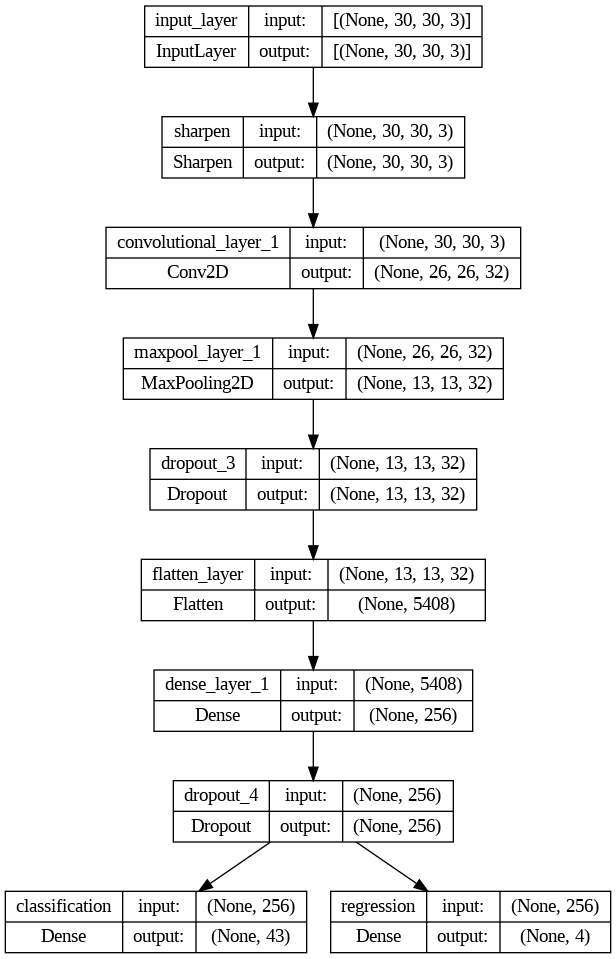

In [27]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
##This code defines a custom Keras callback, Metrics, to compute and display precision, recall, and F1 scores for a classification model during training.

In [28]:
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import f1_score, precision_score, recall_score
class Metrics(Callback) :
  def __init__(self, validation_data_generator) :
    self.validation_data_generator = validation_data_generator

  def on_train_begin(self, logs={}) :
    '''
    This function initializes lists to store AUC and Micro F1 scores
    '''
    self.val_f1s = []
    self.val_precisions = []
    self.val_recalls = []
    self.batches = self.validation_data_generator.as_numpy_iterator()

  def on_epoch_end(self, epoch, logs = {}) :
    '''
    This function calculates the micro f1 and auc scores
    at the end of each epochs
    '''
    current_batch = self.batches.next()
    images = current_batch[0]
    labels = current_batch[1]
    labels = labels["classification"]
    labels = np.array(labels)
    pred = self.model.predict(images)
    pred = pred[0]
    val_predict = (np.asarray(pred)).round()
    idx = np.argmax(val_predict, axis=-1)
    a = np.zeros( val_predict.shape )
    a[ np.arange(a.shape[0]), idx] = 1
    val_predict = [np.where(r==1)[0][0] for r in a]
    val_predict = np.array(val_predict)
    val_targ = labels
    _val_f1 = f1_score(val_targ, val_predict, average = 'weighted')
    _val_precision = precision_score(val_targ, val_predict, average='weighted')
    _val_recall = recall_score(val_targ, val_predict, average='weighted')
    print("\nEpoch : {0} -  Precision_Score : {1:.2f} - Recall_Score : {2:.2f} - F1_Score : {3:.2f}\n".format(epoch, _val_precision, _val_recall, _val_f1))
    self.val_f1s.append(_val_f1)
    self.val_precisions.append(_val_precision)
    self.val_recalls.append(_val_recall)
    return

In [ ]:

##This code defines a custom Keras callback, Metrics, to compute and display precision, recall, and F1 scores for a classification model during training.

In [29]:
from keras import backend as K
def r2_keras(y_true, y_pred):
  SS_res =  K.sum(K.square(y_true - y_pred))
  SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
  return ( 1 - SS_res/(SS_tot + K.epsilon()) )

loss = SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer="adam", loss = {"classification" : loss,"regression" : "mse"}, metrics={"classification" : "acc", "regression" : r2_keras},
              loss_weights = {"classification" : 5, "regression" : 1})

In [ ]:
##This code configures multiple callbacks for model training, such as model checkpointing, TensorBoard logging, early stopping, and a custom metrics callback, along with defining log directories and naming conventions.

In [30]:
#Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import f1_score, precision_score, recall_score, auc
import datetime
import time
%load_ext tensorboard
log_dir="/content/drive/My Drive/CaseStudy2/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
NAME = "TrafficSignRecog-first-cut-{0}".format(int(time.time()))
save_best_model = ModelCheckpoint(filepath='/content/drive/My Drive/CaseStudy2/best_models/{0}'.format(NAME), monitor='val_loss',
                                  save_best_only = True, mode = 'min', save_freq = 'epoch')
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True,
                                   write_images = True)
early_stop = EarlyStopping(monitor='loss', min_delta=0.0001, patience=5)
metrics = Metrics(tf_image_generator_val)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
##This code trains a model using data generators and callbacks, including model checkpointing, TensorBoard logging, custom metrics, and early stopping.

In [31]:
history = model.fit_generator(
    generator = tf_image_generator_train, steps_per_epoch = steps_per_epoch_train, #train batch size
    epochs = 10,
    validation_data = tf_image_generator_val, validation_steps = steps_per_epoch_val, #val batch size
    callbacks = [save_best_model, tensorboard_callback, metrics, early_stop]
)

Epoch 1/10
919/919 [==============================] - ETA: 0s - loss: 31.3754 - classification_loss: 3.8973 - regression_loss: 11.4109 - classification_acc: 0.0807 - regression_r2_keras: 0.8676

1/1 [==============================] - 0s 66ms/step

Epoch : 0 -  Precision_Score : 0.00 - Recall_Score : 0.00 - F1_Score : 0.00

919/919 [==============================] - 19s 19ms/step - loss: 31.3754 - classification_loss: 3.8973 - regression_loss: 11.4109 - classification_acc: 0.0807 - regression_r2_keras: 0.8676 - val_loss: 17.4246 - val_classification_loss: 2.9476 - val_regression_loss: 2.0615 - val_classification_acc: 0.2540 - val_regression_r2_keras: 0.9744
Epoch 2/10
919/919 [==============================] - ETA: 0s - loss: 20.2457 - classification_loss: 2.7650 - regression_loss: 5.5636 - classification_acc: 0.2460 - regression_r2_keras: 0.9353

1/1 [==============================] - 0s 27ms/step

Epoch : 1 -  Precision_Score : 0.00 - Recall_Score : 0.00 - F1_Score : 0.00

919/919 [==============================] - 19s 21ms/step - loss: 20.2457 - classification_loss: 2.7650 - regression_loss: 5.5636 - classification_acc: 0.2460 - regression_r2_keras: 0.9353 - val_loss: 13.9235 - val_classification_loss: 2.1662 - val_regression_loss: 2.0311 - val_classification_acc: 0.4425 - val_regression_r2_keras: 0.9748
Epoch 3/10
918/919 [============================>.] - ETA: 0s - loss: 17.5277 - classification_loss: 2.1443 - regression_loss: 5.6115 - classification_acc: 0.3809 - regression_r2_keras: 0.9347

1/1 [==============================] - 0s 25ms/step

Epoch : 2 -  Precision_Score : 0.00 - Recall_Score : 0.00 - F1_Score : 0.00

919/919 [==============================] - 18s 20ms/step - loss: 17.5256 - classification_loss: 2.1439 - regression_loss: 5.6113 - classification_acc: 0.3809 - regression_r2_keras: 0.9347 - val_loss: 11.7027 - val_classification_loss: 1.5989 - val_regression_loss: 2.4046 - val_classification_acc: 0.5508 - val_regression_r2_keras: 0.9703
Epoch 4/10
918/919 [============================>.] - ETA: 0s - loss: 15.8483 - classification_loss: 1.7329 - regression_loss: 5.8007 - classification_acc: 0.4826 - regression_r2_keras: 0.9325

1/1 [==============================] - 0s 19ms/step

Epoch : 3 -  Precision_Score : 0.00 - Recall_Score : 0.00 - F1_Score : 0.00

919/919 [==============================] - 17s 18ms/step - loss: 15.8494 - classification_loss: 1.7332 - regression_loss: 5.8005 - classification_acc: 0.4826 - regression_r2_keras: 0.9325 - val_loss: 9.6489 - val_classification_loss: 1.2108 - val_regression_loss: 2.1486 - val_classification_acc: 0.6886 - val_regression_r2_keras: 0.9735
Epoch 5/10
918/919 [============================>.] - ETA: 0s - loss: 14.3955 - classification_loss: 1.4397 - regression_loss: 5.7057 - classification_acc: 0.5701 - regression_r2_keras: 0.9336

1/1 [==============================] - 0s 20ms/step

Epoch : 4 -  Precision_Score : 0.75 - Recall_Score : 0.75 - F1_Score : 0.75

919/919 [==============================] - 19s 21ms/step - loss: 14.3978 - classification_loss: 1.4400 - regression_loss: 5.7065 - classification_acc: 0.5701 - regression_r2_keras: 0.9336 - val_loss: 8.6158 - val_classification_loss: 0.9778 - val_regression_loss: 2.2013 - val_classification_acc: 0.7290 - val_regression_r2_keras: 0.9726
Epoch 6/10
917/919 [============================>.] - ETA: 0s - loss: 13.5466 - classification_loss: 1.2491 - regression_loss: 5.7565 - classification_acc: 0.6214 - regression_r2_keras: 0.9331

1/1 [==============================] - 0s 25ms/step

Epoch : 5 -  Precision_Score : 1.00 - Recall_Score : 0.97 - F1_Score : 0.98

919/919 [==============================] - 17s 19ms/step - loss: 13.5441 - classification_loss: 1.2492 - regression_loss: 5.7534 - classification_acc: 0.6213 - regression_r2_keras: 0.9331 - val_loss: 8.1958 - val_classification_loss: 0.8138 - val_regression_loss: 2.5681 - val_classification_acc: 0.7817 - val_regression_r2_keras: 0.9688
Epoch 7/10
917/919 [============================>.] - ETA: 0s - loss: 12.9161 - classification_loss: 1.1151 - regression_loss: 5.7730 - classification_acc: 0.6606 - regression_r2_keras: 0.9329

1/1 [==============================] - 0s 18ms/step

Epoch : 6 -  Precision_Score : 1.00 - Recall_Score : 0.94 - F1_Score : 0.97

919/919 [==============================] - 23s 25ms/step - loss: 12.9156 - classification_loss: 1.1151 - regression_loss: 5.7726 - classification_acc: 0.6607 - regression_r2_keras: 0.9329 - val_loss: 7.0625 - val_classification_loss: 0.6672 - val_regression_loss: 2.1567 - val_classification_acc: 0.8338 - val_regression_r2_keras: 0.9734
Epoch 8/10
1/1 [==============================] - 0s 43ms/step

Epoch : 7 -  Precision_Score : 1.00 - Recall_Score : 0.91 - F1_Score : 0.95

919/919 [==============================] - 16s 18ms/step - loss: 12.2380 - classification_loss: 1.0019 - regression_loss: 5.6582 - classification_acc: 0.6933 - regression_r2_keras: 0.9342 - val_loss: 7.6527 - val_classification_loss: 0.5872 - val_regression_loss: 3.1466 - val_classification_acc: 0.8606 - val_regression_r2_keras: 0.9622
Epoch 9/10
915/919 [============================>.] -

1/1 [==============================] - 0s 35ms/step

Epoch : 8 -  Precision_Score : 1.00 - Recall_Score : 1.00 - F1_Score : 1.00

919/919 [==============================] - 16s 18ms/step - loss: 11.7983 - classification_loss: 0.9244 - regression_loss: 5.6118 - classification_acc: 0.7150 - regression_r2_keras: 0.9347 - val_loss: 6.4335 - val_classification_loss: 0.5224 - val_regression_loss: 2.2676 - val_classification_acc: 0.8636 - val_regression_r2_keras: 0.9722
Epoch 10/10
917/919 [============================>.] - ETA: 0s - loss: 11.3710 - classification_loss: 0.8541 - regression_loss: 5.5529 - classification_acc: 0.7361 - regression_r2_keras: 0.9354

1/1 [==============================] - 0s 27ms/step

Epoch : 9 -  Precision_Score : 1.00 - Recall_Score : 1.00 - F1_Score : 1.00

919/919 [==============================] - 17s 19ms/step - loss: 11.3763 - classification_loss: 0.8538 - regression_loss: 5.5594 - classification_acc: 0.7361 - regression_r2_keras: 0.9353 - val_loss: 6.1991 - val_classification_loss: 0.4765 - val_regression_loss: 2.2730 - val_classification_acc: 0.8877 - val_regression_r2_keras: 0.9722


In [32]:
# model.load_weights('CustomRCNN (1).h5')

In [33]:
test_df = pd.read_csv('Test.csv')
for idx, row in test_df.iterrows() :
  w = row['Width']
  h = row['Height']
  if w > IMG_WIDTH :
    diff = w-IMG_WIDTH
    test_df.iloc[idx, 4] = test_df.iloc[idx]['Roi.X2'] - diff
  else :
    diff = IMG_WIDTH-w
    test_df.iloc[idx, 4] = test_df.iloc[idx]['Roi.X2'] + diff
  if h > IMG_HEIGHT :
    diff = h - IMG_HEIGHT
    test_df.iloc[idx, 5] = test_df.iloc[idx]['Roi.Y2'] - diff
  else :
    diff = IMG_HEIGHT - h
    test_df.iloc[idx, 5] = test_df.iloc[idx]['Roi.Y2'] + diff

In [ ]:
##This code processes and evaluates test images using a trained model, producing class label predictions and associated bounding box values, after applying necessary preprocessing steps.

In [34]:
def evaluate_test_images(path, model) :
  labels = []
  bbox = []
  all_imgs = os.listdir(path)
  all_imgs.sort()
  for img in tqdm(all_imgs) :
    if '.png' in img :
      image_string = tf.io.read_file(path + '/' + img)
      image = tf.image.decode_png(image_string, channels=N_CHANNELS)
      image = tf.image.convert_image_dtype(image, tf.float32)
      if tf.math.reduce_mean(image) < 0.3 :
        image = tf.image.adjust_contrast(image, 5)
        image = tf.image.adjust_brightness(image, 0.2)
      image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH], method="nearest", preserve_aspect_ratio=False)
      image = image/255.0
      image = np.expand_dims(image, axis=0)
      pred = model.predict(image)
      labels.append(np.argmax(pred[0][0]))
      bbox.append(pred[1][0])
  return labels, bbox

In [35]:
test_path = "Test"
labels, bbox = evaluate_test_images(test_path, model)

  0%|          | 0/12631 [00:00<?, ?it/s]

1/1 [==============================] - 0s 91ms/step


  0%|          | 1/12631 [00:00<28:52,  7.29it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 3/12631 [00:00<16:39, 12.63it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 5/12631 [00:00<14:52, 14.14it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 7/12631 [00:00<14:57, 14.07it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 9/12631 [00:00<14:34, 14.43it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 11/12631 [00:00<13:58, 15.05it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 13/12631 [00:00<13:49, 15.21it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 15/12631 [00:01<13:45, 15.28it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 17/12631 [00:01<13:37, 15.43it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 19/12631 [00:01<13:18, 15.79it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 21/12631 [00:01<13:32, 15.51it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 23/12631 [00:01<13:51, 15.16it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 25/12631 [00:01<13:35, 15.45it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 27/12631 [00:01<13:11, 15.93it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 29/12631 [00:01<12:47, 16.42it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 31/12631 [00:02<12:34, 16.70it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 33/12631 [00:02<12:41, 16.54it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 35/12631 [00:02<13:54, 15.09it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 37/12631 [00:02<15:13, 13.79it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 39/12631 [00:02<15:25, 13.61it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 41/12631 [00:02<16:00, 13.10it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 43/12631 [00:02<16:23, 12.80it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 45/12631 [00:03<17:20, 12.10it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 47/12631 [00:03<17:32, 11.95it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 49/12631 [00:03<18:08, 11.56it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 51/12631 [00:03<18:32, 11.30it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 53/12631 [00:03<19:11, 10.92it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 55/12631 [00:04<18:27, 11.35it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 57/12631 [00:04<18:30, 11.32it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 59/12631 [00:04<18:25, 11.37it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 61/12631 [00:04<18:32, 11.30it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 63/12631 [00:04<17:53, 11.70it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 65/12631 [00:04<17:50, 11.73it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 67/12631 [00:05<17:50, 11.74it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 69/12631 [00:05<17:52, 11.71it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 71/12631 [00:05<18:02, 11.60it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 73/12631 [00:05<18:09, 11.52it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 75/12631 [00:05<17:48, 11.76it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 77/12631 [00:05<16:44, 12.50it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 79/12631 [00:06<15:22, 13.61it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 81/12631 [00:06<14:22, 14.54it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 83/12631 [00:06<13:38, 15.32it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 85/12631 [00:06<13:00, 16.07it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 87/12631 [00:06<12:44, 16.40it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 89/12631 [00:06<12:31, 16.69it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 91/12631 [00:06<12:41, 16.46it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 93/12631 [00:06<12:21, 16.91it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 95/12631 [00:06<12:24, 16.83it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 97/12631 [00:07<12:33, 16.64it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 99/12631 [00:07<12:22, 16.88it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 101/12631 [00:07<12:06, 17.24it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 103/12631 [00:07<12:04, 17.30it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 105/12631 [00:07<12:06, 17.24it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 107/12631 [00:07<12:24, 16.82it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 109/12631 [00:07<12:13, 17.08it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 111/12631 [00:07<12:20, 16.90it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 113/12631 [00:08<12:23, 16.84it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 115/12631 [00:08<12:35, 16.57it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 117/12631 [00:08<12:20, 16.90it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 119/12631 [00:08<12:15, 17.01it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 121/12631 [00:08<12:02, 17.31it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 123/12631 [00:08<12:09, 17.15it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 125/12631 [00:08<12:24, 16.79it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 127/12631 [00:08<12:15, 16.99it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 129/12631 [00:08<12:30, 16.67it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 131/12631 [00:09<12:30, 16.66it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 133/12631 [00:09<12:40, 16.43it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 135/12631 [00:09<12:28, 16.69it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 137/12631 [00:09<12:32, 16.61it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 139/12631 [00:09<12:19, 16.90it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 141/12631 [00:09<12:37, 16.48it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 143/12631 [00:09<12:18, 16.90it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 145/12631 [00:09<12:03, 17.26it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 147/12631 [00:10<11:58, 17.39it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 149/12631 [00:10<12:21, 16.83it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 151/12631 [00:10<12:26, 16.71it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 153/12631 [00:10<12:11, 17.07it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 155/12631 [00:10<12:12, 17.03it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 157/12631 [00:10<11:58, 17.37it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 159/12631 [00:10<12:37, 16.47it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 161/12631 [00:10<12:25, 16.73it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 163/12631 [00:10<12:19, 16.85it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 165/12631 [00:11<12:45, 16.27it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 167/12631 [00:11<12:48, 16.23it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 169/12631 [00:11<12:37, 16.46it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 171/12631 [00:11<12:29, 16.62it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 173/12631 [00:11<12:29, 16.62it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 175/12631 [00:11<12:27, 16.66it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 177/12631 [00:11<12:47, 16.22it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 179/12631 [00:11<12:53, 16.09it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 181/12631 [00:12<12:38, 16.41it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 183/12631 [00:12<12:43, 16.30it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 185/12631 [00:12<13:10, 15.74it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 187/12631 [00:12<12:46, 16.24it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 189/12631 [00:12<12:40, 16.36it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 191/12631 [00:12<12:26, 16.66it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 193/12631 [00:12<12:28, 16.62it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 195/12631 [00:12<12:20, 16.80it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 197/12631 [00:13<12:27, 16.63it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 199/12631 [00:13<12:20, 16.78it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 201/12631 [00:13<12:07, 17.08it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 203/12631 [00:13<12:26, 16.65it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 205/12631 [00:13<12:41, 16.32it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 207/12631 [00:13<12:23, 16.70it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 209/12631 [00:13<12:17, 16.83it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 211/12631 [00:13<12:12, 16.95it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 213/12631 [00:13<12:13, 16.94it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 215/12631 [00:14<12:13, 16.93it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 217/12631 [00:14<12:35, 16.44it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 219/12631 [00:14<12:19, 16.78it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 221/12631 [00:14<12:23, 16.69it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 223/12631 [00:14<12:11, 16.96it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 225/12631 [00:14<12:03, 17.15it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 227/12631 [00:14<12:17, 16.83it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 229/12631 [00:14<12:05, 17.10it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 231/12631 [00:15<12:32, 16.47it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 233/12631 [00:15<12:44, 16.21it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 235/12631 [00:15<12:47, 16.14it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 237/12631 [00:15<12:50, 16.09it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 239/12631 [00:15<12:49, 16.10it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 241/12631 [00:15<12:41, 16.27it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 243/12631 [00:15<12:43, 16.23it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 245/12631 [00:15<13:25, 15.37it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 247/12631 [00:16<14:30, 14.22it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 249/12631 [00:16<15:32, 13.28it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 251/12631 [00:16<15:57, 12.92it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 253/12631 [00:16<15:59, 12.90it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 255/12631 [00:16<16:27, 12.53it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 257/12631 [00:16<16:55, 12.18it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 259/12631 [00:17<17:52, 11.54it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 261/12631 [00:17<17:35, 11.72it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 263/12631 [00:17<17:19, 11.90it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 265/12631 [00:17<16:56, 12.17it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 267/12631 [00:17<19:03, 10.81it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 269/12631 [00:18<18:20, 11.23it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 271/12631 [00:18<18:06, 11.38it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 273/12631 [00:18<17:47, 11.58it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 275/12631 [00:18<17:53, 11.51it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 277/12631 [00:18<17:57, 11.47it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 279/12631 [00:18<17:32, 11.73it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 281/12631 [00:19<17:19, 11.88it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 283/12631 [00:19<17:53, 11.51it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 285/12631 [00:19<17:45, 11.59it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 287/12631 [00:19<17:47, 11.56it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 289/12631 [00:19<17:48, 11.55it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 291/12631 [00:19<17:05, 12.03it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 293/12631 [00:20<16:00, 12.85it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 295/12631 [00:20<15:14, 13.49it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 297/12631 [00:20<14:12, 14.46it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 299/12631 [00:20<13:49, 14.87it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 301/12631 [00:20<13:48, 14.89it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 303/12631 [00:20<13:15, 15.49it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 305/12631 [00:20<13:10, 15.59it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 307/12631 [00:20<12:49, 16.02it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 309/12631 [00:21<12:57, 15.85it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 311/12631 [00:21<13:03, 15.72it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 313/12631 [00:21<12:47, 16.04it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 315/12631 [00:21<12:53, 15.92it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 317/12631 [00:21<12:39, 16.22it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 319/12631 [00:21<12:37, 16.26it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 321/12631 [00:21<12:25, 16.50it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 323/12631 [00:21<12:51, 15.96it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 325/12631 [00:22<12:39, 16.20it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 327/12631 [00:22<12:35, 16.29it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 329/12631 [00:22<12:53, 15.89it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 331/12631 [00:22<12:40, 16.18it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 333/12631 [00:22<13:09, 15.57it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 335/12631 [00:22<12:42, 16.12it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 337/12631 [00:22<13:07, 15.61it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 339/12631 [00:22<12:41, 16.14it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 341/12631 [00:23<12:27, 16.43it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 343/12631 [00:23<12:35, 16.26it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 345/12631 [00:23<12:20, 16.58it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 347/12631 [00:23<12:25, 16.49it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 349/12631 [00:23<12:14, 16.72it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 351/12631 [00:23<12:24, 16.50it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 353/12631 [00:23<12:06, 16.91it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 355/12631 [00:23<12:08, 16.85it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 357/12631 [00:23<12:07, 16.87it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 359/12631 [00:24<12:41, 16.13it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 361/12631 [00:24<12:44, 16.05it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 363/12631 [00:24<12:32, 16.31it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 365/12631 [00:24<13:02, 15.67it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 367/12631 [00:24<12:40, 16.13it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 369/12631 [00:24<12:28, 16.39it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 371/12631 [00:24<12:22, 16.50it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 373/12631 [00:24<12:23, 16.48it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 375/12631 [00:25<12:25, 16.43it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 377/12631 [00:25<12:31, 16.31it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 379/12631 [00:25<12:19, 16.56it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 381/12631 [00:25<12:48, 15.94it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 383/12631 [00:25<12:32, 16.27it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 385/12631 [00:25<12:27, 16.39it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 387/12631 [00:25<12:25, 16.42it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 389/12631 [00:25<12:11, 16.73it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 391/12631 [00:26<12:36, 16.19it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 393/12631 [00:26<12:35, 16.20it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 395/12631 [00:26<12:16, 16.61it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 397/12631 [00:26<12:06, 16.83it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 399/12631 [00:26<12:49, 15.90it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 401/12631 [00:26<12:47, 15.93it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 403/12631 [00:26<12:54, 15.79it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 405/12631 [00:26<13:01, 15.65it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 407/12631 [00:27<12:53, 15.81it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 409/12631 [00:27<13:39, 14.90it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 411/12631 [00:27<13:16, 15.33it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 413/12631 [00:27<13:19, 15.28it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 415/12631 [00:27<13:15, 15.35it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 417/12631 [00:27<13:17, 15.31it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 419/12631 [00:27<13:24, 15.19it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 421/12631 [00:27<13:06, 15.52it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 423/12631 [00:28<12:50, 15.84it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 425/12631 [00:28<12:53, 15.78it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 427/12631 [00:28<13:04, 15.56it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 429/12631 [00:28<13:03, 15.57it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 431/12631 [00:28<12:42, 16.00it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 433/12631 [00:28<12:27, 16.32it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 435/12631 [00:28<12:58, 15.67it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 437/12631 [00:29<13:06, 15.51it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 439/12631 [00:29<13:23, 15.17it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 441/12631 [00:29<13:16, 15.30it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▎         | 443/12631 [00:29<13:13, 15.36it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 445/12631 [00:29<13:07, 15.47it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 447/12631 [00:29<12:57, 15.67it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 449/12631 [00:29<12:56, 15.68it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▎         | 451/12631 [00:29<13:34, 14.96it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▎         | 453/12631 [00:30<14:41, 13.82it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▎         | 455/12631 [00:30<16:35, 12.23it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▎         | 457/12631 [00:30<16:24, 12.37it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▎         | 459/12631 [00:30<16:03, 12.63it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 461/12631 [00:30<16:04, 12.61it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▎         | 463/12631 [00:30<16:52, 12.02it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▎         | 465/12631 [00:31<17:35, 11.52it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▎         | 467/12631 [00:31<18:07, 11.19it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 469/12631 [00:31<17:21, 11.68it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▎         | 471/12631 [00:31<17:01, 11.90it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▎         | 473/12631 [00:31<17:12, 11.78it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 475/12631 [00:32<17:15, 11.73it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 477/12631 [00:32<17:40, 11.46it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 479/12631 [00:32<17:53, 11.32it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 481/12631 [00:32<18:21, 11.03it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 483/12631 [00:32<18:36, 10.88it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 485/12631 [00:32<18:11, 11.12it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 487/12631 [00:33<18:37, 10.86it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 489/12631 [00:33<18:50, 10.74it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 491/12631 [00:33<19:13, 10.53it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 493/12631 [00:33<18:37, 10.87it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 495/12631 [00:33<18:21, 11.02it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 497/12631 [00:33<16:57, 11.92it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 499/12631 [00:34<16:07, 12.54it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 501/12631 [00:34<15:29, 13.05it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 503/12631 [00:34<14:45, 13.70it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 505/12631 [00:34<14:20, 14.09it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 507/12631 [00:34<14:02, 14.39it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 509/12631 [00:34<13:23, 15.09it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 511/12631 [00:34<12:55, 15.63it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 513/12631 [00:35<12:46, 15.81it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 515/12631 [00:35<12:38, 15.98it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 517/12631 [00:35<12:46, 15.81it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 519/12631 [00:35<12:29, 16.16it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 521/12631 [00:35<13:16, 15.20it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 523/12631 [00:35<13:18, 15.17it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 525/12631 [00:35<13:22, 15.09it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 527/12631 [00:35<13:16, 15.20it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 529/12631 [00:36<12:59, 15.53it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 531/12631 [00:36<13:00, 15.51it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 533/12631 [00:36<13:14, 15.24it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 535/12631 [00:36<13:11, 15.28it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 537/12631 [00:36<13:05, 15.39it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 539/12631 [00:36<13:02, 15.45it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 541/12631 [00:36<12:55, 15.59it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 543/12631 [00:36<13:09, 15.31it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 545/12631 [00:37<12:52, 15.66it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 547/12631 [00:37<13:03, 15.42it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 549/12631 [00:37<12:54, 15.60it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 551/12631 [00:37<13:18, 15.14it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 553/12631 [00:37<13:45, 14.63it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 555/12631 [00:37<13:32, 14.86it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 557/12631 [00:37<13:37, 14.78it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 559/12631 [00:38<12:59, 15.48it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 561/12631 [00:38<13:18, 15.11it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 563/12631 [00:38<12:56, 15.55it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 565/12631 [00:38<12:38, 15.90it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 567/12631 [00:38<13:04, 15.38it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 569/12631 [00:38<13:03, 15.39it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 571/12631 [00:38<12:37, 15.91it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 573/12631 [00:38<12:37, 15.92it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 575/12631 [00:39<12:37, 15.92it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 577/12631 [00:39<12:48, 15.68it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 579/12631 [00:39<12:57, 15.51it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 581/12631 [00:39<12:50, 15.64it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 583/12631 [00:39<12:57, 15.50it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 585/12631 [00:39<12:58, 15.48it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 587/12631 [00:39<12:57, 15.49it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 589/12631 [00:39<12:53, 15.57it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 591/12631 [00:40<12:34, 15.96it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 593/12631 [00:40<12:33, 15.97it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 595/12631 [00:40<12:32, 16.00it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 597/12631 [00:40<12:32, 16.00it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 599/12631 [00:40<12:33, 15.96it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 601/12631 [00:40<12:31, 16.02it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 603/12631 [00:40<12:44, 15.72it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 605/12631 [00:40<12:52, 15.57it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 607/12631 [00:41<12:37, 15.87it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 609/12631 [00:41<12:37, 15.87it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 611/12631 [00:41<12:31, 16.00it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 613/12631 [00:41<12:18, 16.27it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 615/12631 [00:41<12:48, 15.63it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 617/12631 [00:41<12:55, 15.49it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 619/12631 [00:41<12:56, 15.46it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 621/12631 [00:41<12:41, 15.78it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 623/12631 [00:42<12:47, 15.64it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 625/12631 [00:42<12:30, 16.01it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 627/12631 [00:42<12:32, 15.96it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 629/12631 [00:42<12:41, 15.77it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 631/12631 [00:42<12:58, 15.41it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 633/12631 [00:42<13:03, 15.32it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 635/12631 [00:42<13:00, 15.37it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 637/12631 [00:42<12:41, 15.75it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 639/12631 [00:43<12:43, 15.70it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 641/12631 [00:43<12:48, 15.61it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 643/12631 [00:43<12:56, 15.44it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 645/12631 [00:43<12:43, 15.71it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 647/12631 [00:43<12:42, 15.72it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 649/12631 [00:43<12:35, 15.86it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 651/12631 [00:43<12:36, 15.85it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 653/12631 [00:44<13:25, 14.88it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 655/12631 [00:44<14:59, 13.32it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 657/12631 [00:44<15:42, 12.71it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 659/12631 [00:44<16:21, 12.19it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 661/12631 [00:44<17:14, 11.57it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 663/12631 [00:44<17:12, 11.59it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 665/12631 [00:45<17:07, 11.65it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 667/12631 [00:45<17:26, 11.43it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 669/12631 [00:45<17:39, 11.29it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 671/12631 [00:45<17:38, 11.30it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 673/12631 [00:45<18:15, 10.91it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 675/12631 [00:46<17:57, 11.09it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 677/12631 [00:46<18:04, 11.02it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▌         | 679/12631 [00:46<18:10, 10.96it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 681/12631 [00:46<17:54, 11.13it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▌         | 683/12631 [00:46<18:09, 10.96it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 685/12631 [00:46<18:55, 10.52it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 687/12631 [00:47<18:13, 10.92it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 689/12631 [00:47<17:50, 11.16it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 691/12631 [00:47<17:18, 11.50it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▌         | 693/12631 [00:47<17:43, 11.23it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 695/12631 [00:47<18:11, 10.94it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 697/12631 [00:47<16:58, 11.71it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 699/12631 [00:48<15:35, 12.76it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 701/12631 [00:48<14:52, 13.37it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 703/12631 [00:48<14:22, 13.82it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 705/12631 [00:48<14:00, 14.19it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 707/12631 [00:48<13:25, 14.80it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 709/12631 [00:48<13:11, 15.06it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 711/12631 [00:48<13:34, 14.63it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 713/12631 [00:49<24:52,  7.98it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 715/12631 [00:49<21:50,  9.09it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 717/12631 [00:49<19:53,  9.98it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 719/12631 [00:49<18:46, 10.57it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 721/12631 [00:50<17:40, 11.23it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 723/12631 [00:50<16:43, 11.86it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 725/12631 [00:50<16:04, 12.34it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 727/12631 [00:50<15:25, 12.86it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 729/12631 [00:50<15:05, 13.14it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 731/12631 [00:50<15:52, 12.49it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 733/12631 [00:50<15:36, 12.71it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 735/12631 [00:51<15:17, 12.97it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 737/12631 [00:51<15:15, 12.99it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 739/12631 [00:51<15:25, 12.85it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 741/12631 [00:51<15:20, 12.91it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 743/12631 [00:51<14:57, 13.24it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 745/12631 [00:51<14:37, 13.54it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 747/12631 [00:51<14:46, 13.41it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 749/12631 [00:52<14:56, 13.26it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 751/12631 [00:52<14:40, 13.49it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 753/12631 [00:52<14:47, 13.38it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 755/12631 [00:52<14:27, 13.69it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 757/12631 [00:52<15:05, 13.11it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 759/12631 [00:52<14:53, 13.29it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 761/12631 [00:53<15:00, 13.18it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 763/12631 [00:53<15:00, 13.17it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 765/12631 [00:53<15:01, 13.16it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 767/12631 [00:53<14:53, 13.28it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 769/12631 [00:53<14:52, 13.30it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 771/12631 [00:53<15:19, 12.90it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 773/12631 [00:53<15:37, 12.65it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 775/12631 [00:54<15:59, 12.36it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 777/12631 [00:54<15:39, 12.62it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 779/12631 [00:54<14:57, 13.20it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 781/12631 [00:54<14:45, 13.38it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 783/12631 [00:54<14:53, 13.26it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 785/12631 [00:54<14:29, 13.62it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 787/12631 [00:55<14:24, 13.70it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 789/12631 [00:55<14:28, 13.63it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▋         | 791/12631 [00:55<14:24, 13.70it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 793/12631 [00:55<14:51, 13.28it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▋         | 795/12631 [00:55<14:40, 13.44it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 797/12631 [00:55<14:30, 13.60it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 799/12631 [00:55<13:54, 14.18it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▋         | 801/12631 [00:56<14:09, 13.92it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▋         | 803/12631 [00:56<14:01, 14.06it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 805/12631 [00:56<13:31, 14.58it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 807/12631 [00:56<13:19, 14.79it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▋         | 809/12631 [00:56<13:16, 14.84it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 811/12631 [00:56<13:34, 14.52it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 813/12631 [00:56<13:19, 14.78it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 815/12631 [00:56<12:52, 15.30it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 817/12631 [00:57<13:26, 14.64it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 819/12631 [00:57<13:29, 14.59it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 821/12631 [00:57<13:14, 14.87it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 823/12631 [00:57<13:44, 14.32it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 825/12631 [00:57<13:40, 14.39it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 827/12631 [00:57<14:01, 14.03it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 829/12631 [00:57<14:13, 13.82it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 831/12631 [00:58<16:05, 12.22it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 833/12631 [00:58<16:51, 11.67it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 835/12631 [00:58<16:52, 11.65it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 837/12631 [00:58<17:49, 11.03it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 839/12631 [00:58<17:10, 11.44it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 841/12631 [00:59<17:57, 10.94it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 843/12631 [00:59<18:26, 10.66it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 845/12631 [00:59<19:38, 10.00it/s]

1/1 [==============================] - 0s 56ms/step


  7%|▋         | 847/12631 [00:59<19:26, 10.10it/s]

1/1 [==============================] - 0s 143ms/step


  7%|▋         | 849/12631 [01:00<35:23,  5.55it/s]

1/1 [==============================] - 0s 127ms/step


  7%|▋         | 850/12631 [01:00<40:05,  4.90it/s]

1/1 [==============================] - 0s 120ms/step


  7%|▋         | 851/12631 [01:01<44:08,  4.45it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 852/12631 [01:01<42:43,  4.59it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 854/12631 [01:01<33:30,  5.86it/s]

1/1 [==============================] - 0s 171ms/step


  7%|▋         | 855/12631 [01:01<42:29,  4.62it/s]

1/1 [==============================] - 0s 153ms/step


  7%|▋         | 856/12631 [01:02<53:03,  3.70it/s]

1/1 [==============================] - 0s 65ms/step


  7%|▋         | 857/12631 [01:02<54:04,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 858/12631 [01:02<48:47,  4.02it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 860/12631 [01:02<32:56,  5.95it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 862/12631 [01:03<25:21,  7.74it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 864/12631 [01:03<21:37,  9.07it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 866/12631 [01:03<19:15, 10.18it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 868/12631 [01:03<17:05, 11.47it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 870/12631 [01:03<15:19, 12.79it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 872/12631 [01:03<14:38, 13.38it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 874/12631 [01:03<13:58, 14.01it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 876/12631 [01:03<13:49, 14.18it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 878/12631 [01:04<13:09, 14.89it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 880/12631 [01:04<12:59, 15.08it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 882/12631 [01:04<13:32, 14.47it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 884/12631 [01:04<13:07, 14.92it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 886/12631 [01:04<13:26, 14.56it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 888/12631 [01:04<12:59, 15.07it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 890/12631 [01:04<13:03, 14.98it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 892/12631 [01:04<12:50, 15.24it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 894/12631 [01:05<13:15, 14.75it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 896/12631 [01:05<13:03, 14.99it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 898/12631 [01:05<13:16, 14.73it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 900/12631 [01:05<13:08, 14.88it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 902/12631 [01:05<12:51, 15.20it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 904/12631 [01:05<12:54, 15.15it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 906/12631 [01:05<12:44, 15.34it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 908/12631 [01:06<12:47, 15.28it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 910/12631 [01:06<12:50, 15.21it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 912/12631 [01:06<13:14, 14.74it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 914/12631 [01:06<13:51, 14.09it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 916/12631 [01:06<13:19, 14.65it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 918/12631 [01:06<13:37, 14.33it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 920/12631 [01:06<13:18, 14.66it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 922/12631 [01:07<12:54, 15.11it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 924/12631 [01:07<13:13, 14.75it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 926/12631 [01:07<12:58, 15.03it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 928/12631 [01:07<13:09, 14.83it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 930/12631 [01:07<12:56, 15.07it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 932/12631 [01:07<13:04, 14.91it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 934/12631 [01:07<12:59, 15.00it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 936/12631 [01:07<13:07, 14.84it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 938/12631 [01:08<13:32, 14.39it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 940/12631 [01:08<13:21, 14.58it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 942/12631 [01:08<13:25, 14.52it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 944/12631 [01:08<13:33, 14.37it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 946/12631 [01:08<13:25, 14.51it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 948/12631 [01:08<13:10, 14.78it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 950/12631 [01:08<13:34, 14.35it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 952/12631 [01:09<13:42, 14.19it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 954/12631 [01:09<13:29, 14.43it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 956/12631 [01:09<13:24, 14.52it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 958/12631 [01:09<13:19, 14.60it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 960/12631 [01:09<13:07, 14.82it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 962/12631 [01:09<13:22, 14.55it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 964/12631 [01:09<12:55, 15.05it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 966/12631 [01:10<12:38, 15.39it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 968/12631 [01:10<12:25, 15.65it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 970/12631 [01:10<12:18, 15.79it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 972/12631 [01:10<12:26, 15.62it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 974/12631 [01:10<12:19, 15.76it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 976/12631 [01:10<12:24, 15.66it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 978/12631 [01:10<12:19, 15.76it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 980/12631 [01:10<12:41, 15.31it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 982/12631 [01:11<12:44, 15.24it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 984/12631 [01:11<12:40, 15.32it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 986/12631 [01:11<12:14, 15.85it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 988/12631 [01:11<12:31, 15.50it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 990/12631 [01:11<12:47, 15.17it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 992/12631 [01:11<12:41, 15.29it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 994/12631 [01:11<12:38, 15.34it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 996/12631 [01:11<12:16, 15.79it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 998/12631 [01:12<12:38, 15.33it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 1000/12631 [01:12<12:40, 15.30it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 1002/12631 [01:12<12:22, 15.65it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 1004/12631 [01:12<12:32, 15.46it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 1006/12631 [01:12<13:16, 14.59it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 1008/12631 [01:12<13:48, 14.03it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 1010/12631 [01:12<14:41, 13.18it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 1012/12631 [01:13<16:15, 11.91it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 1014/12631 [01:13<17:00, 11.39it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 1016/12631 [01:13<18:32, 10.44it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 1018/12631 [01:13<18:53, 10.24it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1020/12631 [01:13<18:54, 10.23it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 1022/12631 [01:14<19:19, 10.01it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 1024/12631 [01:14<19:30,  9.92it/s]

1/1 [==============================] - 0s 49ms/step


  8%|▊         | 1026/12631 [01:14<19:43,  9.81it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 1027/12631 [01:14<19:54,  9.71it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 1029/12631 [01:14<19:10, 10.08it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 1031/12631 [01:15<18:14, 10.59it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 1033/12631 [01:15<17:56, 10.77it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 1035/12631 [01:15<17:22, 11.13it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 1037/12631 [01:15<17:37, 10.96it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 1039/12631 [01:15<18:25, 10.49it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 1041/12631 [01:16<20:50,  9.27it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 1042/12631 [01:16<21:12,  9.11it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 1044/12631 [01:16<19:33,  9.88it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 1046/12631 [01:16<20:03,  9.63it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 1048/12631 [01:16<19:31,  9.89it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 1050/12631 [01:16<18:27, 10.46it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 1052/12631 [01:17<17:47, 10.84it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 1054/12631 [01:17<16:42, 11.55it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1056/12631 [01:17<15:45, 12.24it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 1058/12631 [01:17<14:40, 13.15it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1060/12631 [01:17<14:13, 13.56it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 1062/12631 [01:17<13:39, 14.12it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 1064/12631 [01:17<13:19, 14.46it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1066/12631 [01:18<13:48, 13.97it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 1068/12631 [01:18<13:53, 13.87it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 1070/12631 [01:18<14:18, 13.46it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 1072/12631 [01:18<13:57, 13.80it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 1074/12631 [01:18<13:34, 14.19it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 1076/12631 [01:18<13:34, 14.19it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 1078/12631 [01:18<14:01, 13.73it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 1080/12631 [01:19<13:39, 14.09it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 1082/12631 [01:19<14:05, 13.66it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▊         | 1084/12631 [01:19<13:44, 14.01it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▊         | 1086/12631 [01:19<13:35, 14.16it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▊         | 1088/12631 [01:19<13:29, 14.26it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▊         | 1090/12631 [01:19<13:30, 14.24it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▊         | 1092/12631 [01:19<13:19, 14.44it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▊         | 1094/12631 [01:20<12:52, 14.94it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 1096/12631 [01:20<12:56, 14.86it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▊         | 1098/12631 [01:20<13:12, 14.55it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 1100/12631 [01:20<13:19, 14.42it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 1102/12631 [01:20<12:58, 14.82it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▊         | 1104/12631 [01:20<12:53, 14.91it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 1106/12631 [01:20<13:34, 14.15it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 1108/12631 [01:21<13:22, 14.36it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 1110/12631 [01:21<13:08, 14.61it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 1112/12631 [01:21<13:05, 14.66it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 1114/12631 [01:21<13:18, 14.43it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 1116/12631 [01:21<13:12, 14.53it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1118/12631 [01:21<13:00, 14.76it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 1120/12631 [01:21<13:11, 14.54it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 1122/12631 [01:21<13:05, 14.66it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 1124/12631 [01:22<14:00, 13.69it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1126/12631 [01:22<14:12, 13.50it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1128/12631 [01:22<14:11, 13.50it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 1130/12631 [01:22<13:50, 13.84it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 1132/12631 [01:22<14:11, 13.51it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 1134/12631 [01:22<14:28, 13.25it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 1136/12631 [01:23<14:08, 13.55it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 1138/12631 [01:23<13:44, 13.94it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1140/12631 [01:23<13:23, 14.30it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1142/12631 [01:23<13:31, 14.16it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 1144/12631 [01:23<13:25, 14.26it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 1146/12631 [01:23<13:41, 13.99it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 1148/12631 [01:23<13:47, 13.88it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1150/12631 [01:24<13:48, 13.87it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1152/12631 [01:24<13:53, 13.77it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 1154/12631 [01:24<13:49, 13.83it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 1156/12631 [01:24<13:19, 14.35it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1158/12631 [01:24<13:48, 13.85it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 1160/12631 [01:24<13:43, 13.93it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 1162/12631 [01:24<13:31, 14.13it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 1164/12631 [01:24<13:13, 14.45it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 1166/12631 [01:25<13:26, 14.22it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1168/12631 [01:25<13:51, 13.78it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1170/12631 [01:25<13:55, 13.72it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1172/12631 [01:25<13:52, 13.76it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 1174/12631 [01:25<13:39, 13.97it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1176/12631 [01:25<14:03, 13.58it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1178/12631 [01:26<14:06, 13.52it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 1180/12631 [01:26<14:09, 13.47it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 1182/12631 [01:26<13:51, 13.76it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1184/12631 [01:26<13:52, 13.75it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 1186/12631 [01:26<14:00, 13.61it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 1188/12631 [01:26<13:38, 13.99it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 1190/12631 [01:26<13:33, 14.07it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 1192/12631 [01:27<14:29, 13.16it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 1194/12631 [01:27<16:11, 11.77it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 1196/12631 [01:27<16:34, 11.50it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 1198/12631 [01:27<17:02, 11.18it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 1200/12631 [01:27<17:24, 10.94it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 1202/12631 [01:28<18:19, 10.40it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 1204/12631 [01:28<17:59, 10.58it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 1206/12631 [01:28<17:51, 10.66it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 1208/12631 [01:28<18:20, 10.38it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 1210/12631 [01:28<17:47, 10.70it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 1212/12631 [01:28<17:53, 10.63it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 1214/12631 [01:29<18:05, 10.51it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 1216/12631 [01:29<17:43, 10.74it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 1218/12631 [01:29<16:45, 11.35it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 1220/12631 [01:29<17:28, 10.88it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 1222/12631 [01:29<17:14, 11.03it/s]

1/1 [==============================] - 0s 34ms/step


 10%|▉         | 1224/12631 [01:30<17:25, 10.91it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 1226/12631 [01:30<17:25, 10.90it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 1228/12631 [01:30<17:33, 10.83it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 1230/12631 [01:30<17:27, 10.88it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 1232/12631 [01:30<17:36, 10.79it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 1234/12631 [01:31<17:41, 10.74it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 1236/12631 [01:31<17:39, 10.76it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 1238/12631 [01:31<17:21, 10.93it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 1240/12631 [01:31<17:07, 11.08it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 1242/12631 [01:31<15:42, 12.08it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 1244/12631 [01:31<14:57, 12.69it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 1246/12631 [01:31<14:28, 13.11it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 1248/12631 [01:32<14:08, 13.41it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 1250/12631 [01:32<14:12, 13.35it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 1252/12631 [01:32<13:42, 13.83it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 1254/12631 [01:32<13:50, 13.70it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 1256/12631 [01:32<13:46, 13.76it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 1258/12631 [01:32<13:45, 13.78it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 1260/12631 [01:32<13:31, 14.02it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 1262/12631 [01:33<13:17, 14.26it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 1264/12631 [01:33<13:19, 14.22it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 1266/12631 [01:33<13:48, 13.71it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 1268/12631 [01:33<13:40, 13.85it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 1270/12631 [01:33<13:21, 14.17it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 1272/12631 [01:33<13:01, 14.53it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 1274/12631 [01:33<13:14, 14.30it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 1276/12631 [01:34<13:20, 14.18it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 1278/12631 [01:34<13:18, 14.21it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 1280/12631 [01:34<14:24, 13.14it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 1282/12631 [01:34<14:34, 12.98it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 1284/12631 [01:34<14:20, 13.19it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 1286/12631 [01:34<14:10, 13.33it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 1288/12631 [01:34<13:54, 13.59it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 1290/12631 [01:35<13:04, 14.46it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 1292/12631 [01:35<13:22, 14.13it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 1294/12631 [01:35<13:24, 14.08it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 1296/12631 [01:35<13:06, 14.40it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 1298/12631 [01:35<12:51, 14.69it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 1300/12631 [01:35<13:06, 14.41it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 1302/12631 [01:35<13:12, 14.29it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 1304/12631 [01:36<13:22, 14.12it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 1306/12631 [01:36<13:09, 14.34it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 1308/12631 [01:36<12:57, 14.57it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 1310/12631 [01:36<13:23, 14.09it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 1312/12631 [01:36<12:56, 14.58it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 1314/12631 [01:36<13:11, 14.30it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 1316/12631 [01:36<13:09, 14.33it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 1318/12631 [01:37<12:53, 14.62it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 1320/12631 [01:37<13:03, 14.44it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 1322/12631 [01:37<13:21, 14.11it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 1324/12631 [01:37<13:28, 13.99it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 1326/12631 [01:37<13:16, 14.20it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 1328/12631 [01:37<13:51, 13.59it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 1330/12631 [01:37<14:00, 13.44it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 1332/12631 [01:38<14:03, 13.39it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 1334/12631 [01:38<13:47, 13.66it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 1336/12631 [01:38<14:03, 13.39it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 1338/12631 [01:38<13:56, 13.51it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 1340/12631 [01:38<13:31, 13.92it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 1342/12631 [01:38<13:30, 13.94it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 1344/12631 [01:38<13:29, 13.95it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 1346/12631 [01:39<13:54, 13.52it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 1348/12631 [01:39<13:50, 13.58it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 1350/12631 [01:39<14:14, 13.20it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 1352/12631 [01:39<14:12, 13.23it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 1354/12631 [01:39<14:05, 13.33it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 1356/12631 [01:39<14:07, 13.30it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 1358/12631 [01:40<14:15, 13.17it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 1360/12631 [01:40<14:09, 13.27it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 1362/12631 [01:40<14:16, 13.16it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 1364/12631 [01:40<14:32, 12.91it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 1366/12631 [01:40<13:49, 13.58it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 1368/12631 [01:40<13:55, 13.49it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 1370/12631 [01:40<13:48, 13.59it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 1372/12631 [01:41<14:06, 13.30it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 1374/12631 [01:41<14:04, 13.33it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 1376/12631 [01:41<13:52, 13.51it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 1378/12631 [01:41<14:15, 13.16it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 1380/12631 [01:41<15:43, 11.92it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 1382/12631 [01:41<17:02, 11.00it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 1384/12631 [01:42<17:40, 10.61it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 1386/12631 [01:42<17:47, 10.54it/s]

1/1 [==============================] - 0s 47ms/step


 11%|█         | 1388/12631 [01:42<18:34, 10.09it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 1390/12631 [01:42<18:13, 10.28it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 1392/12631 [01:42<18:33, 10.09it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 1394/12631 [01:43<18:22, 10.19it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 1396/12631 [01:43<19:08,  9.78it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 1397/12631 [01:43<19:12,  9.74it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 1398/12631 [01:43<19:41,  9.50it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 1399/12631 [01:43<20:16,  9.24it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█         | 1400/12631 [01:43<20:25,  9.16it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 1401/12631 [01:43<20:09,  9.28it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 1403/12631 [01:44<18:42, 10.01it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 1405/12631 [01:44<18:47,  9.96it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 1406/12631 [01:44<18:52,  9.92it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 1407/12631 [01:44<19:11,  9.75it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 1408/12631 [01:44<20:10,  9.27it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 1409/12631 [01:44<20:20,  9.19it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 1410/12631 [01:44<20:35,  9.08it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 1412/12631 [01:45<19:19,  9.68it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 1414/12631 [01:45<18:39, 10.02it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 1415/12631 [01:45<19:33,  9.56it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 1416/12631 [01:45<20:15,  9.23it/s]

1/1 [==============================] - 0s 46ms/step


 11%|█         | 1418/12631 [01:45<20:13,  9.24it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 1420/12631 [01:45<19:26,  9.61it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█▏        | 1421/12631 [01:46<19:48,  9.44it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 1422/12631 [01:46<19:42,  9.48it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█▏        | 1423/12631 [01:46<19:32,  9.56it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 1425/12631 [01:46<17:33, 10.64it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 1427/12631 [01:46<16:10, 11.55it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 1429/12631 [01:46<15:29, 12.06it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 1431/12631 [01:46<15:13, 12.26it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 1433/12631 [01:46<14:13, 13.12it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 1435/12631 [01:47<14:21, 13.00it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█▏        | 1437/12631 [01:47<14:05, 13.24it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 1439/12631 [01:47<13:39, 13.65it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 1441/12631 [01:47<13:40, 13.63it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 1443/12631 [01:47<13:55, 13.39it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 1445/12631 [01:47<14:14, 13.08it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 1447/12631 [01:47<13:30, 13.80it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 1449/12631 [01:48<13:32, 13.76it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 1451/12631 [01:48<13:11, 14.13it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 1453/12631 [01:48<13:29, 13.81it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 1455/12631 [01:48<13:24, 13.88it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 1457/12631 [01:48<13:08, 14.17it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 1459/12631 [01:48<13:12, 14.09it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 1461/12631 [01:48<13:23, 13.91it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 1463/12631 [01:49<14:29, 12.84it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 1465/12631 [01:49<13:44, 13.54it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 1467/12631 [01:49<14:09, 13.14it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 1469/12631 [01:49<13:50, 13.44it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 1471/12631 [01:49<14:03, 13.24it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 1473/12631 [01:49<13:41, 13.59it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 1475/12631 [01:50<13:40, 13.60it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 1477/12631 [01:50<13:41, 13.58it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 1479/12631 [01:50<13:22, 13.90it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 1481/12631 [01:50<13:36, 13.66it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 1483/12631 [01:50<13:44, 13.53it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 1485/12631 [01:50<13:24, 13.86it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 1487/12631 [01:50<13:44, 13.52it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1489/12631 [01:51<14:11, 13.09it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 1491/12631 [01:51<14:04, 13.19it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 1493/12631 [01:51<13:57, 13.31it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 1495/12631 [01:51<13:44, 13.51it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 1497/12631 [01:51<13:46, 13.46it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 1499/12631 [01:51<13:30, 13.74it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 1501/12631 [01:51<13:32, 13.70it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 1503/12631 [01:52<13:39, 13.57it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 1505/12631 [01:52<13:31, 13.71it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 1507/12631 [01:52<13:37, 13.60it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 1509/12631 [01:52<13:28, 13.76it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 1511/12631 [01:52<13:26, 13.79it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 1513/12631 [01:52<13:10, 14.06it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 1515/12631 [01:52<13:36, 13.61it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 1517/12631 [01:53<13:33, 13.67it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 1519/12631 [01:53<13:11, 14.03it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 1521/12631 [01:53<13:24, 13.81it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 1523/12631 [01:53<13:36, 13.61it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 1525/12631 [01:53<13:44, 13.47it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 1527/12631 [01:53<13:19, 13.89it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 1529/12631 [01:53<13:23, 13.81it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 1531/12631 [01:54<13:26, 13.76it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 1533/12631 [01:54<13:51, 13.35it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 1535/12631 [01:54<13:41, 13.51it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 1537/12631 [01:54<13:48, 13.40it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 1539/12631 [01:54<13:51, 13.35it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 1541/12631 [01:54<14:00, 13.20it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 1543/12631 [01:55<14:13, 12.99it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 1545/12631 [01:55<13:33, 13.63it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 1547/12631 [01:55<13:03, 14.15it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 1549/12631 [01:55<12:58, 14.23it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 1551/12631 [01:55<12:53, 14.33it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 1553/12631 [01:55<12:37, 14.62it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 1555/12631 [01:55<12:31, 14.74it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 1557/12631 [01:56<12:43, 14.51it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 1559/12631 [01:56<13:06, 14.08it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1561/12631 [01:56<14:16, 12.93it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1563/12631 [01:56<15:29, 11.91it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 1565/12631 [01:56<16:38, 11.08it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 1567/12631 [01:56<16:39, 11.07it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1569/12631 [01:57<17:36, 10.47it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1571/12631 [01:57<18:07, 10.17it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 1573/12631 [01:57<17:40, 10.43it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 1575/12631 [01:57<17:56, 10.27it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 1577/12631 [01:57<17:48, 10.34it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 1579/12631 [01:58<18:08, 10.15it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 1581/12631 [01:58<17:08, 10.75it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 1583/12631 [01:58<17:07, 10.75it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 1585/12631 [01:58<17:08, 10.74it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 1587/12631 [01:58<17:18, 10.63it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 1589/12631 [01:59<18:03, 10.19it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 1591/12631 [01:59<17:47, 10.34it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 1593/12631 [01:59<17:44, 10.37it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 1595/12631 [01:59<17:20, 10.61it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 1597/12631 [01:59<17:54, 10.27it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 1599/12631 [02:00<17:50, 10.30it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 1601/12631 [02:00<18:24,  9.98it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 1603/12631 [02:00<17:21, 10.59it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 1605/12631 [02:00<16:40, 11.02it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 1607/12631 [02:00<16:34, 11.08it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1609/12631 [02:00<15:42, 11.70it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1611/12631 [02:01<14:48, 12.40it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 1613/12631 [02:01<14:29, 12.67it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1615/12631 [02:01<13:48, 13.29it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 1617/12631 [02:01<13:35, 13.51it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1619/12631 [02:01<13:09, 13.96it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1621/12631 [02:01<12:52, 14.25it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1623/12631 [02:01<12:39, 14.50it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1625/12631 [02:01<12:10, 15.06it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 1627/12631 [02:02<12:24, 14.79it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1629/12631 [02:02<12:48, 14.31it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 1631/12631 [02:02<13:15, 13.83it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1633/12631 [02:02<13:19, 13.75it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 1635/12631 [02:02<13:22, 13.69it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 1637/12631 [02:02<13:27, 13.62it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1639/12631 [02:03<13:07, 13.96it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 1641/12631 [02:03<12:44, 14.38it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1643/12631 [02:03<13:01, 14.05it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1645/12631 [02:03<13:01, 14.06it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1647/12631 [02:03<12:42, 14.41it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 1649/12631 [02:03<12:47, 14.31it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 1651/12631 [02:03<12:38, 14.47it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 1653/12631 [02:03<13:03, 14.01it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 1655/12631 [02:04<12:50, 14.24it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 1657/12631 [02:04<13:07, 13.94it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 1659/12631 [02:04<12:58, 14.10it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1661/12631 [02:04<12:54, 14.16it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 1663/12631 [02:04<12:30, 14.62it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1665/12631 [02:04<12:42, 14.37it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1667/12631 [02:04<12:47, 14.29it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1669/12631 [02:05<12:48, 14.27it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1671/12631 [02:05<12:36, 14.48it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1673/12631 [02:05<12:55, 14.13it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1675/12631 [02:05<12:59, 14.05it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 1677/12631 [02:05<12:39, 14.42it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1679/12631 [02:05<12:31, 14.58it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1681/12631 [02:05<12:16, 14.87it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1683/12631 [02:06<12:03, 15.13it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 1685/12631 [02:06<12:27, 14.65it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 1687/12631 [02:06<12:30, 14.59it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1689/12631 [02:06<12:20, 14.77it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1691/12631 [02:06<12:17, 14.83it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1693/12631 [02:06<12:16, 14.86it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1695/12631 [02:06<12:28, 14.62it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1697/12631 [02:07<12:08, 15.01it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1699/12631 [02:07<12:04, 15.09it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1701/12631 [02:07<12:10, 14.97it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 1703/12631 [02:07<12:43, 14.32it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 1705/12631 [02:07<12:55, 14.10it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 1707/12631 [02:07<13:03, 13.94it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 1709/12631 [02:07<12:58, 14.03it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▎        | 1711/12631 [02:07<12:44, 14.29it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 1713/12631 [02:08<12:50, 14.18it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▎        | 1715/12631 [02:08<12:48, 14.21it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 1717/12631 [02:08<12:41, 14.32it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 1719/12631 [02:08<12:46, 14.24it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▎        | 1721/12631 [02:08<12:39, 14.36it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 1723/12631 [02:08<12:53, 14.10it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 1725/12631 [02:08<12:59, 13.99it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 1727/12631 [02:09<12:49, 14.17it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 1729/12631 [02:09<13:05, 13.87it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 1731/12631 [02:09<22:48,  7.97it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 1733/12631 [02:09<20:12,  8.99it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▎        | 1735/12631 [02:10<18:12,  9.97it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 1737/12631 [02:10<16:59, 10.69it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 1739/12631 [02:10<15:56, 11.39it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 1741/12631 [02:10<15:50, 11.45it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 1743/12631 [02:10<15:19, 11.84it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 1745/12631 [02:10<15:36, 11.62it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 1747/12631 [02:11<17:15, 10.51it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 1749/12631 [02:11<16:56, 10.71it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 1751/12631 [02:11<16:55, 10.71it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 1753/12631 [02:11<16:15, 11.15it/s]

1/1 [==============================] - 0s 47ms/step


 14%|█▍        | 1755/12631 [02:11<16:35, 10.92it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 1757/12631 [02:12<17:21, 10.44it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 1759/12631 [02:12<18:15,  9.92it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 1761/12631 [02:12<18:51,  9.61it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 1763/12631 [02:12<18:03, 10.03it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 1765/12631 [02:12<17:35, 10.29it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 1767/12631 [02:13<17:17, 10.47it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 1769/12631 [02:13<16:52, 10.73it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 1771/12631 [02:13<16:56, 10.68it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 1773/12631 [02:13<17:52, 10.12it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 1775/12631 [02:13<18:29,  9.79it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 1777/12631 [02:14<18:06,  9.99it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 1779/12631 [02:14<18:05, 10.00it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 1781/12631 [02:14<17:36, 10.27it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 1783/12631 [02:14<18:22,  9.84it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 1784/12631 [02:14<18:50,  9.59it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 1785/12631 [02:14<18:54,  9.56it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 1786/12631 [02:14<18:55,  9.55it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 1788/12631 [02:15<19:14,  9.39it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 1789/12631 [02:15<19:20,  9.34it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 1790/12631 [02:15<19:12,  9.41it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 1791/12631 [02:15<20:12,  8.94it/s]

1/1 [==============================] - 0s 43ms/step


 14%|█▍        | 1792/12631 [02:15<20:04,  9.00it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 1793/12631 [02:15<19:56,  9.06it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 1795/12631 [02:15<17:33, 10.28it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 1797/12631 [02:16<16:33, 10.91it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 1799/12631 [02:16<15:41, 11.51it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 1801/12631 [02:16<15:23, 11.73it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 1803/12631 [02:16<14:52, 12.13it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 1805/12631 [02:16<14:58, 12.05it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 1807/12631 [02:16<14:48, 12.18it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 1809/12631 [02:17<14:39, 12.31it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 1811/12631 [02:17<14:32, 12.40it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 1813/12631 [02:17<14:16, 12.63it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 1815/12631 [02:17<14:26, 12.48it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 1817/12631 [02:17<13:59, 12.88it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 1819/12631 [02:17<14:34, 12.37it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 1821/12631 [02:17<14:15, 12.64it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 1823/12631 [02:18<14:02, 12.83it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 1825/12631 [02:18<13:49, 13.03it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 1827/12631 [02:18<13:26, 13.39it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 1829/12631 [02:18<13:29, 13.34it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 1831/12631 [02:18<13:06, 13.74it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 1833/12631 [02:18<13:18, 13.53it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 1835/12631 [02:19<12:54, 13.94it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 1837/12631 [02:19<13:17, 13.53it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 1839/12631 [02:19<13:20, 13.48it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 1841/12631 [02:19<13:17, 13.53it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 1843/12631 [02:19<12:49, 14.02it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 1845/12631 [02:19<13:30, 13.30it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 1847/12631 [02:19<13:19, 13.49it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 1849/12631 [02:20<12:57, 13.87it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 1851/12631 [02:20<12:51, 13.98it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 1853/12631 [02:20<13:02, 13.78it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 1855/12631 [02:20<13:03, 13.76it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 1857/12631 [02:20<12:59, 13.83it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 1859/12631 [02:20<12:30, 14.34it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 1861/12631 [02:20<12:34, 14.27it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 1863/12631 [02:21<13:06, 13.70it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 1865/12631 [02:21<12:40, 14.15it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 1867/12631 [02:21<12:31, 14.32it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 1869/12631 [02:21<12:31, 14.31it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 1871/12631 [02:21<12:44, 14.08it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 1873/12631 [02:21<12:34, 14.26it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 1875/12631 [02:21<12:47, 14.01it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 1877/12631 [02:22<12:34, 14.26it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 1879/12631 [02:22<12:26, 14.41it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 1881/12631 [02:22<12:35, 14.24it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 1883/12631 [02:22<12:23, 14.45it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 1885/12631 [02:22<12:16, 14.59it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 1887/12631 [02:22<12:26, 14.39it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 1889/12631 [02:22<12:54, 13.87it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 1891/12631 [02:23<12:51, 13.93it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 1893/12631 [02:23<12:47, 13.99it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 1895/12631 [02:23<12:55, 13.85it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 1897/12631 [02:23<12:52, 13.89it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 1899/12631 [02:23<13:02, 13.72it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 1901/12631 [02:23<13:02, 13.72it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 1903/12631 [02:23<12:39, 14.13it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 1905/12631 [02:24<12:41, 14.08it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 1907/12631 [02:24<12:54, 13.84it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 1909/12631 [02:24<12:20, 14.48it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 1911/12631 [02:24<12:31, 14.27it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 1913/12631 [02:24<12:54, 13.84it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 1915/12631 [02:24<12:59, 13.74it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 1917/12631 [02:24<12:40, 14.08it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 1919/12631 [02:25<12:46, 13.98it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 1921/12631 [02:25<12:37, 14.14it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 1923/12631 [02:25<12:30, 14.28it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 1925/12631 [02:25<12:39, 14.11it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 1927/12631 [02:25<12:36, 14.15it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 1929/12631 [02:25<12:24, 14.37it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 1931/12631 [02:25<13:09, 13.55it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 1933/12631 [02:26<14:24, 12.38it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 1935/12631 [02:26<14:26, 12.35it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 1937/12631 [02:26<14:22, 12.40it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 1939/12631 [02:26<14:12, 12.55it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 1941/12631 [02:26<13:48, 12.90it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 1943/12631 [02:26<13:50, 12.88it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 1945/12631 [02:27<14:08, 12.59it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 1947/12631 [02:27<15:09, 11.74it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 1949/12631 [02:27<14:23, 12.38it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 1951/12631 [02:27<14:13, 12.51it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 1953/12631 [02:27<15:33, 11.44it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 1955/12631 [02:27<16:12, 10.98it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 1957/12631 [02:28<15:56, 11.16it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 1959/12631 [02:28<16:31, 10.76it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 1961/12631 [02:28<16:18, 10.91it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1963/12631 [02:28<15:34, 11.42it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 1965/12631 [02:28<15:28, 11.48it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1967/12631 [02:28<15:05, 11.77it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 1969/12631 [02:29<15:51, 11.21it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 1971/12631 [02:29<16:41, 10.65it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 1973/12631 [02:29<15:56, 11.14it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1975/12631 [02:29<14:52, 11.94it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 1977/12631 [02:29<14:31, 12.22it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 1979/12631 [02:29<14:21, 12.36it/s]

1/1 [==============================] - 0s 43ms/step


 16%|█▌        | 1981/12631 [02:30<15:18, 11.60it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 1983/12631 [02:30<16:16, 10.91it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 1985/12631 [02:30<15:59, 11.09it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1987/12631 [02:30<16:30, 10.74it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 1989/12631 [02:30<17:09, 10.33it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1991/12631 [02:31<16:45, 10.58it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 1993/12631 [02:31<16:51, 10.52it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 1995/12631 [02:31<17:14, 10.28it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 1997/12631 [02:31<16:27, 10.77it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1999/12631 [02:31<15:18, 11.58it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 2001/12631 [02:31<14:34, 12.15it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 2003/12631 [02:32<13:57, 12.69it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 2005/12631 [02:32<13:55, 12.72it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 2007/12631 [02:32<13:23, 13.22it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 2009/12631 [02:32<13:18, 13.30it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 2011/12631 [02:32<13:46, 12.85it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 2013/12631 [02:32<13:59, 12.65it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 2015/12631 [02:33<13:34, 13.03it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 2017/12631 [02:33<13:41, 12.92it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 2019/12631 [02:33<13:12, 13.38it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 2021/12631 [02:33<13:09, 13.43it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 2023/12631 [02:33<13:05, 13.51it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 2025/12631 [02:33<13:06, 13.48it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 2027/12631 [02:33<12:49, 13.77it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 2029/12631 [02:34<12:59, 13.60it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 2031/12631 [02:34<13:21, 13.23it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 2033/12631 [02:34<13:27, 13.13it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 2035/12631 [02:34<13:31, 13.06it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 2037/12631 [02:34<13:01, 13.56it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 2039/12631 [02:34<12:53, 13.69it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 2041/12631 [02:34<13:07, 13.45it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 2043/12631 [02:35<12:55, 13.66it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 2045/12631 [02:35<12:54, 13.67it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 2047/12631 [02:35<13:11, 13.37it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 2049/12631 [02:35<13:11, 13.36it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 2051/12631 [02:35<13:27, 13.10it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 2053/12631 [02:35<13:12, 13.34it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 2055/12631 [02:36<13:13, 13.33it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 2057/12631 [02:36<13:15, 13.29it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 2059/12631 [02:36<13:16, 13.27it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 2061/12631 [02:36<13:21, 13.18it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 2063/12631 [02:36<13:07, 13.43it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 2065/12631 [02:36<12:57, 13.58it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 2067/12631 [02:36<12:59, 13.55it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 2069/12631 [02:37<12:45, 13.79it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 2071/12631 [02:37<12:47, 13.75it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 2073/12631 [02:37<12:56, 13.60it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 2075/12631 [02:37<12:51, 13.68it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 2077/12631 [02:37<12:52, 13.66it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 2079/12631 [02:37<12:30, 14.06it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 2081/12631 [02:37<12:51, 13.67it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 2083/12631 [02:38<12:30, 14.06it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 2085/12631 [02:38<12:56, 13.58it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 2087/12631 [02:38<12:54, 13.62it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 2089/12631 [02:38<12:41, 13.84it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 2091/12631 [02:38<12:33, 13.98it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 2093/12631 [02:38<12:41, 13.84it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 2095/12631 [02:38<12:36, 13.93it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 2097/12631 [02:39<12:33, 13.97it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 2099/12631 [02:39<12:49, 13.69it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 2101/12631 [02:39<12:26, 14.11it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 2103/12631 [02:39<12:49, 13.68it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 2105/12631 [02:39<12:47, 13.71it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 2107/12631 [02:39<12:32, 13.99it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 2109/12631 [02:39<12:28, 14.05it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 2111/12631 [02:40<12:37, 13.89it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 2113/12631 [02:40<12:42, 13.80it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 2115/12631 [02:40<12:43, 13.77it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 2117/12631 [02:40<12:40, 13.83it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 2119/12631 [02:40<12:33, 13.94it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 2121/12631 [02:40<12:34, 13.93it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 2123/12631 [02:40<12:41, 13.79it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 2125/12631 [02:41<12:10, 14.38it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 2127/12631 [02:41<12:08, 14.42it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 2129/12631 [02:41<12:24, 14.11it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 2131/12631 [02:41<12:42, 13.77it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 2133/12631 [02:41<13:26, 13.02it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 2135/12631 [02:41<13:27, 13.01it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 2137/12631 [02:42<14:37, 11.96it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 2139/12631 [02:42<15:02, 11.62it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 2141/12631 [02:42<15:31, 11.26it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 2143/12631 [02:42<16:15, 10.75it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 2145/12631 [02:42<16:07, 10.84it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 2147/12631 [02:43<16:15, 10.75it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 2149/12631 [02:43<16:09, 10.81it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 2151/12631 [02:43<16:41, 10.46it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 2153/12631 [02:43<17:26, 10.01it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 2155/12631 [02:43<16:35, 10.53it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 2157/12631 [02:43<15:57, 10.94it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 2159/12631 [02:44<16:36, 10.51it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 2161/12631 [02:44<16:32, 10.55it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 2163/12631 [02:44<15:34, 11.20it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 2165/12631 [02:44<16:29, 10.58it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 2167/12631 [02:44<16:32, 10.54it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 2169/12631 [02:45<17:00, 10.25it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 2171/12631 [02:45<15:56, 10.93it/s]

1/1 [==============================] - 0s 57ms/step


 17%|█▋        | 2173/12631 [02:45<17:03, 10.22it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 2175/12631 [02:45<17:41,  9.85it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 2177/12631 [02:45<17:02, 10.22it/s]

1/1 [==============================] - 0s 56ms/step


 17%|█▋        | 2179/12631 [02:46<17:40,  9.86it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 2181/12631 [02:46<17:03, 10.21it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 2183/12631 [02:46<16:57, 10.27it/s]

1/1 [==============================] - 0s 42ms/step


 17%|█▋        | 2185/12631 [02:46<17:14, 10.09it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 2187/12631 [02:46<16:53, 10.31it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 2189/12631 [02:47<16:06, 10.80it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 2191/12631 [02:47<15:02, 11.57it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 2193/12631 [02:47<14:21, 12.11it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 2195/12631 [02:47<13:48, 12.59it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 2197/12631 [02:47<13:09, 13.21it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 2199/12631 [02:47<13:32, 12.84it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 2201/12631 [02:47<13:19, 13.04it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 2203/12631 [02:48<13:17, 13.08it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 2205/12631 [02:48<12:46, 13.60it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 2207/12631 [02:48<12:37, 13.76it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 2209/12631 [02:48<12:42, 13.67it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 2211/12631 [02:48<12:39, 13.71it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 2213/12631 [02:48<12:51, 13.50it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 2215/12631 [02:48<12:37, 13.75it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 2217/12631 [02:49<12:54, 13.45it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 2219/12631 [02:49<12:55, 13.42it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 2221/12631 [02:49<12:49, 13.54it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 2223/12631 [02:49<12:53, 13.46it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 2225/12631 [02:49<12:56, 13.39it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 2227/12631 [02:49<13:15, 13.08it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 2229/12631 [02:49<13:26, 12.90it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 2231/12631 [02:50<13:10, 13.15it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 2233/12631 [02:50<12:59, 13.34it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 2235/12631 [02:50<12:57, 13.36it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 2237/12631 [02:50<13:00, 13.32it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 2239/12631 [02:50<13:19, 13.00it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 2241/12631 [02:50<13:00, 13.31it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 2243/12631 [02:51<12:58, 13.34it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 2245/12631 [02:51<13:11, 13.11it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 2247/12631 [02:51<13:05, 13.22it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 2249/12631 [02:51<12:46, 13.54it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 2251/12631 [02:51<12:19, 14.04it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 2253/12631 [02:51<12:08, 14.25it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 2255/12631 [02:51<12:32, 13.79it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 2257/12631 [02:52<12:33, 13.76it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 2259/12631 [02:52<12:28, 13.85it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 2261/12631 [02:52<12:33, 13.76it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 2263/12631 [02:52<12:53, 13.40it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 2265/12631 [02:52<12:52, 13.42it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 2267/12631 [02:52<12:54, 13.39it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 2269/12631 [02:52<12:38, 13.67it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 2271/12631 [02:53<12:25, 13.90it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 2273/12631 [02:53<12:40, 13.61it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 2275/12631 [02:53<12:31, 13.79it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 2277/12631 [02:53<12:20, 13.99it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 2279/12631 [02:53<12:38, 13.64it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 2281/12631 [02:53<12:46, 13.50it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 2283/12631 [02:53<12:31, 13.77it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 2285/12631 [02:54<12:10, 14.17it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 2287/12631 [02:54<12:29, 13.79it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 2289/12631 [02:54<12:17, 14.02it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 2291/12631 [02:54<12:43, 13.55it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 2293/12631 [02:54<12:22, 13.93it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 2295/12631 [02:54<12:19, 13.98it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 2297/12631 [02:54<12:06, 14.22it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 2299/12631 [02:55<12:20, 13.95it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 2301/12631 [02:55<12:23, 13.90it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 2303/12631 [02:55<12:07, 14.19it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 2305/12631 [02:55<12:00, 14.33it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 2307/12631 [02:55<12:02, 14.28it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 2309/12631 [02:55<12:22, 13.91it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 2311/12631 [02:55<12:17, 14.00it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 2313/12631 [02:56<12:15, 14.02it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 2315/12631 [02:56<12:16, 14.01it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 2317/12631 [02:56<12:22, 13.90it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 2319/12631 [02:56<12:20, 13.92it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 2321/12631 [02:56<12:22, 13.89it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 2323/12631 [02:56<12:13, 14.05it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 2325/12631 [02:56<12:24, 13.85it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 2327/12631 [02:57<13:55, 12.34it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 2329/12631 [02:57<14:41, 11.69it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 2331/12631 [02:57<14:53, 11.52it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 2333/12631 [02:57<15:59, 10.74it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 2335/12631 [02:57<15:38, 10.97it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▊        | 2337/12631 [02:58<14:59, 11.44it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▊        | 2339/12631 [02:58<14:16, 12.02it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 2341/12631 [02:58<13:38, 12.58it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▊        | 2343/12631 [02:58<14:24, 11.90it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▊        | 2345/12631 [02:58<16:12, 10.58it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▊        | 2347/12631 [02:58<16:22, 10.47it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▊        | 2349/12631 [02:59<17:49,  9.61it/s]

1/1 [==============================] - 0s 44ms/step


 19%|█▊        | 2351/12631 [02:59<17:46,  9.64it/s]

1/1 [==============================] - 0s 44ms/step


 19%|█▊        | 2352/12631 [02:59<17:57,  9.54it/s]

1/1 [==============================] - 0s 53ms/step


 19%|█▊        | 2353/12631 [02:59<19:31,  8.77it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▊        | 2355/12631 [02:59<16:58, 10.09it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▊        | 2357/12631 [02:59<15:22, 11.13it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▊        | 2359/12631 [03:00<15:47, 10.84it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▊        | 2361/12631 [03:00<16:22, 10.45it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▊        | 2363/12631 [03:00<15:34, 10.98it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▊        | 2365/12631 [03:00<17:03, 10.03it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▊        | 2367/12631 [03:00<16:25, 10.42it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 2369/12631 [03:01<16:05, 10.63it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 2371/12631 [03:01<15:31, 11.01it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 2373/12631 [03:01<16:27, 10.39it/s]

1/1 [==============================] - 0s 54ms/step


 19%|█▉        | 2375/12631 [03:01<17:34,  9.72it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 2377/12631 [03:01<17:10,  9.95it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▉        | 2379/12631 [03:02<17:54,  9.54it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 2380/12631 [03:02<17:47,  9.60it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 2381/12631 [03:02<18:00,  9.48it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 2383/12631 [03:02<16:19, 10.46it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 2385/12631 [03:02<14:59, 11.39it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 2387/12631 [03:02<14:27, 11.80it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 2389/12631 [03:03<14:28, 11.79it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 2391/12631 [03:03<13:35, 12.55it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 2393/12631 [03:03<14:07, 12.09it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 2395/12631 [03:03<13:44, 12.41it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 2397/12631 [03:03<13:46, 12.39it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 2399/12631 [03:03<13:14, 12.88it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 2401/12631 [03:03<13:00, 13.10it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 2403/12631 [03:04<13:10, 12.95it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 2405/12631 [03:04<13:09, 12.96it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 2407/12631 [03:04<12:53, 13.22it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 2409/12631 [03:04<13:10, 12.94it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 2411/12631 [03:04<12:45, 13.35it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 2413/12631 [03:04<12:23, 13.75it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 2415/12631 [03:05<12:48, 13.30it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 2417/12631 [03:05<12:23, 13.73it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 2419/12631 [03:05<12:24, 13.71it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 2421/12631 [03:05<12:20, 13.79it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 2423/12631 [03:05<12:19, 13.80it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 2425/12631 [03:05<12:38, 13.45it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 2427/12631 [03:05<12:23, 13.72it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 2429/12631 [03:06<12:11, 13.95it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 2431/12631 [03:06<12:21, 13.75it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 2433/12631 [03:06<12:35, 13.49it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 2435/12631 [03:06<12:38, 13.44it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 2437/12631 [03:06<12:35, 13.49it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 2439/12631 [03:06<12:19, 13.79it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 2441/12631 [03:06<12:36, 13.47it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 2443/12631 [03:07<12:40, 13.40it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 2445/12631 [03:07<12:55, 13.13it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 2447/12631 [03:07<12:40, 13.39it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 2449/12631 [03:07<12:33, 13.50it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 2451/12631 [03:07<12:30, 13.57it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 2453/12631 [03:07<12:14, 13.85it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 2455/12631 [03:07<12:34, 13.48it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 2457/12631 [03:08<12:56, 13.11it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 2459/12631 [03:08<12:34, 13.48it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 2461/12631 [03:08<13:05, 12.94it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 2463/12631 [03:08<12:51, 13.18it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 2465/12631 [03:08<13:02, 12.99it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 2467/12631 [03:08<13:02, 12.99it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 2469/12631 [03:09<13:19, 12.72it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 2471/12631 [03:09<13:01, 13.00it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 2473/12631 [03:09<13:07, 12.89it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 2475/12631 [03:09<12:46, 13.25it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 2477/12631 [03:09<12:39, 13.38it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 2479/12631 [03:09<12:46, 13.24it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 2481/12631 [03:09<12:37, 13.41it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 2483/12631 [03:10<12:23, 13.65it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 2485/12631 [03:10<12:31, 13.49it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 2487/12631 [03:10<12:41, 13.32it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 2489/12631 [03:10<12:47, 13.21it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 2491/12631 [03:10<12:17, 13.74it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 2493/12631 [03:10<12:05, 13.97it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 2495/12631 [03:10<12:07, 13.93it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 2497/12631 [03:11<12:38, 13.36it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 2499/12631 [03:11<12:20, 13.69it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 2501/12631 [03:11<12:26, 13.58it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 2503/12631 [03:11<12:27, 13.54it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 2505/12631 [03:11<12:38, 13.36it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 2507/12631 [03:11<12:33, 13.43it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 2509/12631 [03:11<12:36, 13.38it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 2511/12631 [03:12<12:17, 13.72it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 2513/12631 [03:12<12:14, 13.77it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 2515/12631 [03:12<12:30, 13.47it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 2517/12631 [03:12<13:47, 12.23it/s]

1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 2519/12631 [03:12<14:21, 11.74it/s]

1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 2521/12631 [03:13<15:03, 11.18it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 2523/12631 [03:13<14:33, 11.57it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 2525/12631 [03:13<13:57, 12.06it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 2527/12631 [03:13<14:05, 11.95it/s]

1/1 [==============================] - 0s 51ms/step


 20%|██        | 2529/12631 [03:13<15:44, 10.69it/s]

1/1 [==============================] - 0s 37ms/step


 20%|██        | 2531/12631 [03:13<16:29, 10.20it/s]

1/1 [==============================] - 0s 43ms/step


 20%|██        | 2533/12631 [03:14<17:28,  9.63it/s]

1/1 [==============================] - 0s 52ms/step


 20%|██        | 2534/12631 [03:14<18:02,  9.32it/s]

1/1 [==============================] - 0s 36ms/step


 20%|██        | 2535/12631 [03:14<18:10,  9.26it/s]

1/1 [==============================] - 0s 31ms/step


 20%|██        | 2536/12631 [03:14<17:56,  9.38it/s]

1/1 [==============================] - 0s 59ms/step


 20%|██        | 2538/12631 [03:14<17:52,  9.41it/s]

1/1 [==============================] - 0s 37ms/step


 20%|██        | 2540/12631 [03:14<16:52,  9.96it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 2542/12631 [03:15<16:00, 10.51it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 2544/12631 [03:15<14:55, 11.26it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 2546/12631 [03:15<15:07, 11.11it/s]

1/1 [==============================] - 0s 54ms/step


 20%|██        | 2548/12631 [03:15<16:59,  9.89it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 2550/12631 [03:15<15:52, 10.59it/s]

1/1 [==============================] - 0s 58ms/step


 20%|██        | 2552/12631 [03:16<17:22,  9.67it/s]

1/1 [==============================] - 0s 51ms/step


 20%|██        | 2554/12631 [03:16<18:08,  9.26it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 2555/12631 [03:16<18:14,  9.21it/s]

1/1 [==============================] - 0s 55ms/step


 20%|██        | 2556/12631 [03:16<18:44,  8.96it/s]

1/1 [==============================] - 0s 37ms/step


 20%|██        | 2558/12631 [03:16<17:51,  9.40it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 2559/12631 [03:16<18:23,  9.13it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 2561/12631 [03:17<17:13,  9.74it/s]

1/1 [==============================] - 0s 42ms/step


 20%|██        | 2563/12631 [03:17<17:06,  9.80it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 2565/12631 [03:17<16:09, 10.38it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 2567/12631 [03:17<16:48,  9.98it/s]

1/1 [==============================] - 0s 41ms/step


 20%|██        | 2569/12631 [03:17<17:15,  9.71it/s]

1/1 [==============================] - 0s 41ms/step


 20%|██        | 2571/12631 [03:18<17:20,  9.67it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 2573/12631 [03:18<16:41, 10.05it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 2575/12631 [03:18<15:28, 10.83it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 2577/12631 [03:18<14:50, 11.30it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 2579/12631 [03:18<14:03, 11.91it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 2581/12631 [03:18<13:32, 12.37it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 2583/12631 [03:18<13:11, 12.70it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 2585/12631 [03:19<13:15, 12.62it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 2587/12631 [03:19<13:02, 12.83it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 2589/12631 [03:19<12:30, 13.37it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 2591/12631 [03:19<12:23, 13.50it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 2593/12631 [03:19<12:09, 13.75it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 2595/12631 [03:19<12:27, 13.42it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 2597/12631 [03:20<12:23, 13.50it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 2599/12631 [03:20<12:37, 13.24it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 2601/12631 [03:20<12:30, 13.37it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 2603/12631 [03:20<12:47, 13.06it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 2605/12631 [03:20<12:38, 13.21it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 2607/12631 [03:20<12:30, 13.37it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 2609/12631 [03:20<13:25, 12.44it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 2611/12631 [03:21<13:06, 12.74it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 2613/12631 [03:21<12:56, 12.89it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 2615/12631 [03:21<12:49, 13.02it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 2617/12631 [03:21<12:48, 13.03it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 2619/12631 [03:21<12:43, 13.12it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 2621/12631 [03:21<12:44, 13.10it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 2623/12631 [03:22<12:47, 13.03it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 2625/12631 [03:22<12:52, 12.96it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 2627/12631 [03:22<12:35, 13.25it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 2629/12631 [03:22<12:45, 13.07it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 2631/12631 [03:22<12:47, 13.02it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 2633/12631 [03:22<12:44, 13.08it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 2635/12631 [03:22<12:32, 13.29it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 2637/12631 [03:23<12:54, 12.90it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 2639/12631 [03:23<12:33, 13.26it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 2641/12631 [03:23<12:40, 13.14it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 2643/12631 [03:23<12:31, 13.29it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 2645/12631 [03:23<12:18, 13.52it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 2647/12631 [03:23<12:23, 13.43it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 2649/12631 [03:24<13:04, 12.72it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 2651/12631 [03:24<12:49, 12.96it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 2653/12631 [03:24<12:38, 13.16it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 2655/12631 [03:24<12:36, 13.19it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 2657/12631 [03:24<12:28, 13.32it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 2659/12631 [03:24<12:33, 13.23it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 2661/12631 [03:24<12:19, 13.48it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 2663/12631 [03:25<12:09, 13.66it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 2665/12631 [03:25<11:54, 13.96it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 2667/12631 [03:25<12:24, 13.38it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 2669/12631 [03:25<12:17, 13.52it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 2671/12631 [03:25<12:26, 13.35it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 2673/12631 [03:25<12:27, 13.32it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 2675/12631 [03:25<12:44, 13.03it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 2677/12631 [03:26<12:36, 13.16it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 2679/12631 [03:26<12:30, 13.26it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 2681/12631 [03:26<11:55, 13.91it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 2683/12631 [03:26<12:07, 13.68it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 2685/12631 [03:26<12:12, 13.58it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 2687/12631 [03:26<12:17, 13.48it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 2689/12631 [03:26<12:15, 13.52it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 2691/12631 [03:27<12:25, 13.33it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 2693/12631 [03:27<12:39, 13.09it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 2695/12631 [03:27<12:25, 13.32it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██▏       | 2697/12631 [03:27<12:24, 13.35it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██▏       | 2699/12631 [03:27<12:09, 13.62it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 2701/12631 [03:27<12:16, 13.48it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██▏       | 2703/12631 [03:28<12:14, 13.51it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██▏       | 2705/12631 [03:28<12:30, 13.22it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██▏       | 2707/12631 [03:28<13:04, 12.66it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██▏       | 2709/12631 [03:28<13:36, 12.15it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██▏       | 2711/12631 [03:28<14:14, 11.61it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 2713/12631 [03:28<14:15, 11.59it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 2715/12631 [03:29<13:31, 12.23it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 2717/12631 [03:29<14:00, 11.79it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 2719/12631 [03:29<15:04, 10.96it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 2721/12631 [03:29<14:21, 11.50it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 2723/12631 [03:29<14:45, 11.19it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 2725/12631 [03:29<15:04, 10.95it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 2727/12631 [03:30<16:41,  9.89it/s]

1/1 [==============================] - 0s 54ms/step


 22%|██▏       | 2729/12631 [03:30<17:57,  9.19it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 2731/12631 [03:30<16:41,  9.88it/s]

1/1 [==============================] - 0s 64ms/step


 22%|██▏       | 2733/12631 [03:30<17:40,  9.33it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 2734/12631 [03:30<17:38,  9.35it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 2736/12631 [03:31<17:18,  9.52it/s]

1/1 [==============================] - 0s 53ms/step


 22%|██▏       | 2737/12631 [03:31<18:19,  9.00it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 2739/12631 [03:31<17:01,  9.69it/s]

1/1 [==============================] - 0s 58ms/step


 22%|██▏       | 2740/12631 [03:31<17:24,  9.47it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 2741/12631 [03:31<17:31,  9.40it/s]

1/1 [==============================] - 0s 58ms/step


 22%|██▏       | 2742/12631 [03:31<18:26,  8.94it/s]

1/1 [==============================] - 0s 54ms/step


 22%|██▏       | 2743/12631 [03:31<18:51,  8.74it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 2745/12631 [03:32<17:02,  9.67it/s]

1/1 [==============================] - 0s 45ms/step


 22%|██▏       | 2746/12631 [03:32<18:19,  8.99it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 2747/12631 [03:32<36:39,  4.49it/s]

1/1 [==============================] - 0s 45ms/step


 22%|██▏       | 2748/12631 [03:32<32:06,  5.13it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 2749/12631 [03:33<29:05,  5.66it/s]

1/1 [==============================] - 0s 51ms/step


 22%|██▏       | 2750/12631 [03:33<26:17,  6.26it/s]

1/1 [==============================] - 0s 45ms/step


 22%|██▏       | 2752/12631 [03:33<22:19,  7.38it/s]

1/1 [==============================] - 0s 48ms/step


 22%|██▏       | 2753/12631 [03:33<21:47,  7.56it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 2754/12631 [03:33<21:42,  7.58it/s]

1/1 [==============================] - 0s 52ms/step


 22%|██▏       | 2755/12631 [03:33<22:17,  7.38it/s]

1/1 [==============================] - 0s 51ms/step


 22%|██▏       | 2756/12631 [03:33<21:51,  7.53it/s]

1/1 [==============================] - 0s 47ms/step


 22%|██▏       | 2757/12631 [03:34<20:46,  7.92it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 2759/12631 [03:34<18:07,  9.08it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 2761/12631 [03:34<16:34,  9.92it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 2763/12631 [03:34<15:38, 10.52it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 2765/12631 [03:34<15:26, 10.65it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 2767/12631 [03:34<15:03, 10.92it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 2769/12631 [03:35<14:32, 11.31it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 2771/12631 [03:35<14:22, 11.43it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 2773/12631 [03:35<14:28, 11.35it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 2775/12631 [03:35<14:11, 11.57it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 2777/12631 [03:35<13:59, 11.74it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 2779/12631 [03:35<14:08, 11.61it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 2781/12631 [03:36<14:20, 11.45it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 2783/12631 [03:36<14:21, 11.43it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 2785/12631 [03:36<14:38, 11.21it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 2787/12631 [03:36<13:58, 11.74it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 2789/12631 [03:36<13:39, 12.01it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 2791/12631 [03:36<13:51, 11.84it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 2793/12631 [03:37<13:55, 11.78it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 2795/12631 [03:37<13:40, 11.99it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 2797/12631 [03:37<13:45, 11.91it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 2799/12631 [03:37<13:56, 11.76it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 2801/12631 [03:37<13:43, 11.93it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 2803/12631 [03:38<13:59, 11.71it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 2805/12631 [03:38<13:38, 12.00it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 2807/12631 [03:38<13:51, 11.82it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 2809/12631 [03:38<13:44, 11.91it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 2811/12631 [03:38<13:45, 11.89it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 2813/12631 [03:38<13:33, 12.08it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 2815/12631 [03:38<13:20, 12.26it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 2817/12631 [03:39<13:28, 12.14it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 2819/12631 [03:39<13:23, 12.21it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 2821/12631 [03:39<13:10, 12.41it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 2823/12631 [03:39<13:17, 12.30it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 2825/12631 [03:39<13:22, 12.21it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 2827/12631 [03:39<13:18, 12.28it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 2829/12631 [03:40<13:16, 12.30it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 2831/12631 [03:40<13:09, 12.41it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 2833/12631 [03:40<13:18, 12.28it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 2835/12631 [03:40<13:13, 12.35it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 2837/12631 [03:40<12:58, 12.59it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 2839/12631 [03:40<13:00, 12.55it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 2841/12631 [03:41<13:01, 12.52it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 2843/12631 [03:41<13:24, 12.17it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 2845/12631 [03:41<13:22, 12.19it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 2847/12631 [03:41<13:14, 12.31it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 2849/12631 [03:41<13:14, 12.32it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 2851/12631 [03:41<12:52, 12.67it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 2853/12631 [03:42<13:00, 12.53it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 2855/12631 [03:42<12:53, 12.64it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 2857/12631 [03:42<12:50, 12.69it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 2859/12631 [03:42<12:48, 12.71it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 2861/12631 [03:42<13:08, 12.39it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 2863/12631 [03:42<12:58, 12.55it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 2865/12631 [03:42<12:34, 12.95it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 2867/12631 [03:43<12:12, 13.32it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 2869/12631 [03:43<12:07, 13.41it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 2871/12631 [03:43<12:21, 13.16it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 2873/12631 [03:43<12:23, 13.12it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 2875/12631 [03:43<12:40, 12.83it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 2877/12631 [03:43<12:31, 12.98it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 2879/12631 [03:44<12:52, 12.63it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 2881/12631 [03:44<13:44, 11.82it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 2883/12631 [03:44<13:33, 11.98it/s]

1/1 [==============================] - 0s 53ms/step


 23%|██▎       | 2885/12631 [03:44<15:25, 10.53it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 2887/12631 [03:44<15:35, 10.42it/s]

1/1 [==============================] - 0s 66ms/step


 23%|██▎       | 2889/12631 [03:45<17:55,  9.06it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 2890/12631 [03:45<17:39,  9.20it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 2891/12631 [03:45<17:59,  9.02it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 2893/12631 [03:45<16:23,  9.90it/s]

1/1 [==============================] - 0s 42ms/step


 23%|██▎       | 2895/12631 [03:45<16:52,  9.62it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 2896/12631 [03:45<17:23,  9.33it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 2898/12631 [03:46<15:53, 10.21it/s]

1/1 [==============================] - 0s 46ms/step


 23%|██▎       | 2900/12631 [03:46<16:30,  9.83it/s]

1/1 [==============================] - 0s 57ms/step


 23%|██▎       | 2901/12631 [03:46<17:25,  9.30it/s]

1/1 [==============================] - 0s 44ms/step


 23%|██▎       | 2902/12631 [03:46<17:39,  9.18it/s]

1/1 [==============================] - 0s 42ms/step


 23%|██▎       | 2903/12631 [03:46<17:42,  9.15it/s]

1/1 [==============================] - 0s 42ms/step


 23%|██▎       | 2904/12631 [03:46<18:01,  9.00it/s]

1/1 [==============================] - 0s 50ms/step


 23%|██▎       | 2905/12631 [03:46<19:02,  8.51it/s]

1/1 [==============================] - 0s 45ms/step


 23%|██▎       | 2906/12631 [03:46<18:53,  8.58it/s]

1/1 [==============================] - 0s 53ms/step


 23%|██▎       | 2907/12631 [03:47<19:40,  8.24it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 2908/12631 [03:47<19:32,  8.29it/s]

1/1 [==============================] - 0s 43ms/step


 23%|██▎       | 2909/12631 [03:47<19:17,  8.40it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 2911/12631 [03:47<17:50,  9.08it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 2912/12631 [03:47<17:34,  9.22it/s]

1/1 [==============================] - 0s 43ms/step


 23%|██▎       | 2913/12631 [03:47<17:45,  9.12it/s]

1/1 [==============================] - 0s 44ms/step


 23%|██▎       | 2914/12631 [03:47<18:37,  8.70it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 2915/12631 [03:48<18:40,  8.67it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 2916/12631 [03:48<18:22,  8.81it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 2917/12631 [03:48<18:06,  8.94it/s]

1/1 [==============================] - 0s 59ms/step


 23%|██▎       | 2918/12631 [03:48<19:05,  8.48it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 2920/12631 [03:48<17:45,  9.11it/s]

1/1 [==============================] - 0s 105ms/step


 23%|██▎       | 2921/12631 [03:48<22:01,  7.35it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 2922/12631 [03:48<21:00,  7.70it/s]

1/1 [==============================] - 0s 58ms/step


 23%|██▎       | 2923/12631 [03:49<21:51,  7.40it/s]

1/1 [==============================] - 0s 45ms/step


 23%|██▎       | 2925/12631 [03:49<20:23,  7.93it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 2927/12631 [03:49<18:20,  8.81it/s]

1/1 [==============================] - 0s 42ms/step


 23%|██▎       | 2928/12631 [03:49<18:03,  8.96it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 2930/12631 [03:49<16:12,  9.97it/s]

1/1 [==============================] - 0s 51ms/step


 23%|██▎       | 2931/12631 [03:49<16:33,  9.76it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 2932/12631 [03:49<17:01,  9.50it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 2934/12631 [03:50<15:48, 10.22it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 2936/12631 [03:50<14:59, 10.78it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 2938/12631 [03:50<14:01, 11.52it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 2940/12631 [03:50<13:18, 12.14it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 2942/12631 [03:50<13:01, 12.39it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 2944/12631 [03:50<12:41, 12.73it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 2946/12631 [03:51<12:44, 12.67it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 2948/12631 [03:51<12:33, 12.85it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 2950/12631 [03:51<12:32, 12.87it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 2952/12631 [03:51<12:25, 12.98it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 2954/12631 [03:51<12:05, 13.34it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 2956/12631 [03:51<11:43, 13.76it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 2958/12631 [03:51<11:55, 13.52it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 2960/12631 [03:52<12:05, 13.34it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 2962/12631 [03:52<11:59, 13.43it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 2964/12631 [03:52<12:24, 12.98it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 2966/12631 [03:52<12:36, 12.77it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 2968/12631 [03:52<12:31, 12.86it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▎       | 2970/12631 [03:52<12:15, 13.13it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▎       | 2972/12631 [03:53<12:11, 13.20it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 2974/12631 [03:53<12:04, 13.33it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 2976/12631 [03:53<12:11, 13.20it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▎       | 2978/12631 [03:53<11:54, 13.52it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▎       | 2980/12631 [03:53<11:52, 13.54it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▎       | 2982/12631 [03:53<11:57, 13.45it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▎       | 2984/12631 [03:53<11:41, 13.75it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 2986/12631 [03:54<12:24, 12.96it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▎       | 2988/12631 [03:54<12:06, 13.27it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▎       | 2990/12631 [03:54<12:16, 13.09it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▎       | 2992/12631 [03:54<12:11, 13.17it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 2994/12631 [03:54<12:02, 13.34it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 2996/12631 [03:54<11:49, 13.57it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▎       | 2998/12631 [03:54<11:59, 13.38it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 3000/12631 [03:55<11:59, 13.39it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 3002/12631 [03:55<12:08, 13.23it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 3004/12631 [03:55<12:35, 12.74it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 3006/12631 [03:55<12:34, 12.76it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 3008/12631 [03:55<12:12, 13.13it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 3010/12631 [03:55<12:18, 13.02it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 3012/12631 [03:56<12:08, 13.21it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 3014/12631 [03:56<12:17, 13.04it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 3016/12631 [03:56<12:09, 13.18it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 3018/12631 [03:56<12:25, 12.90it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 3020/12631 [03:56<12:26, 12.87it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 3022/12631 [03:56<12:44, 12.56it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 3024/12631 [03:56<12:25, 12.89it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 3026/12631 [03:57<12:38, 12.67it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 3028/12631 [03:57<12:35, 12.71it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 3030/12631 [03:57<12:30, 12.79it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 3032/12631 [03:57<12:25, 12.88it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 3034/12631 [03:57<12:12, 13.11it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 3036/12631 [03:57<12:11, 13.12it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 3038/12631 [03:58<12:00, 13.31it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 3040/12631 [03:58<12:18, 12.99it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 3042/12631 [03:58<12:21, 12.94it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 3044/12631 [03:58<12:11, 13.10it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 3046/12631 [03:58<12:01, 13.28it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 3048/12631 [03:58<12:07, 13.17it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 3050/12631 [03:58<12:11, 13.10it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 3052/12631 [03:59<12:16, 13.00it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 3054/12631 [03:59<12:28, 12.79it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 3056/12631 [03:59<12:34, 12.69it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 3058/12631 [03:59<12:49, 12.44it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 3060/12631 [03:59<12:25, 12.84it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 3062/12631 [03:59<12:29, 12.77it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 3064/12631 [04:00<13:56, 11.44it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 3066/12631 [04:00<15:51, 10.05it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 3068/12631 [04:00<16:18,  9.77it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 3070/12631 [04:00<16:33,  9.62it/s]

1/1 [==============================] - 0s 57ms/step


 24%|██▍       | 3071/12631 [04:00<17:03,  9.34it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 3073/12631 [04:01<15:57,  9.98it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██▍       | 3075/12631 [04:01<16:27,  9.68it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 3077/12631 [04:01<15:52, 10.03it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 3079/12631 [04:01<16:29,  9.66it/s]

1/1 [==============================] - 0s 54ms/step


 24%|██▍       | 3080/12631 [04:01<17:02,  9.34it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▍       | 3081/12631 [04:01<16:56,  9.39it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▍       | 3082/12631 [04:02<17:22,  9.16it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██▍       | 3083/12631 [04:02<18:19,  8.68it/s]

1/1 [==============================] - 0s 59ms/step


 24%|██▍       | 3084/12631 [04:02<18:58,  8.38it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 3086/12631 [04:02<17:47,  8.94it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 3087/12631 [04:02<17:26,  9.12it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██▍       | 3088/12631 [04:02<17:28,  9.10it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 3089/12631 [04:02<17:22,  9.15it/s]

1/1 [==============================] - 0s 54ms/step


 24%|██▍       | 3090/12631 [04:02<17:44,  8.96it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▍       | 3091/12631 [04:03<17:51,  8.91it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 3092/12631 [04:03<17:43,  8.97it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 3094/12631 [04:03<16:02,  9.91it/s]

1/1 [==============================] - 0s 42ms/step


 25%|██▍       | 3095/12631 [04:03<16:06,  9.87it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 3097/12631 [04:03<14:45, 10.77it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▍       | 3099/12631 [04:03<15:42, 10.11it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 3101/12631 [04:04<15:31, 10.23it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▍       | 3103/12631 [04:04<15:50, 10.02it/s]

1/1 [==============================] - 0s 52ms/step


 25%|██▍       | 3105/12631 [04:04<16:52,  9.41it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▍       | 3106/12631 [04:04<16:49,  9.43it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▍       | 3108/12631 [04:04<16:16,  9.75it/s]

1/1 [==============================] - 0s 55ms/step


 25%|██▍       | 3109/12631 [04:04<17:18,  9.17it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▍       | 3110/12631 [04:05<17:51,  8.88it/s]

1/1 [==============================] - 0s 61ms/step


 25%|██▍       | 3111/12631 [04:05<19:17,  8.23it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▍       | 3112/12631 [04:05<19:35,  8.10it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 3114/12631 [04:05<17:37,  9.00it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 3115/12631 [04:05<17:12,  9.21it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 3117/12631 [04:05<16:04,  9.87it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 3119/12631 [04:06<15:39, 10.12it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 3121/12631 [04:06<14:54, 10.63it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▍       | 3123/12631 [04:06<15:01, 10.55it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▍       | 3125/12631 [04:06<14:23, 11.01it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 3127/12631 [04:06<14:09, 11.19it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 3129/12631 [04:06<13:28, 11.76it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 3131/12631 [04:07<12:58, 12.20it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 3133/12631 [04:07<12:43, 12.45it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 3135/12631 [04:07<12:56, 12.23it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 3137/12631 [04:07<12:57, 12.21it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▍       | 3139/12631 [04:07<13:10, 12.00it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 3141/12631 [04:07<12:55, 12.24it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 3143/12631 [04:07<12:45, 12.40it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 3145/12631 [04:08<12:54, 12.24it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 3147/12631 [04:08<12:39, 12.49it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 3149/12631 [04:08<12:39, 12.48it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 3151/12631 [04:08<12:36, 12.53it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 3153/12631 [04:08<12:33, 12.58it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▍       | 3155/12631 [04:08<13:01, 12.13it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 3157/12631 [04:09<12:29, 12.64it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 3159/12631 [04:09<12:15, 12.88it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 3161/12631 [04:09<12:19, 12.80it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 3163/12631 [04:09<12:21, 12.77it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 3165/12631 [04:09<12:44, 12.39it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 3167/12631 [04:09<12:35, 12.52it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 3169/12631 [04:10<12:55, 12.21it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 3171/12631 [04:10<12:44, 12.38it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 3173/12631 [04:10<12:53, 12.22it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 3175/12631 [04:10<13:10, 11.96it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 3177/12631 [04:10<13:04, 12.05it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 3179/12631 [04:10<13:18, 11.84it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 3181/12631 [04:11<13:27, 11.71it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 3183/12631 [04:11<13:11, 11.93it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 3185/12631 [04:11<12:52, 12.22it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 3187/12631 [04:11<12:42, 12.39it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 3189/12631 [04:11<12:37, 12.46it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 3191/12631 [04:11<12:59, 12.12it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 3193/12631 [04:12<12:42, 12.38it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 3195/12631 [04:12<12:57, 12.14it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 3197/12631 [04:12<12:39, 12.42it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 3199/12631 [04:12<12:52, 12.21it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 3201/12631 [04:12<12:39, 12.41it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 3203/12631 [04:12<12:39, 12.42it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 3205/12631 [04:13<12:53, 12.18it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 3207/12631 [04:13<12:50, 12.24it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 3209/12631 [04:13<12:32, 12.52it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 3211/12631 [04:13<12:22, 12.68it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 3213/12631 [04:13<12:25, 12.63it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 3215/12631 [04:13<12:30, 12.55it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 3217/12631 [04:13<12:58, 12.09it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 3219/12631 [04:14<13:07, 11.95it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 3221/12631 [04:14<12:59, 12.07it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 3223/12631 [04:14<13:08, 11.93it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 3225/12631 [04:14<13:04, 11.99it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 3227/12631 [04:14<12:56, 12.11it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 3229/12631 [04:15<13:16, 11.80it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 3231/12631 [04:15<13:00, 12.05it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 3233/12631 [04:15<13:15, 11.81it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▌       | 3235/12631 [04:15<13:51, 11.30it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 3237/12631 [04:15<13:38, 11.48it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 3239/12631 [04:15<13:31, 11.57it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▌       | 3241/12631 [04:16<14:57, 10.47it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 3243/12631 [04:16<15:21, 10.19it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 3245/12631 [04:16<14:46, 10.58it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 3247/12631 [04:16<14:21, 10.89it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 3249/12631 [04:16<13:44, 11.38it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 3251/12631 [04:16<13:41, 11.41it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 3253/12631 [04:17<14:14, 10.97it/s]

1/1 [==============================] - 0s 61ms/step


 26%|██▌       | 3255/12631 [04:17<16:22,  9.54it/s]

1/1 [==============================] - 0s 44ms/step


 26%|██▌       | 3256/12631 [04:17<16:40,  9.37it/s]

1/1 [==============================] - 0s 62ms/step


 26%|██▌       | 3257/12631 [04:17<17:34,  8.89it/s]

1/1 [==============================] - 0s 48ms/step


 26%|██▌       | 3258/12631 [04:17<17:48,  8.77it/s]

1/1 [==============================] - 0s 55ms/step


 26%|██▌       | 3259/12631 [04:17<18:23,  8.49it/s]

1/1 [==============================] - 0s 45ms/step


 26%|██▌       | 3260/12631 [04:18<18:19,  8.53it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▌       | 3261/12631 [04:18<18:29,  8.45it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 3263/12631 [04:18<16:55,  9.23it/s]

1/1 [==============================] - 0s 57ms/step


 26%|██▌       | 3264/12631 [04:18<18:05,  8.63it/s]

1/1 [==============================] - 0s 46ms/step


 26%|██▌       | 3265/12631 [04:18<17:49,  8.76it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▌       | 3266/12631 [04:18<17:50,  8.74it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 3267/12631 [04:18<17:21,  8.99it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▌       | 3268/12631 [04:18<17:23,  8.97it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▌       | 3269/12631 [04:19<17:30,  8.92it/s]

1/1 [==============================] - 0s 58ms/step


 26%|██▌       | 3270/12631 [04:19<19:06,  8.16it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 3271/12631 [04:19<18:12,  8.57it/s]

1/1 [==============================] - 0s 65ms/step


 26%|██▌       | 3272/12631 [04:19<19:42,  7.92it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▌       | 3273/12631 [04:19<19:07,  8.15it/s]

1/1 [==============================] - 0s 43ms/step


 26%|██▌       | 3275/12631 [04:19<17:24,  8.96it/s]

1/1 [==============================] - 0s 55ms/step


 26%|██▌       | 3276/12631 [04:19<18:25,  8.46it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▌       | 3277/12631 [04:20<18:06,  8.61it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 3279/12631 [04:20<17:42,  8.80it/s]

1/1 [==============================] - 0s 46ms/step


 26%|██▌       | 3280/12631 [04:20<18:15,  8.54it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▌       | 3281/12631 [04:20<18:10,  8.58it/s]

1/1 [==============================] - 0s 61ms/step


 26%|██▌       | 3282/12631 [04:20<19:00,  8.20it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 3284/12631 [04:20<17:51,  8.73it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 3286/12631 [04:21<16:05,  9.68it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 3288/12631 [04:21<15:19, 10.16it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 3290/12631 [04:21<14:59, 10.38it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 3292/12631 [04:21<14:36, 10.66it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 3294/12631 [04:21<14:24, 10.80it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 3296/12631 [04:21<13:44, 11.32it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 3298/12631 [04:22<14:20, 10.84it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 3300/12631 [04:22<14:22, 10.81it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 3302/12631 [04:22<13:36, 11.42it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 3304/12631 [04:22<13:59, 11.11it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 3306/12631 [04:22<14:20, 10.83it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 3308/12631 [04:23<14:09, 10.98it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 3310/12631 [04:23<14:16, 10.89it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 3312/12631 [04:23<14:14, 10.91it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 3314/12631 [04:23<14:05, 11.02it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 3316/12631 [04:23<14:22, 10.79it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 3318/12631 [04:23<14:15, 10.89it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 3320/12631 [04:24<14:08, 10.97it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 3322/12631 [04:24<14:01, 11.06it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 3324/12631 [04:24<14:22, 10.79it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▋       | 3326/12631 [04:24<14:13, 10.90it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 3328/12631 [04:24<13:40, 11.34it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 3330/12631 [04:24<13:19, 11.63it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 3332/12631 [04:25<13:06, 11.82it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 3334/12631 [04:25<12:52, 12.04it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▋       | 3336/12631 [04:25<12:54, 12.00it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 3338/12631 [04:25<12:37, 12.26it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 3340/12631 [04:25<12:20, 12.54it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 3342/12631 [04:25<12:30, 12.38it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 3344/12631 [04:26<12:40, 12.21it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 3346/12631 [04:26<13:06, 11.81it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 3348/12631 [04:26<13:11, 11.73it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 3350/12631 [04:26<12:59, 11.90it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 3352/12631 [04:26<12:29, 12.38it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 3354/12631 [04:26<12:05, 12.79it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 3356/12631 [04:27<11:46, 13.13it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 3358/12631 [04:27<12:09, 12.71it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 3360/12631 [04:27<12:17, 12.58it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 3362/12631 [04:27<12:32, 12.31it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 3364/12631 [04:27<12:30, 12.35it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 3366/12631 [04:27<12:26, 12.41it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 3368/12631 [04:28<12:30, 12.34it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 3370/12631 [04:28<12:36, 12.24it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 3372/12631 [04:28<12:26, 12.41it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 3374/12631 [04:28<12:34, 12.27it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 3376/12631 [04:28<12:17, 12.54it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 3378/12631 [04:28<12:19, 12.52it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 3380/12631 [04:28<12:07, 12.72it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 3382/12631 [04:29<11:58, 12.87it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 3384/12631 [04:29<12:17, 12.53it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 3386/12631 [04:29<12:29, 12.34it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 3388/12631 [04:29<12:33, 12.27it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 3390/12631 [04:29<12:18, 12.51it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 3392/12631 [04:29<12:05, 12.73it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 3394/12631 [04:30<11:45, 13.10it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 3396/12631 [04:30<12:04, 12.75it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 3398/12631 [04:30<12:05, 12.72it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 3400/12631 [04:30<12:33, 12.26it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 3402/12631 [04:30<12:00, 12.80it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 3404/12631 [04:30<12:06, 12.70it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 3406/12631 [04:31<12:47, 12.03it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 3408/12631 [04:31<12:47, 12.01it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 3410/12631 [04:31<12:56, 11.88it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 3412/12631 [04:31<12:56, 11.87it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 3414/12631 [04:31<12:59, 11.82it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 3416/12631 [04:31<13:32, 11.34it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 3418/12631 [04:32<13:05, 11.72it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 3420/12631 [04:32<13:00, 11.79it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 3422/12631 [04:32<13:03, 11.75it/s]

1/1 [==============================] - 0s 48ms/step


 27%|██▋       | 3424/12631 [04:32<14:14, 10.78it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 3426/12631 [04:32<14:43, 10.41it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 3428/12631 [04:33<14:56, 10.27it/s]

1/1 [==============================] - 0s 54ms/step


 27%|██▋       | 3430/12631 [04:33<16:30,  9.29it/s]

1/1 [==============================] - 0s 63ms/step


 27%|██▋       | 3431/12631 [04:33<17:03,  8.99it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 3433/12631 [04:33<16:13,  9.45it/s]

1/1 [==============================] - 0s 56ms/step


 27%|██▋       | 3434/12631 [04:33<16:51,  9.10it/s]

1/1 [==============================] - 0s 44ms/step


 27%|██▋       | 3436/12631 [04:34<16:37,  9.22it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 3437/12631 [04:34<16:28,  9.30it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 3438/12631 [04:34<16:25,  9.33it/s]

1/1 [==============================] - 0s 46ms/step


 27%|██▋       | 3439/12631 [04:34<17:19,  8.85it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██▋       | 3440/12631 [04:34<17:40,  8.67it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 3441/12631 [04:34<17:40,  8.67it/s]

1/1 [==============================] - 0s 47ms/step


 27%|██▋       | 3442/12631 [04:34<17:46,  8.61it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██▋       | 3443/12631 [04:34<17:36,  8.69it/s]

1/1 [==============================] - 0s 54ms/step


 27%|██▋       | 3444/12631 [04:34<18:09,  8.43it/s]

1/1 [==============================] - 0s 59ms/step


 27%|██▋       | 3445/12631 [04:35<18:25,  8.31it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 3447/12631 [04:35<16:33,  9.25it/s]

1/1 [==============================] - 0s 64ms/step


 27%|██▋       | 3448/12631 [04:35<17:43,  8.63it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██▋       | 3450/12631 [04:35<17:22,  8.81it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 3451/12631 [04:35<17:06,  8.94it/s]

1/1 [==============================] - 0s 45ms/step


 27%|██▋       | 3452/12631 [04:35<17:29,  8.74it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 3453/12631 [04:35<17:11,  8.89it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 3454/12631 [04:36<16:54,  9.05it/s]

1/1 [==============================] - 0s 45ms/step


 27%|██▋       | 3455/12631 [04:36<16:28,  9.28it/s]

1/1 [==============================] - 0s 53ms/step


 27%|██▋       | 3457/12631 [04:36<16:37,  9.20it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 3458/12631 [04:36<16:17,  9.38it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 3460/12631 [04:36<15:01, 10.17it/s]

1/1 [==============================] - 0s 56ms/step


 27%|██▋       | 3462/12631 [04:36<15:45,  9.70it/s]

1/1 [==============================] - 0s 42ms/step


 27%|██▋       | 3463/12631 [04:36<16:00,  9.54it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 3464/12631 [04:37<15:51,  9.63it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 3466/12631 [04:37<14:50, 10.29it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 3468/12631 [04:37<13:40, 11.17it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 3470/12631 [04:37<13:46, 11.08it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 3472/12631 [04:37<13:43, 11.13it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 3474/12631 [04:37<13:53, 10.98it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 3476/12631 [04:38<14:04, 10.85it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 3478/12631 [04:38<13:31, 11.29it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 3480/12631 [04:38<13:33, 11.26it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 3482/12631 [04:38<12:49, 11.90it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 3484/12631 [04:38<12:21, 12.34it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 3486/12631 [04:38<12:31, 12.17it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 3488/12631 [04:39<12:46, 11.93it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 3490/12631 [04:39<12:51, 11.85it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 3492/12631 [04:39<12:21, 12.32it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 3494/12631 [04:39<12:17, 12.40it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 3496/12631 [04:39<12:30, 12.17it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 3498/12631 [04:39<12:17, 12.39it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 3500/12631 [04:40<12:40, 12.01it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 3502/12631 [04:40<13:07, 11.59it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 3504/12631 [04:40<13:13, 11.50it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 3506/12631 [04:40<12:45, 11.91it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 3508/12631 [04:40<12:20, 12.31it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 3510/12631 [04:40<12:02, 12.63it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 3512/12631 [04:41<12:36, 12.06it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 3514/12631 [04:41<12:47, 11.88it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 3516/12631 [04:41<12:58, 11.71it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 3518/12631 [04:41<12:55, 11.75it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 3520/12631 [04:41<13:08, 11.55it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 3522/12631 [04:41<12:48, 11.85it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 3524/12631 [04:42<12:41, 11.96it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 3526/12631 [04:42<12:13, 12.41it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 3528/12631 [04:42<12:02, 12.59it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 3530/12631 [04:42<11:54, 12.74it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 3532/12631 [04:42<11:35, 13.08it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 3534/12631 [04:42<11:40, 12.98it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 3536/12631 [04:43<12:11, 12.43it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 3538/12631 [04:43<12:35, 12.03it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 3540/12631 [04:43<12:31, 12.09it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 3542/12631 [04:43<12:16, 12.35it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 3544/12631 [04:43<11:57, 12.67it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 3546/12631 [04:43<12:02, 12.57it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 3548/12631 [04:44<11:47, 12.84it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 3550/12631 [04:44<12:12, 12.40it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 3552/12631 [04:44<12:15, 12.34it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 3554/12631 [04:44<12:17, 12.31it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 3556/12631 [04:44<12:26, 12.16it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 3558/12631 [04:44<12:18, 12.28it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 3560/12631 [04:44<12:09, 12.43it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 3562/12631 [04:45<12:11, 12.40it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 3564/12631 [04:45<12:43, 11.87it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 3566/12631 [04:45<12:54, 11.70it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 3568/12631 [04:45<12:36, 11.97it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 3570/12631 [04:45<12:24, 12.17it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 3572/12631 [04:46<12:34, 12.01it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 3574/12631 [04:46<12:37, 11.95it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 3576/12631 [04:46<12:29, 12.08it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 3578/12631 [04:46<12:33, 12.02it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 3580/12631 [04:46<12:20, 12.21it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 3582/12631 [04:46<12:27, 12.10it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 3584/12631 [04:47<12:38, 11.92it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 3586/12631 [04:47<13:09, 11.45it/s]

1/1 [==============================] - 0s 50ms/step


 28%|██▊       | 3588/12631 [04:47<14:00, 10.77it/s]

1/1 [==============================] - 0s 42ms/step


 28%|██▊       | 3590/12631 [04:47<15:22,  9.80it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 3592/12631 [04:47<16:14,  9.28it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██▊       | 3593/12631 [04:48<16:33,  9.10it/s]

1/1 [==============================] - 0s 54ms/step


 28%|██▊       | 3594/12631 [04:48<17:05,  8.81it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 3596/12631 [04:48<15:45,  9.56it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 3597/12631 [04:48<15:37,  9.64it/s]

1/1 [==============================] - 0s 56ms/step


 28%|██▊       | 3598/12631 [04:48<16:35,  9.08it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 3599/12631 [04:48<16:35,  9.07it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▊       | 3600/12631 [04:48<17:15,  8.73it/s]

1/1 [==============================] - 0s 44ms/step


 29%|██▊       | 3601/12631 [04:48<17:06,  8.80it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▊       | 3602/12631 [04:49<16:54,  8.90it/s]

1/1 [==============================] - 0s 57ms/step


 29%|██▊       | 3603/12631 [04:49<17:57,  8.38it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▊       | 3604/12631 [04:49<17:43,  8.49it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▊       | 3606/12631 [04:49<16:12,  9.28it/s]

1/1 [==============================] - 0s 45ms/step


 29%|██▊       | 3608/12631 [04:49<15:51,  9.48it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▊       | 3609/12631 [04:49<16:20,  9.20it/s]

1/1 [==============================] - 0s 54ms/step


 29%|██▊       | 3610/12631 [04:49<17:05,  8.79it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▊       | 3611/12631 [04:50<17:08,  8.77it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▊       | 3612/12631 [04:50<17:01,  8.83it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▊       | 3613/12631 [04:50<16:33,  9.08it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▊       | 3615/12631 [04:50<16:13,  9.26it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▊       | 3616/12631 [04:50<16:16,  9.23it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▊       | 3617/12631 [04:50<16:20,  9.19it/s]

1/1 [==============================] - 0s 58ms/step


 29%|██▊       | 3618/12631 [04:50<17:42,  8.48it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▊       | 3619/12631 [04:50<17:34,  8.55it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▊       | 3620/12631 [04:51<16:56,  8.86it/s]

1/1 [==============================] - 0s 45ms/step


 29%|██▊       | 3621/12631 [04:51<17:26,  8.61it/s]

1/1 [==============================] - 0s 55ms/step


 29%|██▊       | 3623/12631 [04:51<17:10,  8.74it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▊       | 3624/12631 [04:51<16:58,  8.84it/s]

1/1 [==============================] - 0s 44ms/step


 29%|██▊       | 3625/12631 [04:51<17:03,  8.80it/s]

1/1 [==============================] - 0s 57ms/step


 29%|██▊       | 3626/12631 [04:51<18:11,  8.25it/s]

1/1 [==============================] - 0s 46ms/step


 29%|██▊       | 3627/12631 [04:51<18:00,  8.33it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▊       | 3628/12631 [04:51<17:22,  8.64it/s]

1/1 [==============================] - 0s 59ms/step


 29%|██▊       | 3629/12631 [04:52<18:17,  8.20it/s]

1/1 [==============================] - 0s 55ms/step


 29%|██▊       | 3631/12631 [04:52<17:57,  8.35it/s]

1/1 [==============================] - 0s 52ms/step


 29%|██▉       | 3633/12631 [04:52<17:37,  8.51it/s]

1/1 [==============================] - 0s 44ms/step


 29%|██▉       | 3634/12631 [04:52<17:37,  8.51it/s]

1/1 [==============================] - 0s 51ms/step


 29%|██▉       | 3635/12631 [04:52<18:12,  8.23it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 3636/12631 [04:52<17:28,  8.58it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 3637/12631 [04:53<16:55,  8.86it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 3639/12631 [04:53<14:59, 10.00it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 3641/12631 [04:53<14:32, 10.31it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 3643/12631 [04:53<13:46, 10.87it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 3645/12631 [04:53<14:59,  9.99it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 3647/12631 [04:53<14:50, 10.09it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 3649/12631 [04:54<14:31, 10.31it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 3651/12631 [04:54<14:32, 10.29it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 3653/12631 [04:54<14:38, 10.22it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 3655/12631 [04:54<14:18, 10.46it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 3657/12631 [04:54<13:47, 10.84it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 3659/12631 [04:55<13:31, 11.06it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 3661/12631 [04:55<13:21, 11.20it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 3663/12631 [04:55<13:28, 11.10it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 3665/12631 [04:55<13:49, 10.80it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 3667/12631 [04:55<13:56, 10.72it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 3669/12631 [04:55<13:30, 11.06it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 3671/12631 [04:56<13:55, 10.72it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 3673/12631 [04:56<13:38, 10.94it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 3675/12631 [04:56<13:20, 11.18it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 3677/12631 [04:56<13:07, 11.37it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 3679/12631 [04:56<12:49, 11.64it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 3681/12631 [04:57<12:37, 11.82it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 3683/12631 [04:57<12:23, 12.03it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 3685/12631 [04:57<12:27, 11.97it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 3687/12631 [04:57<12:35, 11.84it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 3689/12631 [04:57<12:46, 11.66it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 3691/12631 [04:57<13:04, 11.40it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 3693/12631 [04:58<13:04, 11.39it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 3695/12631 [04:58<13:30, 11.03it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 3697/12631 [04:58<13:18, 11.19it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 3699/12631 [04:58<13:07, 11.35it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 3701/12631 [04:58<13:09, 11.31it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 3703/12631 [04:58<13:12, 11.26it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 3705/12631 [04:59<13:32, 10.99it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 3707/12631 [04:59<13:16, 11.20it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 3709/12631 [04:59<13:17, 11.19it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 3711/12631 [04:59<12:46, 11.63it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 3713/12631 [04:59<12:29, 11.91it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 3715/12631 [04:59<12:53, 11.52it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 3717/12631 [05:00<13:09, 11.29it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 3719/12631 [05:00<12:58, 11.45it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 3721/12631 [05:00<12:55, 11.48it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 3723/12631 [05:00<12:34, 11.81it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 3725/12631 [05:00<13:03, 11.37it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 3727/12631 [05:01<12:53, 11.51it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 3729/12631 [05:01<12:37, 11.76it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 3731/12631 [05:01<12:37, 11.75it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 3733/12631 [05:01<13:00, 11.39it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 3735/12631 [05:01<12:52, 11.51it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 3737/12631 [05:01<12:41, 11.68it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 3739/12631 [05:02<12:59, 11.40it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 3741/12631 [05:02<12:55, 11.47it/s]

1/1 [==============================] - 0s 35ms/step


 30%|██▉       | 3743/12631 [05:02<13:17, 11.15it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 3745/12631 [05:02<13:08, 11.27it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 3747/12631 [05:02<12:55, 11.45it/s]

1/1 [==============================] - 0s 44ms/step


 30%|██▉       | 3749/12631 [05:02<13:42, 10.80it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 3751/12631 [05:03<14:00, 10.56it/s]

1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 3753/12631 [05:03<13:56, 10.62it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 3755/12631 [05:03<14:38, 10.11it/s]

1/1 [==============================] - 0s 60ms/step


 30%|██▉       | 3757/12631 [05:03<16:17,  9.08it/s]

1/1 [==============================] - 0s 59ms/step


 30%|██▉       | 3758/12631 [05:04<16:53,  8.76it/s]

1/1 [==============================] - 0s 43ms/step


 30%|██▉       | 3759/12631 [05:04<16:51,  8.77it/s]

1/1 [==============================] - 0s 61ms/step


 30%|██▉       | 3760/12631 [05:04<17:47,  8.31it/s]

1/1 [==============================] - 0s 36ms/step


 30%|██▉       | 3761/12631 [05:04<35:54,  4.12it/s]

1/1 [==============================] - 0s 37ms/step


 30%|██▉       | 3762/12631 [05:05<31:24,  4.71it/s]

1/1 [==============================] - 0s 48ms/step


 30%|██▉       | 3763/12631 [05:05<27:39,  5.34it/s]

1/1 [==============================] - 0s 53ms/step


 30%|██▉       | 3764/12631 [05:05<25:06,  5.89it/s]

1/1 [==============================] - 0s 77ms/step


 30%|██▉       | 3765/12631 [05:05<24:34,  6.01it/s]

1/1 [==============================] - 0s 41ms/step


 30%|██▉       | 3766/12631 [05:05<22:53,  6.45it/s]

1/1 [==============================] - 0s 47ms/step


 30%|██▉       | 3767/12631 [05:05<21:17,  6.94it/s]

1/1 [==============================] - 0s 36ms/step


 30%|██▉       | 3768/12631 [05:05<19:28,  7.59it/s]

1/1 [==============================] - 0s 76ms/step


 30%|██▉       | 3769/12631 [05:05<21:13,  6.96it/s]

1/1 [==============================] - 0s 49ms/step


 30%|██▉       | 3770/12631 [05:06<20:41,  7.14it/s]

1/1 [==============================] - 0s 59ms/step


 30%|██▉       | 3771/12631 [05:06<20:23,  7.24it/s]

1/1 [==============================] - 0s 74ms/step


 30%|██▉       | 3772/12631 [05:06<21:34,  6.84it/s]

1/1 [==============================] - 0s 47ms/step


 30%|██▉       | 3773/12631 [05:06<21:12,  6.96it/s]

1/1 [==============================] - 0s 38ms/step


 30%|██▉       | 3774/12631 [05:06<19:24,  7.61it/s]

1/1 [==============================] - 0s 74ms/step


 30%|██▉       | 3775/12631 [05:06<20:37,  7.15it/s]

1/1 [==============================] - 0s 49ms/step


 30%|██▉       | 3776/12631 [05:06<20:00,  7.37it/s]

1/1 [==============================] - 0s 40ms/step


 30%|██▉       | 3777/12631 [05:06<18:57,  7.78it/s]

1/1 [==============================] - 0s 80ms/step


 30%|██▉       | 3778/12631 [05:07<21:57,  6.72it/s]

1/1 [==============================] - 0s 76ms/step


 30%|██▉       | 3779/12631 [05:07<22:37,  6.52it/s]

1/1 [==============================] - 0s 45ms/step


 30%|██▉       | 3780/12631 [05:07<21:19,  6.91it/s]

1/1 [==============================] - 0s 66ms/step


 30%|██▉       | 3781/12631 [05:07<21:28,  6.87it/s]

1/1 [==============================] - 0s 74ms/step


 30%|██▉       | 3782/12631 [05:07<22:30,  6.55it/s]

1/1 [==============================] - 0s 38ms/step


 30%|██▉       | 3783/12631 [05:07<21:02,  7.01it/s]

1/1 [==============================] - 0s 68ms/step


 30%|██▉       | 3784/12631 [05:08<21:42,  6.79it/s]

1/1 [==============================] - 0s 38ms/step


 30%|██▉       | 3785/12631 [05:08<19:46,  7.46it/s]

1/1 [==============================] - 0s 64ms/step


 30%|██▉       | 3786/12631 [05:08<20:57,  7.03it/s]

1/1 [==============================] - 0s 37ms/step


 30%|██▉       | 3787/12631 [05:08<20:46,  7.10it/s]

1/1 [==============================] - 0s 52ms/step


 30%|██▉       | 3788/12631 [05:08<20:30,  7.19it/s]

1/1 [==============================] - 0s 49ms/step


 30%|██▉       | 3789/12631 [05:08<19:54,  7.40it/s]

1/1 [==============================] - 0s 47ms/step


 30%|███       | 3790/12631 [05:08<19:49,  7.43it/s]

1/1 [==============================] - 0s 58ms/step


 30%|███       | 3791/12631 [05:09<20:06,  7.33it/s]

1/1 [==============================] - 0s 50ms/step


 30%|███       | 3792/12631 [05:09<20:10,  7.30it/s]

1/1 [==============================] - 0s 62ms/step


 30%|███       | 3793/12631 [05:09<20:02,  7.35it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 3794/12631 [05:09<18:57,  7.77it/s]

1/1 [==============================] - 0s 36ms/step


 30%|███       | 3795/12631 [05:09<18:18,  8.04it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███       | 3796/12631 [05:09<17:14,  8.54it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███       | 3797/12631 [05:09<16:38,  8.85it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 3799/12631 [05:09<15:15,  9.65it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 3800/12631 [05:10<15:22,  9.58it/s]

1/1 [==============================] - 0s 33ms/step


 30%|███       | 3802/12631 [05:10<14:52,  9.89it/s]

1/1 [==============================] - 0s 33ms/step


 30%|███       | 3804/12631 [05:10<14:45,  9.96it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 3805/12631 [05:10<14:48,  9.94it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 3806/12631 [05:10<14:48,  9.93it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███       | 3807/12631 [05:10<14:50,  9.91it/s]

1/1 [==============================] - 0s 36ms/step


 30%|███       | 3809/12631 [05:10<14:21, 10.25it/s]

1/1 [==============================] - 0s 33ms/step


 30%|███       | 3811/12631 [05:11<13:47, 10.66it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███       | 3813/12631 [05:11<14:36, 10.07it/s]

1/1 [==============================] - 0s 36ms/step


 30%|███       | 3815/12631 [05:11<14:47,  9.93it/s]

1/1 [==============================] - 0s 33ms/step


 30%|███       | 3816/12631 [05:11<14:54,  9.86it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 3818/12631 [05:11<14:24, 10.20it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 3820/12631 [05:11<13:59, 10.50it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 3822/12631 [05:12<14:28, 10.14it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 3824/12631 [05:12<14:24, 10.18it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 3826/12631 [05:12<14:21, 10.22it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 3828/12631 [05:12<14:11, 10.34it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 3830/12631 [05:12<14:01, 10.46it/s]

1/1 [==============================] - 0s 36ms/step


 30%|███       | 3832/12631 [05:13<14:06, 10.40it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 3834/12631 [05:13<13:55, 10.53it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███       | 3836/12631 [05:13<14:06, 10.39it/s]

1/1 [==============================] - 0s 36ms/step


 30%|███       | 3838/12631 [05:13<13:48, 10.61it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 3840/12631 [05:13<13:54, 10.53it/s]

1/1 [==============================] - 0s 33ms/step


 30%|███       | 3842/12631 [05:14<13:58, 10.48it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 3844/12631 [05:14<13:47, 10.62it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███       | 3846/12631 [05:14<13:59, 10.46it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 3848/12631 [05:14<14:32, 10.06it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 3850/12631 [05:14<14:20, 10.20it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 3852/12631 [05:15<14:21, 10.19it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 3854/12631 [05:15<14:11, 10.30it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 3856/12631 [05:15<13:49, 10.58it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 3858/12631 [05:15<14:15, 10.25it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 3860/12631 [05:15<13:42, 10.66it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 3862/12631 [05:15<13:25, 10.88it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 3864/12631 [05:16<13:15, 11.02it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 3866/12631 [05:16<13:32, 10.78it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 3868/12631 [05:16<13:24, 10.89it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 3870/12631 [05:16<13:24, 10.89it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 3872/12631 [05:16<13:22, 10.91it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 3874/12631 [05:17<13:10, 11.08it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 3876/12631 [05:17<13:14, 11.03it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 3878/12631 [05:17<12:58, 11.25it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 3880/12631 [05:17<13:05, 11.14it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 3882/12631 [05:17<13:03, 11.16it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 3884/12631 [05:17<13:19, 10.94it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 3886/12631 [05:18<12:56, 11.26it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 3888/12631 [05:18<12:58, 11.23it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 3890/12631 [05:18<12:35, 11.57it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 3892/12631 [05:18<12:29, 11.65it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 3894/12631 [05:18<12:37, 11.54it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 3896/12631 [05:18<12:09, 11.97it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 3898/12631 [05:19<11:45, 12.37it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 3900/12631 [05:19<11:53, 12.23it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 3902/12631 [05:19<12:25, 11.71it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 3904/12631 [05:19<12:29, 11.65it/s]

1/1 [==============================] - 0s 53ms/step


 31%|███       | 3906/12631 [05:19<14:26, 10.07it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 3908/12631 [05:20<15:19,  9.48it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███       | 3909/12631 [05:20<15:37,  9.30it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 3910/12631 [05:20<15:38,  9.29it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███       | 3911/12631 [05:20<15:42,  9.25it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 3913/12631 [05:20<15:21,  9.46it/s]

1/1 [==============================] - 0s 45ms/step


 31%|███       | 3914/12631 [05:20<15:54,  9.13it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 3916/12631 [05:20<14:30, 10.01it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 3918/12631 [05:21<13:40, 10.62it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 3920/12631 [05:21<13:10, 11.02it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 3922/12631 [05:21<13:12, 10.98it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 3924/12631 [05:21<12:36, 11.51it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 3926/12631 [05:21<12:42, 11.42it/s]

1/1 [==============================] - 0s 42ms/step


 31%|███       | 3928/12631 [05:22<13:43, 10.56it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 3930/12631 [05:22<15:02,  9.64it/s]

1/1 [==============================] - 0s 61ms/step


 31%|███       | 3931/12631 [05:22<15:44,  9.21it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 3932/12631 [05:22<16:01,  9.05it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 3933/12631 [05:22<16:03,  9.03it/s]

1/1 [==============================] - 0s 44ms/step


 31%|███       | 3935/12631 [05:22<15:37,  9.27it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 3936/12631 [05:22<15:29,  9.36it/s]

1/1 [==============================] - 0s 47ms/step


 31%|███       | 3937/12631 [05:23<16:35,  8.73it/s]

1/1 [==============================] - 0s 70ms/step


 31%|███       | 3938/12631 [05:23<18:04,  8.02it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███       | 3939/12631 [05:23<17:23,  8.33it/s]

1/1 [==============================] - 0s 42ms/step


 31%|███       | 3940/12631 [05:23<17:01,  8.51it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 3941/12631 [05:23<16:52,  8.58it/s]

1/1 [==============================] - 0s 62ms/step


 31%|███       | 3942/12631 [05:23<17:46,  8.15it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 3943/12631 [05:23<17:13,  8.41it/s]

1/1 [==============================] - 0s 57ms/step


 31%|███       | 3944/12631 [05:23<17:27,  8.29it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███       | 3946/12631 [05:24<16:32,  8.75it/s]

1/1 [==============================] - 0s 42ms/step


 31%|███       | 3947/12631 [05:24<16:34,  8.74it/s]

1/1 [==============================] - 0s 58ms/step


 31%|███▏      | 3948/12631 [05:24<17:13,  8.40it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███▏      | 3949/12631 [05:24<16:56,  8.54it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 3951/12631 [05:24<15:06,  9.57it/s]

1/1 [==============================] - 0s 56ms/step


 31%|███▏      | 3953/12631 [05:24<14:52,  9.73it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███▏      | 3954/12631 [05:25<14:55,  9.68it/s]

1/1 [==============================] - 0s 61ms/step


 31%|███▏      | 3955/12631 [05:25<16:41,  8.66it/s]

1/1 [==============================] - 0s 60ms/step


 31%|███▏      | 3957/12631 [05:25<15:56,  9.07it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███▏      | 3958/12631 [05:25<15:49,  9.13it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███▏      | 3960/12631 [05:25<14:33,  9.92it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 3962/12631 [05:25<13:30, 10.70it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 3964/12631 [05:26<13:00, 11.11it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 3966/12631 [05:26<13:15, 10.89it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 3968/12631 [05:26<13:03, 11.05it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 3970/12631 [05:26<12:43, 11.34it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███▏      | 3972/12631 [05:26<12:51, 11.22it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 3974/12631 [05:26<12:42, 11.35it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███▏      | 3976/12631 [05:27<12:22, 11.65it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 3978/12631 [05:27<12:17, 11.73it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 3980/12631 [05:27<12:07, 11.89it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 3982/12631 [05:27<12:37, 11.41it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 3984/12631 [05:27<12:26, 11.58it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 3986/12631 [05:27<12:29, 11.54it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 3988/12631 [05:28<12:08, 11.86it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 3990/12631 [05:28<12:20, 11.66it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 3992/12631 [05:28<13:01, 11.06it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 3994/12631 [05:28<12:55, 11.13it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 3996/12631 [05:28<13:00, 11.06it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 3998/12631 [05:29<13:09, 10.93it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 4000/12631 [05:29<13:32, 10.62it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 4002/12631 [05:29<13:29, 10.65it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 4004/12631 [05:29<12:57, 11.09it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 4006/12631 [05:29<13:01, 11.04it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 4008/12631 [05:29<12:59, 11.06it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 4010/12631 [05:30<13:03, 11.01it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 4012/12631 [05:30<13:03, 11.00it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 4014/12631 [05:30<12:49, 11.20it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 4016/12631 [05:30<12:39, 11.34it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 4018/12631 [05:30<12:27, 11.53it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 4020/12631 [05:30<12:15, 11.70it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 4022/12631 [05:31<12:31, 11.46it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 4024/12631 [05:31<12:37, 11.36it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 4026/12631 [05:31<12:42, 11.28it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 4028/12631 [05:31<12:22, 11.58it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 4030/12631 [05:31<12:30, 11.47it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 4032/12631 [05:31<12:02, 11.90it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 4034/12631 [05:32<12:03, 11.88it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 4036/12631 [05:32<12:25, 11.53it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 4038/12631 [05:32<12:07, 11.82it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 4040/12631 [05:32<11:56, 11.99it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 4042/12631 [05:32<11:43, 12.21it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 4044/12631 [05:32<11:58, 11.95it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 4046/12631 [05:33<12:17, 11.63it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 4048/12631 [05:33<12:15, 11.68it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 4050/12631 [05:33<11:57, 11.96it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 4052/12631 [05:33<12:14, 11.68it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 4054/12631 [05:33<12:22, 11.55it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 4056/12631 [05:34<12:02, 11.87it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 4058/12631 [05:34<11:51, 12.05it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 4060/12631 [05:34<11:47, 12.11it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 4062/12631 [05:34<12:27, 11.46it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 4064/12631 [05:34<12:39, 11.28it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 4066/12631 [05:34<12:45, 11.19it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 4068/12631 [05:35<12:21, 11.55it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 4070/12631 [05:35<12:53, 11.07it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 4072/12631 [05:35<12:59, 10.98it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 4074/12631 [05:35<14:06, 10.10it/s]

1/1 [==============================] - 0s 48ms/step


 32%|███▏      | 4076/12631 [05:35<14:43,  9.69it/s]

1/1 [==============================] - 0s 58ms/step


 32%|███▏      | 4077/12631 [05:36<15:36,  9.14it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 4078/12631 [05:36<15:29,  9.20it/s]

1/1 [==============================] - 0s 61ms/step


 32%|███▏      | 4079/12631 [05:36<16:51,  8.45it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 4080/12631 [05:36<16:23,  8.69it/s]

1/1 [==============================] - 0s 43ms/step


 32%|███▏      | 4081/12631 [05:36<16:39,  8.56it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 4082/12631 [05:36<16:28,  8.65it/s]

1/1 [==============================] - 0s 51ms/step


 32%|███▏      | 4084/12631 [05:36<16:06,  8.85it/s]

1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 4085/12631 [05:36<16:20,  8.72it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 4086/12631 [05:37<15:57,  8.92it/s]

1/1 [==============================] - 0s 59ms/step


 32%|███▏      | 4087/12631 [05:37<16:40,  8.54it/s]

1/1 [==============================] - 0s 60ms/step


 32%|███▏      | 4088/12631 [05:37<18:10,  7.83it/s]

1/1 [==============================] - 0s 51ms/step


 32%|███▏      | 4090/12631 [05:37<16:40,  8.54it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 4092/12631 [05:37<15:13,  9.35it/s]

1/1 [==============================] - 0s 55ms/step


 32%|███▏      | 4093/12631 [05:37<15:57,  8.91it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 4094/12631 [05:38<15:49,  8.99it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 4095/12631 [05:38<16:10,  8.80it/s]

1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 4096/12631 [05:38<16:35,  8.57it/s]

1/1 [==============================] - 0s 46ms/step


 32%|███▏      | 4097/12631 [05:38<17:13,  8.26it/s]

1/1 [==============================] - 0s 46ms/step


 32%|███▏      | 4098/12631 [05:38<17:20,  8.20it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 4099/12631 [05:38<17:05,  8.32it/s]

1/1 [==============================] - 0s 55ms/step


 32%|███▏      | 4101/12631 [05:38<16:30,  8.62it/s]

1/1 [==============================] - 0s 63ms/step


 32%|███▏      | 4102/12631 [05:38<17:19,  8.20it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 4103/12631 [05:39<16:35,  8.56it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 4105/12631 [05:39<14:47,  9.60it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 4107/12631 [05:39<13:48, 10.29it/s]

1/1 [==============================] - 0s 47ms/step


 33%|███▎      | 4109/12631 [05:39<13:37, 10.42it/s]

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 4111/12631 [05:39<13:24, 10.59it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 4113/12631 [05:40<13:34, 10.45it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 4115/12631 [05:40<14:05, 10.07it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 4117/12631 [05:40<14:33,  9.75it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 4118/12631 [05:40<14:50,  9.56it/s]

1/1 [==============================] - 0s 42ms/step


 33%|███▎      | 4119/12631 [05:40<15:22,  9.23it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 4120/12631 [05:40<15:10,  9.35it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 4122/12631 [05:40<14:13,  9.97it/s]

1/1 [==============================] - 0s 56ms/step


 33%|███▎      | 4124/12631 [05:41<14:30,  9.78it/s]

1/1 [==============================] - 0s 44ms/step


 33%|███▎      | 4125/12631 [05:41<15:19,  9.25it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 4127/12631 [05:41<14:17,  9.91it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 4129/12631 [05:41<13:03, 10.85it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 4131/12631 [05:41<12:39, 11.19it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 4133/12631 [05:41<12:12, 11.61it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 4135/12631 [05:42<12:39, 11.18it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 4137/12631 [05:42<12:31, 11.31it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 4139/12631 [05:42<12:19, 11.49it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 4141/12631 [05:42<11:58, 11.81it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 4143/12631 [05:42<12:16, 11.52it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 4145/12631 [05:43<12:18, 11.49it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 4147/12631 [05:43<12:29, 11.32it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 4149/12631 [05:43<12:28, 11.33it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 4151/12631 [05:43<12:37, 11.20it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 4153/12631 [05:43<12:01, 11.75it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 4155/12631 [05:43<11:53, 11.88it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 4157/12631 [05:44<12:06, 11.66it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 4159/12631 [05:44<12:19, 11.46it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 4161/12631 [05:44<12:13, 11.55it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 4163/12631 [05:44<12:29, 11.30it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 4165/12631 [05:44<12:33, 11.24it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 4167/12631 [05:44<12:15, 11.51it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 4169/12631 [05:45<12:01, 11.73it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 4171/12631 [05:45<11:30, 12.25it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 4173/12631 [05:45<11:23, 12.38it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 4175/12631 [05:45<12:02, 11.70it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 4177/12631 [05:45<12:08, 11.61it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 4179/12631 [05:45<12:35, 11.18it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 4181/12631 [05:46<12:35, 11.19it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 4183/12631 [05:46<12:22, 11.38it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 4185/12631 [05:46<12:13, 11.51it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 4187/12631 [05:46<12:22, 11.37it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 4189/12631 [05:46<12:27, 11.30it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 4191/12631 [05:46<11:46, 11.95it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 4193/12631 [05:47<11:15, 12.49it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 4195/12631 [05:47<11:29, 12.23it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 4197/12631 [05:47<12:00, 11.71it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 4199/12631 [05:47<12:13, 11.50it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 4201/12631 [05:47<12:07, 11.58it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 4203/12631 [05:47<12:06, 11.61it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 4205/12631 [05:48<12:36, 11.13it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 4207/12631 [05:48<12:07, 11.58it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 4209/12631 [05:48<11:48, 11.89it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 4211/12631 [05:48<11:57, 11.73it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 4213/12631 [05:48<12:08, 11.56it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 4215/12631 [05:49<12:08, 11.55it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 4217/12631 [05:49<12:17, 11.40it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 4219/12631 [05:49<12:25, 11.28it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 4221/12631 [05:49<11:55, 11.75it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 4223/12631 [05:49<11:59, 11.68it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 4225/12631 [05:49<12:20, 11.35it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 4227/12631 [05:50<12:03, 11.61it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 4229/12631 [05:50<11:46, 11.88it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 4231/12631 [05:50<12:00, 11.67it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 4233/12631 [05:50<12:15, 11.42it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 4235/12631 [05:50<12:19, 11.36it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 4237/12631 [05:50<12:03, 11.60it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 4239/12631 [05:51<12:10, 11.48it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▎      | 4241/12631 [05:51<12:56, 10.81it/s]

1/1 [==============================] - 0s 48ms/step


 34%|███▎      | 4243/12631 [05:51<13:45, 10.16it/s]

1/1 [==============================] - 0s 57ms/step


 34%|███▎      | 4245/12631 [05:51<13:59,  9.99it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▎      | 4247/12631 [05:51<14:03,  9.93it/s]

1/1 [==============================] - 0s 61ms/step


 34%|███▎      | 4249/12631 [05:52<15:03,  9.28it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▎      | 4250/12631 [05:52<15:15,  9.15it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▎      | 4251/12631 [05:52<15:24,  9.07it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▎      | 4252/12631 [05:52<15:15,  9.15it/s]

1/1 [==============================] - 0s 61ms/step


 34%|███▎      | 4253/12631 [05:52<16:27,  8.48it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▎      | 4254/12631 [05:52<16:40,  8.38it/s]

1/1 [==============================] - 0s 48ms/step


 34%|███▎      | 4256/12631 [05:53<16:05,  8.67it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▎      | 4257/12631 [05:53<16:18,  8.56it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▎      | 4258/12631 [05:53<16:41,  8.36it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▎      | 4259/12631 [05:53<16:30,  8.46it/s]

1/1 [==============================] - 0s 69ms/step


 34%|███▎      | 4260/12631 [05:53<17:52,  7.81it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▎      | 4261/12631 [05:53<16:48,  8.30it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▎      | 4262/12631 [05:53<15:59,  8.72it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 4263/12631 [05:53<15:29,  9.00it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 4264/12631 [05:53<15:27,  9.02it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 4265/12631 [05:54<15:18,  9.10it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▍      | 4266/12631 [05:54<14:56,  9.34it/s]

1/1 [==============================] - 0s 56ms/step


 34%|███▍      | 4267/12631 [05:54<16:08,  8.63it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 4268/12631 [05:54<16:05,  8.66it/s]

1/1 [==============================] - 0s 59ms/step


 34%|███▍      | 4269/12631 [05:54<16:18,  8.54it/s]

1/1 [==============================] - 0s 55ms/step


 34%|███▍      | 4271/12631 [05:54<15:30,  8.99it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 4273/12631 [05:54<13:48, 10.09it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 4274/12631 [05:55<14:17,  9.74it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▍      | 4275/12631 [05:55<14:38,  9.52it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▍      | 4276/12631 [05:55<15:27,  9.01it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 4278/12631 [05:55<13:36, 10.24it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▍      | 4280/12631 [05:55<13:00, 10.69it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 4282/12631 [05:55<13:39, 10.19it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 4284/12631 [05:56<13:30, 10.30it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 4286/12631 [05:56<13:53, 10.02it/s]

1/1 [==============================] - 0s 53ms/step


 34%|███▍      | 4288/12631 [05:56<14:55,  9.32it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 4290/12631 [05:56<14:13,  9.78it/s]

1/1 [==============================] - 0s 56ms/step


 34%|███▍      | 4292/12631 [05:56<14:33,  9.55it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 4293/12631 [05:56<15:04,  9.22it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 4294/12631 [05:57<15:14,  9.11it/s]

1/1 [==============================] - 0s 45ms/step


 34%|███▍      | 4296/12631 [05:57<14:27,  9.61it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▍      | 4297/12631 [05:57<15:24,  9.01it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 4299/12631 [05:57<14:04,  9.87it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▍      | 4301/12631 [05:57<13:16, 10.46it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 4303/12631 [05:57<13:02, 10.64it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 4305/12631 [05:58<13:24, 10.35it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 4307/12631 [05:58<12:33, 11.04it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 4309/12631 [05:58<13:02, 10.64it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 4311/12631 [05:58<12:57, 10.71it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 4313/12631 [05:58<12:35, 11.02it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 4315/12631 [05:59<12:15, 11.31it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 4317/12631 [05:59<12:01, 11.52it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 4319/12631 [05:59<11:52, 11.66it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 4321/12631 [05:59<12:12, 11.35it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 4323/12631 [05:59<11:50, 11.70it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 4325/12631 [05:59<11:45, 11.78it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 4327/12631 [06:00<11:36, 11.93it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 4329/12631 [06:00<12:04, 11.45it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 4331/12631 [06:00<11:27, 12.08it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 4333/12631 [06:00<11:26, 12.08it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 4335/12631 [06:00<11:23, 12.14it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 4337/12631 [06:00<11:40, 11.85it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 4339/12631 [06:01<11:40, 11.84it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 4341/12631 [06:01<11:39, 11.85it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 4343/12631 [06:01<11:55, 11.59it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 4345/12631 [06:01<11:56, 11.56it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 4347/12631 [06:01<12:11, 11.32it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 4349/12631 [06:01<12:31, 11.03it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 4351/12631 [06:02<12:14, 11.27it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 4353/12631 [06:02<12:27, 11.07it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 4355/12631 [06:02<12:33, 10.99it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▍      | 4357/12631 [06:02<13:46, 10.01it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 4359/12631 [06:02<13:37, 10.12it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 4361/12631 [06:03<13:22, 10.31it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 4363/12631 [06:03<12:54, 10.67it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 4365/12631 [06:03<12:59, 10.61it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 4367/12631 [06:03<12:34, 10.95it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 4369/12631 [06:03<12:27, 11.05it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 4371/12631 [06:04<12:17, 11.20it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 4373/12631 [06:04<12:25, 11.08it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 4375/12631 [06:04<12:53, 10.67it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 4377/12631 [06:04<12:32, 10.97it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 4379/12631 [06:04<12:45, 10.78it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 4381/12631 [06:04<12:42, 10.82it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 4383/12631 [06:05<13:08, 10.46it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 4385/12631 [06:05<13:13, 10.39it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 4387/12631 [06:05<13:22, 10.27it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 4389/12631 [06:05<13:23, 10.25it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 4391/12631 [06:05<13:37, 10.08it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 4393/12631 [06:06<13:45,  9.98it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 4395/12631 [06:06<13:39, 10.04it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 4397/12631 [06:06<13:28, 10.19it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 4399/12631 [06:06<13:23, 10.24it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 4401/12631 [06:06<13:16, 10.33it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 4403/12631 [06:07<13:19, 10.29it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 4405/12631 [06:07<13:21, 10.27it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 4407/12631 [06:07<13:19, 10.29it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 4409/12631 [06:07<13:24, 10.22it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 4411/12631 [06:07<14:06,  9.71it/s]

1/1 [==============================] - 0s 46ms/step


 35%|███▍      | 4413/12631 [06:08<14:08,  9.68it/s]

1/1 [==============================] - 0s 45ms/step


 35%|███▍      | 4414/12631 [06:08<14:19,  9.56it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▍      | 4415/12631 [06:08<14:38,  9.36it/s]

1/1 [==============================] - 0s 51ms/step


 35%|███▍      | 4416/12631 [06:08<14:45,  9.28it/s]

1/1 [==============================] - 0s 59ms/step


 35%|███▍      | 4418/12631 [06:08<15:51,  8.63it/s]

1/1 [==============================] - 0s 51ms/step


 35%|███▍      | 4419/12631 [06:08<15:57,  8.57it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 4420/12631 [06:08<16:04,  8.52it/s]

1/1 [==============================] - 0s 56ms/step


 35%|███▌      | 4421/12631 [06:09<16:34,  8.25it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▌      | 4422/12631 [06:09<16:40,  8.21it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 4423/12631 [06:09<15:54,  8.60it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 4424/12631 [06:09<15:28,  8.84it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 4425/12631 [06:09<15:02,  9.09it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 4426/12631 [06:09<14:43,  9.29it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 4427/12631 [06:09<14:35,  9.37it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 4429/12631 [06:09<14:20,  9.53it/s]

1/1 [==============================] - 0s 72ms/step


 35%|███▌      | 4431/12631 [06:10<15:20,  8.90it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 4432/12631 [06:10<15:19,  8.91it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 4433/12631 [06:10<14:57,  9.14it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 4434/12631 [06:10<15:03,  9.07it/s]

1/1 [==============================] - 0s 59ms/step


 35%|███▌      | 4435/12631 [06:10<15:34,  8.77it/s]

1/1 [==============================] - 0s 61ms/step


 35%|███▌      | 4436/12631 [06:10<16:49,  8.12it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▌      | 4437/12631 [06:10<16:32,  8.26it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 4438/12631 [06:11<15:45,  8.66it/s]

1/1 [==============================] - 0s 59ms/step


 35%|███▌      | 4440/12631 [06:11<15:41,  8.70it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 4441/12631 [06:11<15:20,  8.90it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 4443/12631 [06:11<14:47,  9.23it/s]

1/1 [==============================] - 0s 69ms/step


 35%|███▌      | 4445/12631 [06:11<16:01,  8.52it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 4446/12631 [06:11<15:40,  8.70it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 4447/12631 [06:12<16:01,  8.51it/s]

1/1 [==============================] - 0s 58ms/step


 35%|███▌      | 4448/12631 [06:12<16:10,  8.43it/s]

1/1 [==============================] - 0s 67ms/step


 35%|███▌      | 4449/12631 [06:12<17:33,  7.76it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 4450/12631 [06:12<16:36,  8.21it/s]

1/1 [==============================] - 0s 50ms/step


 35%|███▌      | 4451/12631 [06:12<16:35,  8.22it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▌      | 4452/12631 [06:12<16:14,  8.39it/s]

1/1 [==============================] - 0s 64ms/step


 35%|███▌      | 4453/12631 [06:12<17:24,  7.83it/s]

1/1 [==============================] - 0s 46ms/step


 35%|███▌      | 4454/12631 [06:12<17:33,  7.76it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▌      | 4455/12631 [06:13<17:16,  7.88it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▌      | 4456/12631 [06:13<16:50,  8.09it/s]

1/1 [==============================] - 0s 45ms/step


 35%|███▌      | 4458/12631 [06:13<15:30,  8.78it/s]

1/1 [==============================] - 0s 58ms/step


 35%|███▌      | 4459/12631 [06:13<16:10,  8.42it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 4461/12631 [06:13<14:24,  9.45it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 4463/12631 [06:13<13:31, 10.07it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 4464/12631 [06:13<13:32, 10.05it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 4466/12631 [06:14<13:07, 10.36it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 4468/12631 [06:14<12:46, 10.65it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 4470/12631 [06:14<13:02, 10.43it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 4472/12631 [06:14<13:18, 10.22it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 4474/12631 [06:14<13:21, 10.17it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 4476/12631 [06:15<12:50, 10.58it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 4478/12631 [06:15<12:52, 10.56it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 4480/12631 [06:15<12:51, 10.56it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 4482/12631 [06:15<12:50, 10.58it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 4484/12631 [06:15<12:36, 10.76it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 4486/12631 [06:16<12:24, 10.95it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 4488/12631 [06:16<12:32, 10.82it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 4490/12631 [06:16<12:16, 11.06it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 4492/12631 [06:16<12:16, 11.05it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 4494/12631 [06:16<12:27, 10.89it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 4496/12631 [06:16<12:06, 11.20it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 4498/12631 [06:17<12:17, 11.03it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 4500/12631 [06:17<12:23, 10.94it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 4502/12631 [06:17<12:18, 11.01it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 4504/12631 [06:17<11:59, 11.29it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 4506/12631 [06:17<11:57, 11.32it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 4508/12631 [06:18<12:03, 11.23it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 4510/12631 [06:18<11:43, 11.54it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 4512/12631 [06:18<11:50, 11.43it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 4514/12631 [06:18<11:44, 11.52it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 4516/12631 [06:18<12:03, 11.21it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 4518/12631 [06:18<12:08, 11.14it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 4520/12631 [06:19<11:36, 11.65it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 4522/12631 [06:19<11:41, 11.57it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 4524/12631 [06:19<11:21, 11.89it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 4526/12631 [06:19<11:34, 11.67it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 4528/12631 [06:19<11:31, 11.72it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 4530/12631 [06:19<11:30, 11.74it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 4532/12631 [06:20<11:56, 11.30it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 4534/12631 [06:20<11:59, 11.25it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 4536/12631 [06:20<12:10, 11.08it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 4538/12631 [06:20<12:19, 10.94it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 4540/12631 [06:20<12:24, 10.87it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 4542/12631 [06:20<11:49, 11.41it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 4544/12631 [06:21<11:36, 11.61it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 4546/12631 [06:21<11:45, 11.46it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 4548/12631 [06:21<12:14, 11.01it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 4550/12631 [06:21<11:50, 11.38it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 4552/12631 [06:21<11:56, 11.27it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 4554/12631 [06:22<11:43, 11.47it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 4556/12631 [06:22<12:06, 11.12it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 4558/12631 [06:22<11:44, 11.46it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 4560/12631 [06:22<11:49, 11.37it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 4562/12631 [06:22<12:04, 11.13it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 4564/12631 [06:22<12:11, 11.02it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 4566/12631 [06:23<12:01, 11.18it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 4568/12631 [06:23<11:32, 11.65it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 4570/12631 [06:23<11:39, 11.53it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 4572/12631 [06:23<12:05, 11.11it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 4574/12631 [06:23<12:19, 10.89it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 4576/12631 [06:24<12:00, 11.18it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 4578/12631 [06:24<11:48, 11.37it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 4580/12631 [06:24<11:28, 11.69it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 4582/12631 [06:24<10:57, 12.25it/s]

1/1 [==============================] - 0s 55ms/step


 36%|███▋      | 4584/12631 [06:24<11:54, 11.26it/s]

1/1 [==============================] - 0s 43ms/step


 36%|███▋      | 4586/12631 [06:24<12:32, 10.69it/s]

1/1 [==============================] - 0s 56ms/step


 36%|███▋      | 4588/12631 [06:25<13:42,  9.78it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 4590/12631 [06:25<13:43,  9.76it/s]

1/1 [==============================] - 0s 59ms/step


 36%|███▋      | 4591/12631 [06:25<14:35,  9.19it/s]

1/1 [==============================] - 0s 72ms/step


 36%|███▋      | 4592/12631 [06:25<15:05,  8.88it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▋      | 4594/12631 [06:25<14:38,  9.15it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▋      | 4595/12631 [06:25<14:57,  8.96it/s]

1/1 [==============================] - 0s 56ms/step


 36%|███▋      | 4596/12631 [06:26<15:28,  8.65it/s]

1/1 [==============================] - 0s 58ms/step


 36%|███▋      | 4598/12631 [06:26<15:22,  8.71it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▋      | 4599/12631 [06:26<15:09,  8.83it/s]

1/1 [==============================] - 0s 62ms/step


 36%|███▋      | 4600/12631 [06:26<15:42,  8.52it/s]

1/1 [==============================] - 0s 43ms/step


 36%|███▋      | 4601/12631 [06:26<15:28,  8.65it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▋      | 4602/12631 [06:26<14:58,  8.93it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▋      | 4603/12631 [06:26<15:07,  8.85it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▋      | 4604/12631 [06:26<14:42,  9.09it/s]

1/1 [==============================] - 0s 70ms/step


 36%|███▋      | 4606/12631 [06:27<15:22,  8.70it/s]

1/1 [==============================] - 0s 53ms/step


 36%|███▋      | 4607/12631 [06:27<16:15,  8.23it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▋      | 4608/12631 [06:27<15:49,  8.45it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 4610/12631 [06:27<13:59,  9.55it/s]

1/1 [==============================] - 0s 51ms/step


 37%|███▋      | 4612/12631 [06:27<14:20,  9.32it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 4614/12631 [06:28<13:40,  9.77it/s]

1/1 [==============================] - 0s 46ms/step


 37%|███▋      | 4616/12631 [06:28<13:43,  9.73it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 4617/12631 [06:28<13:45,  9.71it/s]

1/1 [==============================] - 0s 59ms/step


 37%|███▋      | 4618/12631 [06:28<14:36,  9.15it/s]

1/1 [==============================] - 0s 50ms/step


 37%|███▋      | 4619/12631 [06:28<15:09,  8.81it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 4620/12631 [06:28<14:42,  9.08it/s]

1/1 [==============================] - 0s 59ms/step


 37%|███▋      | 4622/12631 [06:28<14:37,  9.13it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 4623/12631 [06:29<15:18,  8.71it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 4624/12631 [06:29<14:52,  8.97it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 4626/12631 [06:29<13:26,  9.93it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 4628/12631 [06:29<12:01, 11.09it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 4630/12631 [06:29<11:43, 11.37it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 4632/12631 [06:29<11:18, 11.79it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 4634/12631 [06:29<11:17, 11.81it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 4636/12631 [06:30<10:57, 12.17it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 4638/12631 [06:30<10:45, 12.37it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 4640/12631 [06:30<10:38, 12.52it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 4642/12631 [06:30<11:13, 11.86it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 4644/12631 [06:30<11:22, 11.71it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 4646/12631 [06:30<11:13, 11.85it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 4648/12631 [06:31<11:07, 11.97it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 4650/12631 [06:31<11:17, 11.78it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 4652/12631 [06:31<11:47, 11.28it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 4654/12631 [06:31<11:33, 11.51it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 4656/12631 [06:31<12:13, 10.88it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 4658/12631 [06:32<11:48, 11.25it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 4660/12631 [06:32<12:05, 10.99it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 4662/12631 [06:32<11:57, 11.10it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 4664/12631 [06:32<12:05, 10.99it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 4666/12631 [06:32<12:17, 10.80it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 4668/12631 [06:32<12:11, 10.89it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 4670/12631 [06:33<11:58, 11.08it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 4672/12631 [06:33<11:39, 11.38it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 4674/12631 [06:33<11:32, 11.50it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 4676/12631 [06:33<11:50, 11.20it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 4678/12631 [06:33<11:45, 11.27it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 4680/12631 [06:34<11:55, 11.11it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 4682/12631 [06:34<11:50, 11.19it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 4684/12631 [06:34<11:36, 11.42it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 4686/12631 [06:34<11:34, 11.44it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 4688/12631 [06:34<11:21, 11.65it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 4690/12631 [06:34<11:20, 11.67it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 4692/12631 [06:35<12:13, 10.83it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 4694/12631 [06:35<12:27, 10.62it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 4696/12631 [06:35<12:43, 10.39it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 4698/12631 [06:35<12:35, 10.51it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 4700/12631 [06:35<12:31, 10.55it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 4702/12631 [06:36<12:18, 10.74it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 4704/12631 [06:36<12:06, 10.91it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 4706/12631 [06:36<12:20, 10.71it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 4708/12631 [06:36<11:55, 11.07it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 4710/12631 [06:36<11:33, 11.42it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 4712/12631 [06:36<12:04, 10.94it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 4714/12631 [06:37<11:55, 11.07it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 4716/12631 [06:37<11:50, 11.13it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 4718/12631 [06:37<11:27, 11.52it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 4720/12631 [06:37<11:18, 11.67it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 4722/12631 [06:37<12:02, 10.95it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 4724/12631 [06:38<12:37, 10.45it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 4726/12631 [06:38<12:37, 10.44it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 4728/12631 [06:38<12:36, 10.45it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 4730/12631 [06:38<12:36, 10.45it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 4732/12631 [06:38<12:15, 10.74it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 4734/12631 [06:38<12:32, 10.50it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 4736/12631 [06:39<13:13,  9.95it/s]

1/1 [==============================] - 0s 45ms/step


 38%|███▊      | 4738/12631 [06:39<14:25,  9.12it/s]

1/1 [==============================] - 0s 63ms/step


 38%|███▊      | 4740/12631 [06:39<14:43,  8.93it/s]

1/1 [==============================] - 0s 67ms/step


 38%|███▊      | 4741/12631 [06:39<15:36,  8.43it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 4742/12631 [06:39<15:09,  8.67it/s]

1/1 [==============================] - 0s 43ms/step


 38%|███▊      | 4743/12631 [06:40<15:05,  8.71it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 4744/12631 [06:40<14:38,  8.98it/s]

1/1 [==============================] - 0s 43ms/step


 38%|███▊      | 4745/12631 [06:40<15:16,  8.60it/s]

1/1 [==============================] - 0s 69ms/step


 38%|███▊      | 4746/12631 [06:40<16:32,  7.95it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 4747/12631 [06:40<16:08,  8.14it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 4748/12631 [06:40<15:31,  8.46it/s]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 4749/12631 [06:40<15:25,  8.51it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 4750/12631 [06:40<15:10,  8.66it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 4751/12631 [06:41<15:22,  8.54it/s]

1/1 [==============================] - 0s 57ms/step


 38%|███▊      | 4752/12631 [06:41<16:01,  8.19it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 4753/12631 [06:41<15:10,  8.65it/s]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 4755/12631 [06:41<15:49,  8.30it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 4756/12631 [06:41<16:14,  8.09it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 4758/12631 [06:41<14:33,  9.02it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 4759/12631 [06:41<14:22,  9.13it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 4760/12631 [06:42<14:22,  9.12it/s]

1/1 [==============================] - 0s 47ms/step


 38%|███▊      | 4762/12631 [06:42<14:34,  9.00it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 4763/12631 [06:42<14:39,  8.95it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 4765/12631 [06:42<14:35,  8.99it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 4766/12631 [06:42<14:22,  9.12it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 4768/12631 [06:42<13:57,  9.39it/s]

1/1 [==============================] - 0s 74ms/step


 38%|███▊      | 4769/12631 [06:43<15:14,  8.59it/s]

1/1 [==============================] - 0s 45ms/step


 38%|███▊      | 4770/12631 [06:43<15:40,  8.36it/s]

1/1 [==============================] - 0s 55ms/step


 38%|███▊      | 4771/12631 [06:43<16:06,  8.13it/s]

1/1 [==============================] - 0s 46ms/step


 38%|███▊      | 4772/12631 [06:43<16:09,  8.11it/s]

1/1 [==============================] - 0s 42ms/step


 38%|███▊      | 4773/12631 [06:43<16:10,  8.10it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 4774/12631 [06:43<15:28,  8.46it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 4775/12631 [06:44<36:18,  3.61it/s]

1/1 [==============================] - 0s 54ms/step


 38%|███▊      | 4776/12631 [06:44<30:53,  4.24it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 4778/12631 [06:44<22:06,  5.92it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 4779/12631 [06:44<20:27,  6.40it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 4780/12631 [06:44<18:47,  6.96it/s]

1/1 [==============================] - 0s 42ms/step


 38%|███▊      | 4782/12631 [06:45<16:26,  7.96it/s]

1/1 [==============================] - 0s 45ms/step


 38%|███▊      | 4783/12631 [06:45<15:59,  8.18it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 4785/12631 [06:45<14:29,  9.02it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 4787/12631 [06:45<13:39,  9.57it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 4789/12631 [06:45<12:43, 10.27it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 4791/12631 [06:45<12:01, 10.86it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 4793/12631 [06:46<11:53, 10.99it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 4795/12631 [06:46<12:34, 10.39it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 4797/12631 [06:46<12:45, 10.23it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 4799/12631 [06:46<13:16,  9.83it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 4800/12631 [06:46<13:19,  9.80it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 4801/12631 [06:46<14:01,  9.30it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 4802/12631 [06:47<14:05,  9.26it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 4803/12631 [06:47<14:22,  9.08it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 4804/12631 [06:47<14:14,  9.16it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 4806/12631 [06:47<13:52,  9.40it/s]

1/1 [==============================] - 0s 47ms/step


 38%|███▊      | 4807/12631 [06:47<13:43,  9.50it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 4809/12631 [06:47<13:12,  9.87it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 4810/12631 [06:47<13:24,  9.72it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 4811/12631 [06:48<13:23,  9.74it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 4812/12631 [06:48<13:18,  9.79it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 4814/12631 [06:48<12:51, 10.14it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 4816/12631 [06:48<13:03,  9.98it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 4817/12631 [06:48<13:05,  9.94it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 4819/12631 [06:48<13:02,  9.98it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 4821/12631 [06:48<12:58, 10.03it/s]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 4822/12631 [06:49<13:21,  9.75it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 4823/12631 [06:49<13:21,  9.75it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 4824/12631 [06:49<13:24,  9.71it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 4825/12631 [06:49<13:35,  9.57it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 4826/12631 [06:49<13:59,  9.30it/s]

1/1 [==============================] - 0s 52ms/step


 38%|███▊      | 4827/12631 [06:49<14:48,  8.78it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 4828/12631 [06:49<14:21,  9.06it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 4829/12631 [06:49<14:01,  9.28it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 4831/12631 [06:50<13:14,  9.82it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 4832/12631 [06:50<13:22,  9.72it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 4834/12631 [06:50<12:59, 10.01it/s]

1/1 [==============================] - 0s 42ms/step


 38%|███▊      | 4835/12631 [06:50<13:12,  9.84it/s]

1/1 [==============================] - 0s 47ms/step


 38%|███▊      | 4836/12631 [06:50<13:52,  9.36it/s]

1/1 [==============================] - 0s 43ms/step


 38%|███▊      | 4837/12631 [06:50<13:57,  9.30it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 4838/12631 [06:50<13:54,  9.34it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 4839/12631 [06:50<13:48,  9.40it/s]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 4841/12631 [06:51<13:42,  9.47it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 4842/12631 [06:51<13:38,  9.52it/s]

1/1 [==============================] - 0s 43ms/step


 38%|███▊      | 4843/12631 [06:51<13:33,  9.57it/s]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 4844/12631 [06:51<14:17,  9.08it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 4845/12631 [06:51<14:22,  9.03it/s]

1/1 [==============================] - 0s 42ms/step


 38%|███▊      | 4847/12631 [06:51<13:26,  9.65it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 4849/12631 [06:51<12:45, 10.16it/s]

1/1 [==============================] - 0s 48ms/step


 38%|███▊      | 4850/12631 [06:52<12:55, 10.03it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 4851/12631 [06:52<13:17,  9.75it/s]

1/1 [==============================] - 0s 45ms/step


 38%|███▊      | 4852/12631 [06:52<13:43,  9.45it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 4854/12631 [06:52<13:22,  9.69it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 4856/12631 [06:52<13:05,  9.90it/s]

1/1 [==============================] - 0s 62ms/step


 38%|███▊      | 4857/12631 [06:52<13:47,  9.39it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 4858/12631 [06:52<13:57,  9.28it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 4860/12631 [06:53<13:42,  9.44it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 4861/12631 [06:53<13:57,  9.28it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 4862/12631 [06:53<13:51,  9.34it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▊      | 4863/12631 [06:53<14:02,  9.22it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▊      | 4864/12631 [06:53<14:03,  9.21it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▊      | 4865/12631 [06:53<14:05,  9.19it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███▊      | 4867/12631 [06:53<13:29,  9.59it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▊      | 4869/12631 [06:54<12:54, 10.02it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▊      | 4870/12631 [06:54<13:09,  9.83it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▊      | 4872/12631 [06:54<13:19,  9.71it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▊      | 4873/12631 [06:54<13:22,  9.66it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▊      | 4875/12631 [06:54<12:49, 10.07it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▊      | 4876/12631 [06:54<12:57,  9.98it/s]

1/1 [==============================] - 0s 48ms/step


 39%|███▊      | 4877/12631 [06:54<13:24,  9.64it/s]

1/1 [==============================] - 0s 63ms/step


 39%|███▊      | 4878/12631 [06:55<14:42,  8.79it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▊      | 4879/12631 [06:55<14:35,  8.86it/s]

1/1 [==============================] - 0s 55ms/step


 39%|███▊      | 4880/12631 [06:55<14:48,  8.72it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▊      | 4881/12631 [06:55<15:58,  8.09it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▊      | 4882/12631 [06:55<15:12,  8.49it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▊      | 4884/12631 [06:55<13:07,  9.84it/s]

1/1 [==============================] - 0s 67ms/step


 39%|███▊      | 4885/12631 [06:55<14:05,  9.16it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▊      | 4886/12631 [06:55<14:03,  9.18it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▊      | 4887/12631 [06:55<13:49,  9.34it/s]

1/1 [==============================] - 0s 64ms/step


 39%|███▊      | 4889/12631 [06:56<13:49,  9.34it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▊      | 4890/12631 [06:56<14:02,  9.19it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▊      | 4891/12631 [06:56<14:05,  9.15it/s]

1/1 [==============================] - 0s 63ms/step


 39%|███▊      | 4892/12631 [06:56<15:09,  8.51it/s]

1/1 [==============================] - 0s 61ms/step


 39%|███▊      | 4893/12631 [06:56<16:02,  8.04it/s]

1/1 [==============================] - 0s 56ms/step


 39%|███▊      | 4894/12631 [06:56<16:14,  7.94it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 4895/12631 [06:56<15:36,  8.26it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 4896/12631 [06:57<15:17,  8.43it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 4897/12631 [06:57<15:00,  8.59it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 4899/12631 [06:57<14:33,  8.85it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███▉      | 4900/12631 [06:57<15:25,  8.35it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 4901/12631 [06:57<15:41,  8.21it/s]

1/1 [==============================] - 0s 59ms/step


 39%|███▉      | 4902/12631 [06:57<16:32,  7.78it/s]

1/1 [==============================] - 0s 49ms/step


 39%|███▉      | 4903/12631 [06:57<16:33,  7.78it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 4904/12631 [06:58<15:41,  8.20it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███▉      | 4905/12631 [06:58<16:06,  8.00it/s]

1/1 [==============================] - 0s 47ms/step


 39%|███▉      | 4907/12631 [06:58<14:42,  8.76it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 4908/12631 [06:58<15:11,  8.47it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 4909/12631 [06:58<15:11,  8.47it/s]

1/1 [==============================] - 0s 60ms/step


 39%|███▉      | 4910/12631 [06:58<15:42,  8.19it/s]

1/1 [==============================] - 0s 68ms/step


 39%|███▉      | 4911/12631 [06:58<16:16,  7.91it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 4912/12631 [06:59<15:23,  8.36it/s]

1/1 [==============================] - 0s 57ms/step


 39%|███▉      | 4913/12631 [06:59<15:41,  8.20it/s]

1/1 [==============================] - 0s 59ms/step


 39%|███▉      | 4914/12631 [06:59<16:32,  7.78it/s]

1/1 [==============================] - 0s 65ms/step


 39%|███▉      | 4915/12631 [06:59<16:56,  7.59it/s]

1/1 [==============================] - 0s 59ms/step


 39%|███▉      | 4916/12631 [06:59<17:17,  7.44it/s]

1/1 [==============================] - 0s 70ms/step


 39%|███▉      | 4917/12631 [06:59<18:24,  6.98it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 4918/12631 [06:59<17:33,  7.32it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▉      | 4920/12631 [07:00<15:37,  8.23it/s]

1/1 [==============================] - 0s 47ms/step


 39%|███▉      | 4921/12631 [07:00<16:01,  8.02it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 4923/12631 [07:00<14:19,  8.97it/s]

1/1 [==============================] - 0s 54ms/step


 39%|███▉      | 4925/12631 [07:00<14:21,  8.95it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 4926/12631 [07:00<14:34,  8.81it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 4927/12631 [07:00<14:20,  8.95it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 4928/12631 [07:00<14:03,  9.13it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 4930/12631 [07:01<13:04,  9.81it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 4932/12631 [07:01<12:23, 10.35it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 4934/12631 [07:01<12:03, 10.63it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 4936/12631 [07:01<12:16, 10.45it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 4938/12631 [07:01<11:45, 10.90it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 4940/12631 [07:02<11:39, 11.00it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 4942/12631 [07:02<11:38, 11.02it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 4944/12631 [07:02<11:25, 11.21it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 4946/12631 [07:02<11:36, 11.03it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 4948/12631 [07:02<11:59, 10.68it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 4950/12631 [07:02<11:18, 11.32it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 4952/12631 [07:03<11:05, 11.54it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 4954/12631 [07:03<11:31, 11.10it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 4956/12631 [07:03<11:15, 11.36it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 4958/12631 [07:03<11:18, 11.31it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 4960/12631 [07:03<11:10, 11.44it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 4962/12631 [07:03<11:26, 11.17it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 4964/12631 [07:04<11:19, 11.29it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 4966/12631 [07:04<11:17, 11.32it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 4968/12631 [07:04<11:06, 11.49it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 4970/12631 [07:04<11:09, 11.44it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 4972/12631 [07:04<11:20, 11.26it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 4974/12631 [07:05<11:35, 11.01it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 4976/12631 [07:05<11:20, 11.24it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 4978/12631 [07:05<11:39, 10.95it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 4980/12631 [07:05<11:17, 11.30it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 4982/12631 [07:05<11:32, 11.05it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 4984/12631 [07:05<11:41, 10.90it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 4986/12631 [07:06<11:50, 10.76it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 4988/12631 [07:06<12:00, 10.61it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 4990/12631 [07:06<11:46, 10.81it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 4992/12631 [07:06<11:23, 11.18it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 4994/12631 [07:06<11:20, 11.22it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 4996/12631 [07:07<11:10, 11.39it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 4998/12631 [07:07<11:30, 11.06it/s]

1/1 [==============================] - 0s 45ms/step


 40%|███▉      | 5000/12631 [07:07<11:52, 10.71it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 5002/12631 [07:07<11:48, 10.76it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 5004/12631 [07:07<12:13, 10.39it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 5006/12631 [07:07<12:19, 10.31it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 5008/12631 [07:08<12:20, 10.29it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 5010/12631 [07:08<11:52, 10.69it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 5012/12631 [07:08<12:01, 10.56it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 5014/12631 [07:08<11:23, 11.15it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 5016/12631 [07:08<11:34, 10.96it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 5018/12631 [07:09<11:42, 10.84it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 5020/12631 [07:09<11:24, 11.11it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 5022/12631 [07:09<11:06, 11.42it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 5024/12631 [07:09<11:30, 11.01it/s]

1/1 [==============================] - 0s 34ms/step


 40%|███▉      | 5026/12631 [07:09<11:16, 11.24it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 5028/12631 [07:09<11:22, 11.14it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 5030/12631 [07:10<11:24, 11.10it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 5032/12631 [07:10<11:34, 10.94it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 5034/12631 [07:10<11:55, 10.61it/s]

1/1 [==============================] - 0s 46ms/step


 40%|███▉      | 5036/12631 [07:10<12:00, 10.53it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 5038/12631 [07:10<11:44, 10.78it/s]

1/1 [==============================] - 0s 33ms/step


 40%|███▉      | 5040/12631 [07:11<11:40, 10.83it/s]

1/1 [==============================] - 0s 60ms/step


 40%|███▉      | 5042/12631 [07:11<12:58,  9.74it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 5043/12631 [07:11<12:56,  9.77it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 5044/12631 [07:11<12:52,  9.82it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 5045/12631 [07:11<13:15,  9.54it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 5047/12631 [07:11<12:05, 10.45it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 5049/12631 [07:11<11:34, 10.92it/s]

1/1 [==============================] - 0s 42ms/step


 40%|███▉      | 5051/12631 [07:12<12:07, 10.42it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 5053/12631 [07:12<11:44, 10.75it/s]

1/1 [==============================] - 0s 42ms/step


 40%|████      | 5055/12631 [07:12<12:12, 10.35it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 5057/12631 [07:12<12:20, 10.23it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 5059/12631 [07:12<11:56, 10.57it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 5061/12631 [07:13<11:39, 10.82it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 5063/12631 [07:13<10:57, 11.51it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 5065/12631 [07:13<10:32, 11.96it/s]

1/1 [==============================] - 0s 42ms/step


 40%|████      | 5067/12631 [07:13<11:44, 10.73it/s]

1/1 [==============================] - 0s 60ms/step


 40%|████      | 5069/12631 [07:13<13:22,  9.43it/s]

1/1 [==============================] - 0s 59ms/step


 40%|████      | 5070/12631 [07:14<14:10,  8.89it/s]

1/1 [==============================] - 0s 58ms/step


 40%|████      | 5071/12631 [07:14<14:45,  8.54it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 5072/12631 [07:14<14:41,  8.58it/s]

1/1 [==============================] - 0s 46ms/step


 40%|████      | 5073/12631 [07:14<14:34,  8.65it/s]

1/1 [==============================] - 0s 43ms/step


 40%|████      | 5074/12631 [07:14<14:21,  8.77it/s]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 5075/12631 [07:14<14:04,  8.95it/s]

1/1 [==============================] - 0s 42ms/step


 40%|████      | 5076/12631 [07:14<14:28,  8.70it/s]

1/1 [==============================] - 0s 40ms/step


 40%|████      | 5077/12631 [07:14<14:28,  8.70it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 5078/12631 [07:15<14:27,  8.70it/s]

1/1 [==============================] - 0s 50ms/step


 40%|████      | 5079/12631 [07:15<14:57,  8.42it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 5080/12631 [07:15<14:31,  8.66it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 5081/12631 [07:15<14:19,  8.78it/s]

1/1 [==============================] - 0s 61ms/step


 40%|████      | 5083/12631 [07:15<14:47,  8.50it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 5084/12631 [07:15<14:24,  8.73it/s]

1/1 [==============================] - 0s 45ms/step


 40%|████      | 5085/12631 [07:15<14:44,  8.53it/s]

1/1 [==============================] - 0s 60ms/step


 40%|████      | 5086/12631 [07:15<15:11,  8.27it/s]

1/1 [==============================] - 0s 42ms/step


 40%|████      | 5088/12631 [07:16<14:40,  8.56it/s]

1/1 [==============================] - 0s 48ms/step


 40%|████      | 5089/12631 [07:16<14:52,  8.45it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 5090/12631 [07:16<14:25,  8.71it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 5091/12631 [07:16<14:07,  8.89it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 5092/12631 [07:16<14:11,  8.85it/s]

1/1 [==============================] - 0s 65ms/step


 40%|████      | 5093/12631 [07:16<15:16,  8.22it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 5094/12631 [07:16<14:31,  8.65it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 5095/12631 [07:16<14:10,  8.86it/s]

1/1 [==============================] - 0s 51ms/step


 40%|████      | 5097/12631 [07:17<13:33,  9.26it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 5099/12631 [07:17<12:42,  9.87it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 5101/12631 [07:17<12:08, 10.33it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 5103/12631 [07:17<11:55, 10.52it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 5105/12631 [07:17<11:54, 10.53it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 5107/12631 [07:18<11:26, 10.96it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 5109/12631 [07:18<11:31, 10.88it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 5111/12631 [07:18<11:18, 11.08it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 5113/12631 [07:18<11:30, 10.88it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 5115/12631 [07:18<11:33, 10.84it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 5117/12631 [07:19<12:20, 10.15it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 5119/12631 [07:19<12:17, 10.19it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 5121/12631 [07:19<11:41, 10.70it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████      | 5123/12631 [07:19<11:59, 10.44it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 5125/12631 [07:19<11:42, 10.69it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 5127/12631 [07:19<11:36, 10.77it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 5129/12631 [07:20<11:27, 10.91it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 5131/12631 [07:20<11:40, 10.70it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 5133/12631 [07:20<11:27, 10.91it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 5135/12631 [07:20<11:10, 11.17it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 5137/12631 [07:20<10:50, 11.52it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 5139/12631 [07:21<11:04, 11.28it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 5141/12631 [07:21<11:09, 11.19it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 5143/12631 [07:21<10:46, 11.58it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 5145/12631 [07:21<10:47, 11.56it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 5147/12631 [07:21<11:10, 11.16it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 5149/12631 [07:21<11:57, 10.42it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 5151/12631 [07:22<11:56, 10.44it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 5153/12631 [07:22<11:47, 10.57it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 5155/12631 [07:22<11:41, 10.65it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 5157/12631 [07:22<11:22, 10.95it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 5159/12631 [07:22<11:22, 10.95it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 5161/12631 [07:23<11:00, 11.30it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 5163/12631 [07:23<11:12, 11.10it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 5165/12631 [07:23<11:20, 10.98it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 5167/12631 [07:23<11:20, 10.97it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 5169/12631 [07:23<11:18, 10.99it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 5171/12631 [07:23<11:05, 11.21it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 5173/12631 [07:24<11:04, 11.23it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 5175/12631 [07:24<11:22, 10.93it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 5177/12631 [07:24<11:47, 10.53it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 5179/12631 [07:24<11:21, 10.94it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 5181/12631 [07:24<10:59, 11.30it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 5183/12631 [07:25<11:04, 11.21it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 5185/12631 [07:25<11:23, 10.89it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 5187/12631 [07:25<11:01, 11.25it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 5189/12631 [07:25<10:49, 11.45it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 5191/12631 [07:25<11:13, 11.05it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 5193/12631 [07:25<11:02, 11.23it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 5195/12631 [07:26<11:05, 11.18it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 5197/12631 [07:26<10:44, 11.54it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 5199/12631 [07:26<10:21, 11.97it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 5201/12631 [07:26<10:35, 11.68it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 5203/12631 [07:26<10:24, 11.90it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 5205/12631 [07:26<10:12, 12.12it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 5207/12631 [07:27<10:11, 12.14it/s]

1/1 [==============================] - 0s 61ms/step


 41%|████      | 5209/12631 [07:27<11:02, 11.20it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████▏     | 5211/12631 [07:27<11:41, 10.58it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████▏     | 5213/12631 [07:27<12:57,  9.53it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████▏     | 5214/12631 [07:27<12:54,  9.58it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 5215/12631 [07:27<12:49,  9.64it/s]

1/1 [==============================] - 0s 57ms/step


 41%|████▏     | 5216/12631 [07:28<13:41,  9.03it/s]

1/1 [==============================] - 0s 48ms/step


 41%|████▏     | 5217/12631 [07:28<13:50,  8.92it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████▏     | 5219/12631 [07:28<13:33,  9.11it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████▏     | 5220/12631 [07:28<13:45,  8.98it/s]

1/1 [==============================] - 0s 46ms/step


 41%|████▏     | 5221/12631 [07:28<13:39,  9.05it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████▏     | 5222/12631 [07:28<13:22,  9.23it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████▏     | 5223/12631 [07:28<13:39,  9.04it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████▏     | 5224/12631 [07:28<13:34,  9.10it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████▏     | 5225/12631 [07:29<13:44,  8.99it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████▏     | 5226/12631 [07:29<13:57,  8.85it/s]

1/1 [==============================] - 0s 46ms/step


 41%|████▏     | 5228/12631 [07:29<13:43,  8.99it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████▏     | 5229/12631 [07:29<13:23,  9.22it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 5231/12631 [07:29<12:41,  9.72it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 5233/12631 [07:29<11:52, 10.38it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 5235/12631 [07:30<11:36, 10.62it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 5237/12631 [07:30<11:33, 10.67it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████▏     | 5239/12631 [07:30<11:30, 10.70it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████▏     | 5241/12631 [07:30<11:45, 10.47it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 5243/12631 [07:30<12:22,  9.95it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 5245/12631 [07:31<11:41, 10.53it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 5247/12631 [07:31<11:50, 10.39it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 5249/12631 [07:31<11:59, 10.26it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 5251/12631 [07:31<11:53, 10.35it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 5253/12631 [07:31<12:06, 10.16it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 5255/12631 [07:32<12:34,  9.77it/s]

1/1 [==============================] - 0s 63ms/step


 42%|████▏     | 5256/12631 [07:32<13:40,  8.99it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 5257/12631 [07:32<13:29,  9.11it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 5258/12631 [07:32<13:48,  8.90it/s]

1/1 [==============================] - 0s 45ms/step


 42%|████▏     | 5259/12631 [07:32<13:53,  8.85it/s]

1/1 [==============================] - 0s 70ms/step


 42%|████▏     | 5260/12631 [07:32<14:28,  8.48it/s]

1/1 [==============================] - 0s 61ms/step


 42%|████▏     | 5261/12631 [07:32<15:24,  7.97it/s]

1/1 [==============================] - 0s 45ms/step


 42%|████▏     | 5262/12631 [07:32<15:09,  8.10it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 5263/12631 [07:33<15:08,  8.11it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 5264/12631 [07:33<14:53,  8.25it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 5266/12631 [07:33<13:13,  9.28it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 5267/12631 [07:33<13:04,  9.38it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 5268/12631 [07:33<13:02,  9.41it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 5269/12631 [07:33<12:53,  9.52it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 5271/12631 [07:33<12:04, 10.15it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 5273/12631 [07:34<12:06, 10.12it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 5275/12631 [07:34<11:31, 10.64it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 5277/12631 [07:34<11:17, 10.86it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 5279/12631 [07:34<11:03, 11.08it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 5281/12631 [07:34<11:22, 10.77it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 5283/12631 [07:34<11:05, 11.05it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 5285/12631 [07:35<10:48, 11.34it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 5287/12631 [07:35<11:06, 11.02it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 5289/12631 [07:35<10:44, 11.39it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 5291/12631 [07:35<10:49, 11.29it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 5293/12631 [07:35<11:09, 10.96it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 5295/12631 [07:36<10:58, 11.14it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 5297/12631 [07:36<11:11, 10.92it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 5299/12631 [07:36<11:28, 10.65it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 5301/12631 [07:36<11:17, 10.82it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 5303/12631 [07:36<11:18, 10.80it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 5305/12631 [07:36<11:24, 10.71it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 5307/12631 [07:37<10:48, 11.30it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 5309/12631 [07:37<10:55, 11.17it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 5311/12631 [07:37<10:39, 11.45it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 5313/12631 [07:37<10:44, 11.35it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 5315/12631 [07:37<11:32, 10.56it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 5317/12631 [07:38<11:16, 10.80it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 5319/12631 [07:38<10:59, 11.09it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 5321/12631 [07:38<10:58, 11.10it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 5323/12631 [07:38<11:21, 10.72it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 5325/12631 [07:38<11:13, 10.85it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 5327/12631 [07:38<11:28, 10.61it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 5329/12631 [07:39<11:35, 10.51it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 5331/12631 [07:39<11:37, 10.46it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 5333/12631 [07:39<11:33, 10.52it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 5335/12631 [07:39<11:29, 10.58it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 5337/12631 [07:39<11:24, 10.66it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 5339/12631 [07:40<10:47, 11.27it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 5341/12631 [07:40<10:21, 11.72it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 5343/12631 [07:40<10:33, 11.51it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 5345/12631 [07:40<10:55, 11.11it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 5347/12631 [07:40<10:47, 11.25it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 5349/12631 [07:40<10:22, 11.71it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 5351/12631 [07:41<10:20, 11.74it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 5353/12631 [07:41<10:25, 11.63it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 5355/12631 [07:41<10:23, 11.68it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 5357/12631 [07:41<10:53, 11.13it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 5359/12631 [07:41<10:33, 11.48it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 5361/12631 [07:41<10:28, 11.57it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 5363/12631 [07:42<11:07, 10.89it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 5365/12631 [07:42<11:01, 10.99it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 5367/12631 [07:42<11:07, 10.88it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 5369/12631 [07:42<10:47, 11.22it/s]

1/1 [==============================] - 0s 48ms/step


 43%|████▎     | 5371/12631 [07:42<11:16, 10.74it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 5373/12631 [07:43<10:54, 11.10it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 5375/12631 [07:43<10:44, 11.25it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 5377/12631 [07:43<10:51, 11.14it/s]

1/1 [==============================] - 0s 50ms/step


 43%|████▎     | 5379/12631 [07:43<11:29, 10.53it/s]

1/1 [==============================] - 0s 55ms/step


 43%|████▎     | 5381/12631 [07:43<12:47,  9.45it/s]

1/1 [==============================] - 0s 57ms/step


 43%|████▎     | 5382/12631 [07:44<13:25,  9.00it/s]

1/1 [==============================] - 0s 60ms/step


 43%|████▎     | 5383/12631 [07:44<14:10,  8.53it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 5384/12631 [07:44<13:45,  8.78it/s]

1/1 [==============================] - 0s 60ms/step


 43%|████▎     | 5385/12631 [07:44<14:10,  8.52it/s]

1/1 [==============================] - 0s 52ms/step


 43%|████▎     | 5386/12631 [07:44<14:46,  8.17it/s]

1/1 [==============================] - 0s 46ms/step


 43%|████▎     | 5387/12631 [07:44<14:43,  8.20it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 5389/12631 [07:44<14:08,  8.54it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 5390/12631 [07:45<13:46,  8.76it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 5391/12631 [07:45<13:31,  8.92it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 5392/12631 [07:45<13:11,  9.15it/s]

1/1 [==============================] - 0s 56ms/step


 43%|████▎     | 5393/12631 [07:45<14:04,  8.57it/s]

1/1 [==============================] - 0s 59ms/step


 43%|████▎     | 5394/12631 [07:45<14:41,  8.21it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 5395/12631 [07:45<14:13,  8.48it/s]

1/1 [==============================] - 0s 51ms/step


 43%|████▎     | 5396/12631 [07:45<14:11,  8.49it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 5397/12631 [07:45<13:55,  8.66it/s]

1/1 [==============================] - 0s 47ms/step


 43%|████▎     | 5398/12631 [07:45<14:28,  8.33it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 5399/12631 [07:46<14:47,  8.14it/s]

1/1 [==============================] - 0s 52ms/step


 43%|████▎     | 5400/12631 [07:46<14:37,  8.24it/s]

1/1 [==============================] - 0s 50ms/step


 43%|████▎     | 5402/12631 [07:46<13:05,  9.20it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 5404/12631 [07:46<11:42, 10.29it/s]

1/1 [==============================] - 0s 53ms/step


 43%|████▎     | 5406/12631 [07:46<12:38,  9.52it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 5408/12631 [07:46<12:29,  9.64it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 5409/12631 [07:47<12:25,  9.69it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 5411/12631 [07:47<12:01, 10.01it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 5413/12631 [07:47<11:18, 10.65it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 5415/12631 [07:47<10:51, 11.07it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 5417/12631 [07:47<10:15, 11.71it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 5419/12631 [07:47<11:21, 10.58it/s]

1/1 [==============================] - 0s 50ms/step


 43%|████▎     | 5421/12631 [07:48<12:27,  9.65it/s]

1/1 [==============================] - 0s 54ms/step


 43%|████▎     | 5423/12631 [07:48<12:33,  9.56it/s]

1/1 [==============================] - 0s 53ms/step


 43%|████▎     | 5424/12631 [07:48<13:26,  8.93it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 5425/12631 [07:48<13:11,  9.11it/s]

1/1 [==============================] - 0s 46ms/step


 43%|████▎     | 5427/12631 [07:48<13:05,  9.17it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 5429/12631 [07:49<12:33,  9.55it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 5431/12631 [07:49<12:35,  9.53it/s]

1/1 [==============================] - 0s 70ms/step


 43%|████▎     | 5432/12631 [07:49<13:43,  8.74it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 5433/12631 [07:49<13:50,  8.66it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████▎     | 5434/12631 [07:49<13:45,  8.72it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 5436/12631 [07:49<12:37,  9.50it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 5438/12631 [07:50<11:46, 10.18it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 5440/12631 [07:50<11:21, 10.55it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 5442/12631 [07:50<11:17, 10.62it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 5444/12631 [07:50<10:56, 10.94it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 5446/12631 [07:50<11:00, 10.87it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 5448/12631 [07:50<10:37, 11.27it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 5450/12631 [07:51<10:30, 11.39it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 5452/12631 [07:51<10:28, 11.42it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 5454/12631 [07:51<10:42, 11.17it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 5456/12631 [07:51<10:31, 11.36it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 5458/12631 [07:51<10:21, 11.53it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 5460/12631 [07:51<10:08, 11.79it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 5462/12631 [07:52<10:14, 11.67it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 5464/12631 [07:52<10:17, 11.61it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 5466/12631 [07:52<10:38, 11.22it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 5468/12631 [07:52<10:26, 11.44it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 5470/12631 [07:52<10:46, 11.08it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 5472/12631 [07:53<10:34, 11.29it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 5474/12631 [07:53<10:28, 11.38it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 5476/12631 [07:53<10:46, 11.06it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 5478/12631 [07:53<12:00,  9.92it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 5480/12631 [07:53<11:15, 10.59it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 5482/12631 [07:53<10:49, 11.01it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 5484/12631 [07:54<10:58, 10.85it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 5486/12631 [07:54<11:14, 10.59it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 5488/12631 [07:54<11:01, 10.79it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 5490/12631 [07:54<10:54, 10.91it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 5492/12631 [07:54<10:48, 11.01it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 5494/12631 [07:55<10:55, 10.89it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▎     | 5496/12631 [07:55<10:57, 10.86it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▎     | 5498/12631 [07:55<11:15, 10.57it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 5500/12631 [07:55<10:54, 10.89it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▎     | 5502/12631 [07:55<10:41, 11.12it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▎     | 5504/12631 [07:55<10:43, 11.07it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▎     | 5506/12631 [07:56<11:02, 10.75it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 5508/12631 [07:56<10:49, 10.96it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▎     | 5510/12631 [07:56<10:51, 10.94it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▎     | 5512/12631 [07:56<10:35, 11.20it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▎     | 5514/12631 [07:56<10:53, 10.89it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▎     | 5516/12631 [07:57<11:02, 10.75it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▎     | 5518/12631 [07:57<10:54, 10.87it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▎     | 5520/12631 [07:57<10:42, 11.07it/s]

1/1 [==============================] - 0s 46ms/step


 44%|████▎     | 5522/12631 [07:57<11:16, 10.51it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▎     | 5524/12631 [07:57<11:07, 10.65it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▎     | 5526/12631 [07:58<11:12, 10.56it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 5528/12631 [07:58<10:57, 10.81it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 5530/12631 [07:58<11:10, 10.59it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 5532/12631 [07:58<10:51, 10.89it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 5534/12631 [07:58<11:08, 10.61it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 5536/12631 [07:58<11:07, 10.63it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 5538/12631 [07:59<10:58, 10.78it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 5540/12631 [07:59<10:45, 10.99it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 5542/12631 [07:59<10:48, 10.93it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 5544/12631 [07:59<10:38, 11.10it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 5546/12631 [07:59<11:11, 10.56it/s]

1/1 [==============================] - 0s 59ms/step


 44%|████▍     | 5548/12631 [08:00<12:10,  9.70it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 5550/12631 [08:00<12:01,  9.81it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 5552/12631 [08:00<11:36, 10.16it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 5554/12631 [08:00<10:46, 10.95it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 5556/12631 [08:00<11:11, 10.54it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 5558/12631 [08:01<11:35, 10.17it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 5560/12631 [08:01<11:12, 10.51it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 5562/12631 [08:01<11:16, 10.45it/s]

1/1 [==============================] - 0s 53ms/step


 44%|████▍     | 5564/12631 [08:01<12:32,  9.39it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 5565/12631 [08:01<12:30,  9.41it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 5567/12631 [08:02<11:45, 10.02it/s]

1/1 [==============================] - 0s 57ms/step


 44%|████▍     | 5569/12631 [08:02<11:58,  9.83it/s]

1/1 [==============================] - 0s 60ms/step


 44%|████▍     | 5570/12631 [08:02<12:29,  9.41it/s]

1/1 [==============================] - 0s 50ms/step


 44%|████▍     | 5571/12631 [08:02<12:33,  9.37it/s]

1/1 [==============================] - 0s 46ms/step


 44%|████▍     | 5572/12631 [08:02<13:13,  8.89it/s]

1/1 [==============================] - 0s 47ms/step


 44%|████▍     | 5573/12631 [08:02<13:45,  8.54it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 5575/12631 [08:02<13:05,  8.98it/s]

1/1 [==============================] - 0s 48ms/step


 44%|████▍     | 5576/12631 [08:03<14:06,  8.33it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 5577/12631 [08:03<13:57,  8.42it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 5579/12631 [08:03<12:43,  9.24it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 5580/12631 [08:03<12:30,  9.39it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 5582/12631 [08:03<11:11, 10.49it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 5584/12631 [08:03<10:45, 10.91it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 5586/12631 [08:04<11:23, 10.31it/s]

1/1 [==============================] - 0s 52ms/step


 44%|████▍     | 5588/12631 [08:04<11:58,  9.81it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 5589/12631 [08:04<12:06,  9.69it/s]

1/1 [==============================] - 0s 58ms/step


 44%|████▍     | 5590/12631 [08:04<12:45,  9.20it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▍     | 5591/12631 [08:04<13:07,  8.94it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 5592/12631 [08:04<13:10,  8.90it/s]

1/1 [==============================] - 0s 60ms/step


 44%|████▍     | 5593/12631 [08:04<14:21,  8.17it/s]

1/1 [==============================] - 0s 45ms/step


 44%|████▍     | 5594/12631 [08:04<14:22,  8.16it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 5595/12631 [08:05<13:48,  8.50it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 5597/12631 [08:05<12:24,  9.45it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 5599/12631 [08:05<11:22, 10.30it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 5601/12631 [08:05<11:12, 10.46it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 5603/12631 [08:05<10:47, 10.85it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 5605/12631 [08:05<11:00, 10.64it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 5607/12631 [08:06<10:56, 10.70it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 5609/12631 [08:06<10:30, 11.14it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 5611/12631 [08:06<10:44, 10.89it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 5613/12631 [08:06<10:49, 10.81it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 5615/12631 [08:06<10:43, 10.90it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 5617/12631 [08:07<10:34, 11.06it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 5619/12631 [08:07<10:42, 10.91it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 5621/12631 [08:07<10:27, 11.16it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 5623/12631 [08:07<10:27, 11.17it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████▍     | 5625/12631 [08:07<10:54, 10.71it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 5627/12631 [08:08<10:55, 10.69it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▍     | 5629/12631 [08:08<11:07, 10.50it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 5631/12631 [08:08<10:56, 10.67it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 5633/12631 [08:08<10:33, 11.05it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 5635/12631 [08:08<10:23, 11.21it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 5637/12631 [08:08<10:21, 11.25it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▍     | 5639/12631 [08:09<10:46, 10.82it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 5641/12631 [08:09<10:47, 10.80it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▍     | 5643/12631 [08:09<10:43, 10.86it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 5645/12631 [08:09<10:36, 10.97it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 5647/12631 [08:09<11:10, 10.41it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 5649/12631 [08:10<11:13, 10.37it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▍     | 5651/12631 [08:10<11:24, 10.20it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 5653/12631 [08:10<11:34, 10.04it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 5655/12631 [08:10<10:54, 10.66it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 5657/12631 [08:10<11:15, 10.33it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 5659/12631 [08:11<10:58, 10.58it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▍     | 5661/12631 [08:11<11:24, 10.18it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 5663/12631 [08:11<11:14, 10.32it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 5665/12631 [08:11<10:57, 10.60it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 5667/12631 [08:11<10:51, 10.68it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▍     | 5669/12631 [08:11<11:26, 10.14it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 5671/12631 [08:12<10:57, 10.58it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▍     | 5673/12631 [08:12<11:05, 10.45it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 5675/12631 [08:12<11:16, 10.28it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 5677/12631 [08:12<11:15, 10.30it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▍     | 5679/12631 [08:12<11:28, 10.10it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 5681/12631 [08:13<11:09, 10.38it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 5683/12631 [08:13<11:34, 10.01it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 5685/12631 [08:13<11:11, 10.34it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 5687/12631 [08:13<10:54, 10.61it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 5689/12631 [08:13<10:40, 10.84it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 5691/12631 [08:14<10:31, 10.98it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 5693/12631 [08:14<10:50, 10.67it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 5695/12631 [08:14<10:57, 10.55it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 5697/12631 [08:14<10:39, 10.84it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 5699/12631 [08:14<10:46, 10.72it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▌     | 5701/12631 [08:15<11:09, 10.36it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 5703/12631 [08:15<10:45, 10.73it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▌     | 5705/12631 [08:15<10:52, 10.62it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 5707/12631 [08:15<11:14, 10.27it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 5709/12631 [08:15<11:04, 10.42it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▌     | 5711/12631 [08:15<10:53, 10.59it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 5713/12631 [08:16<10:46, 10.70it/s]

1/1 [==============================] - 0s 56ms/step


 45%|████▌     | 5715/12631 [08:16<12:04,  9.54it/s]

1/1 [==============================] - 0s 60ms/step


 45%|████▌     | 5716/12631 [08:16<12:39,  9.11it/s]

1/1 [==============================] - 0s 64ms/step


 45%|████▌     | 5717/12631 [08:16<13:18,  8.66it/s]

1/1 [==============================] - 0s 66ms/step


 45%|████▌     | 5718/12631 [08:16<14:39,  7.86it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▌     | 5720/12631 [08:17<13:00,  8.86it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 5722/12631 [08:17<12:00,  9.60it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 5724/12631 [08:17<10:55, 10.53it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▌     | 5726/12631 [08:17<11:15, 10.22it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 5728/12631 [08:17<11:40,  9.85it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████▌     | 5729/12631 [08:17<11:48,  9.74it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▌     | 5730/12631 [08:18<11:47,  9.76it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 5732/12631 [08:18<11:39,  9.86it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▌     | 5733/12631 [08:18<11:41,  9.83it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▌     | 5734/12631 [08:18<11:50,  9.70it/s]

1/1 [==============================] - 0s 63ms/step


 45%|████▌     | 5735/12631 [08:18<12:55,  8.89it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 5736/12631 [08:18<12:45,  9.00it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 5738/12631 [08:18<11:15, 10.20it/s]

1/1 [==============================] - 0s 62ms/step


 45%|████▌     | 5740/12631 [08:19<12:45,  9.00it/s]

1/1 [==============================] - 0s 58ms/step


 45%|████▌     | 5741/12631 [08:19<13:21,  8.60it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▌     | 5742/12631 [08:19<13:11,  8.70it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▌     | 5743/12631 [08:19<13:03,  8.79it/s]

1/1 [==============================] - 0s 47ms/step


 45%|████▌     | 5744/12631 [08:19<13:25,  8.56it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▌     | 5745/12631 [08:19<13:36,  8.43it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 5746/12631 [08:19<13:05,  8.76it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 5748/12631 [08:20<12:23,  9.26it/s]

1/1 [==============================] - 0s 62ms/step


 46%|████▌     | 5749/12631 [08:20<13:11,  8.70it/s]

1/1 [==============================] - 0s 45ms/step


 46%|████▌     | 5750/12631 [08:20<13:48,  8.31it/s]

1/1 [==============================] - 0s 62ms/step


 46%|████▌     | 5751/12631 [08:20<13:49,  8.29it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 5752/12631 [08:20<13:34,  8.44it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 5753/12631 [08:20<13:51,  8.27it/s]

1/1 [==============================] - 0s 65ms/step


 46%|████▌     | 5754/12631 [08:20<14:54,  7.68it/s]

1/1 [==============================] - 0s 67ms/step


 46%|████▌     | 5755/12631 [08:20<15:46,  7.26it/s]

1/1 [==============================] - 0s 62ms/step


 46%|████▌     | 5756/12631 [08:21<16:11,  7.08it/s]

1/1 [==============================] - 0s 48ms/step


 46%|████▌     | 5757/12631 [08:21<16:03,  7.13it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 5758/12631 [08:21<15:00,  7.63it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 5760/12631 [08:21<13:05,  8.75it/s]

1/1 [==============================] - 0s 46ms/step


 46%|████▌     | 5761/12631 [08:21<13:01,  8.79it/s]

1/1 [==============================] - 0s 62ms/step


 46%|████▌     | 5762/12631 [08:21<14:18,  8.00it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 5763/12631 [08:21<13:44,  8.33it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 5764/12631 [08:22<13:22,  8.56it/s]

1/1 [==============================] - 0s 60ms/step


 46%|████▌     | 5765/12631 [08:22<13:59,  8.18it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 5766/12631 [08:22<13:26,  8.51it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 5768/12631 [08:22<11:57,  9.57it/s]

1/1 [==============================] - 0s 68ms/step


 46%|████▌     | 5769/12631 [08:22<13:06,  8.73it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 5771/12631 [08:22<12:24,  9.22it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 5772/12631 [08:22<12:15,  9.32it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 5774/12631 [08:23<11:36,  9.84it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 5776/12631 [08:23<11:11, 10.22it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 5778/12631 [08:23<10:55, 10.45it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 5780/12631 [08:23<11:07, 10.26it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 5782/12631 [08:23<11:14, 10.16it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 5784/12631 [08:24<10:50, 10.53it/s]

1/1 [==============================] - 0s 49ms/step


 46%|████▌     | 5786/12631 [08:24<10:47, 10.58it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 5788/12631 [08:24<10:28, 10.89it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 5790/12631 [08:25<18:46,  6.07it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 5791/12631 [08:25<17:28,  6.53it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 5792/12631 [08:25<16:22,  6.96it/s]

1/1 [==============================] - 0s 51ms/step


 46%|████▌     | 5794/12631 [08:25<14:46,  7.72it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 5795/12631 [08:25<14:15,  7.99it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 5796/12631 [08:25<13:54,  8.19it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 5797/12631 [08:25<13:41,  8.31it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 5798/12631 [08:25<13:56,  8.17it/s]

1/1 [==============================] - 0s 53ms/step


 46%|████▌     | 5799/12631 [08:26<13:55,  8.18it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 5800/12631 [08:26<13:39,  8.34it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 5801/12631 [08:26<13:38,  8.34it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 5802/12631 [08:26<13:20,  8.53it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 5803/12631 [08:26<13:16,  8.58it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 5804/12631 [08:26<12:53,  8.83it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 5806/12631 [08:26<12:18,  9.24it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 5808/12631 [08:27<12:19,  9.22it/s]

1/1 [==============================] - 0s 46ms/step


 46%|████▌     | 5809/12631 [08:27<12:32,  9.06it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 5811/12631 [08:27<12:00,  9.46it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 5812/12631 [08:27<12:32,  9.07it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 5813/12631 [08:27<12:19,  9.22it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 5815/12631 [08:27<12:08,  9.36it/s]

1/1 [==============================] - 0s 54ms/step


 46%|████▌     | 5817/12631 [08:27<12:03,  9.41it/s]

1/1 [==============================] - 0s 54ms/step


 46%|████▌     | 5818/12631 [08:28<12:28,  9.10it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 5819/12631 [08:28<12:22,  9.18it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 5820/12631 [08:28<12:13,  9.29it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 5821/12631 [08:28<12:06,  9.38it/s]

1/1 [==============================] - 0s 54ms/step


 46%|████▌     | 5822/12631 [08:28<12:56,  8.77it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 5824/12631 [08:28<12:17,  9.24it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 5825/12631 [08:28<12:48,  8.85it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 5826/12631 [08:28<12:42,  8.93it/s]

1/1 [==============================] - 0s 51ms/step


 46%|████▌     | 5827/12631 [08:29<12:50,  8.83it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 5828/12631 [08:29<12:54,  8.78it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 5830/12631 [08:29<12:05,  9.37it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 5831/12631 [08:29<12:04,  9.39it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 5832/12631 [08:29<12:36,  8.99it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 5833/12631 [08:29<13:07,  8.63it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 5835/12631 [08:29<12:15,  9.24it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▌     | 5836/12631 [08:30<12:16,  9.23it/s]

1/1 [==============================] - 0s 45ms/step


 46%|████▌     | 5837/12631 [08:30<12:19,  9.19it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 5838/12631 [08:30<12:21,  9.17it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 5840/12631 [08:30<11:59,  9.44it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 5841/12631 [08:30<12:39,  8.94it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▋     | 5842/12631 [08:30<12:43,  8.89it/s]

1/1 [==============================] - 0s 52ms/step


 46%|████▋     | 5844/12631 [08:30<12:34,  9.00it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▋     | 5845/12631 [08:31<12:20,  9.17it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▋     | 5846/12631 [08:31<12:47,  8.84it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▋     | 5847/12631 [08:31<12:36,  8.97it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▋     | 5848/12631 [08:31<12:39,  8.94it/s]

1/1 [==============================] - 0s 50ms/step


 46%|████▋     | 5849/12631 [08:31<12:57,  8.72it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▋     | 5850/12631 [08:31<12:50,  8.80it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▋     | 5851/12631 [08:31<12:41,  8.91it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▋     | 5852/12631 [08:31<12:40,  8.91it/s]

1/1 [==============================] - 0s 54ms/step


 46%|████▋     | 5853/12631 [08:32<13:19,  8.48it/s]

1/1 [==============================] - 0s 52ms/step


 46%|████▋     | 5854/12631 [08:32<13:21,  8.45it/s]

1/1 [==============================] - 0s 45ms/step


 46%|████▋     | 5855/12631 [08:32<13:17,  8.50it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▋     | 5856/12631 [08:32<13:05,  8.63it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▋     | 5857/12631 [08:32<12:50,  8.79it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▋     | 5858/12631 [08:32<12:39,  8.92it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▋     | 5859/12631 [08:32<13:03,  8.65it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▋     | 5860/12631 [08:32<12:52,  8.77it/s]

1/1 [==============================] - 0s 52ms/step


 46%|████▋     | 5861/12631 [08:32<13:00,  8.67it/s]

1/1 [==============================] - 0s 77ms/step


 46%|████▋     | 5862/12631 [08:33<14:16,  7.90it/s]

1/1 [==============================] - 0s 60ms/step


 46%|████▋     | 5863/12631 [08:33<14:55,  7.56it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▋     | 5864/12631 [08:33<14:14,  7.92it/s]

1/1 [==============================] - 0s 45ms/step


 46%|████▋     | 5865/12631 [08:33<14:24,  7.83it/s]

1/1 [==============================] - 0s 46ms/step


 46%|████▋     | 5866/12631 [08:33<14:00,  8.05it/s]

1/1 [==============================] - 0s 78ms/step


 46%|████▋     | 5867/12631 [08:33<15:12,  7.41it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▋     | 5868/12631 [08:33<14:53,  7.57it/s]

1/1 [==============================] - 0s 88ms/step


 46%|████▋     | 5869/12631 [08:34<15:53,  7.09it/s]

1/1 [==============================] - 0s 63ms/step


 46%|████▋     | 5870/12631 [08:34<16:23,  6.88it/s]

1/1 [==============================] - 0s 50ms/step


 46%|████▋     | 5871/12631 [08:34<15:49,  7.12it/s]

1/1 [==============================] - 0s 79ms/step


 46%|████▋     | 5872/12631 [08:34<16:10,  6.96it/s]

1/1 [==============================] - 0s 86ms/step


 46%|████▋     | 5873/12631 [08:34<16:43,  6.73it/s]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 5874/12631 [08:34<15:58,  7.05it/s]

1/1 [==============================] - 0s 54ms/step


 47%|████▋     | 5875/12631 [08:34<15:04,  7.47it/s]

1/1 [==============================] - 0s 82ms/step


 47%|████▋     | 5877/12631 [08:35<14:57,  7.53it/s]

1/1 [==============================] - 0s 86ms/step


 47%|████▋     | 5878/12631 [08:35<16:05,  7.00it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 5879/12631 [08:35<15:32,  7.24it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 5880/12631 [08:35<14:44,  7.63it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 5881/12631 [08:35<14:30,  7.76it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 5882/12631 [08:35<14:08,  7.96it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 5883/12631 [08:35<14:12,  7.91it/s]

1/1 [==============================] - 0s 76ms/step


 47%|████▋     | 5884/12631 [08:36<15:22,  7.32it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 5885/12631 [08:36<14:28,  7.77it/s]

1/1 [==============================] - 0s 73ms/step


 47%|████▋     | 5886/12631 [08:36<16:06,  6.98it/s]

1/1 [==============================] - 0s 44ms/step


 47%|████▋     | 5887/12631 [08:36<15:21,  7.32it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 5888/12631 [08:36<14:12,  7.91it/s]

1/1 [==============================] - 0s 75ms/step


 47%|████▋     | 5889/12631 [08:36<15:15,  7.36it/s]

1/1 [==============================] - 0s 60ms/step


 47%|████▋     | 5890/12631 [08:36<15:51,  7.08it/s]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 5891/12631 [08:37<15:39,  7.18it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 5892/12631 [08:37<15:28,  7.26it/s]

1/1 [==============================] - 0s 66ms/step


 47%|████▋     | 5893/12631 [08:37<16:04,  6.98it/s]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 5894/12631 [08:37<15:13,  7.37it/s]

1/1 [==============================] - 0s 49ms/step


 47%|████▋     | 5895/12631 [08:37<14:42,  7.64it/s]

1/1 [==============================] - 0s 52ms/step


 47%|████▋     | 5896/12631 [08:37<14:31,  7.73it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 5897/12631 [08:37<14:02,  7.99it/s]

1/1 [==============================] - 0s 62ms/step


 47%|████▋     | 5898/12631 [08:37<14:21,  7.82it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 5899/12631 [08:38<13:28,  8.33it/s]

1/1 [==============================] - 0s 47ms/step


 47%|████▋     | 5901/12631 [08:38<12:39,  8.86it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 5902/12631 [08:38<12:28,  8.99it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 5904/12631 [08:38<12:28,  8.98it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 5906/12631 [08:38<11:34,  9.69it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 5908/12631 [08:38<10:58, 10.21it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 5910/12631 [08:39<10:26, 10.73it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 5912/12631 [08:39<10:20, 10.83it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 5914/12631 [08:39<10:40, 10.48it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 5916/12631 [08:39<10:27, 10.71it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 5918/12631 [08:39<10:09, 11.02it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 5920/12631 [08:39<09:55, 11.28it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 5922/12631 [08:40<10:06, 11.06it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 5924/12631 [08:40<10:31, 10.63it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 5926/12631 [08:40<10:08, 11.01it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 5928/12631 [08:40<09:58, 11.20it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 5930/12631 [08:40<09:48, 11.39it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 5932/12631 [08:41<10:02, 11.11it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 5934/12631 [08:41<10:08, 11.01it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 5936/12631 [08:41<10:23, 10.74it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 5938/12631 [08:41<10:40, 10.46it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 5940/12631 [08:41<10:03, 11.09it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 5942/12631 [08:41<09:29, 11.75it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 5944/12631 [08:42<09:23, 11.86it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 5946/12631 [08:42<09:49, 11.35it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 5948/12631 [08:42<10:13, 10.89it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 5950/12631 [08:42<10:27, 10.64it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 5952/12631 [08:42<10:32, 10.57it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 5954/12631 [08:43<10:38, 10.45it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 5956/12631 [08:43<10:33, 10.53it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 5958/12631 [08:43<10:14, 10.86it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 5960/12631 [08:43<09:49, 11.32it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 5962/12631 [08:43<10:10, 10.93it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 5964/12631 [08:44<10:09, 10.94it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 5966/12631 [08:44<10:15, 10.83it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 5968/12631 [08:44<10:00, 11.09it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 5970/12631 [08:44<09:47, 11.34it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 5972/12631 [08:44<10:17, 10.78it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 5974/12631 [08:44<10:16, 10.79it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 5976/12631 [08:45<10:17, 10.78it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 5978/12631 [08:45<10:00, 11.07it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 5980/12631 [08:45<09:48, 11.30it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 5982/12631 [08:45<09:16, 11.94it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 5984/12631 [08:45<09:47, 11.31it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 5986/12631 [08:45<09:47, 11.32it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 5988/12631 [08:46<09:46, 11.33it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 5990/12631 [08:46<09:35, 11.55it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 5992/12631 [08:46<09:28, 11.68it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 5994/12631 [08:46<09:32, 11.59it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 5996/12631 [08:46<09:41, 11.41it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 5998/12631 [08:47<09:52, 11.19it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 6000/12631 [08:47<09:57, 11.09it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 6002/12631 [08:47<10:01, 11.02it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 6004/12631 [08:47<09:52, 11.19it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 6006/12631 [08:47<09:48, 11.26it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 6008/12631 [08:47<09:58, 11.06it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 6010/12631 [08:48<09:57, 11.09it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 6012/12631 [08:48<10:08, 10.87it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 6014/12631 [08:48<09:51, 11.18it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 6016/12631 [08:48<09:54, 11.12it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 6018/12631 [08:48<09:56, 11.09it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 6020/12631 [08:49<10:21, 10.63it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 6022/12631 [08:49<10:35, 10.40it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 6024/12631 [08:49<10:08, 10.85it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 6026/12631 [08:49<10:23, 10.59it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 6028/12631 [08:49<10:04, 10.93it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 6030/12631 [08:49<09:42, 11.32it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 6032/12631 [08:50<09:58, 11.03it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 6034/12631 [08:50<10:01, 10.98it/s]

1/1 [==============================] - 0s 58ms/step


 48%|████▊     | 6036/12631 [08:50<10:30, 10.46it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 6038/12631 [08:50<11:30,  9.55it/s]

1/1 [==============================] - 0s 54ms/step


 48%|████▊     | 6040/12631 [08:50<11:31,  9.53it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 6041/12631 [08:51<11:46,  9.32it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 6042/12631 [08:51<11:37,  9.45it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 6043/12631 [08:51<11:48,  9.29it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 6045/12631 [08:51<11:36,  9.45it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 6046/12631 [08:51<11:46,  9.31it/s]

1/1 [==============================] - 0s 64ms/step


 48%|████▊     | 6047/12631 [08:51<12:37,  8.70it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 6048/12631 [08:51<12:33,  8.73it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 6050/12631 [08:52<11:53,  9.22it/s]

1/1 [==============================] - 0s 69ms/step


 48%|████▊     | 6051/12631 [08:52<12:43,  8.61it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 6052/12631 [08:52<12:43,  8.61it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 6053/12631 [08:52<12:22,  8.86it/s]

1/1 [==============================] - 0s 55ms/step


 48%|████▊     | 6055/12631 [08:52<11:56,  9.17it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 6057/12631 [08:52<11:19,  9.68it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 6059/12631 [08:53<11:14,  9.75it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 6061/12631 [08:53<10:39, 10.27it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 6063/12631 [08:53<10:04, 10.87it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 6065/12631 [08:53<10:02, 10.90it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 6067/12631 [08:53<09:54, 11.04it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 6069/12631 [08:53<10:25, 10.49it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 6071/12631 [08:54<11:14,  9.72it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 6072/12631 [08:54<11:32,  9.48it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 6074/12631 [08:54<11:10,  9.78it/s]

1/1 [==============================] - 0s 53ms/step


 48%|████▊     | 6075/12631 [08:54<11:39,  9.37it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 6076/12631 [08:54<11:31,  9.48it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 6077/12631 [08:54<11:42,  9.33it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 6079/12631 [08:55<11:10,  9.78it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 6080/12631 [08:55<11:12,  9.75it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 6081/12631 [08:55<11:19,  9.64it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 6083/12631 [08:55<10:11, 10.70it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 6085/12631 [08:55<10:12, 10.68it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 6087/12631 [08:55<10:01, 10.88it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 6089/12631 [08:55<09:48, 11.12it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 6091/12631 [08:56<09:39, 11.28it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 6093/12631 [08:56<09:30, 11.47it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 6095/12631 [08:56<09:30, 11.46it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 6097/12631 [08:56<09:18, 11.70it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 6099/12631 [08:56<09:22, 11.61it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 6101/12631 [08:56<09:41, 11.24it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 6103/12631 [08:57<09:12, 11.82it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 6105/12631 [08:57<09:19, 11.67it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 6107/12631 [08:57<09:25, 11.54it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 6109/12631 [08:57<09:35, 11.34it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 6111/12631 [08:57<09:28, 11.48it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 6113/12631 [08:58<09:41, 11.22it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 6115/12631 [08:58<09:34, 11.34it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 6117/12631 [08:58<09:37, 11.27it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 6119/12631 [08:58<09:29, 11.43it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 6121/12631 [08:58<09:48, 11.06it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 6123/12631 [08:58<10:27, 10.37it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 6125/12631 [08:59<10:38, 10.18it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▊     | 6127/12631 [08:59<10:29, 10.33it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▊     | 6129/12631 [08:59<10:11, 10.64it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 6131/12631 [08:59<10:05, 10.73it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▊     | 6133/12631 [08:59<09:39, 11.22it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▊     | 6135/12631 [09:00<09:41, 11.17it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 6137/12631 [09:00<09:26, 11.47it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▊     | 6139/12631 [09:00<09:43, 11.12it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 6141/12631 [09:00<09:53, 10.94it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▊     | 6143/12631 [09:00<09:46, 11.06it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▊     | 6145/12631 [09:00<09:40, 11.17it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▊     | 6147/12631 [09:01<09:36, 11.25it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▊     | 6149/12631 [09:01<09:16, 11.65it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▊     | 6151/12631 [09:01<09:11, 11.75it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 6153/12631 [09:01<09:23, 11.49it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▊     | 6155/12631 [09:01<09:44, 11.07it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 6157/12631 [09:02<09:37, 11.21it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 6159/12631 [09:02<09:25, 11.45it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 6161/12631 [09:02<09:36, 11.23it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 6163/12631 [09:02<09:45, 11.05it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 6165/12631 [09:02<09:46, 11.03it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 6167/12631 [09:02<09:26, 11.42it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 6169/12631 [09:03<09:23, 11.47it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 6171/12631 [09:03<09:23, 11.46it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 6173/12631 [09:03<09:12, 11.68it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 6175/12631 [09:03<09:07, 11.80it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 6177/12631 [09:03<09:16, 11.61it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 6179/12631 [09:03<09:13, 11.66it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 6181/12631 [09:04<09:35, 11.20it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 6183/12631 [09:04<09:17, 11.57it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 6185/12631 [09:04<09:29, 11.31it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 6187/12631 [09:04<09:33, 11.23it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 6189/12631 [09:04<09:52, 10.88it/s]

1/1 [==============================] - 0s 46ms/step


 49%|████▉     | 6191/12631 [09:05<10:08, 10.58it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▉     | 6193/12631 [09:05<11:02,  9.72it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 6195/12631 [09:05<10:35, 10.13it/s]

1/1 [==============================] - 0s 64ms/step


 49%|████▉     | 6197/12631 [09:05<11:11,  9.59it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 6199/12631 [09:05<10:56,  9.80it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▉     | 6201/12631 [09:06<11:02,  9.71it/s]

1/1 [==============================] - 0s 51ms/step


 49%|████▉     | 6202/12631 [09:06<11:21,  9.43it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 6204/12631 [09:06<10:51,  9.86it/s]

1/1 [==============================] - 0s 57ms/step


 49%|████▉     | 6205/12631 [09:06<11:39,  9.19it/s]

1/1 [==============================] - 0s 45ms/step


 49%|████▉     | 6207/12631 [09:06<11:45,  9.10it/s]

1/1 [==============================] - 0s 46ms/step


 49%|████▉     | 6208/12631 [09:06<11:50,  9.03it/s]

1/1 [==============================] - 0s 60ms/step


 49%|████▉     | 6209/12631 [09:07<12:14,  8.74it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 6210/12631 [09:07<12:04,  8.86it/s]

1/1 [==============================] - 0s 51ms/step


 49%|████▉     | 6211/12631 [09:07<12:33,  8.51it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 6212/12631 [09:07<12:17,  8.70it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 6213/12631 [09:07<12:01,  8.89it/s]

1/1 [==============================] - 0s 54ms/step


 49%|████▉     | 6214/12631 [09:07<12:25,  8.60it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 6215/12631 [09:07<12:27,  8.59it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 6216/12631 [09:07<12:07,  8.82it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▉     | 6217/12631 [09:07<12:17,  8.69it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 6219/12631 [09:08<11:24,  9.37it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▉     | 6221/12631 [09:08<10:58,  9.73it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 6222/12631 [09:08<11:06,  9.62it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 6223/12631 [09:08<11:25,  9.35it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 6224/12631 [09:08<11:17,  9.46it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 6225/12631 [09:08<11:09,  9.57it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 6226/12631 [09:08<11:08,  9.59it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 6227/12631 [09:08<11:09,  9.56it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 6228/12631 [09:09<11:24,  9.35it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 6229/12631 [09:09<11:21,  9.40it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 6230/12631 [09:09<11:16,  9.47it/s]

1/1 [==============================] - 0s 55ms/step


 49%|████▉     | 6231/12631 [09:09<12:03,  8.85it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 6232/12631 [09:09<12:08,  8.78it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 6233/12631 [09:09<12:06,  8.81it/s]

1/1 [==============================] - 0s 60ms/step


 49%|████▉     | 6234/12631 [09:09<12:46,  8.35it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 6235/12631 [09:09<12:27,  8.55it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 6237/12631 [09:10<11:11,  9.52it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 6238/12631 [09:10<11:06,  9.59it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 6239/12631 [09:10<11:13,  9.49it/s]

1/1 [==============================] - 0s 61ms/step


 49%|████▉     | 6241/12631 [09:10<11:33,  9.21it/s]

1/1 [==============================] - 0s 63ms/step


 49%|████▉     | 6243/12631 [09:10<11:49,  9.00it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▉     | 6244/12631 [09:10<11:37,  9.15it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 6245/12631 [09:10<11:35,  9.19it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 6247/12631 [09:11<10:37, 10.01it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 6249/12631 [09:11<09:47, 10.87it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 6251/12631 [09:11<09:33, 11.13it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 6253/12631 [09:11<09:18, 11.42it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 6255/12631 [09:11<09:21, 11.35it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 6257/12631 [09:11<09:15, 11.47it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 6259/12631 [09:12<09:09, 11.59it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 6261/12631 [09:12<09:34, 11.09it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 6263/12631 [09:12<09:12, 11.53it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 6265/12631 [09:12<09:11, 11.54it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 6267/12631 [09:12<09:05, 11.67it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 6269/12631 [09:12<09:03, 11.71it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 6271/12631 [09:13<08:58, 11.81it/s]

1/1 [==============================] - 0s 46ms/step


 50%|████▉     | 6273/12631 [09:13<09:05, 11.65it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 6275/12631 [09:13<09:07, 11.60it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 6277/12631 [09:13<09:14, 11.45it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 6279/12631 [09:13<09:29, 11.16it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 6281/12631 [09:14<09:26, 11.21it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 6283/12631 [09:14<09:39, 10.96it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 6285/12631 [09:14<09:03, 11.67it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 6287/12631 [09:14<09:11, 11.50it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 6289/12631 [09:14<09:05, 11.62it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 6291/12631 [09:14<08:51, 11.92it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 6293/12631 [09:15<08:46, 12.03it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 6295/12631 [09:15<09:10, 11.52it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 6297/12631 [09:15<09:04, 11.63it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 6299/12631 [09:15<09:20, 11.29it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 6301/12631 [09:15<09:15, 11.40it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 6303/12631 [09:15<09:07, 11.56it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 6305/12631 [09:16<09:19, 11.31it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 6307/12631 [09:16<09:31, 11.07it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 6309/12631 [09:16<09:19, 11.30it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 6311/12631 [09:16<09:26, 11.16it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 6313/12631 [09:16<09:14, 11.39it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 6315/12631 [09:17<09:29, 11.10it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 6317/12631 [09:17<09:40, 10.87it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 6319/12631 [09:17<09:42, 10.84it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 6321/12631 [09:17<09:33, 11.00it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 6323/12631 [09:17<09:29, 11.08it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 6325/12631 [09:17<09:34, 10.97it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 6327/12631 [09:18<09:11, 11.43it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 6329/12631 [09:18<09:10, 11.46it/s]

1/1 [==============================] - 0s 36ms/step


 50%|█████     | 6331/12631 [09:18<09:27, 11.11it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 6333/12631 [09:18<09:21, 11.21it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 6335/12631 [09:18<09:19, 11.26it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 6337/12631 [09:19<09:38, 10.89it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 6339/12631 [09:19<09:25, 11.14it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 6341/12631 [09:19<09:47, 10.71it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 6343/12631 [09:19<09:40, 10.84it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 6345/12631 [09:19<09:02, 11.58it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 6347/12631 [09:19<08:47, 11.91it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 6349/12631 [09:20<08:46, 11.94it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 6351/12631 [09:20<08:34, 12.20it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 6353/12631 [09:20<08:53, 11.77it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 6355/12631 [09:20<08:55, 11.72it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 6357/12631 [09:20<09:05, 11.49it/s]

1/1 [==============================] - 0s 42ms/step


 50%|█████     | 6359/12631 [09:20<09:17, 11.25it/s]

1/1 [==============================] - 0s 39ms/step


 50%|█████     | 6361/12631 [09:21<09:36, 10.88it/s]

1/1 [==============================] - 0s 40ms/step


 50%|█████     | 6363/12631 [09:21<10:28,  9.97it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 6365/12631 [09:21<10:30,  9.94it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 6367/12631 [09:21<10:40,  9.78it/s]

1/1 [==============================] - 0s 57ms/step


 50%|█████     | 6368/12631 [09:21<11:14,  9.28it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 6370/12631 [09:22<10:40,  9.78it/s]

1/1 [==============================] - 0s 40ms/step


 50%|█████     | 6371/12631 [09:22<10:49,  9.64it/s]

1/1 [==============================] - 0s 43ms/step


 50%|█████     | 6372/12631 [09:22<11:21,  9.18it/s]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 6374/12631 [09:22<11:17,  9.24it/s]

1/1 [==============================] - 0s 36ms/step


 50%|█████     | 6375/12631 [09:22<11:18,  9.22it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 6376/12631 [09:22<11:41,  8.92it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 6377/12631 [09:22<11:29,  9.07it/s]

1/1 [==============================] - 0s 59ms/step


 50%|█████     | 6378/12631 [09:22<11:52,  8.77it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 6379/12631 [09:23<11:42,  8.90it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 6381/12631 [09:23<11:22,  9.16it/s]

1/1 [==============================] - 0s 52ms/step


 51%|█████     | 6382/12631 [09:23<11:48,  8.82it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 6383/12631 [09:23<11:50,  8.80it/s]

1/1 [==============================] - 0s 45ms/step


 51%|█████     | 6384/12631 [09:23<11:46,  8.85it/s]

1/1 [==============================] - 0s 53ms/step


 51%|█████     | 6385/12631 [09:23<12:17,  8.47it/s]

1/1 [==============================] - 0s 53ms/step


 51%|█████     | 6386/12631 [09:23<12:31,  8.31it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 6387/12631 [09:24<12:09,  8.56it/s]

1/1 [==============================] - 0s 58ms/step


 51%|█████     | 6388/12631 [09:24<12:39,  8.22it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 6390/12631 [09:24<11:00,  9.45it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 6392/12631 [09:24<10:05, 10.30it/s]

1/1 [==============================] - 0s 57ms/step


 51%|█████     | 6394/12631 [09:24<10:52,  9.56it/s]

1/1 [==============================] - 0s 45ms/step


 51%|█████     | 6395/12631 [09:24<11:03,  9.40it/s]

1/1 [==============================] - 0s 59ms/step


 51%|█████     | 6396/12631 [09:24<11:45,  8.83it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 6398/12631 [09:25<10:48,  9.62it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 6400/12631 [09:25<10:25,  9.96it/s]

1/1 [==============================] - 0s 44ms/step


 51%|█████     | 6401/12631 [09:25<10:49,  9.60it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 6402/12631 [09:25<10:48,  9.61it/s]

1/1 [==============================] - 0s 57ms/step


 51%|█████     | 6403/12631 [09:25<11:39,  8.90it/s]

1/1 [==============================] - 0s 58ms/step


 51%|█████     | 6404/12631 [09:25<12:16,  8.45it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 6405/12631 [09:25<11:54,  8.71it/s]

1/1 [==============================] - 0s 55ms/step


 51%|█████     | 6407/12631 [09:26<11:39,  8.90it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 6408/12631 [09:26<11:31,  9.00it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 6409/12631 [09:26<11:18,  9.18it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 6410/12631 [09:26<11:19,  9.16it/s]

1/1 [==============================] - 0s 45ms/step


 51%|█████     | 6411/12631 [09:26<11:57,  8.67it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 6412/12631 [09:26<11:51,  8.75it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 6413/12631 [09:26<11:30,  9.01it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 6414/12631 [09:26<11:19,  9.15it/s]

1/1 [==============================] - 0s 52ms/step


 51%|█████     | 6415/12631 [09:27<11:27,  9.04it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 6416/12631 [09:27<11:18,  9.16it/s]

1/1 [==============================] - 0s 45ms/step


 51%|█████     | 6417/12631 [09:27<11:35,  8.93it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 6419/12631 [09:27<10:29,  9.87it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 6421/12631 [09:27<10:28,  9.89it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 6423/12631 [09:27<09:45, 10.60it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 6425/12631 [09:28<09:33, 10.83it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 6427/12631 [09:28<09:11, 11.24it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 6429/12631 [09:28<09:18, 11.10it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 6431/12631 [09:28<09:34, 10.79it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 6433/12631 [09:28<09:26, 10.94it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 6435/12631 [09:28<09:40, 10.67it/s]

1/1 [==============================] - 0s 47ms/step


 51%|█████     | 6437/12631 [09:29<09:53, 10.43it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 6439/12631 [09:29<09:59, 10.33it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 6441/12631 [09:29<09:21, 11.03it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 6443/12631 [09:29<09:00, 11.45it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 6445/12631 [09:29<08:57, 11.50it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 6447/12631 [09:29<08:52, 11.61it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 6449/12631 [09:30<08:49, 11.67it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 6451/12631 [09:30<08:48, 11.69it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 6453/12631 [09:30<08:54, 11.56it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 6455/12631 [09:30<09:08, 11.25it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 6457/12631 [09:30<09:46, 10.53it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 6459/12631 [09:31<09:23, 10.95it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 6461/12631 [09:31<09:36, 10.70it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 6463/12631 [09:31<09:32, 10.77it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 6465/12631 [09:31<09:51, 10.43it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 6467/12631 [09:31<09:41, 10.61it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 6469/12631 [09:32<09:22, 10.96it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 6471/12631 [09:32<09:17, 11.04it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 6473/12631 [09:32<09:24, 10.91it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 6475/12631 [09:32<09:29, 10.81it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 6477/12631 [09:32<09:34, 10.71it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 6479/12631 [09:32<09:25, 10.87it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 6481/12631 [09:33<09:18, 11.02it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 6483/12631 [09:33<09:26, 10.86it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 6485/12631 [09:33<09:02, 11.33it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 6487/12631 [09:33<08:57, 11.43it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████▏    | 6489/12631 [09:33<09:14, 11.08it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████▏    | 6491/12631 [09:34<09:41, 10.56it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 6493/12631 [09:34<09:43, 10.52it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 6495/12631 [09:34<09:25, 10.86it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 6497/12631 [09:34<09:01, 11.33it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 6499/12631 [09:34<09:01, 11.33it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████▏    | 6501/12631 [09:34<09:17, 10.99it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 6503/12631 [09:35<09:03, 11.27it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 6505/12631 [09:35<09:20, 10.93it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 6507/12631 [09:35<09:00, 11.33it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 6509/12631 [09:35<08:59, 11.34it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 6511/12631 [09:35<09:06, 11.19it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 6513/12631 [09:35<09:02, 11.28it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 6515/12631 [09:36<09:09, 11.12it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 6517/12631 [09:36<09:15, 11.00it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 6519/12631 [09:36<09:10, 11.11it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 6521/12631 [09:36<09:30, 10.71it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 6523/12631 [09:36<09:06, 11.17it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 6525/12631 [09:37<09:16, 10.97it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 6527/12631 [09:37<09:23, 10.83it/s]

1/1 [==============================] - 0s 48ms/step


 52%|█████▏    | 6529/12631 [09:37<10:09, 10.01it/s]

1/1 [==============================] - 0s 52ms/step


 52%|█████▏    | 6531/12631 [09:37<10:34,  9.62it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 6533/12631 [09:37<10:00, 10.15it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 6535/12631 [09:38<09:45, 10.41it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 6537/12631 [09:38<09:22, 10.84it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 6539/12631 [09:38<09:04, 11.19it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 6541/12631 [09:38<09:40, 10.49it/s]

1/1 [==============================] - 0s 54ms/step


 52%|█████▏    | 6543/12631 [09:38<10:23,  9.76it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 6544/12631 [09:38<10:31,  9.64it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 6545/12631 [09:39<10:52,  9.33it/s]

1/1 [==============================] - 0s 60ms/step


 52%|█████▏    | 6546/12631 [09:39<11:51,  8.56it/s]

1/1 [==============================] - 0s 68ms/step


 52%|█████▏    | 6548/12631 [09:39<11:34,  8.76it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 6550/12631 [09:39<11:00,  9.21it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 6551/12631 [09:39<10:56,  9.26it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 6552/12631 [09:39<11:02,  9.18it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 6553/12631 [09:39<10:56,  9.26it/s]

1/1 [==============================] - 0s 47ms/step


 52%|█████▏    | 6554/12631 [09:40<11:41,  8.66it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 6556/12631 [09:40<10:59,  9.21it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 6558/12631 [09:40<10:29,  9.64it/s]

1/1 [==============================] - 0s 69ms/step


 52%|█████▏    | 6559/12631 [09:40<11:29,  8.81it/s]

1/1 [==============================] - 0s 65ms/step


 52%|█████▏    | 6560/12631 [09:40<12:19,  8.21it/s]

1/1 [==============================] - 0s 70ms/step


 52%|█████▏    | 6561/12631 [09:40<13:17,  7.61it/s]

1/1 [==============================] - 0s 47ms/step


 52%|█████▏    | 6562/12631 [09:41<13:10,  7.68it/s]

1/1 [==============================] - 0s 45ms/step


 52%|█████▏    | 6563/12631 [09:41<13:23,  7.56it/s]

1/1 [==============================] - 0s 62ms/step


 52%|█████▏    | 6564/12631 [09:41<13:35,  7.44it/s]

1/1 [==============================] - 0s 49ms/step


 52%|█████▏    | 6565/12631 [09:41<13:15,  7.63it/s]

1/1 [==============================] - 0s 63ms/step


 52%|█████▏    | 6566/12631 [09:41<13:38,  7.41it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 6567/12631 [09:41<13:04,  7.73it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 6568/12631 [09:41<12:21,  8.18it/s]

1/1 [==============================] - 0s 47ms/step


 52%|█████▏    | 6569/12631 [09:41<12:08,  8.33it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 6571/12631 [09:42<11:18,  8.93it/s]

1/1 [==============================] - 0s 54ms/step


 52%|█████▏    | 6572/12631 [09:42<12:12,  8.27it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 6573/12631 [09:42<12:10,  8.29it/s]

1/1 [==============================] - 0s 60ms/step


 52%|█████▏    | 6575/12631 [09:42<11:50,  8.52it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 6576/12631 [09:42<11:43,  8.61it/s]

1/1 [==============================] - 0s 65ms/step


 52%|█████▏    | 6578/12631 [09:43<11:48,  8.55it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 6580/12631 [09:43<11:04,  9.11it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 6581/12631 [09:43<11:12,  8.99it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 6583/12631 [09:43<10:48,  9.32it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 6585/12631 [09:43<10:03, 10.01it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 6587/12631 [09:43<09:29, 10.61it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 6589/12631 [09:44<09:16, 10.85it/s]

1/1 [==============================] - 0s 45ms/step


 52%|█████▏    | 6591/12631 [09:44<09:33, 10.53it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 6593/12631 [09:44<09:18, 10.80it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 6595/12631 [09:44<09:27, 10.64it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 6597/12631 [09:44<09:04, 11.08it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 6599/12631 [09:44<09:09, 10.97it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 6601/12631 [09:45<09:18, 10.80it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 6603/12631 [09:45<09:29, 10.58it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 6605/12631 [09:45<09:11, 10.93it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 6607/12631 [09:45<08:48, 11.41it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 6609/12631 [09:45<08:53, 11.30it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 6611/12631 [09:46<08:36, 11.64it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 6613/12631 [09:46<09:06, 11.02it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 6615/12631 [09:46<09:17, 10.80it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 6617/12631 [09:46<09:06, 11.00it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 6619/12631 [09:46<08:41, 11.54it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 6621/12631 [09:46<08:52, 11.29it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 6623/12631 [09:47<08:46, 11.42it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 6625/12631 [09:47<08:50, 11.31it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 6627/12631 [09:47<08:56, 11.18it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 6629/12631 [09:47<09:00, 11.10it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 6631/12631 [09:47<08:43, 11.46it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 6633/12631 [09:47<08:26, 11.85it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 6635/12631 [09:48<08:44, 11.44it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 6637/12631 [09:48<08:38, 11.55it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 6639/12631 [09:48<08:28, 11.78it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 6641/12631 [09:48<08:30, 11.73it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 6643/12631 [09:48<08:35, 11.62it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 6645/12631 [09:49<08:50, 11.28it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 6647/12631 [09:49<08:45, 11.40it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 6649/12631 [09:49<09:00, 11.07it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 6651/12631 [09:49<09:09, 10.88it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 6653/12631 [09:49<09:02, 11.01it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 6655/12631 [09:49<09:10, 10.85it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 6657/12631 [09:50<09:06, 10.93it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 6659/12631 [09:50<09:05, 10.95it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 6661/12631 [09:50<09:16, 10.72it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 6663/12631 [09:50<09:18, 10.69it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 6665/12631 [09:50<08:53, 11.19it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 6667/12631 [09:51<08:36, 11.55it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 6669/12631 [09:51<08:53, 11.17it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 6671/12631 [09:51<08:57, 11.10it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 6673/12631 [09:51<08:48, 11.26it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 6675/12631 [09:51<08:47, 11.29it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 6677/12631 [09:51<08:58, 11.05it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 6679/12631 [09:52<09:06, 10.90it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 6681/12631 [09:52<08:50, 11.21it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 6683/12631 [09:52<08:39, 11.45it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 6685/12631 [09:52<08:29, 11.67it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 6687/12631 [09:52<08:56, 11.07it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 6689/12631 [09:53<08:56, 11.08it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 6691/12631 [09:53<09:00, 10.99it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 6693/12631 [09:53<09:03, 10.93it/s]

1/1 [==============================] - 0s 54ms/step


 53%|█████▎    | 6695/12631 [09:53<09:38, 10.26it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 6697/12631 [09:53<10:07,  9.77it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 6699/12631 [09:54<09:40, 10.22it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 6701/12631 [09:54<10:37,  9.31it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 6702/12631 [09:54<10:35,  9.33it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 6703/12631 [09:54<10:39,  9.26it/s]

1/1 [==============================] - 0s 60ms/step


 53%|█████▎    | 6704/12631 [09:54<11:21,  8.70it/s]

1/1 [==============================] - 0s 46ms/step


 53%|█████▎    | 6705/12631 [09:54<11:47,  8.38it/s]

1/1 [==============================] - 0s 46ms/step


 53%|█████▎    | 6706/12631 [09:54<12:15,  8.05it/s]

1/1 [==============================] - 0s 57ms/step


 53%|█████▎    | 6707/12631 [09:55<12:21,  7.99it/s]

1/1 [==============================] - 0s 65ms/step


 53%|█████▎    | 6708/12631 [09:55<13:01,  7.58it/s]

1/1 [==============================] - 0s 63ms/step


 53%|█████▎    | 6709/12631 [09:55<13:26,  7.34it/s]

1/1 [==============================] - 0s 71ms/step


 53%|█████▎    | 6711/12631 [09:55<12:26,  7.93it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 6712/12631 [09:55<11:59,  8.23it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 6713/12631 [09:55<11:38,  8.48it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 6714/12631 [09:55<11:18,  8.72it/s]

1/1 [==============================] - 0s 59ms/step


 53%|█████▎    | 6715/12631 [09:56<12:00,  8.21it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 6716/12631 [09:56<11:32,  8.55it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 6718/12631 [09:56<10:40,  9.24it/s]

1/1 [==============================] - 0s 53ms/step


 53%|█████▎    | 6719/12631 [09:56<11:10,  8.82it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 6720/12631 [09:56<11:28,  8.58it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 6722/12631 [09:56<10:44,  9.17it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 6723/12631 [09:56<11:13,  8.78it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 6725/12631 [09:57<10:50,  9.08it/s]

1/1 [==============================] - 0s 57ms/step


 53%|█████▎    | 6726/12631 [09:57<11:17,  8.72it/s]

1/1 [==============================] - 0s 45ms/step


 53%|█████▎    | 6727/12631 [09:57<11:14,  8.75it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 6729/12631 [09:57<10:30,  9.37it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 6730/12631 [09:57<10:24,  9.45it/s]

1/1 [==============================] - 0s 53ms/step


 53%|█████▎    | 6731/12631 [09:57<10:52,  9.04it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 6732/12631 [09:57<10:52,  9.03it/s]

1/1 [==============================] - 0s 57ms/step


 53%|█████▎    | 6733/12631 [09:58<11:18,  8.70it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 6734/12631 [09:58<11:12,  8.77it/s]

1/1 [==============================] - 0s 54ms/step


 53%|█████▎    | 6735/12631 [09:58<11:37,  8.46it/s]

1/1 [==============================] - 0s 59ms/step


 53%|█████▎    | 6736/12631 [09:58<12:02,  8.16it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 6737/12631 [09:58<11:30,  8.53it/s]

1/1 [==============================] - 0s 46ms/step


 53%|█████▎    | 6739/12631 [09:58<10:59,  8.93it/s]

1/1 [==============================] - 0s 65ms/step


 53%|█████▎    | 6740/12631 [09:58<11:21,  8.64it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 6741/12631 [09:58<11:10,  8.78it/s]

1/1 [==============================] - 0s 45ms/step


 53%|█████▎    | 6742/12631 [09:59<11:23,  8.62it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 6743/12631 [09:59<10:57,  8.96it/s]

1/1 [==============================] - 0s 46ms/step


 53%|█████▎    | 6745/12631 [09:59<10:43,  9.14it/s]

1/1 [==============================] - 0s 55ms/step


 53%|█████▎    | 6746/12631 [09:59<11:04,  8.85it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 6747/12631 [09:59<11:06,  8.82it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 6748/12631 [09:59<10:52,  9.01it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 6750/12631 [09:59<10:05,  9.71it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 6752/12631 [10:00<09:36, 10.20it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 6754/12631 [10:00<09:22, 10.45it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 6756/12631 [10:00<09:24, 10.40it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▎    | 6758/12631 [10:00<09:20, 10.49it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▎    | 6760/12631 [10:00<09:18, 10.52it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 6762/12631 [10:00<08:52, 11.01it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 6764/12631 [10:01<08:52, 11.02it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▎    | 6766/12631 [10:01<08:52, 11.02it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▎    | 6768/12631 [10:01<09:10, 10.64it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 6770/12631 [10:01<08:40, 11.25it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 6772/12631 [10:01<08:39, 11.27it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 6774/12631 [10:02<08:41, 11.24it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 6776/12631 [10:02<08:54, 10.96it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▎    | 6778/12631 [10:02<08:47, 11.10it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▎    | 6780/12631 [10:02<08:36, 11.33it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▎    | 6782/12631 [10:02<08:20, 11.69it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▎    | 6784/12631 [10:02<08:26, 11.53it/s]

1/1 [==============================] - 0s 43ms/step


 54%|█████▎    | 6786/12631 [10:03<08:53, 10.95it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▎    | 6788/12631 [10:03<08:52, 10.96it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 6790/12631 [10:03<08:51, 11.00it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 6792/12631 [10:03<08:49, 11.02it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 6794/12631 [10:03<08:52, 10.96it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 6796/12631 [10:04<08:58, 10.84it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 6798/12631 [10:04<08:55, 10.90it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 6800/12631 [10:04<08:57, 10.84it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 6802/12631 [10:04<09:13, 10.54it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 6804/12631 [10:04<09:34, 10.14it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 6806/12631 [10:05<09:24, 10.32it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 6808/12631 [10:05<09:31, 10.19it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 6810/12631 [10:05<09:10, 10.58it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 6812/12631 [10:05<09:21, 10.37it/s]

1/1 [==============================] - 0s 45ms/step


 54%|█████▍    | 6814/12631 [10:06<16:09,  6.00it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 6815/12631 [10:06<15:07,  6.41it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 6816/12631 [10:06<14:15,  6.80it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 6818/12631 [10:06<12:01,  8.05it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 6820/12631 [10:06<11:00,  8.80it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 6821/12631 [10:06<10:59,  8.81it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 6822/12631 [10:07<11:07,  8.70it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 6824/12631 [10:07<10:28,  9.24it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 6825/12631 [10:07<10:23,  9.30it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 6827/12631 [10:07<09:59,  9.68it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 6828/12631 [10:07<10:00,  9.66it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 6830/12631 [10:07<10:05,  9.57it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 6832/12631 [10:08<09:47,  9.87it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 6833/12631 [10:08<10:08,  9.52it/s]

1/1 [==============================] - 0s 53ms/step


 54%|█████▍    | 6834/12631 [10:08<10:36,  9.10it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 6835/12631 [10:08<10:42,  9.02it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 6836/12631 [10:08<10:37,  9.10it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 6837/12631 [10:08<10:29,  9.21it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 6838/12631 [10:08<10:34,  9.13it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 6839/12631 [10:08<10:39,  9.06it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 6841/12631 [10:09<10:00,  9.65it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 6842/12631 [10:09<10:17,  9.37it/s]

1/1 [==============================] - 0s 45ms/step


 54%|█████▍    | 6843/12631 [10:09<10:35,  9.11it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 6844/12631 [10:09<10:22,  9.30it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 6846/12631 [10:09<09:50,  9.80it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 6847/12631 [10:09<10:21,  9.30it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 6848/12631 [10:09<10:20,  9.31it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 6850/12631 [10:09<09:35, 10.04it/s]

1/1 [==============================] - 0s 68ms/step


 54%|█████▍    | 6852/12631 [10:10<10:01,  9.60it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 6853/12631 [10:10<10:00,  9.62it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 6854/12631 [10:10<10:02,  9.59it/s]

1/1 [==============================] - 0s 78ms/step


 54%|█████▍    | 6855/12631 [10:10<11:27,  8.40it/s]

1/1 [==============================] - 0s 75ms/step


 54%|█████▍    | 6856/12631 [10:10<12:49,  7.50it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 6857/12631 [10:10<12:05,  7.96it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 6858/12631 [10:10<11:42,  8.22it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████▍    | 6859/12631 [10:11<11:36,  8.29it/s]

1/1 [==============================] - 0s 91ms/step


 54%|█████▍    | 6860/12631 [10:11<12:51,  7.48it/s]

1/1 [==============================] - 0s 51ms/step


 54%|█████▍    | 6861/12631 [10:11<12:56,  7.43it/s]

1/1 [==============================] - 0s 56ms/step


 54%|█████▍    | 6862/12631 [10:11<12:56,  7.43it/s]

1/1 [==============================] - 0s 70ms/step


 54%|█████▍    | 6863/12631 [10:11<13:07,  7.33it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 6864/12631 [10:11<12:24,  7.75it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 6865/12631 [10:11<11:58,  8.02it/s]

1/1 [==============================] - 0s 48ms/step


 54%|█████▍    | 6866/12631 [10:12<12:07,  7.92it/s]

1/1 [==============================] - 0s 74ms/step


 54%|█████▍    | 6867/12631 [10:12<13:01,  7.38it/s]

1/1 [==============================] - 0s 54ms/step


 54%|█████▍    | 6868/12631 [10:12<12:52,  7.46it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 6869/12631 [10:12<12:13,  7.86it/s]

1/1 [==============================] - 0s 55ms/step


 54%|█████▍    | 6870/12631 [10:12<12:09,  7.90it/s]

1/1 [==============================] - 0s 50ms/step


 54%|█████▍    | 6871/12631 [10:12<12:11,  7.87it/s]

1/1 [==============================] - 0s 56ms/step


 54%|█████▍    | 6872/12631 [10:12<12:08,  7.91it/s]

1/1 [==============================] - 0s 56ms/step


 54%|█████▍    | 6873/12631 [10:12<12:29,  7.68it/s]

1/1 [==============================] - 0s 54ms/step


 54%|█████▍    | 6874/12631 [10:13<13:04,  7.34it/s]

1/1 [==============================] - 0s 67ms/step


 54%|█████▍    | 6875/12631 [10:13<13:35,  7.06it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 6876/12631 [10:13<13:06,  7.32it/s]

1/1 [==============================] - 0s 50ms/step


 54%|█████▍    | 6877/12631 [10:13<12:41,  7.56it/s]

1/1 [==============================] - 0s 48ms/step


 54%|█████▍    | 6878/12631 [10:13<12:18,  7.79it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 6880/12631 [10:13<10:33,  9.08it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 6882/12631 [10:14<10:50,  8.84it/s]

1/1 [==============================] - 0s 50ms/step


 54%|█████▍    | 6883/12631 [10:14<11:17,  8.49it/s]

1/1 [==============================] - 0s 51ms/step


 55%|█████▍    | 6884/12631 [10:14<11:51,  8.08it/s]

1/1 [==============================] - 0s 53ms/step


 55%|█████▍    | 6885/12631 [10:14<12:00,  7.97it/s]

1/1 [==============================] - 0s 75ms/step


 55%|█████▍    | 6886/12631 [10:14<12:36,  7.59it/s]

1/1 [==============================] - 0s 62ms/step


 55%|█████▍    | 6887/12631 [10:14<12:54,  7.42it/s]

1/1 [==============================] - 0s 51ms/step


 55%|█████▍    | 6888/12631 [10:14<12:49,  7.47it/s]

1/1 [==============================] - 0s 70ms/step


 55%|█████▍    | 6889/12631 [10:15<13:20,  7.17it/s]

1/1 [==============================] - 0s 61ms/step


 55%|█████▍    | 6890/12631 [10:15<13:25,  7.13it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▍    | 6891/12631 [10:15<13:14,  7.23it/s]

1/1 [==============================] - 0s 48ms/step


 55%|█████▍    | 6892/12631 [10:15<12:41,  7.54it/s]

1/1 [==============================] - 0s 49ms/step


 55%|█████▍    | 6893/12631 [10:15<12:36,  7.59it/s]

1/1 [==============================] - 0s 57ms/step


 55%|█████▍    | 6894/12631 [10:15<13:01,  7.34it/s]

1/1 [==============================] - 0s 48ms/step


 55%|█████▍    | 6895/12631 [10:15<12:23,  7.71it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 6897/12631 [10:16<11:00,  8.69it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▍    | 6898/12631 [10:16<10:54,  8.76it/s]

1/1 [==============================] - 0s 48ms/step


 55%|█████▍    | 6899/12631 [10:16<10:45,  8.89it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 6900/12631 [10:16<10:31,  9.08it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 6901/12631 [10:16<10:20,  9.24it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 6903/12631 [10:16<10:07,  9.43it/s]

1/1 [==============================] - 0s 50ms/step


 55%|█████▍    | 6904/12631 [10:16<10:13,  9.33it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 6906/12631 [10:16<09:26, 10.11it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 6908/12631 [10:17<08:46, 10.87it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 6910/12631 [10:17<09:35,  9.93it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 6912/12631 [10:17<09:28, 10.06it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▍    | 6914/12631 [10:17<09:31, 10.00it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 6916/12631 [10:17<09:36,  9.92it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 6918/12631 [10:18<09:29, 10.03it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 6920/12631 [10:18<09:22, 10.15it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 6922/12631 [10:18<09:26, 10.08it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 6924/12631 [10:18<09:03, 10.50it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 6926/12631 [10:18<08:52, 10.71it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 6928/12631 [10:19<09:01, 10.54it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▍    | 6930/12631 [10:19<09:16, 10.24it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 6932/12631 [10:19<09:03, 10.49it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 6934/12631 [10:19<09:04, 10.46it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 6936/12631 [10:19<09:10, 10.35it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 6938/12631 [10:19<08:47, 10.80it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 6940/12631 [10:20<08:34, 11.06it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 6942/12631 [10:20<08:32, 11.11it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 6944/12631 [10:20<08:32, 11.11it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 6946/12631 [10:20<08:48, 10.76it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 6948/12631 [10:20<08:48, 10.75it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 6950/12631 [10:21<08:51, 10.69it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 6952/12631 [10:21<08:37, 10.97it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 6954/12631 [10:21<08:47, 10.76it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 6956/12631 [10:21<08:33, 11.06it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 6958/12631 [10:21<08:30, 11.12it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 6960/12631 [10:21<08:34, 11.02it/s]

1/1 [==============================] - 0s 44ms/step


 55%|█████▌    | 6962/12631 [10:22<08:34, 11.03it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 6964/12631 [10:22<08:40, 10.88it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 6966/12631 [10:22<08:27, 11.17it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 6968/12631 [10:22<07:57, 11.85it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 6970/12631 [10:22<07:54, 11.94it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 6972/12631 [10:23<07:55, 11.89it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 6974/12631 [10:23<07:49, 12.04it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 6976/12631 [10:23<07:29, 12.57it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 6978/12631 [10:23<07:21, 12.80it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 6980/12631 [10:23<07:29, 12.58it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 6982/12631 [10:23<07:45, 12.14it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▌    | 6984/12631 [10:24<08:21, 11.25it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 6986/12631 [10:24<08:38, 10.88it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 6988/12631 [10:24<08:36, 10.93it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 6990/12631 [10:24<08:22, 11.24it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 6992/12631 [10:24<08:16, 11.36it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 6994/12631 [10:24<08:22, 11.21it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 6996/12631 [10:25<08:27, 11.09it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▌    | 6998/12631 [10:25<08:49, 10.64it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 7000/12631 [10:25<08:49, 10.64it/s]

1/1 [==============================] - 0s 50ms/step


 55%|█████▌    | 7002/12631 [10:25<08:59, 10.44it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 7004/12631 [10:25<08:50, 10.60it/s]

1/1 [==============================] - 0s 55ms/step


 55%|█████▌    | 7006/12631 [10:26<09:27,  9.91it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 7008/12631 [10:26<09:16, 10.11it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 7010/12631 [10:26<08:38, 10.84it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 7012/12631 [10:26<08:24, 11.15it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 7014/12631 [10:26<08:42, 10.76it/s]

1/1 [==============================] - 0s 61ms/step


 56%|█████▌    | 7016/12631 [10:27<09:46,  9.58it/s]

1/1 [==============================] - 0s 55ms/step


 56%|█████▌    | 7017/12631 [10:27<10:11,  9.18it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▌    | 7019/12631 [10:27<09:44,  9.60it/s]

1/1 [==============================] - 0s 54ms/step


 56%|█████▌    | 7020/12631 [10:27<10:09,  9.21it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 7022/12631 [10:27<09:07, 10.25it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 7024/12631 [10:27<08:51, 10.54it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 7026/12631 [10:28<08:45, 10.67it/s]

1/1 [==============================] - 0s 68ms/step


 56%|█████▌    | 7028/12631 [10:28<09:20, 10.00it/s]

1/1 [==============================] - 0s 49ms/step


 56%|█████▌    | 7030/12631 [10:28<10:16,  9.09it/s]

1/1 [==============================] - 0s 62ms/step


 56%|█████▌    | 7031/12631 [10:28<10:43,  8.70it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 7032/12631 [10:28<10:40,  8.74it/s]

1/1 [==============================] - 0s 55ms/step


 56%|█████▌    | 7033/12631 [10:28<11:19,  8.24it/s]

1/1 [==============================] - 0s 66ms/step


 56%|█████▌    | 7034/12631 [10:29<11:49,  7.89it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 7035/12631 [10:29<11:23,  8.19it/s]

1/1 [==============================] - 0s 45ms/step


 56%|█████▌    | 7036/12631 [10:29<11:23,  8.19it/s]

1/1 [==============================] - 0s 46ms/step


 56%|█████▌    | 7037/12631 [10:29<11:18,  8.25it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 7038/12631 [10:29<11:15,  8.28it/s]

1/1 [==============================] - 0s 48ms/step


 56%|█████▌    | 7039/12631 [10:29<11:19,  8.22it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 7040/12631 [10:29<10:53,  8.55it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 7041/12631 [10:29<10:40,  8.73it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 7042/12631 [10:29<10:19,  9.03it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 7043/12631 [10:30<10:24,  8.95it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 7044/12631 [10:30<10:16,  9.06it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 7045/12631 [10:30<10:24,  8.94it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▌    | 7046/12631 [10:30<10:27,  8.90it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 7047/12631 [10:30<10:19,  9.02it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 7048/12631 [10:30<10:11,  9.13it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 7049/12631 [10:30<10:02,  9.26it/s]

1/1 [==============================] - 0s 45ms/step


 56%|█████▌    | 7051/12631 [10:30<10:07,  9.18it/s]

1/1 [==============================] - 0s 55ms/step


 56%|█████▌    | 7052/12631 [10:31<10:50,  8.58it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 7053/12631 [10:31<10:59,  8.46it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 7055/12631 [10:31<09:52,  9.41it/s]

1/1 [==============================] - 0s 46ms/step


 56%|█████▌    | 7056/12631 [10:31<10:03,  9.24it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 7057/12631 [10:31<10:03,  9.23it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 7058/12631 [10:31<10:14,  9.07it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 7060/12631 [10:31<09:27,  9.81it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 7062/12631 [10:32<08:38, 10.75it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 7064/12631 [10:32<08:39, 10.71it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 7066/12631 [10:32<08:30, 10.89it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▌    | 7068/12631 [10:32<08:45, 10.58it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 7070/12631 [10:32<08:54, 10.40it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 7072/12631 [10:33<08:54, 10.40it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 7074/12631 [10:33<08:29, 10.90it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 7076/12631 [10:33<08:00, 11.56it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 7078/12631 [10:33<08:21, 11.08it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 7080/12631 [10:33<08:16, 11.19it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 7082/12631 [10:33<08:14, 11.23it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 7084/12631 [10:34<08:30, 10.87it/s]

1/1 [==============================] - 0s 47ms/step


 56%|█████▌    | 7086/12631 [10:34<09:01, 10.23it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 7088/12631 [10:34<08:48, 10.49it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 7090/12631 [10:34<08:35, 10.75it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 7092/12631 [10:34<08:09, 11.32it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 7094/12631 [10:35<07:57, 11.60it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 7096/12631 [10:35<08:00, 11.53it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 7098/12631 [10:35<07:49, 11.78it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 7100/12631 [10:35<08:07, 11.35it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 7102/12631 [10:35<08:20, 11.04it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 7104/12631 [10:35<08:34, 10.74it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 7106/12631 [10:36<08:27, 10.88it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▋    | 7108/12631 [10:36<08:22, 10.99it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 7110/12631 [10:36<08:19, 11.04it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▋    | 7112/12631 [10:36<08:34, 10.73it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▋    | 7114/12631 [10:36<08:37, 10.66it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 7116/12631 [10:37<08:43, 10.53it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 7118/12631 [10:37<08:39, 10.61it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▋    | 7120/12631 [10:37<08:26, 10.88it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 7122/12631 [10:37<08:33, 10.74it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 7124/12631 [10:37<08:53, 10.32it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 7126/12631 [10:37<08:27, 10.85it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 7128/12631 [10:38<08:27, 10.83it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▋    | 7130/12631 [10:38<08:49, 10.39it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 7132/12631 [10:38<08:59, 10.19it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▋    | 7134/12631 [10:38<08:52, 10.32it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▋    | 7136/12631 [10:38<08:44, 10.47it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 7138/12631 [10:39<08:26, 10.84it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 7140/12631 [10:39<08:41, 10.53it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 7142/12631 [10:39<08:22, 10.93it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 7144/12631 [10:39<08:22, 10.93it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 7146/12631 [10:39<08:02, 11.36it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 7148/12631 [10:40<08:23, 10.88it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 7150/12631 [10:40<08:08, 11.22it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 7152/12631 [10:40<08:16, 11.04it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 7154/12631 [10:40<08:26, 10.81it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 7156/12631 [10:40<08:07, 11.23it/s]

1/1 [==============================] - 0s 46ms/step


 57%|█████▋    | 7158/12631 [10:40<08:56, 10.21it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 7160/12631 [10:41<08:34, 10.64it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 7162/12631 [10:41<08:19, 10.95it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 7164/12631 [10:41<08:05, 11.25it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 7166/12631 [10:41<07:59, 11.40it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 7168/12631 [10:41<07:59, 11.40it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 7170/12631 [10:42<08:39, 10.52it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 7172/12631 [10:42<09:18,  9.77it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 7174/12631 [10:42<09:47,  9.29it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 7175/12631 [10:42<10:00,  9.08it/s]

1/1 [==============================] - 0s 57ms/step


 57%|█████▋    | 7176/12631 [10:42<10:21,  8.78it/s]

1/1 [==============================] - 0s 54ms/step


 57%|█████▋    | 7177/12631 [10:42<10:43,  8.47it/s]

1/1 [==============================] - 0s 53ms/step


 57%|█████▋    | 7178/12631 [10:43<11:05,  8.19it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 7179/12631 [10:43<10:54,  8.33it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 7180/12631 [10:43<11:06,  8.18it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 7181/12631 [10:43<11:06,  8.18it/s]

1/1 [==============================] - 0s 69ms/step


 57%|█████▋    | 7182/12631 [10:43<11:16,  8.05it/s]

1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 7183/12631 [10:43<11:06,  8.17it/s]

1/1 [==============================] - 0s 67ms/step


 57%|█████▋    | 7184/12631 [10:43<11:46,  7.71it/s]

1/1 [==============================] - 0s 57ms/step


 57%|█████▋    | 7185/12631 [10:43<11:47,  7.69it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 7186/12631 [10:44<11:31,  7.88it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 7188/12631 [10:44<10:14,  8.86it/s]

1/1 [==============================] - 0s 60ms/step


 57%|█████▋    | 7190/12631 [10:44<10:01,  9.04it/s]

1/1 [==============================] - 0s 62ms/step


 57%|█████▋    | 7192/12631 [10:44<10:28,  8.66it/s]

1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 7193/12631 [10:44<10:36,  8.55it/s]

1/1 [==============================] - 0s 58ms/step


 57%|█████▋    | 7194/12631 [10:44<10:50,  8.36it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 7195/12631 [10:45<10:48,  8.38it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 7196/12631 [10:45<10:36,  8.54it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 7197/12631 [10:45<10:39,  8.49it/s]

1/1 [==============================] - 0s 57ms/step


 57%|█████▋    | 7199/12631 [10:45<10:32,  8.59it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 7200/12631 [10:45<10:35,  8.55it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 7201/12631 [10:45<10:27,  8.65it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 7202/12631 [10:45<10:21,  8.73it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 7203/12631 [10:46<10:29,  8.62it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 7204/12631 [10:46<10:34,  8.55it/s]

1/1 [==============================] - 0s 56ms/step


 57%|█████▋    | 7205/12631 [10:46<11:07,  8.13it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 7206/12631 [10:46<10:33,  8.56it/s]

1/1 [==============================] - 0s 53ms/step


 57%|█████▋    | 7207/12631 [10:46<10:56,  8.27it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 7208/12631 [10:46<10:33,  8.56it/s]

1/1 [==============================] - 0s 52ms/step


 57%|█████▋    | 7210/12631 [10:46<10:36,  8.52it/s]

1/1 [==============================] - 0s 45ms/step


 57%|█████▋    | 7211/12631 [10:46<10:51,  8.32it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 7213/12631 [10:47<10:13,  8.83it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 7214/12631 [10:47<10:19,  8.74it/s]

1/1 [==============================] - 0s 55ms/step


 57%|█████▋    | 7215/12631 [10:47<10:51,  8.31it/s]

1/1 [==============================] - 0s 53ms/step


 57%|█████▋    | 7216/12631 [10:47<11:03,  8.16it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 7217/12631 [10:47<10:55,  8.25it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 7218/12631 [10:47<10:28,  8.61it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 7219/12631 [10:47<10:40,  8.45it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 7221/12631 [10:48<09:41,  9.31it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 7222/12631 [10:48<09:40,  9.31it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 7224/12631 [10:48<09:06,  9.89it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 7226/12631 [10:48<09:08,  9.86it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 7228/12631 [10:48<09:20,  9.64it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 7229/12631 [10:48<09:21,  9.62it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 7231/12631 [10:49<08:59, 10.02it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 7233/12631 [10:49<08:37, 10.44it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 7235/12631 [10:49<08:20, 10.77it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 7237/12631 [10:49<08:22, 10.73it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 7239/12631 [10:49<08:11, 10.96it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 7241/12631 [10:49<08:04, 11.12it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 7243/12631 [10:50<07:56, 11.30it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 7245/12631 [10:50<08:11, 10.97it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 7247/12631 [10:50<08:02, 11.15it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 7249/12631 [10:50<08:09, 11.00it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 7251/12631 [10:50<07:54, 11.34it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 7253/12631 [10:51<07:45, 11.54it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 7255/12631 [10:51<08:11, 10.95it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 7257/12631 [10:51<07:50, 11.42it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 7259/12631 [10:51<07:50, 11.41it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 7261/12631 [10:51<07:42, 11.62it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 7263/12631 [10:51<07:44, 11.55it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 7265/12631 [10:52<07:35, 11.78it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 7267/12631 [10:52<07:36, 11.75it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 7269/12631 [10:52<07:41, 11.63it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 7271/12631 [10:52<08:08, 10.97it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 7273/12631 [10:52<08:15, 10.81it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 7275/12631 [10:52<08:04, 11.07it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 7277/12631 [10:53<07:55, 11.27it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 7279/12631 [10:53<07:48, 11.43it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 7281/12631 [10:53<07:41, 11.59it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 7283/12631 [10:53<07:33, 11.80it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 7285/12631 [10:53<07:41, 11.58it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 7287/12631 [10:53<07:19, 12.16it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 7289/12631 [10:54<07:34, 11.75it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 7291/12631 [10:54<07:38, 11.64it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 7293/12631 [10:54<07:47, 11.42it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 7295/12631 [10:54<07:35, 11.72it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 7297/12631 [10:54<07:37, 11.65it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 7299/12631 [10:55<08:12, 10.82it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 7301/12631 [10:55<08:13, 10.79it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 7303/12631 [10:55<08:18, 10.68it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 7305/12631 [10:55<08:14, 10.77it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 7307/12631 [10:55<08:04, 10.99it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 7309/12631 [10:55<08:06, 10.94it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 7311/12631 [10:56<08:11, 10.83it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 7313/12631 [10:56<08:06, 10.94it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 7315/12631 [10:56<07:49, 11.32it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 7317/12631 [10:56<07:40, 11.54it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 7319/12631 [10:56<07:40, 11.54it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 7321/12631 [10:57<07:39, 11.56it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 7323/12631 [10:57<07:41, 11.49it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 7325/12631 [10:57<07:33, 11.70it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 7327/12631 [10:57<07:46, 11.36it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 7329/12631 [10:57<07:44, 11.42it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 7331/12631 [10:57<07:59, 11.04it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 7333/12631 [10:58<08:24, 10.51it/s]

1/1 [==============================] - 0s 66ms/step


 58%|█████▊    | 7335/12631 [10:58<08:53,  9.92it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 7337/12631 [10:58<08:19, 10.60it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 7339/12631 [10:58<08:33, 10.31it/s]

1/1 [==============================] - 0s 57ms/step


 58%|█████▊    | 7341/12631 [10:58<09:23,  9.39it/s]

1/1 [==============================] - 0s 60ms/step


 58%|█████▊    | 7342/12631 [10:59<10:00,  8.81it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 7343/12631 [10:59<09:51,  8.95it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 7344/12631 [10:59<10:11,  8.65it/s]

1/1 [==============================] - 0s 58ms/step


 58%|█████▊    | 7346/12631 [10:59<10:14,  8.60it/s]

1/1 [==============================] - 0s 60ms/step


 58%|█████▊    | 7347/12631 [10:59<10:45,  8.19it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 7348/12631 [10:59<10:35,  8.32it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 7349/12631 [10:59<10:09,  8.66it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 7350/12631 [11:00<10:18,  8.54it/s]

1/1 [==============================] - 0s 54ms/step


 58%|█████▊    | 7351/12631 [11:00<10:28,  8.41it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 7353/12631 [11:00<09:37,  9.15it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 7355/12631 [11:00<09:09,  9.60it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 7356/12631 [11:00<09:16,  9.49it/s]

1/1 [==============================] - 0s 52ms/step


 58%|█████▊    | 7358/12631 [11:00<09:38,  9.11it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 7359/12631 [11:01<09:39,  9.10it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 7360/12631 [11:01<09:44,  9.01it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 7361/12631 [11:01<09:33,  9.19it/s]

1/1 [==============================] - 0s 53ms/step


 58%|█████▊    | 7362/12631 [11:01<09:57,  8.82it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 7364/12631 [11:01<08:59,  9.76it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 7366/12631 [11:01<08:50,  9.93it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 7367/12631 [11:01<08:55,  9.83it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 7369/12631 [11:02<09:06,  9.62it/s]

1/1 [==============================] - 0s 62ms/step


 58%|█████▊    | 7371/12631 [11:02<09:57,  8.80it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 7372/12631 [11:02<09:55,  8.84it/s]

1/1 [==============================] - 0s 57ms/step


 58%|█████▊    | 7373/12631 [11:02<10:27,  8.38it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 7374/12631 [11:02<10:18,  8.50it/s]

1/1 [==============================] - 0s 52ms/step


 58%|█████▊    | 7375/12631 [11:02<10:22,  8.45it/s]

1/1 [==============================] - 0s 49ms/step


 58%|█████▊    | 7377/12631 [11:03<09:58,  8.78it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 7378/12631 [11:03<09:46,  8.96it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 7379/12631 [11:03<09:53,  8.85it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 7380/12631 [11:03<09:40,  9.05it/s]

1/1 [==============================] - 0s 57ms/step


 58%|█████▊    | 7381/12631 [11:03<10:05,  8.67it/s]

1/1 [==============================] - 0s 45ms/step


 58%|█████▊    | 7382/12631 [11:03<09:59,  8.76it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 7383/12631 [11:03<09:47,  8.94it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 7384/12631 [11:03<09:40,  9.04it/s]

1/1 [==============================] - 0s 51ms/step


 58%|█████▊    | 7385/12631 [11:03<10:10,  8.59it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 7386/12631 [11:04<09:58,  8.77it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 7388/12631 [11:04<09:05,  9.61it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 7389/12631 [11:04<09:10,  9.53it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▊    | 7391/12631 [11:04<08:49,  9.91it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▊    | 7393/12631 [11:04<08:19, 10.49it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▊    | 7395/12631 [11:04<08:16, 10.55it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▊    | 7397/12631 [11:05<08:14, 10.59it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▊    | 7399/12631 [11:05<08:16, 10.53it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▊    | 7401/12631 [11:05<08:14, 10.58it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▊    | 7403/12631 [11:05<07:56, 10.98it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▊    | 7405/12631 [11:05<07:57, 10.95it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▊    | 7407/12631 [11:06<08:25, 10.34it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▊    | 7409/12631 [11:06<08:22, 10.38it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▊    | 7411/12631 [11:06<08:13, 10.57it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▊    | 7413/12631 [11:06<08:24, 10.35it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▊    | 7415/12631 [11:06<08:29, 10.24it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▊    | 7417/12631 [11:07<08:30, 10.22it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▊    | 7419/12631 [11:07<08:11, 10.61it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 7421/12631 [11:07<07:49, 11.10it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 7423/12631 [11:07<07:54, 10.97it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 7425/12631 [11:07<08:01, 10.81it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 7427/12631 [11:07<07:41, 11.28it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 7429/12631 [11:08<07:34, 11.45it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 7431/12631 [11:08<07:22, 11.74it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 7433/12631 [11:08<07:36, 11.38it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 7435/12631 [11:08<07:33, 11.45it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 7437/12631 [11:08<07:39, 11.29it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 7439/12631 [11:08<07:54, 10.94it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 7441/12631 [11:09<07:58, 10.85it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 7443/12631 [11:09<07:58, 10.85it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 7445/12631 [11:09<07:48, 11.07it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 7447/12631 [11:09<07:34, 11.40it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 7449/12631 [11:09<07:23, 11.67it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 7451/12631 [11:10<07:53, 10.93it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 7453/12631 [11:10<08:21, 10.32it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 7455/12631 [11:10<08:22, 10.30it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 7457/12631 [11:10<08:28, 10.18it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 7459/12631 [11:10<08:22, 10.28it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 7461/12631 [11:11<08:18, 10.37it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 7463/12631 [11:11<08:17, 10.38it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 7465/12631 [11:11<08:14, 10.45it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 7467/12631 [11:11<08:10, 10.53it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 7469/12631 [11:11<08:12, 10.48it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 7471/12631 [11:11<08:02, 10.69it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 7473/12631 [11:12<08:08, 10.56it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 7475/12631 [11:12<08:07, 10.57it/s]

1/1 [==============================] - 0s 46ms/step


 59%|█████▉    | 7477/12631 [11:12<08:18, 10.34it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 7479/12631 [11:12<08:03, 10.65it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 7481/12631 [11:12<07:51, 10.93it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 7483/12631 [11:13<07:44, 11.08it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 7485/12631 [11:13<07:53, 10.88it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 7487/12631 [11:13<07:42, 11.13it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 7489/12631 [11:13<07:49, 10.96it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 7491/12631 [11:13<07:40, 11.16it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 7493/12631 [11:13<07:26, 11.50it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 7495/12631 [11:14<07:33, 11.32it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 7497/12631 [11:14<07:43, 11.07it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 7499/12631 [11:14<07:56, 10.78it/s]

1/1 [==============================] - 0s 59ms/step


 59%|█████▉    | 7501/12631 [11:14<09:01,  9.47it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 7502/12631 [11:14<09:11,  9.31it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 7503/12631 [11:15<09:24,  9.09it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 7504/12631 [11:15<09:19,  9.16it/s]

1/1 [==============================] - 0s 46ms/step


 59%|█████▉    | 7505/12631 [11:15<09:23,  9.10it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 7507/12631 [11:15<09:03,  9.43it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 7508/12631 [11:15<09:17,  9.19it/s]

1/1 [==============================] - 0s 48ms/step


 59%|█████▉    | 7509/12631 [11:15<09:41,  8.82it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 7510/12631 [11:15<09:33,  8.93it/s]

1/1 [==============================] - 0s 61ms/step


 59%|█████▉    | 7511/12631 [11:15<10:22,  8.23it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 7512/12631 [11:16<10:11,  8.37it/s]

1/1 [==============================] - 0s 62ms/step


 59%|█████▉    | 7513/12631 [11:16<10:32,  8.10it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▉    | 7514/12631 [11:16<10:50,  7.87it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 7515/12631 [11:16<10:31,  8.11it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 7516/12631 [11:16<10:14,  8.33it/s]

1/1 [==============================] - 0s 41ms/step


 60%|█████▉    | 7517/12631 [11:16<09:52,  8.63it/s]

1/1 [==============================] - 0s 36ms/step


 60%|█████▉    | 7518/12631 [11:16<09:31,  8.95it/s]

1/1 [==============================] - 0s 46ms/step


 60%|█████▉    | 7519/12631 [11:16<09:32,  8.92it/s]

1/1 [==============================] - 0s 40ms/step


 60%|█████▉    | 7521/12631 [11:17<09:05,  9.37it/s]

1/1 [==============================] - 0s 57ms/step


 60%|█████▉    | 7522/12631 [11:17<09:42,  8.77it/s]

1/1 [==============================] - 0s 58ms/step


 60%|█████▉    | 7523/12631 [11:17<10:04,  8.44it/s]

1/1 [==============================] - 0s 46ms/step


 60%|█████▉    | 7524/12631 [11:17<10:04,  8.44it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████▉    | 7526/12631 [11:17<09:29,  8.96it/s]

1/1 [==============================] - 0s 45ms/step


 60%|█████▉    | 7527/12631 [11:17<09:37,  8.84it/s]

1/1 [==============================] - 0s 40ms/step


 60%|█████▉    | 7528/12631 [11:17<09:29,  8.97it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 7530/12631 [11:18<08:31,  9.96it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 7532/12631 [11:18<07:59, 10.62it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 7534/12631 [11:18<07:35, 11.19it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 7536/12631 [11:18<07:26, 11.40it/s]

1/1 [==============================] - 0s 48ms/step


 60%|█████▉    | 7538/12631 [11:18<07:59, 10.63it/s]

1/1 [==============================] - 0s 56ms/step


 60%|█████▉    | 7540/12631 [11:19<09:08,  9.28it/s]

1/1 [==============================] - 0s 37ms/step


 60%|█████▉    | 7541/12631 [11:19<09:17,  9.13it/s]

1/1 [==============================] - 0s 45ms/step


 60%|█████▉    | 7543/12631 [11:19<08:59,  9.43it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 7544/12631 [11:19<08:59,  9.44it/s]

1/1 [==============================] - 0s 43ms/step


 60%|█████▉    | 7545/12631 [11:19<09:13,  9.19it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 7546/12631 [11:19<09:08,  9.27it/s]

1/1 [==============================] - 0s 49ms/step


 60%|█████▉    | 7547/12631 [11:19<09:27,  8.95it/s]

1/1 [==============================] - 0s 61ms/step


 60%|█████▉    | 7548/12631 [11:19<09:38,  8.78it/s]

1/1 [==============================] - 0s 55ms/step


 60%|█████▉    | 7549/12631 [11:20<10:10,  8.32it/s]

1/1 [==============================] - 0s 34ms/step


 60%|█████▉    | 7550/12631 [11:20<09:59,  8.48it/s]

1/1 [==============================] - 0s 40ms/step


 60%|█████▉    | 7551/12631 [11:20<09:51,  8.59it/s]

1/1 [==============================] - 0s 40ms/step


 60%|█████▉    | 7552/12631 [11:20<09:40,  8.74it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 7554/12631 [11:20<08:39,  9.78it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 7556/12631 [11:20<07:54, 10.70it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 7558/12631 [11:20<08:02, 10.51it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 7560/12631 [11:21<08:24, 10.04it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 7562/12631 [11:21<08:20, 10.13it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 7564/12631 [11:21<07:48, 10.81it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 7566/12631 [11:21<07:48, 10.82it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 7568/12631 [11:21<08:02, 10.48it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 7570/12631 [11:22<07:42, 10.95it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 7572/12631 [11:22<07:41, 10.97it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 7574/12631 [11:22<07:51, 10.72it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 7576/12631 [11:22<07:37, 11.05it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 7578/12631 [11:22<07:49, 10.75it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 7580/12631 [11:22<07:36, 11.06it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 7582/12631 [11:23<08:47,  9.57it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 7584/12631 [11:23<08:10, 10.29it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 7586/12631 [11:23<08:07, 10.35it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 7588/12631 [11:23<07:54, 10.64it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████    | 7590/12631 [11:23<07:39, 10.98it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 7592/12631 [11:24<07:37, 11.02it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 7594/12631 [11:24<07:36, 11.03it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 7596/12631 [11:24<07:27, 11.24it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 7598/12631 [11:24<07:21, 11.41it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 7600/12631 [11:24<07:29, 11.19it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 7602/12631 [11:25<07:46, 10.77it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 7604/12631 [11:25<07:55, 10.58it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 7606/12631 [11:25<07:41, 10.88it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 7608/12631 [11:25<07:41, 10.88it/s]

1/1 [==============================] - 0s 36ms/step


 60%|██████    | 7610/12631 [11:25<07:33, 11.07it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 7612/12631 [11:25<07:34, 11.04it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 7614/12631 [11:26<07:56, 10.52it/s]

1/1 [==============================] - 0s 36ms/step


 60%|██████    | 7616/12631 [11:26<07:57, 10.51it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 7618/12631 [11:26<07:49, 10.67it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 7620/12631 [11:26<07:54, 10.55it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 7622/12631 [11:26<08:08, 10.25it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 7624/12631 [11:27<07:58, 10.46it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 7626/12631 [11:27<07:49, 10.67it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 7628/12631 [11:27<07:49, 10.67it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 7630/12631 [11:27<07:50, 10.62it/s]

1/1 [==============================] - 0s 40ms/step


 60%|██████    | 7632/12631 [11:27<07:50, 10.63it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 7634/12631 [11:28<07:58, 10.44it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 7636/12631 [11:28<07:58, 10.45it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 7638/12631 [11:28<07:43, 10.78it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████    | 7640/12631 [11:28<07:55, 10.50it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 7642/12631 [11:28<07:46, 10.69it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 7644/12631 [11:28<07:43, 10.77it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 7646/12631 [11:29<07:43, 10.75it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 7648/12631 [11:29<07:35, 10.94it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 7650/12631 [11:29<07:09, 11.59it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 7652/12631 [11:29<07:02, 11.79it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 7654/12631 [11:29<06:59, 11.86it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 7656/12631 [11:30<07:28, 11.10it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 7658/12631 [11:30<07:23, 11.21it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 7660/12631 [11:30<07:36, 10.89it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 7662/12631 [11:30<08:09, 10.14it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 7664/12631 [11:30<07:58, 10.37it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 7666/12631 [11:31<08:06, 10.20it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 7668/12631 [11:31<08:16,  9.99it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 7670/12631 [11:31<08:46,  9.41it/s]

1/1 [==============================] - 0s 48ms/step


 61%|██████    | 7671/12631 [11:31<09:03,  9.12it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 7672/12631 [11:31<09:05,  9.08it/s]

1/1 [==============================] - 0s 53ms/step


 61%|██████    | 7673/12631 [11:31<09:19,  8.86it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████    | 7674/12631 [11:31<09:38,  8.57it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 7675/12631 [11:32<09:29,  8.71it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 7676/12631 [11:32<09:11,  8.99it/s]

1/1 [==============================] - 0s 57ms/step


 61%|██████    | 7677/12631 [11:32<09:58,  8.27it/s]

1/1 [==============================] - 0s 59ms/step


 61%|██████    | 7678/12631 [11:32<10:21,  7.97it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 7679/12631 [11:32<10:09,  8.13it/s]

1/1 [==============================] - 0s 49ms/step


 61%|██████    | 7680/12631 [11:32<10:13,  8.07it/s]

1/1 [==============================] - 0s 55ms/step


 61%|██████    | 7682/12631 [11:32<09:48,  8.41it/s]

1/1 [==============================] - 0s 58ms/step


 61%|██████    | 7683/12631 [11:33<10:26,  7.90it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 7684/12631 [11:33<10:12,  8.08it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████    | 7685/12631 [11:33<09:56,  8.29it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 7687/12631 [11:33<09:07,  9.03it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 7688/12631 [11:33<09:11,  8.97it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 7689/12631 [11:33<09:07,  9.03it/s]

1/1 [==============================] - 0s 60ms/step


 61%|██████    | 7691/12631 [11:33<09:14,  8.91it/s]

1/1 [==============================] - 0s 63ms/step


 61%|██████    | 7692/12631 [11:34<10:00,  8.23it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 7693/12631 [11:34<09:48,  8.39it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 7694/12631 [11:34<09:35,  8.58it/s]

1/1 [==============================] - 0s 54ms/step


 61%|██████    | 7695/12631 [11:34<09:53,  8.31it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████    | 7696/12631 [11:34<10:09,  8.10it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 7697/12631 [11:34<09:47,  8.40it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 7698/12631 [11:34<09:26,  8.71it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████    | 7699/12631 [11:34<09:31,  8.64it/s]

1/1 [==============================] - 0s 47ms/step


 61%|██████    | 7700/12631 [11:35<09:54,  8.30it/s]

1/1 [==============================] - 0s 50ms/step


 61%|██████    | 7701/12631 [11:35<10:27,  7.86it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████    | 7702/12631 [11:35<10:14,  8.02it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 7703/12631 [11:35<09:45,  8.42it/s]

1/1 [==============================] - 0s 59ms/step


 61%|██████    | 7704/12631 [11:35<10:09,  8.09it/s]

1/1 [==============================] - 0s 57ms/step


 61%|██████    | 7705/12631 [11:35<10:22,  7.91it/s]

1/1 [==============================] - 0s 48ms/step


 61%|██████    | 7706/12631 [11:35<10:21,  7.92it/s]

1/1 [==============================] - 0s 55ms/step


 61%|██████    | 7707/12631 [11:35<10:15,  8.00it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 7708/12631 [11:36<09:49,  8.35it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 7709/12631 [11:36<09:44,  8.42it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 7710/12631 [11:36<09:27,  8.68it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 7711/12631 [11:36<09:25,  8.71it/s]

1/1 [==============================] - 0s 50ms/step


 61%|██████    | 7712/12631 [11:36<09:41,  8.46it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 7713/12631 [11:36<09:53,  8.29it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 7714/12631 [11:36<10:00,  8.19it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 7715/12631 [11:36<09:32,  8.58it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 7716/12631 [11:36<09:12,  8.89it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 7717/12631 [11:37<09:17,  8.81it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 7719/12631 [11:37<08:38,  9.47it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 7721/12631 [11:37<08:27,  9.68it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 7723/12631 [11:37<08:06, 10.09it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████    | 7725/12631 [11:37<07:52, 10.39it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 7727/12631 [11:38<07:35, 10.76it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 7729/12631 [11:38<07:49, 10.44it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 7731/12631 [11:38<07:46, 10.51it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 7733/12631 [11:38<07:42, 10.59it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 7735/12631 [11:38<07:36, 10.73it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 7737/12631 [11:38<07:24, 11.01it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████▏   | 7739/12631 [11:39<07:20, 11.11it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 7741/12631 [11:39<07:15, 11.24it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████▏   | 7743/12631 [11:39<07:14, 11.25it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████▏   | 7745/12631 [11:39<07:12, 11.29it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████▏   | 7747/12631 [11:39<07:12, 11.29it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 7749/12631 [11:39<07:05, 11.47it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████▏   | 7751/12631 [11:40<07:13, 11.25it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████▏   | 7753/12631 [11:40<07:19, 11.10it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████▏   | 7755/12631 [11:40<07:41, 10.57it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████▏   | 7757/12631 [11:40<07:32, 10.76it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████▏   | 7759/12631 [11:40<07:31, 10.80it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 7761/12631 [11:41<07:35, 10.69it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 7763/12631 [11:41<07:42, 10.52it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████▏   | 7765/12631 [11:41<07:18, 11.10it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████▏   | 7767/12631 [11:41<07:33, 10.73it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 7769/12631 [11:41<07:12, 11.23it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 7771/12631 [11:42<07:14, 11.17it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 7773/12631 [11:42<07:44, 10.45it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 7775/12631 [11:42<07:36, 10.63it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 7777/12631 [11:42<07:44, 10.45it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 7779/12631 [11:42<07:55, 10.21it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 7781/12631 [11:43<08:02, 10.05it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 7783/12631 [11:43<07:55, 10.19it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 7785/12631 [11:43<07:41, 10.50it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 7787/12631 [11:43<07:29, 10.77it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 7789/12631 [11:43<07:34, 10.64it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 7791/12631 [11:43<07:32, 10.68it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 7793/12631 [11:44<07:32, 10.69it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 7795/12631 [11:44<07:53, 10.22it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 7797/12631 [11:44<07:39, 10.51it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 7799/12631 [11:44<07:56, 10.13it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 7801/12631 [11:44<07:55, 10.17it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 7803/12631 [11:45<07:45, 10.37it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 7805/12631 [11:45<07:28, 10.77it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 7807/12631 [11:45<07:30, 10.71it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 7809/12631 [11:45<07:37, 10.53it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 7811/12631 [11:45<07:45, 10.36it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 7813/12631 [11:46<07:29, 10.72it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 7815/12631 [11:46<07:04, 11.34it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 7817/12631 [11:46<07:21, 10.89it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 7819/12631 [11:46<07:25, 10.81it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 7821/12631 [11:46<07:16, 11.01it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 7823/12631 [11:46<07:25, 10.80it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 7825/12631 [11:47<07:25, 10.79it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 7827/12631 [11:47<13:55,  5.75it/s]

1/1 [==============================] - 0s 72ms/step


 62%|██████▏   | 7828/12631 [11:48<13:35,  5.89it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 7829/12631 [11:48<12:40,  6.31it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 7830/12631 [11:48<11:56,  6.70it/s]

1/1 [==============================] - 0s 55ms/step


 62%|██████▏   | 7831/12631 [11:48<11:46,  6.80it/s]

1/1 [==============================] - 0s 78ms/step


 62%|██████▏   | 7832/12631 [11:48<12:07,  6.60it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 7833/12631 [11:48<11:30,  6.95it/s]

1/1 [==============================] - 0s 65ms/step


 62%|██████▏   | 7834/12631 [11:48<11:36,  6.89it/s]

1/1 [==============================] - 0s 67ms/step


 62%|██████▏   | 7835/12631 [11:48<12:04,  6.62it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 7836/12631 [11:49<11:06,  7.20it/s]

1/1 [==============================] - 0s 56ms/step


 62%|██████▏   | 7837/12631 [11:49<11:11,  7.14it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 7838/12631 [11:49<10:43,  7.45it/s]

1/1 [==============================] - 0s 52ms/step


 62%|██████▏   | 7839/12631 [11:49<10:39,  7.49it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 7840/12631 [11:49<09:57,  8.02it/s]

1/1 [==============================] - 0s 66ms/step


 62%|██████▏   | 7841/12631 [11:49<10:20,  7.72it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 7842/12631 [11:49<10:30,  7.59it/s]

1/1 [==============================] - 0s 50ms/step


 62%|██████▏   | 7843/12631 [11:50<10:27,  7.63it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 7844/12631 [11:50<10:55,  7.30it/s]

1/1 [==============================] - 0s 48ms/step


 62%|██████▏   | 7845/12631 [11:50<10:45,  7.42it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 7846/12631 [11:50<10:20,  7.72it/s]

1/1 [==============================] - 0s 56ms/step


 62%|██████▏   | 7847/12631 [11:50<10:36,  7.52it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 7848/12631 [11:50<10:24,  7.66it/s]

1/1 [==============================] - 0s 75ms/step


 62%|██████▏   | 7849/12631 [11:50<11:10,  7.13it/s]

1/1 [==============================] - 0s 85ms/step


 62%|██████▏   | 7850/12631 [11:51<11:57,  6.66it/s]

1/1 [==============================] - 0s 51ms/step


 62%|██████▏   | 7851/12631 [11:51<11:23,  6.99it/s]

1/1 [==============================] - 0s 66ms/step


 62%|██████▏   | 7852/12631 [11:51<11:29,  6.93it/s]

1/1 [==============================] - 0s 65ms/step


 62%|██████▏   | 7853/12631 [11:51<11:56,  6.67it/s]

1/1 [==============================] - 0s 53ms/step


 62%|██████▏   | 7854/12631 [11:51<11:29,  6.93it/s]

1/1 [==============================] - 0s 50ms/step


 62%|██████▏   | 7855/12631 [11:51<11:00,  7.23it/s]

1/1 [==============================] - 0s 71ms/step


 62%|██████▏   | 7856/12631 [11:51<11:35,  6.86it/s]

1/1 [==============================] - 0s 57ms/step


 62%|██████▏   | 7857/12631 [11:51<11:26,  6.96it/s]

1/1 [==============================] - 0s 54ms/step


 62%|██████▏   | 7858/12631 [11:52<11:11,  7.11it/s]

1/1 [==============================] - 0s 58ms/step


 62%|██████▏   | 7859/12631 [11:52<11:03,  7.19it/s]

1/1 [==============================] - 0s 54ms/step


 62%|██████▏   | 7860/12631 [11:52<10:44,  7.40it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 7861/12631 [11:52<10:24,  7.63it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 7862/12631 [11:52<10:14,  7.75it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 7863/12631 [11:52<09:33,  8.31it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 7864/12631 [11:52<09:13,  8.62it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 7865/12631 [11:52<08:52,  8.95it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 7866/12631 [11:53<08:59,  8.84it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 7867/12631 [11:53<08:56,  8.89it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 7868/12631 [11:53<08:47,  9.03it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 7869/12631 [11:53<08:35,  9.25it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 7870/12631 [11:53<09:17,  8.54it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 7872/12631 [11:53<08:28,  9.35it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 7873/12631 [11:53<08:29,  9.33it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 7874/12631 [11:53<08:44,  9.08it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 7876/12631 [11:54<08:29,  9.34it/s]

1/1 [==============================] - 0s 57ms/step


 62%|██████▏   | 7877/12631 [11:54<09:03,  8.75it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 7878/12631 [11:54<08:50,  8.95it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 7879/12631 [11:54<09:16,  8.55it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 7880/12631 [11:54<09:03,  8.74it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 7881/12631 [11:54<09:07,  8.67it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 7882/12631 [11:54<08:57,  8.84it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 7883/12631 [11:54<08:39,  9.13it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 7885/12631 [11:55<08:15,  9.57it/s]

1/1 [==============================] - 0s 50ms/step


 62%|██████▏   | 7886/12631 [11:55<08:37,  9.17it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 7888/12631 [11:55<08:03,  9.81it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 7890/12631 [11:55<07:34, 10.44it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 7892/12631 [11:55<07:36, 10.39it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 7894/12631 [11:56<07:43, 10.22it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 7896/12631 [11:56<07:33, 10.45it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 7898/12631 [11:56<07:53,  9.99it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 7900/12631 [11:56<08:13,  9.58it/s]

1/1 [==============================] - 0s 52ms/step


 63%|██████▎   | 7901/12631 [11:56<08:20,  9.45it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 7902/12631 [11:56<08:25,  9.35it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 7904/12631 [11:57<08:13,  9.57it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 7906/12631 [11:57<08:15,  9.54it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 7907/12631 [11:57<08:29,  9.27it/s]

1/1 [==============================] - 0s 56ms/step


 63%|██████▎   | 7908/12631 [11:57<08:39,  9.09it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 7910/12631 [11:57<08:42,  9.04it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 7911/12631 [11:57<08:36,  9.14it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 7912/12631 [11:57<08:39,  9.08it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 7913/12631 [11:58<08:59,  8.74it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 7915/12631 [11:58<08:22,  9.38it/s]

1/1 [==============================] - 0s 51ms/step


 63%|██████▎   | 7916/12631 [11:58<08:44,  8.99it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 7917/12631 [11:58<08:52,  8.85it/s]

1/1 [==============================] - 0s 49ms/step


 63%|██████▎   | 7918/12631 [11:58<08:49,  8.91it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 7920/12631 [11:58<08:09,  9.63it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 7922/12631 [11:59<07:45, 10.11it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 7923/12631 [11:59<07:46, 10.09it/s]

1/1 [==============================] - 0s 50ms/step


 63%|██████▎   | 7924/12631 [11:59<08:20,  9.40it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 7925/12631 [11:59<08:23,  9.34it/s]

1/1 [==============================] - 0s 56ms/step


 63%|██████▎   | 7926/12631 [11:59<09:34,  8.19it/s]

1/1 [==============================] - 0s 58ms/step


 63%|██████▎   | 7927/12631 [11:59<09:44,  8.04it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 7928/12631 [11:59<09:15,  8.46it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 7930/12631 [11:59<08:16,  9.48it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 7932/12631 [12:00<07:35, 10.31it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 7934/12631 [12:00<07:28, 10.47it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 7936/12631 [12:00<07:07, 10.98it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 7938/12631 [12:00<07:15, 10.77it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 7940/12631 [12:00<07:29, 10.45it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 7942/12631 [12:01<07:58,  9.80it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 7943/12631 [12:01<08:06,  9.64it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 7945/12631 [12:01<07:55,  9.86it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 7946/12631 [12:01<08:04,  9.67it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 7948/12631 [12:01<07:49,  9.98it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 7949/12631 [12:01<07:49,  9.97it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 7950/12631 [12:01<07:55,  9.85it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 7951/12631 [12:01<08:06,  9.63it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 7953/12631 [12:02<07:50,  9.95it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 7955/12631 [12:02<07:52,  9.90it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 7957/12631 [12:02<07:47, 10.00it/s]

1/1 [==============================] - 0s 69ms/step


 63%|██████▎   | 7958/12631 [12:02<08:37,  9.03it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 7959/12631 [12:02<08:39,  8.99it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 7960/12631 [12:02<08:48,  8.84it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 7962/12631 [12:03<08:01,  9.69it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 7964/12631 [12:03<07:28, 10.40it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 7966/12631 [12:03<07:06, 10.94it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 7968/12631 [12:03<07:08, 10.89it/s]

1/1 [==============================] - 0s 63ms/step


 63%|██████▎   | 7970/12631 [12:03<07:49,  9.94it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 7972/12631 [12:04<07:58,  9.73it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 7973/12631 [12:04<08:16,  9.39it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 7974/12631 [12:04<08:23,  9.24it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 7975/12631 [12:04<08:28,  9.16it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 7976/12631 [12:04<08:36,  9.02it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 7977/12631 [12:04<09:08,  8.49it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 7978/12631 [12:04<09:08,  8.48it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 7980/12631 [12:05<08:37,  8.99it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 7981/12631 [12:05<08:38,  8.96it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 7982/12631 [12:05<08:41,  8.91it/s]

1/1 [==============================] - 0s 60ms/step


 63%|██████▎   | 7983/12631 [12:05<09:31,  8.13it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 7984/12631 [12:05<09:34,  8.09it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 7985/12631 [12:05<09:16,  8.35it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 7986/12631 [12:05<09:18,  8.32it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 7987/12631 [12:05<09:11,  8.41it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 7988/12631 [12:06<08:53,  8.70it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 7989/12631 [12:06<08:33,  9.04it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 7990/12631 [12:06<08:32,  9.05it/s]

1/1 [==============================] - 0s 60ms/step


 63%|██████▎   | 7991/12631 [12:06<09:11,  8.41it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 7992/12631 [12:06<09:22,  8.25it/s]

1/1 [==============================] - 0s 52ms/step


 63%|██████▎   | 7993/12631 [12:06<09:36,  8.05it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 7994/12631 [12:06<09:05,  8.50it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 7995/12631 [12:06<09:02,  8.55it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 7996/12631 [12:06<08:44,  8.83it/s]

1/1 [==============================] - 0s 60ms/step


 63%|██████▎   | 7997/12631 [12:07<09:17,  8.32it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 7999/12631 [12:07<08:14,  9.36it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 8001/12631 [12:07<07:27, 10.35it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 8003/12631 [12:07<08:18,  9.28it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 8004/12631 [12:07<08:25,  9.16it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 8005/12631 [12:07<08:35,  8.97it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 8006/12631 [12:08<08:45,  8.80it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 8007/12631 [12:08<08:46,  8.78it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 8009/12631 [12:08<07:54,  9.74it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 8011/12631 [12:08<07:10, 10.73it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 8013/12631 [12:08<07:08, 10.77it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 8015/12631 [12:08<07:19, 10.51it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 8017/12631 [12:09<07:24, 10.39it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 8019/12631 [12:09<07:20, 10.46it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 8021/12631 [12:09<07:25, 10.34it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▎   | 8023/12631 [12:09<07:43,  9.95it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▎   | 8025/12631 [12:09<07:30, 10.23it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▎   | 8027/12631 [12:10<07:34, 10.12it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▎   | 8029/12631 [12:10<07:29, 10.23it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▎   | 8031/12631 [12:10<07:37, 10.05it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▎   | 8033/12631 [12:10<07:41,  9.97it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 8035/12631 [12:10<07:28, 10.24it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 8037/12631 [12:11<07:40,  9.97it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▎   | 8039/12631 [12:11<07:40,  9.98it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▎   | 8041/12631 [12:11<07:36, 10.06it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▎   | 8043/12631 [12:11<07:42,  9.91it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 8044/12631 [12:11<07:45,  9.84it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▎   | 8045/12631 [12:11<07:46,  9.83it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▎   | 8047/12631 [12:12<07:25, 10.28it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▎   | 8049/12631 [12:12<07:39,  9.98it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 8050/12631 [12:12<07:40,  9.96it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 8052/12631 [12:12<07:33, 10.10it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 8054/12631 [12:12<07:11, 10.60it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 8056/12631 [12:12<07:06, 10.73it/s]

1/1 [==============================] - 0s 54ms/step


 64%|██████▍   | 8058/12631 [12:13<07:39,  9.96it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 8060/12631 [12:13<07:46,  9.80it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 8062/12631 [12:13<07:35, 10.02it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 8064/12631 [12:13<07:34, 10.05it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 8066/12631 [12:13<07:22, 10.31it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 8068/12631 [12:14<07:22, 10.32it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 8070/12631 [12:14<07:27, 10.20it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 8072/12631 [12:14<07:22, 10.31it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 8074/12631 [12:14<07:25, 10.23it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 8076/12631 [12:14<07:24, 10.25it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 8078/12631 [12:15<07:11, 10.54it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 8080/12631 [12:15<07:03, 10.73it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 8082/12631 [12:15<07:18, 10.37it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 8084/12631 [12:15<07:15, 10.45it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 8086/12631 [12:15<07:17, 10.40it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 8088/12631 [12:16<07:10, 10.56it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 8090/12631 [12:16<07:11, 10.52it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 8092/12631 [12:16<07:23, 10.23it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 8094/12631 [12:16<07:27, 10.13it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 8096/12631 [12:16<07:22, 10.24it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 8098/12631 [12:16<07:26, 10.15it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 8100/12631 [12:17<07:29, 10.09it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 8102/12631 [12:17<07:29, 10.08it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 8104/12631 [12:17<07:21, 10.25it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 8106/12631 [12:17<07:14, 10.41it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 8108/12631 [12:17<07:25, 10.16it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 8110/12631 [12:18<07:26, 10.12it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 8112/12631 [12:18<07:05, 10.63it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 8114/12631 [12:18<06:50, 11.02it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 8116/12631 [12:18<06:48, 11.05it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 8118/12631 [12:18<06:58, 10.78it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 8120/12631 [12:19<07:30, 10.02it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 8122/12631 [12:19<07:34,  9.92it/s]

1/1 [==============================] - 0s 62ms/step


 64%|██████▍   | 8124/12631 [12:19<08:04,  9.31it/s]

1/1 [==============================] - 0s 57ms/step


 64%|██████▍   | 8125/12631 [12:19<08:27,  8.89it/s]

1/1 [==============================] - 0s 63ms/step


 64%|██████▍   | 8126/12631 [12:19<08:54,  8.43it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 8127/12631 [12:19<08:35,  8.73it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 8128/12631 [12:20<08:31,  8.81it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 8129/12631 [12:20<08:29,  8.84it/s]

1/1 [==============================] - 0s 56ms/step


 64%|██████▍   | 8130/12631 [12:20<08:53,  8.43it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 8131/12631 [12:20<08:47,  8.52it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 8132/12631 [12:20<08:55,  8.40it/s]

1/1 [==============================] - 0s 47ms/step


 64%|██████▍   | 8133/12631 [12:20<08:48,  8.52it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 8134/12631 [12:20<08:36,  8.71it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 8136/12631 [12:20<07:52,  9.51it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 8137/12631 [12:21<07:58,  9.39it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 8138/12631 [12:21<08:05,  9.26it/s]

1/1 [==============================] - 0s 58ms/step


 64%|██████▍   | 8139/12631 [12:21<08:47,  8.51it/s]

1/1 [==============================] - 0s 48ms/step


 64%|██████▍   | 8141/12631 [12:21<08:29,  8.81it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 8143/12631 [12:21<08:43,  8.57it/s]

1/1 [==============================] - 0s 61ms/step


 64%|██████▍   | 8144/12631 [12:21<08:52,  8.43it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 8146/12631 [12:22<08:05,  9.24it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 8148/12631 [12:22<07:55,  9.43it/s]

1/1 [==============================] - 0s 60ms/step


 65%|██████▍   | 8150/12631 [12:22<08:08,  9.17it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▍   | 8151/12631 [12:22<08:11,  9.11it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 8153/12631 [12:22<07:26, 10.03it/s]

1/1 [==============================] - 0s 55ms/step


 65%|██████▍   | 8155/12631 [12:23<08:24,  8.87it/s]

1/1 [==============================] - 0s 68ms/step


 65%|██████▍   | 8156/12631 [12:23<08:48,  8.46it/s]

1/1 [==============================] - 0s 58ms/step


 65%|██████▍   | 8157/12631 [12:23<09:13,  8.09it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▍   | 8158/12631 [12:23<09:10,  8.13it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 8160/12631 [12:23<08:35,  8.67it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 8161/12631 [12:23<08:35,  8.67it/s]

1/1 [==============================] - 0s 61ms/step


 65%|██████▍   | 8163/12631 [12:24<08:37,  8.63it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 8164/12631 [12:24<08:40,  8.58it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 8166/12631 [12:24<08:01,  9.26it/s]

1/1 [==============================] - 0s 54ms/step


 65%|██████▍   | 8167/12631 [12:24<08:19,  8.94it/s]

1/1 [==============================] - 0s 57ms/step


 65%|██████▍   | 8168/12631 [12:24<08:33,  8.68it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▍   | 8169/12631 [12:24<08:35,  8.65it/s]

1/1 [==============================] - 0s 49ms/step


 65%|██████▍   | 8170/12631 [12:24<08:37,  8.62it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▍   | 8171/12631 [12:24<08:34,  8.68it/s]

1/1 [==============================] - 0s 59ms/step


 65%|██████▍   | 8172/12631 [12:25<09:09,  8.12it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 8173/12631 [12:25<09:06,  8.16it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▍   | 8174/12631 [12:25<08:39,  8.58it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 8176/12631 [12:25<07:46,  9.56it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 8178/12631 [12:25<07:08, 10.39it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 8180/12631 [12:25<06:51, 10.82it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 8182/12631 [12:26<06:48, 10.90it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 8184/12631 [12:26<06:49, 10.86it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 8186/12631 [12:26<06:37, 11.18it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 8188/12631 [12:26<06:40, 11.08it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 8190/12631 [12:26<06:31, 11.34it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 8192/12631 [12:26<06:38, 11.15it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 8194/12631 [12:27<06:30, 11.36it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 8196/12631 [12:27<06:20, 11.64it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 8198/12631 [12:27<06:17, 11.73it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 8200/12631 [12:27<06:14, 11.83it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 8202/12631 [12:27<06:10, 11.96it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 8204/12631 [12:27<06:27, 11.42it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 8206/12631 [12:28<06:25, 11.49it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 8208/12631 [12:28<06:13, 11.83it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 8210/12631 [12:28<06:13, 11.83it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 8212/12631 [12:28<06:22, 11.55it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 8214/12631 [12:28<06:27, 11.41it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 8216/12631 [12:28<06:31, 11.27it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 8218/12631 [12:29<06:38, 11.08it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 8220/12631 [12:29<06:37, 11.11it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 8222/12631 [12:29<06:26, 11.42it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 8224/12631 [12:29<06:41, 10.98it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▌   | 8226/12631 [12:29<06:35, 11.13it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 8228/12631 [12:30<06:47, 10.80it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 8230/12631 [12:30<07:00, 10.48it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 8232/12631 [12:30<06:52, 10.67it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 8234/12631 [12:30<06:44, 10.87it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 8236/12631 [12:30<06:49, 10.73it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 8238/12631 [12:30<06:46, 10.82it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 8240/12631 [12:31<06:46, 10.79it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 8242/12631 [12:31<06:45, 10.83it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▌   | 8244/12631 [12:31<06:58, 10.49it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 8246/12631 [12:31<07:05, 10.31it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 8248/12631 [12:31<07:07, 10.25it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 8250/12631 [12:32<07:04, 10.33it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 8252/12631 [12:32<07:13, 10.09it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 8254/12631 [12:32<07:28,  9.76it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 8256/12631 [12:32<07:09, 10.19it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 8258/12631 [12:32<07:07, 10.23it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 8260/12631 [12:33<07:00, 10.38it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 8262/12631 [12:33<07:07, 10.23it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 8264/12631 [12:33<07:05, 10.26it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 8266/12631 [12:33<06:40, 10.90it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 8268/12631 [12:33<06:39, 10.91it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▌   | 8270/12631 [12:34<06:44, 10.77it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 8272/12631 [12:34<06:44, 10.78it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 8274/12631 [12:34<06:48, 10.67it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 8276/12631 [12:34<06:42, 10.83it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 8278/12631 [12:34<06:42, 10.81it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 8280/12631 [12:35<06:55, 10.47it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 8282/12631 [12:35<06:50, 10.60it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 8284/12631 [12:35<06:50, 10.59it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 8286/12631 [12:35<07:04, 10.25it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 8288/12631 [12:35<07:08, 10.13it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 8290/12631 [12:36<07:16,  9.95it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 8291/12631 [12:36<07:38,  9.46it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 8292/12631 [12:36<07:50,  9.21it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 8293/12631 [12:36<08:00,  9.04it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 8294/12631 [12:36<08:10,  8.85it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 8295/12631 [12:36<08:24,  8.60it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 8296/12631 [12:36<08:24,  8.60it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 8297/12631 [12:36<08:24,  8.60it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 8298/12631 [12:36<08:46,  8.23it/s]

1/1 [==============================] - 0s 47ms/step


 66%|██████▌   | 8299/12631 [12:37<08:53,  8.11it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 8300/12631 [12:37<08:31,  8.47it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 8301/12631 [12:37<08:21,  8.64it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 8302/12631 [12:37<08:07,  8.89it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 8303/12631 [12:37<08:00,  9.01it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 8304/12631 [12:37<08:02,  8.97it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 8305/12631 [12:37<07:50,  9.19it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 8306/12631 [12:37<07:46,  9.26it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 8307/12631 [12:37<07:56,  9.07it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 8308/12631 [12:38<07:52,  9.14it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 8309/12631 [12:38<08:02,  8.95it/s]

1/1 [==============================] - 0s 48ms/step


 66%|██████▌   | 8310/12631 [12:38<08:13,  8.75it/s]

1/1 [==============================] - 0s 61ms/step


 66%|██████▌   | 8311/12631 [12:38<08:37,  8.35it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▌   | 8312/12631 [12:38<08:27,  8.51it/s]

1/1 [==============================] - 0s 60ms/step


 66%|██████▌   | 8313/12631 [12:38<08:44,  8.23it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 8314/12631 [12:38<08:31,  8.45it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 8315/12631 [12:38<08:18,  8.65it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 8317/12631 [12:39<07:18,  9.84it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 8318/12631 [12:39<07:29,  9.59it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 8320/12631 [12:39<07:04, 10.17it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 8321/12631 [12:39<07:18,  9.83it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 8323/12631 [12:39<07:11,  9.99it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 8324/12631 [12:39<07:22,  9.74it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 8326/12631 [12:39<06:44, 10.64it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 8328/12631 [12:40<06:22, 11.26it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 8330/12631 [12:40<06:51, 10.45it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 8332/12631 [12:40<06:52, 10.42it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 8334/12631 [12:40<07:06, 10.08it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 8336/12631 [12:40<07:20,  9.75it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 8337/12631 [12:41<07:23,  9.68it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 8338/12631 [12:41<07:28,  9.56it/s]

1/1 [==============================] - 0s 70ms/step


 66%|██████▌   | 8339/12631 [12:41<08:09,  8.76it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 8341/12631 [12:41<07:45,  9.22it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 8342/12631 [12:41<07:47,  9.17it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 8343/12631 [12:41<07:40,  9.32it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 8345/12631 [12:41<07:10,  9.97it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 8347/12631 [12:42<06:54, 10.34it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 8349/12631 [12:42<06:38, 10.75it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 8351/12631 [12:42<06:28, 11.01it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 8353/12631 [12:42<06:28, 11.02it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 8355/12631 [12:42<06:44, 10.58it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 8357/12631 [12:43<06:40, 10.68it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 8359/12631 [12:43<06:26, 11.07it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 8361/12631 [12:43<06:37, 10.74it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 8363/12631 [12:43<06:43, 10.59it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 8365/12631 [12:43<06:22, 11.15it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 8367/12631 [12:43<06:21, 11.19it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▋   | 8369/12631 [12:44<06:17, 11.28it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▋   | 8371/12631 [12:44<06:27, 10.98it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▋   | 8373/12631 [12:44<06:24, 11.06it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 8375/12631 [12:44<06:32, 10.85it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▋   | 8377/12631 [12:44<06:19, 11.20it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▋   | 8379/12631 [12:44<06:13, 11.38it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▋   | 8381/12631 [12:45<06:13, 11.38it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 8383/12631 [12:45<06:12, 11.41it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▋   | 8385/12631 [12:45<06:25, 11.01it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▋   | 8387/12631 [12:45<06:41, 10.56it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 8389/12631 [12:45<06:44, 10.49it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▋   | 8391/12631 [12:46<06:45, 10.47it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▋   | 8393/12631 [12:46<06:37, 10.67it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▋   | 8395/12631 [12:46<06:40, 10.58it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 8397/12631 [12:46<06:23, 11.05it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▋   | 8399/12631 [12:46<06:15, 11.28it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 8401/12631 [12:46<06:05, 11.58it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 8403/12631 [12:47<06:05, 11.57it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 8405/12631 [12:47<06:23, 11.02it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 8407/12631 [12:47<06:06, 11.54it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 8409/12631 [12:47<06:25, 10.95it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 8411/12631 [12:47<06:30, 10.80it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 8413/12631 [12:48<06:34, 10.68it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 8415/12631 [12:48<06:45, 10.40it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 8417/12631 [12:48<06:33, 10.70it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 8419/12631 [12:48<06:29, 10.83it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 8421/12631 [12:48<06:24, 10.95it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 8423/12631 [12:49<06:20, 11.07it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 8425/12631 [12:49<06:14, 11.22it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 8427/12631 [12:49<06:15, 11.21it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 8429/12631 [12:49<06:11, 11.31it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 8431/12631 [12:49<06:37, 10.57it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 8433/12631 [12:49<06:31, 10.73it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 8435/12631 [12:50<06:30, 10.74it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 8437/12631 [12:50<06:15, 11.16it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 8439/12631 [12:50<06:09, 11.33it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 8441/12631 [12:50<06:07, 11.40it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 8443/12631 [12:50<06:12, 11.24it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 8445/12631 [12:50<06:04, 11.49it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 8447/12631 [12:51<05:54, 11.79it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 8449/12631 [12:51<06:29, 10.75it/s]

1/1 [==============================] - 0s 58ms/step


 67%|██████▋   | 8451/12631 [12:51<06:56, 10.04it/s]

1/1 [==============================] - 0s 59ms/step


 67%|██████▋   | 8453/12631 [12:51<07:09,  9.74it/s]

1/1 [==============================] - 0s 58ms/step


 67%|██████▋   | 8454/12631 [12:51<07:29,  9.30it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 8455/12631 [12:52<07:30,  9.27it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 8457/12631 [12:52<07:05,  9.81it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 8459/12631 [12:52<07:06,  9.78it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 8460/12631 [12:52<07:12,  9.65it/s]

1/1 [==============================] - 0s 62ms/step


 67%|██████▋   | 8461/12631 [12:52<07:31,  9.23it/s]

1/1 [==============================] - 0s 64ms/step


 67%|██████▋   | 8462/12631 [12:52<08:07,  8.56it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 8463/12631 [12:52<08:07,  8.55it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 8464/12631 [12:53<08:01,  8.65it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 8465/12631 [12:53<07:59,  8.69it/s]

1/1 [==============================] - 0s 56ms/step


 67%|██████▋   | 8466/12631 [12:53<08:27,  8.21it/s]

1/1 [==============================] - 0s 55ms/step


 67%|██████▋   | 8467/12631 [12:53<08:36,  8.06it/s]

1/1 [==============================] - 0s 53ms/step


 67%|██████▋   | 8468/12631 [12:53<08:49,  7.86it/s]

1/1 [==============================] - 0s 60ms/step


 67%|██████▋   | 8469/12631 [12:53<08:44,  7.94it/s]

1/1 [==============================] - 0s 56ms/step


 67%|██████▋   | 8470/12631 [12:53<08:34,  8.09it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 8472/12631 [12:53<07:37,  9.10it/s]

1/1 [==============================] - 0s 55ms/step


 67%|██████▋   | 8473/12631 [12:54<08:05,  8.57it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 8474/12631 [12:54<07:55,  8.75it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 8475/12631 [12:54<08:13,  8.43it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 8476/12631 [12:54<08:07,  8.52it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 8478/12631 [12:54<07:16,  9.51it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 8480/12631 [12:54<07:11,  9.63it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 8481/12631 [12:54<07:24,  9.33it/s]

1/1 [==============================] - 0s 59ms/step


 67%|██████▋   | 8482/12631 [12:55<07:55,  8.73it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 8483/12631 [12:55<08:02,  8.60it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 8484/12631 [12:55<08:13,  8.41it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 8485/12631 [12:55<08:11,  8.43it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 8487/12631 [12:55<07:33,  9.13it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 8489/12631 [12:55<06:45, 10.22it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 8491/12631 [12:56<07:01,  9.83it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 8492/12631 [12:56<07:00,  9.83it/s]

1/1 [==============================] - 0s 59ms/step


 67%|██████▋   | 8493/12631 [12:56<07:35,  9.09it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 8495/12631 [12:56<07:14,  9.52it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 8496/12631 [12:56<07:21,  9.36it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 8497/12631 [12:56<07:18,  9.42it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 8498/12631 [12:56<07:24,  9.29it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 8499/12631 [12:56<07:25,  9.27it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 8500/12631 [12:57<07:45,  8.88it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 8501/12631 [12:57<07:31,  9.14it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 8502/12631 [12:57<07:49,  8.80it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 8504/12631 [12:57<06:50, 10.04it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 8506/12631 [12:57<06:31, 10.55it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 8508/12631 [12:57<06:25, 10.69it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 8510/12631 [12:57<06:20, 10.84it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 8512/12631 [12:58<06:29, 10.57it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 8514/12631 [12:58<06:06, 11.24it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 8516/12631 [12:58<06:16, 10.92it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 8518/12631 [12:58<06:09, 11.13it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 8520/12631 [12:58<06:02, 11.33it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 8522/12631 [12:59<06:11, 11.07it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 8524/12631 [12:59<06:38, 10.30it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 8526/12631 [12:59<06:51,  9.98it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 8528/12631 [12:59<06:30, 10.50it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 8530/12631 [12:59<06:21, 10.75it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 8532/12631 [13:00<06:12, 11.00it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 8534/12631 [13:00<06:13, 10.98it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 8536/12631 [13:00<06:04, 11.22it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 8538/12631 [13:00<06:03, 11.26it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 8540/12631 [13:00<05:51, 11.63it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 8542/12631 [13:00<05:49, 11.69it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 8544/12631 [13:01<06:13, 10.95it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 8546/12631 [13:01<06:22, 10.69it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 8548/12631 [13:01<06:24, 10.61it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 8550/12631 [13:01<06:06, 11.15it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 8552/12631 [13:01<06:10, 11.00it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 8554/12631 [13:01<05:55, 11.47it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 8556/12631 [13:02<06:03, 11.22it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 8558/12631 [13:02<06:04, 11.17it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 8560/12631 [13:02<05:55, 11.45it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 8562/12631 [13:02<05:52, 11.54it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 8564/12631 [13:02<06:00, 11.28it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 8566/12631 [13:03<06:07, 11.06it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 8568/12631 [13:03<06:00, 11.26it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 8570/12631 [13:03<06:03, 11.17it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 8572/12631 [13:03<05:59, 11.29it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 8574/12631 [13:03<06:11, 10.91it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 8576/12631 [13:03<06:01, 11.20it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 8578/12631 [13:04<05:51, 11.54it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 8580/12631 [13:04<06:26, 10.49it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 8582/12631 [13:04<06:21, 10.61it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 8584/12631 [13:04<06:27, 10.45it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 8586/12631 [13:04<06:24, 10.51it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 8588/12631 [13:05<06:21, 10.61it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 8590/12631 [13:05<06:27, 10.43it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 8592/12631 [13:05<06:20, 10.62it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 8594/12631 [13:05<06:19, 10.64it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 8596/12631 [13:05<06:00, 11.19it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 8598/12631 [13:05<05:52, 11.45it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 8600/12631 [13:06<05:51, 11.47it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 8602/12631 [13:06<05:46, 11.64it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 8604/12631 [13:06<06:03, 11.08it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 8606/12631 [13:06<05:55, 11.33it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 8608/12631 [13:06<05:49, 11.52it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 8610/12631 [13:07<06:04, 11.02it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 8612/12631 [13:07<06:04, 11.04it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 8614/12631 [13:07<05:55, 11.30it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 8616/12631 [13:07<05:49, 11.50it/s]

1/1 [==============================] - 0s 61ms/step


 68%|██████▊   | 8618/12631 [13:07<06:24, 10.44it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 8620/12631 [13:07<06:09, 10.85it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 8622/12631 [13:08<06:39, 10.05it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 8624/12631 [13:08<07:01,  9.50it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 8625/12631 [13:08<07:05,  9.41it/s]

1/1 [==============================] - 0s 59ms/step


 68%|██████▊   | 8626/12631 [13:08<07:26,  8.97it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 8628/12631 [13:08<06:56,  9.60it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 8630/12631 [13:09<06:33, 10.16it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 8632/12631 [13:09<06:07, 10.88it/s]

1/1 [==============================] - 0s 51ms/step


 68%|██████▊   | 8634/12631 [13:09<06:34, 10.12it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 8636/12631 [13:09<06:49,  9.76it/s]

1/1 [==============================] - 0s 63ms/step


 68%|██████▊   | 8637/12631 [13:09<07:18,  9.10it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 8638/12631 [13:09<07:26,  8.95it/s]

1/1 [==============================] - 0s 61ms/step


 68%|██████▊   | 8639/12631 [13:10<08:00,  8.31it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 8640/12631 [13:10<07:59,  8.32it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 8641/12631 [13:10<07:58,  8.34it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 8643/12631 [13:10<07:20,  9.06it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 8644/12631 [13:10<07:17,  9.12it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 8645/12631 [13:10<07:09,  9.29it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 8647/12631 [13:10<07:03,  9.40it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 8649/12631 [13:11<06:59,  9.48it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 8650/12631 [13:11<07:08,  9.29it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 8651/12631 [13:11<07:20,  9.03it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 8652/12631 [13:11<07:20,  9.03it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▊   | 8654/12631 [13:11<07:09,  9.26it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▊   | 8655/12631 [13:11<07:08,  9.29it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▊   | 8656/12631 [13:11<07:08,  9.27it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▊   | 8657/12631 [13:12<07:13,  9.16it/s]

1/1 [==============================] - 0s 52ms/step


 69%|██████▊   | 8658/12631 [13:12<07:32,  8.79it/s]

1/1 [==============================] - 0s 58ms/step


 69%|██████▊   | 8660/12631 [13:12<07:33,  8.76it/s]

1/1 [==============================] - 0s 48ms/step


 69%|██████▊   | 8661/12631 [13:12<07:38,  8.66it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▊   | 8662/12631 [13:12<07:36,  8.70it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▊   | 8663/12631 [13:12<07:27,  8.87it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▊   | 8665/12631 [13:12<07:18,  9.05it/s]

1/1 [==============================] - 0s 58ms/step


 69%|██████▊   | 8666/12631 [13:13<07:37,  8.66it/s]

1/1 [==============================] - 0s 54ms/step


 69%|██████▊   | 8667/12631 [13:13<07:41,  8.59it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▊   | 8669/12631 [13:13<07:18,  9.04it/s]

1/1 [==============================] - 0s 54ms/step


 69%|██████▊   | 8670/12631 [13:13<07:32,  8.75it/s]

1/1 [==============================] - 0s 52ms/step


 69%|██████▊   | 8671/12631 [13:13<07:57,  8.30it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▊   | 8672/12631 [13:13<07:52,  8.38it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▊   | 8673/12631 [13:13<07:35,  8.69it/s]

1/1 [==============================] - 0s 66ms/step


 69%|██████▊   | 8674/12631 [13:13<07:48,  8.44it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▊   | 8675/12631 [13:14<07:41,  8.58it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▊   | 8676/12631 [13:14<07:26,  8.86it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▊   | 8678/12631 [13:14<06:43,  9.80it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▊   | 8680/12631 [13:14<06:25, 10.25it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▊   | 8682/12631 [13:14<06:24, 10.27it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 8684/12631 [13:14<06:18, 10.44it/s]

1/1 [==============================] - 0s 51ms/step


 69%|██████▉   | 8686/12631 [13:15<06:25, 10.22it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▉   | 8688/12631 [13:15<06:22, 10.31it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 8690/12631 [13:15<06:37,  9.91it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 8692/12631 [13:15<06:38,  9.89it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 8693/12631 [13:15<06:43,  9.76it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 8695/12631 [13:16<06:19, 10.36it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 8697/12631 [13:16<06:35,  9.94it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 8698/12631 [13:16<06:45,  9.71it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 8700/12631 [13:16<06:18, 10.38it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 8702/12631 [13:16<05:57, 10.99it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 8704/12631 [13:16<05:52, 11.13it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 8706/12631 [13:17<05:42, 11.45it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 8708/12631 [13:17<05:43, 11.41it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 8710/12631 [13:17<05:45, 11.35it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 8712/12631 [13:17<06:53,  9.47it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 8714/12631 [13:17<06:53,  9.48it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 8715/12631 [13:17<06:49,  9.56it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 8717/12631 [13:18<06:24, 10.18it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 8719/12631 [13:18<05:58, 10.92it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 8721/12631 [13:18<06:03, 10.74it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 8723/12631 [13:18<05:55, 10.98it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 8725/12631 [13:18<05:48, 11.21it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 8727/12631 [13:19<06:03, 10.73it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 8729/12631 [13:19<06:08, 10.60it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 8731/12631 [13:19<05:55, 10.96it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 8733/12631 [13:19<05:45, 11.30it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 8735/12631 [13:19<05:50, 11.10it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 8737/12631 [13:19<05:41, 11.41it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 8739/12631 [13:20<05:41, 11.40it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 8741/12631 [13:20<05:43, 11.33it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 8743/12631 [13:20<05:51, 11.07it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 8745/12631 [13:20<06:09, 10.52it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 8747/12631 [13:20<05:45, 11.24it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 8749/12631 [13:21<05:45, 11.25it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 8751/12631 [13:21<05:45, 11.22it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 8753/12631 [13:21<05:47, 11.18it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 8755/12631 [13:21<05:49, 11.09it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 8757/12631 [13:21<05:26, 11.87it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 8759/12631 [13:21<05:21, 12.03it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 8761/12631 [13:22<05:34, 11.58it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 8763/12631 [13:22<05:39, 11.39it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 8765/12631 [13:22<05:31, 11.67it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 8767/12631 [13:22<05:26, 11.82it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 8769/12631 [13:22<05:49, 11.06it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 8771/12631 [13:22<05:51, 10.99it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▉   | 8773/12631 [13:23<06:02, 10.65it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 8775/12631 [13:23<05:58, 10.76it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 8777/12631 [13:23<05:54, 10.87it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 8779/12631 [13:23<06:00, 10.68it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 8781/12631 [13:23<06:06, 10.50it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 8783/12631 [13:24<06:01, 10.65it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 8785/12631 [13:24<06:11, 10.34it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 8787/12631 [13:24<06:17, 10.18it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 8789/12631 [13:24<05:59, 10.70it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 8791/12631 [13:24<06:00, 10.64it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 8793/12631 [13:25<05:56, 10.76it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 8795/12631 [13:25<06:13, 10.26it/s]

1/1 [==============================] - 0s 62ms/step


 70%|██████▉   | 8797/12631 [13:25<06:52,  9.30it/s]

1/1 [==============================] - 0s 41ms/step


 70%|██████▉   | 8798/12631 [13:25<06:55,  9.23it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 8799/12631 [13:25<06:57,  9.19it/s]

1/1 [==============================] - 0s 66ms/step


 70%|██████▉   | 8800/12631 [13:25<07:15,  8.80it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 8801/12631 [13:25<07:10,  8.90it/s]

1/1 [==============================] - 0s 61ms/step


 70%|██████▉   | 8803/12631 [13:26<07:05,  8.99it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 8805/12631 [13:26<06:48,  9.37it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 8807/12631 [13:26<06:19, 10.08it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 8809/12631 [13:26<05:57, 10.69it/s]

1/1 [==============================] - 0s 45ms/step


 70%|██████▉   | 8811/12631 [13:26<06:19, 10.06it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 8813/12631 [13:27<06:55,  9.20it/s]

1/1 [==============================] - 0s 65ms/step


 70%|██████▉   | 8814/12631 [13:27<07:32,  8.43it/s]

1/1 [==============================] - 0s 56ms/step


 70%|██████▉   | 8815/12631 [13:27<07:48,  8.14it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 8816/12631 [13:27<07:33,  8.41it/s]

1/1 [==============================] - 0s 41ms/step


 70%|██████▉   | 8818/12631 [13:27<07:09,  8.87it/s]

1/1 [==============================] - 0s 41ms/step


 70%|██████▉   | 8819/12631 [13:27<07:07,  8.92it/s]

1/1 [==============================] - 0s 47ms/step


 70%|██████▉   | 8820/12631 [13:28<07:12,  8.80it/s]

1/1 [==============================] - 0s 54ms/step


 70%|██████▉   | 8822/12631 [13:28<06:57,  9.12it/s]

1/1 [==============================] - 0s 65ms/step


 70%|██████▉   | 8823/12631 [13:28<07:32,  8.42it/s]

1/1 [==============================] - 0s 42ms/step


 70%|██████▉   | 8824/12631 [13:28<07:28,  8.49it/s]

1/1 [==============================] - 0s 41ms/step


 70%|██████▉   | 8825/12631 [13:28<07:14,  8.77it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 8827/12631 [13:28<06:48,  9.30it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 8829/12631 [13:28<06:21,  9.98it/s]

1/1 [==============================] - 0s 42ms/step


 70%|██████▉   | 8830/12631 [13:29<06:26,  9.83it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 8831/12631 [13:29<06:32,  9.67it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 8832/12631 [13:29<06:34,  9.62it/s]

1/1 [==============================] - 0s 47ms/step


 70%|██████▉   | 8833/12631 [13:29<06:39,  9.51it/s]

1/1 [==============================] - 0s 43ms/step


 70%|██████▉   | 8834/12631 [13:29<06:57,  9.10it/s]

1/1 [==============================] - 0s 46ms/step


 70%|██████▉   | 8836/12631 [13:29<06:25,  9.85it/s]

1/1 [==============================] - 0s 54ms/step


 70%|██████▉   | 8837/12631 [13:29<06:55,  9.13it/s]

1/1 [==============================] - 0s 54ms/step


 70%|██████▉   | 8838/12631 [13:29<07:01,  9.01it/s]

1/1 [==============================] - 0s 53ms/step


 70%|██████▉   | 8839/12631 [13:30<07:23,  8.55it/s]

1/1 [==============================] - 0s 41ms/step


 70%|██████▉   | 8840/12631 [13:30<07:18,  8.64it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 8841/12631 [13:30<07:22,  8.57it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 8842/12631 [13:30<15:36,  4.05it/s]

1/1 [==============================] - 0s 43ms/step


 70%|███████   | 8844/12631 [13:31<11:18,  5.58it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 8845/12631 [13:31<10:05,  6.25it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 8846/12631 [13:31<09:12,  6.86it/s]

1/1 [==============================] - 0s 43ms/step


 70%|███████   | 8847/12631 [13:31<08:25,  7.49it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 8848/12631 [13:31<07:55,  7.96it/s]

1/1 [==============================] - 0s 41ms/step


 70%|███████   | 8849/12631 [13:31<07:34,  8.32it/s]

1/1 [==============================] - 0s 48ms/step


 70%|███████   | 8850/12631 [13:31<07:30,  8.40it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 8852/12631 [13:31<06:36,  9.52it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 8854/12631 [13:32<06:26,  9.78it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 8856/12631 [13:32<06:26,  9.77it/s]

1/1 [==============================] - 0s 49ms/step


 70%|███████   | 8857/12631 [13:32<06:28,  9.70it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 8858/12631 [13:32<06:36,  9.51it/s]

1/1 [==============================] - 0s 56ms/step


 70%|███████   | 8859/12631 [13:32<07:07,  8.81it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 8860/12631 [13:32<07:06,  8.85it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 8861/12631 [13:32<06:57,  9.03it/s]

1/1 [==============================] - 0s 49ms/step


 70%|███████   | 8862/12631 [13:33<07:08,  8.80it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 8863/12631 [13:33<07:06,  8.84it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 8864/12631 [13:33<07:02,  8.91it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 8865/12631 [13:33<07:23,  8.50it/s]

1/1 [==============================] - 0s 46ms/step


 70%|███████   | 8866/12631 [13:33<07:11,  8.72it/s]

1/1 [==============================] - 0s 42ms/step


 70%|███████   | 8868/12631 [13:33<07:00,  8.96it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 8870/12631 [13:33<06:38,  9.44it/s]

1/1 [==============================] - 0s 59ms/step


 70%|███████   | 8871/12631 [13:34<06:48,  9.20it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 8872/12631 [13:34<06:48,  9.20it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 8874/12631 [13:34<06:26,  9.71it/s]

1/1 [==============================] - 0s 48ms/step


 70%|███████   | 8875/12631 [13:34<06:32,  9.56it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 8876/12631 [13:34<06:47,  9.23it/s]

1/1 [==============================] - 0s 50ms/step


 70%|███████   | 8877/12631 [13:34<07:21,  8.50it/s]

1/1 [==============================] - 0s 46ms/step


 70%|███████   | 8878/12631 [13:34<07:38,  8.19it/s]

1/1 [==============================] - 0s 47ms/step


 70%|███████   | 8879/12631 [13:34<07:25,  8.43it/s]

1/1 [==============================] - 0s 47ms/step


 70%|███████   | 8881/12631 [13:35<06:55,  9.02it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 8882/12631 [13:35<07:08,  8.74it/s]

1/1 [==============================] - 0s 43ms/step


 70%|███████   | 8883/12631 [13:35<06:57,  8.98it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 8884/12631 [13:35<06:56,  9.00it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 8885/12631 [13:35<06:45,  9.23it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 8886/12631 [13:35<06:58,  8.95it/s]

1/1 [==============================] - 0s 52ms/step


 70%|███████   | 8887/12631 [13:35<07:08,  8.74it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 8888/12631 [13:35<06:58,  8.94it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 8889/12631 [13:36<06:47,  9.18it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 8891/12631 [13:36<06:14, 10.00it/s]

1/1 [==============================] - 0s 59ms/step


 70%|███████   | 8893/12631 [13:36<06:17,  9.91it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 8894/12631 [13:36<06:31,  9.54it/s]

1/1 [==============================] - 0s 41ms/step


 70%|███████   | 8896/12631 [13:36<06:27,  9.64it/s]

1/1 [==============================] - 0s 42ms/step


 70%|███████   | 8898/12631 [13:36<06:27,  9.63it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 8899/12631 [13:37<06:26,  9.66it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 8901/12631 [13:37<06:15,  9.92it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 8903/12631 [13:37<06:10, 10.07it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 8905/12631 [13:37<06:02, 10.28it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████   | 8907/12631 [13:37<06:03, 10.24it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 8909/12631 [13:38<06:12,  9.98it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 8911/12631 [13:38<06:12,  9.99it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 8912/12631 [13:38<06:16,  9.89it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 8914/12631 [13:38<06:11, 10.01it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 8915/12631 [13:38<06:27,  9.58it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 8917/12631 [13:38<06:22,  9.71it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████   | 8918/12631 [13:38<06:38,  9.33it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 8919/12631 [13:39<06:44,  9.17it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 8920/12631 [13:39<06:37,  9.34it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 8921/12631 [13:39<06:43,  9.20it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 8922/12631 [13:39<06:39,  9.27it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 8923/12631 [13:39<06:38,  9.30it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 8924/12631 [13:39<07:05,  8.72it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 8925/12631 [13:39<07:07,  8.67it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 8926/12631 [13:39<07:03,  8.74it/s]

1/1 [==============================] - 0s 59ms/step


 71%|███████   | 8927/12631 [13:39<07:27,  8.29it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 8928/12631 [13:40<07:12,  8.55it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 8929/12631 [13:40<07:13,  8.54it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 8930/12631 [13:40<07:06,  8.69it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 8932/12631 [13:40<06:51,  8.98it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 8933/12631 [13:40<06:52,  8.97it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 8934/12631 [13:40<06:49,  9.03it/s]

1/1 [==============================] - 0s 64ms/step


 71%|███████   | 8936/12631 [13:41<06:59,  8.81it/s]

1/1 [==============================] - 0s 61ms/step


 71%|███████   | 8937/12631 [13:41<07:10,  8.58it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 8938/12631 [13:41<06:59,  8.81it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████   | 8939/12631 [13:41<07:15,  8.48it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████   | 8940/12631 [13:41<07:19,  8.41it/s]

1/1 [==============================] - 0s 68ms/step


 71%|███████   | 8941/12631 [13:41<07:54,  7.78it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 8942/12631 [13:41<07:40,  8.01it/s]

1/1 [==============================] - 0s 68ms/step


 71%|███████   | 8943/12631 [13:41<08:14,  7.46it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 8944/12631 [13:42<07:51,  7.82it/s]

1/1 [==============================] - 0s 62ms/step


 71%|███████   | 8945/12631 [13:42<08:02,  7.64it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 8946/12631 [13:42<07:42,  7.96it/s]

1/1 [==============================] - 0s 49ms/step


 71%|███████   | 8948/12631 [13:42<07:07,  8.62it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 8949/12631 [13:42<06:57,  8.81it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 8950/12631 [13:42<06:51,  8.96it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 8951/12631 [13:42<06:40,  9.19it/s]

1/1 [==============================] - 0s 55ms/step


 71%|███████   | 8952/12631 [13:42<07:02,  8.72it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 8953/12631 [13:43<07:05,  8.64it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 8954/12631 [13:43<06:59,  8.77it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 8956/12631 [13:43<06:17,  9.73it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 8957/12631 [13:43<06:15,  9.78it/s]

1/1 [==============================] - 0s 68ms/step


 71%|███████   | 8959/12631 [13:43<06:40,  9.17it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 8960/12631 [13:43<06:35,  9.29it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 8962/12631 [13:43<06:04, 10.06it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████   | 8964/12631 [13:44<05:59, 10.20it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 8966/12631 [13:44<06:20,  9.63it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 8967/12631 [13:44<06:27,  9.46it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 8968/12631 [13:44<06:28,  9.43it/s]

1/1 [==============================] - 0s 53ms/step


 71%|███████   | 8969/12631 [13:44<06:37,  9.20it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 8970/12631 [13:44<06:35,  9.25it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 8971/12631 [13:44<06:46,  9.00it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████   | 8972/12631 [13:45<07:04,  8.62it/s]

1/1 [==============================] - 0s 60ms/step


 71%|███████   | 8973/12631 [13:45<07:41,  7.92it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 8974/12631 [13:45<07:38,  7.98it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 8976/12631 [13:45<07:13,  8.44it/s]

1/1 [==============================] - 0s 57ms/step


 71%|███████   | 8978/12631 [13:45<06:59,  8.71it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 8979/12631 [13:45<06:49,  8.92it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 8980/12631 [13:46<07:00,  8.69it/s]

1/1 [==============================] - 0s 59ms/step


 71%|███████   | 8981/12631 [13:46<07:15,  8.39it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 8983/12631 [13:46<06:56,  8.76it/s]

1/1 [==============================] - 0s 65ms/step


 71%|███████   | 8984/12631 [13:46<07:36,  7.99it/s]

1/1 [==============================] - 0s 58ms/step


 71%|███████   | 8985/12631 [13:46<07:39,  7.93it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████   | 8986/12631 [13:46<07:37,  7.96it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 8988/12631 [13:46<06:43,  9.03it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 8990/12631 [13:47<06:21,  9.55it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 8992/12631 [13:47<06:13,  9.75it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 8993/12631 [13:47<06:17,  9.65it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 8994/12631 [13:47<06:27,  9.39it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 8996/12631 [13:47<06:01, 10.06it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 8998/12631 [13:47<06:02, 10.03it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████▏  | 9000/12631 [13:48<06:00, 10.07it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████▏  | 9001/12631 [13:48<06:03,  9.98it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████▏  | 9003/12631 [13:48<06:02, 10.02it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████▏  | 9005/12631 [13:48<05:53, 10.27it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████▏  | 9007/12631 [13:48<05:47, 10.43it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████▏  | 9009/12631 [13:48<05:43, 10.53it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████▏  | 9011/12631 [13:49<05:39, 10.66it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████▏  | 9013/12631 [13:49<05:42, 10.56it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 9015/12631 [13:49<05:30, 10.94it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████▏  | 9017/12631 [13:49<05:24, 11.12it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████▏  | 9019/12631 [13:49<05:32, 10.85it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 9021/12631 [13:50<05:30, 10.92it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 9023/12631 [13:50<05:41, 10.56it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 9025/12631 [13:50<05:37, 10.67it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 9027/12631 [13:50<05:47, 10.36it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████▏  | 9029/12631 [13:50<05:52, 10.21it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 9031/12631 [13:51<05:41, 10.55it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 9033/12631 [13:51<05:43, 10.46it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 9035/12631 [13:51<05:44, 10.45it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 9037/12631 [13:51<05:38, 10.60it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 9039/12631 [13:51<05:26, 11.00it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 9041/12631 [13:51<05:25, 11.04it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 9043/12631 [13:52<05:27, 10.97it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 9045/12631 [13:52<05:41, 10.52it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 9047/12631 [13:52<05:42, 10.47it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 9049/12631 [13:52<05:29, 10.86it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 9051/12631 [13:52<05:27, 10.94it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 9053/12631 [13:53<05:31, 10.80it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 9055/12631 [13:53<05:48, 10.25it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 9057/12631 [13:53<05:37, 10.58it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 9059/12631 [13:53<05:46, 10.29it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 9061/12631 [13:53<05:35, 10.64it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 9063/12631 [13:54<05:45, 10.34it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 9065/12631 [13:54<05:31, 10.77it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 9067/12631 [13:54<05:23, 11.02it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 9069/12631 [13:54<05:30, 10.78it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 9071/12631 [13:54<05:44, 10.34it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 9073/12631 [13:54<05:37, 10.53it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 9075/12631 [13:55<05:40, 10.44it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 9077/12631 [13:55<05:38, 10.49it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 9079/12631 [13:55<05:37, 10.53it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 9081/12631 [13:55<05:41, 10.39it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 9083/12631 [13:55<05:43, 10.33it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 9085/12631 [13:56<05:40, 10.42it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 9087/12631 [13:56<05:42, 10.35it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 9089/12631 [13:56<05:38, 10.46it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 9091/12631 [13:56<05:35, 10.57it/s]

1/1 [==============================] - 0s 59ms/step


 72%|███████▏  | 9093/12631 [13:56<05:48, 10.14it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 9095/12631 [13:57<05:53, 10.00it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████▏  | 9097/12631 [13:57<06:01,  9.77it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 9098/12631 [13:57<06:15,  9.41it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 9099/12631 [13:57<06:13,  9.45it/s]

1/1 [==============================] - 0s 53ms/step


 72%|███████▏  | 9100/12631 [13:57<06:34,  8.96it/s]

1/1 [==============================] - 0s 54ms/step


 72%|███████▏  | 9101/12631 [13:57<06:54,  8.51it/s]

1/1 [==============================] - 0s 58ms/step


 72%|███████▏  | 9102/12631 [13:57<07:08,  8.24it/s]

1/1 [==============================] - 0s 54ms/step


 72%|███████▏  | 9103/12631 [13:58<07:13,  8.14it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 9104/12631 [13:58<06:57,  8.44it/s]

1/1 [==============================] - 0s 44ms/step


 72%|███████▏  | 9105/12631 [13:58<06:59,  8.41it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████▏  | 9106/12631 [13:58<06:59,  8.40it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 9107/12631 [13:58<06:41,  8.78it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████▏  | 9108/12631 [13:58<06:35,  8.91it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 9109/12631 [13:58<06:31,  8.99it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 9110/12631 [13:58<06:22,  9.21it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 9111/12631 [13:58<06:16,  9.36it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████▏  | 9113/12631 [13:59<06:24,  9.16it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 9114/12631 [13:59<06:20,  9.23it/s]

1/1 [==============================] - 0s 58ms/step


 72%|███████▏  | 9115/12631 [13:59<06:42,  8.73it/s]

1/1 [==============================] - 0s 56ms/step


 72%|███████▏  | 9116/12631 [13:59<07:10,  8.17it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 9118/12631 [13:59<06:04,  9.62it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 9120/12631 [13:59<05:41, 10.27it/s]

1/1 [==============================] - 0s 55ms/step


 72%|███████▏  | 9122/12631 [14:00<06:11,  9.43it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 9124/12631 [14:00<06:10,  9.46it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 9125/12631 [14:00<06:10,  9.45it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 9126/12631 [14:00<06:18,  9.26it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 9128/12631 [14:00<05:41, 10.27it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 9130/12631 [14:00<05:22, 10.86it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 9132/12631 [14:01<05:31, 10.56it/s]

1/1 [==============================] - 0s 59ms/step


 72%|███████▏  | 9134/12631 [14:01<06:05,  9.57it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 9135/12631 [14:01<06:15,  9.31it/s]

1/1 [==============================] - 0s 54ms/step


 72%|███████▏  | 9136/12631 [14:01<06:31,  8.93it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 9137/12631 [14:01<06:32,  8.90it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 9138/12631 [14:01<06:37,  8.79it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 9139/12631 [14:01<06:35,  8.83it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 9140/12631 [14:02<06:26,  9.02it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████▏  | 9142/12631 [14:02<06:23,  9.11it/s]

1/1 [==============================] - 0s 58ms/step


 72%|███████▏  | 9143/12631 [14:02<06:49,  8.51it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 9144/12631 [14:02<07:00,  8.29it/s]

1/1 [==============================] - 0s 61ms/step


 72%|███████▏  | 9145/12631 [14:02<07:06,  8.17it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 9147/12631 [14:02<06:11,  9.39it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 9149/12631 [14:03<05:41, 10.19it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 9151/12631 [14:03<05:32, 10.47it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 9153/12631 [14:03<05:39, 10.25it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 9155/12631 [14:03<05:35, 10.35it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 9157/12631 [14:03<05:17, 10.94it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 9159/12631 [14:03<05:21, 10.81it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 9161/12631 [14:04<05:30, 10.49it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 9163/12631 [14:04<05:23, 10.70it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 9165/12631 [14:04<05:26, 10.62it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 9167/12631 [14:04<05:19, 10.83it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 9169/12631 [14:04<05:15, 10.98it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 9171/12631 [14:05<04:59, 11.53it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 9173/12631 [14:05<04:54, 11.74it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 9175/12631 [14:05<05:07, 11.25it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 9177/12631 [14:05<04:55, 11.68it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 9179/12631 [14:05<05:04, 11.34it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 9181/12631 [14:05<05:00, 11.48it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 9183/12631 [14:06<05:08, 11.18it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 9185/12631 [14:06<05:01, 11.43it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 9187/12631 [14:06<05:04, 11.30it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 9189/12631 [14:06<05:01, 11.41it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 9191/12631 [14:06<05:14, 10.93it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 9193/12631 [14:06<05:02, 11.38it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 9195/12631 [14:07<04:57, 11.55it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 9197/12631 [14:07<05:13, 10.95it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 9199/12631 [14:07<04:58, 11.52it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 9201/12631 [14:07<04:43, 12.10it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 9203/12631 [14:07<04:44, 12.03it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 9205/12631 [14:07<04:53, 11.66it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 9207/12631 [14:08<04:58, 11.49it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 9209/12631 [14:08<04:50, 11.77it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 9211/12631 [14:08<04:46, 11.96it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 9213/12631 [14:08<04:44, 12.01it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 9215/12631 [14:08<04:51, 11.73it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 9217/12631 [14:09<05:10, 10.98it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 9219/12631 [14:09<05:10, 11.00it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 9221/12631 [14:09<05:00, 11.34it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 9223/12631 [14:09<05:12, 10.90it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 9225/12631 [14:09<04:58, 11.42it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 9227/12631 [14:09<04:51, 11.67it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 9229/12631 [14:10<04:55, 11.52it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 9231/12631 [14:10<05:01, 11.27it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 9233/12631 [14:10<04:56, 11.44it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 9235/12631 [14:10<05:04, 11.16it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 9237/12631 [14:10<05:10, 10.94it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 9239/12631 [14:10<05:02, 11.22it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 9241/12631 [14:11<05:02, 11.20it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 9243/12631 [14:11<04:55, 11.47it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 9245/12631 [14:11<05:05, 11.09it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 9247/12631 [14:11<05:02, 11.19it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 9249/12631 [14:11<05:13, 10.80it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 9251/12631 [14:12<05:05, 11.08it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 9253/12631 [14:12<05:01, 11.21it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 9255/12631 [14:12<05:02, 11.15it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 9257/12631 [14:12<04:56, 11.39it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 9259/12631 [14:12<04:53, 11.49it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 9261/12631 [14:12<05:02, 11.14it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 9263/12631 [14:13<04:57, 11.32it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 9265/12631 [14:13<05:19, 10.55it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 9267/12631 [14:13<05:09, 10.87it/s]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 9269/12631 [14:13<05:11, 10.79it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 9271/12631 [14:13<05:01, 11.15it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 9273/12631 [14:14<04:46, 11.74it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 9275/12631 [14:14<05:15, 10.64it/s]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 9277/12631 [14:14<06:00,  9.31it/s]

1/1 [==============================] - 0s 51ms/step


 73%|███████▎  | 9278/12631 [14:14<06:07,  9.13it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 9279/12631 [14:14<06:20,  8.80it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 9281/12631 [14:14<05:50,  9.56it/s]

1/1 [==============================] - 0s 58ms/step


 73%|███████▎  | 9282/12631 [14:15<06:01,  9.25it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▎  | 9284/12631 [14:15<05:28, 10.18it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▎  | 9286/12631 [14:15<05:57,  9.36it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▎  | 9287/12631 [14:15<05:53,  9.47it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▎  | 9289/12631 [14:15<05:49,  9.57it/s]

1/1 [==============================] - 0s 56ms/step


 74%|███████▎  | 9290/12631 [14:15<05:58,  9.32it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▎  | 9292/12631 [14:16<05:41,  9.77it/s]

1/1 [==============================] - 0s 53ms/step


 74%|███████▎  | 9293/12631 [14:16<06:01,  9.25it/s]

1/1 [==============================] - 0s 43ms/step


 74%|███████▎  | 9294/12631 [14:16<06:14,  8.91it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▎  | 9296/12631 [14:16<05:47,  9.59it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▎  | 9297/12631 [14:16<05:48,  9.56it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▎  | 9299/12631 [14:16<05:24, 10.25it/s]

1/1 [==============================] - 0s 43ms/step


 74%|███████▎  | 9301/12631 [14:17<05:32, 10.01it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▎  | 9302/12631 [14:17<05:39,  9.81it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▎  | 9303/12631 [14:17<05:40,  9.77it/s]

1/1 [==============================] - 0s 59ms/step


 74%|███████▎  | 9305/12631 [14:17<05:58,  9.28it/s]

1/1 [==============================] - 0s 59ms/step


 74%|███████▎  | 9306/12631 [14:17<06:17,  8.81it/s]

1/1 [==============================] - 0s 54ms/step


 74%|███████▎  | 9307/12631 [14:17<06:22,  8.69it/s]

1/1 [==============================] - 0s 43ms/step


 74%|███████▎  | 9308/12631 [14:17<06:17,  8.79it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▎  | 9309/12631 [14:17<06:20,  8.72it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▎  | 9310/12631 [14:18<06:11,  8.94it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▎  | 9311/12631 [14:18<06:05,  9.09it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▎  | 9312/12631 [14:18<06:05,  9.09it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▎  | 9314/12631 [14:18<05:25, 10.18it/s]

1/1 [==============================] - 0s 52ms/step


 74%|███████▍  | 9316/12631 [14:18<05:22, 10.27it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 9318/12631 [14:18<05:24, 10.20it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 9320/12631 [14:19<05:51,  9.43it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 9321/12631 [14:19<05:55,  9.30it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 9323/12631 [14:19<05:32,  9.94it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 9325/12631 [14:19<05:25, 10.16it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 9327/12631 [14:19<05:07, 10.75it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 9329/12631 [14:19<05:03, 10.88it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 9331/12631 [14:20<05:08, 10.70it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 9333/12631 [14:20<04:53, 11.25it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 9335/12631 [14:20<04:55, 11.15it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 9337/12631 [14:20<04:47, 11.45it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 9339/12631 [14:20<04:53, 11.20it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▍  | 9341/12631 [14:20<04:52, 11.26it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 9343/12631 [14:21<04:49, 11.36it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 9345/12631 [14:21<04:40, 11.73it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 9347/12631 [14:21<04:39, 11.77it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 9349/12631 [14:21<04:41, 11.64it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 9351/12631 [14:21<04:36, 11.85it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 9353/12631 [14:21<04:38, 11.76it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 9355/12631 [14:22<04:34, 11.95it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 9357/12631 [14:22<04:29, 12.16it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 9359/12631 [14:22<04:40, 11.66it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 9361/12631 [14:22<04:37, 11.79it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 9363/12631 [14:22<04:27, 12.21it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▍  | 9365/12631 [14:22<04:36, 11.81it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 9367/12631 [14:23<04:39, 11.66it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 9369/12631 [14:23<04:43, 11.49it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 9371/12631 [14:23<04:45, 11.40it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 9373/12631 [14:23<04:31, 12.00it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 9375/12631 [14:23<04:35, 11.83it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 9377/12631 [14:23<04:23, 12.34it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 9379/12631 [14:24<04:17, 12.63it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 9381/12631 [14:24<04:16, 12.69it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 9383/12631 [14:24<04:21, 12.43it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 9385/12631 [14:24<04:27, 12.12it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 9387/12631 [14:24<04:32, 11.90it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 9389/12631 [14:25<04:50, 11.16it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 9391/12631 [14:25<04:51, 11.11it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 9393/12631 [14:25<05:08, 10.50it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 9395/12631 [14:25<04:53, 11.04it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 9397/12631 [14:25<04:51, 11.08it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 9399/12631 [14:25<05:04, 10.61it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 9401/12631 [14:26<05:06, 10.52it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 9403/12631 [14:26<04:57, 10.85it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 9405/12631 [14:26<04:58, 10.79it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 9407/12631 [14:26<05:01, 10.69it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 9409/12631 [14:26<04:49, 11.14it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▍  | 9411/12631 [14:27<04:53, 10.99it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 9413/12631 [14:27<04:51, 11.03it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 9415/12631 [14:27<04:55, 10.89it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 9417/12631 [14:27<04:44, 11.28it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 9419/12631 [14:27<04:43, 11.34it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 9421/12631 [14:27<04:43, 11.33it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 9423/12631 [14:28<04:48, 11.10it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 9425/12631 [14:28<04:37, 11.57it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 9427/12631 [14:28<04:38, 11.50it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 9429/12631 [14:28<04:44, 11.27it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 9431/12631 [14:28<04:43, 11.30it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 9433/12631 [14:29<04:54, 10.87it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▍  | 9435/12631 [14:29<05:04, 10.50it/s]

1/1 [==============================] - 0s 57ms/step


 75%|███████▍  | 9437/12631 [14:29<05:12, 10.23it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 9439/12631 [14:29<05:31,  9.63it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▍  | 9440/12631 [14:29<05:32,  9.60it/s]

1/1 [==============================] - 0s 55ms/step


 75%|███████▍  | 9441/12631 [14:29<05:47,  9.19it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▍  | 9442/12631 [14:30<05:53,  9.02it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▍  | 9444/12631 [14:30<05:32,  9.58it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▍  | 9445/12631 [14:30<05:46,  9.20it/s]

1/1 [==============================] - 0s 55ms/step


 75%|███████▍  | 9446/12631 [14:30<06:07,  8.67it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 9447/12631 [14:30<06:00,  8.83it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▍  | 9448/12631 [14:30<06:03,  8.76it/s]

1/1 [==============================] - 0s 57ms/step


 75%|███████▍  | 9449/12631 [14:30<06:09,  8.62it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 9450/12631 [14:30<06:01,  8.80it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▍  | 9451/12631 [14:31<05:54,  8.96it/s]

1/1 [==============================] - 0s 52ms/step


 75%|███████▍  | 9452/12631 [14:31<06:10,  8.59it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▍  | 9453/12631 [14:31<05:59,  8.83it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▍  | 9454/12631 [14:31<06:08,  8.63it/s]

1/1 [==============================] - 0s 61ms/step


 75%|███████▍  | 9455/12631 [14:31<06:23,  8.28it/s]

1/1 [==============================] - 0s 55ms/step


 75%|███████▍  | 9456/12631 [14:31<06:32,  8.09it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 9457/12631 [14:31<06:13,  8.50it/s]

1/1 [==============================] - 0s 59ms/step


 75%|███████▍  | 9458/12631 [14:31<06:33,  8.07it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▍  | 9459/12631 [14:31<06:15,  8.45it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▍  | 9460/12631 [14:32<06:05,  8.68it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▍  | 9461/12631 [14:32<06:05,  8.66it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▍  | 9463/12631 [14:32<05:49,  9.07it/s]

1/1 [==============================] - 0s 60ms/step


 75%|███████▍  | 9464/12631 [14:32<06:05,  8.67it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 9465/12631 [14:32<05:59,  8.80it/s]

1/1 [==============================] - 0s 57ms/step


 75%|███████▍  | 9466/12631 [14:32<06:21,  8.30it/s]

1/1 [==============================] - 0s 58ms/step


 75%|███████▍  | 9467/12631 [14:32<06:45,  7.80it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 9468/12631 [14:33<06:22,  8.27it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▍  | 9469/12631 [14:33<06:22,  8.27it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 9471/12631 [14:33<05:42,  9.23it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▍  | 9472/12631 [14:33<06:01,  8.74it/s]

1/1 [==============================] - 0s 53ms/step


 75%|███████▍  | 9473/12631 [14:33<06:09,  8.56it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 9474/12631 [14:33<05:58,  8.80it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 9475/12631 [14:33<05:48,  9.05it/s]

1/1 [==============================] - 0s 56ms/step


 75%|███████▌  | 9476/12631 [14:33<06:05,  8.64it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 9477/12631 [14:34<06:05,  8.63it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▌  | 9478/12631 [14:34<06:03,  8.68it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 9479/12631 [14:34<05:58,  8.79it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 9481/12631 [14:34<05:52,  8.95it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▌  | 9483/12631 [14:34<05:41,  9.22it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 9484/12631 [14:34<05:41,  9.22it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 9486/12631 [14:34<05:04, 10.32it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▌  | 9488/12631 [14:35<04:59, 10.49it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 9490/12631 [14:35<04:56, 10.61it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 9492/12631 [14:35<04:58, 10.51it/s]

1/1 [==============================] - 0s 61ms/step


 75%|███████▌  | 9494/12631 [14:35<05:10, 10.09it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 9496/12631 [14:35<04:59, 10.46it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 9498/12631 [14:36<04:55, 10.62it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 9500/12631 [14:36<04:56, 10.57it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 9502/12631 [14:36<04:41, 11.10it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 9504/12631 [14:36<04:51, 10.73it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 9506/12631 [14:36<04:58, 10.48it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 9508/12631 [14:37<05:00, 10.40it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 9510/12631 [14:37<04:51, 10.71it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 9512/12631 [14:37<04:56, 10.53it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 9514/12631 [14:37<05:00, 10.37it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 9516/12631 [14:37<04:47, 10.83it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 9518/12631 [14:37<04:49, 10.76it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 9520/12631 [14:38<04:52, 10.65it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 9522/12631 [14:38<04:50, 10.70it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 9524/12631 [14:38<04:53, 10.60it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 9526/12631 [14:38<04:52, 10.63it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 9528/12631 [14:38<04:53, 10.57it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 9530/12631 [14:39<04:52, 10.60it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 9532/12631 [14:39<04:55, 10.49it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 9534/12631 [14:39<04:47, 10.78it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 9536/12631 [14:39<04:35, 11.24it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 9538/12631 [14:39<04:26, 11.61it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 9540/12631 [14:39<04:33, 11.32it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 9542/12631 [14:40<04:44, 10.88it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 9544/12631 [14:40<04:47, 10.72it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 9546/12631 [14:40<04:49, 10.66it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 9548/12631 [14:40<04:40, 11.00it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 9550/12631 [14:40<04:35, 11.17it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 9552/12631 [14:41<04:40, 10.97it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 9554/12631 [14:41<04:37, 11.08it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 9556/12631 [14:41<04:35, 11.18it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 9558/12631 [14:41<04:40, 10.97it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 9560/12631 [14:41<04:43, 10.83it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 9562/12631 [14:42<05:01, 10.16it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 9564/12631 [14:42<04:48, 10.62it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 9566/12631 [14:42<04:43, 10.81it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 9568/12631 [14:42<04:47, 10.66it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 9570/12631 [14:42<04:52, 10.47it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 9572/12631 [14:42<04:40, 10.90it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 9574/12631 [14:43<04:39, 10.94it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 9576/12631 [14:43<04:35, 11.09it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 9578/12631 [14:43<04:37, 10.98it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 9580/12631 [14:43<04:38, 10.97it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 9582/12631 [14:43<04:41, 10.83it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 9584/12631 [14:44<04:54, 10.33it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 9586/12631 [14:44<04:42, 10.76it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 9588/12631 [14:44<04:47, 10.58it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 9590/12631 [14:44<04:39, 10.88it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 9592/12631 [14:44<04:29, 11.28it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 9594/12631 [14:44<04:15, 11.87it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 9596/12631 [14:45<04:25, 11.43it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 9598/12631 [14:45<04:36, 10.98it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 9600/12631 [14:45<04:47, 10.54it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 9602/12631 [14:45<04:45, 10.63it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 9604/12631 [14:45<04:51, 10.38it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 9606/12631 [14:46<05:07,  9.85it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 9608/12631 [14:46<05:07,  9.82it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 9609/12631 [14:46<05:12,  9.68it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 9611/12631 [14:46<05:10,  9.73it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 9612/12631 [14:46<05:22,  9.37it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 9613/12631 [14:46<05:32,  9.08it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 9614/12631 [14:47<05:38,  8.91it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▌  | 9615/12631 [14:47<05:36,  8.97it/s]

1/1 [==============================] - 0s 44ms/step


 76%|███████▌  | 9616/12631 [14:47<05:52,  8.55it/s]

1/1 [==============================] - 0s 64ms/step


 76%|███████▌  | 9618/12631 [14:47<05:51,  8.58it/s]

1/1 [==============================] - 0s 62ms/step


 76%|███████▌  | 9619/12631 [14:47<06:15,  8.03it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 9620/12631 [14:47<06:00,  8.36it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 9622/12631 [14:47<05:39,  8.86it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 9623/12631 [14:48<05:50,  8.57it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 9624/12631 [14:48<05:39,  8.85it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 9625/12631 [14:48<05:29,  9.12it/s]

1/1 [==============================] - 0s 52ms/step


 76%|███████▌  | 9626/12631 [14:48<05:39,  8.85it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 9627/12631 [14:48<05:28,  9.14it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▌  | 9628/12631 [14:48<05:31,  9.07it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 9629/12631 [14:48<05:28,  9.15it/s]

1/1 [==============================] - 0s 51ms/step


 76%|███████▌  | 9630/12631 [14:48<05:44,  8.72it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 9631/12631 [14:49<05:57,  8.40it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▋  | 9632/12631 [14:49<06:07,  8.17it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▋  | 9633/12631 [14:49<06:08,  8.14it/s]

1/1 [==============================] - 0s 44ms/step


 76%|███████▋  | 9634/12631 [14:49<05:57,  8.38it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▋  | 9636/12631 [14:49<05:34,  8.94it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▋  | 9637/12631 [14:49<05:28,  9.12it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▋  | 9638/12631 [14:49<05:28,  9.10it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▋  | 9639/12631 [14:49<05:23,  9.26it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▋  | 9640/12631 [14:50<05:26,  9.16it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▋  | 9641/12631 [14:50<05:30,  9.04it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▋  | 9642/12631 [14:50<05:26,  9.15it/s]

1/1 [==============================] - 0s 56ms/step


 76%|███████▋  | 9643/12631 [14:50<05:47,  8.60it/s]

1/1 [==============================] - 0s 50ms/step


 76%|███████▋  | 9644/12631 [14:50<05:52,  8.48it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▋  | 9645/12631 [14:50<05:37,  8.85it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▋  | 9646/12631 [14:50<05:45,  8.65it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▋  | 9647/12631 [14:50<05:35,  8.88it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▋  | 9649/12631 [14:51<05:19,  9.33it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▋  | 9650/12631 [14:51<05:28,  9.08it/s]

1/1 [==============================] - 0s 59ms/step


 76%|███████▋  | 9651/12631 [14:51<05:48,  8.56it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▋  | 9652/12631 [14:51<05:52,  8.45it/s]

1/1 [==============================] - 0s 63ms/step


 76%|███████▋  | 9653/12631 [14:51<06:06,  8.12it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▋  | 9654/12631 [14:51<05:47,  8.58it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▋  | 9656/12631 [14:51<05:02,  9.84it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▋  | 9658/12631 [14:51<04:39, 10.62it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▋  | 9660/12631 [14:52<04:41, 10.56it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▋  | 9662/12631 [14:52<04:42, 10.51it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 9664/12631 [14:52<04:31, 10.93it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 9666/12631 [14:52<04:25, 11.18it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 9668/12631 [14:52<04:31, 10.91it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 9670/12631 [14:53<04:41, 10.52it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 9672/12631 [14:53<04:29, 10.97it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 9674/12631 [14:53<04:21, 11.29it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 9676/12631 [14:53<04:14, 11.61it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 9678/12631 [14:53<04:20, 11.33it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 9680/12631 [14:53<04:25, 11.11it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 9682/12631 [14:54<04:33, 10.78it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 9684/12631 [14:54<04:30, 10.88it/s]

1/1 [==============================] - 0s 51ms/step


 77%|███████▋  | 9686/12631 [14:54<04:43, 10.39it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 9688/12631 [14:54<04:27, 10.98it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 9690/12631 [14:54<04:30, 10.87it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 9692/12631 [14:55<04:33, 10.75it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 9694/12631 [14:55<04:37, 10.58it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 9696/12631 [14:55<04:42, 10.39it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 9698/12631 [14:55<04:33, 10.73it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 9700/12631 [14:55<04:31, 10.79it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 9702/12631 [14:56<04:30, 10.82it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 9704/12631 [14:56<04:36, 10.58it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 9706/12631 [14:56<04:31, 10.77it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 9708/12631 [14:56<04:24, 11.05it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 9710/12631 [14:56<04:22, 11.11it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 9712/12631 [14:56<04:29, 10.81it/s]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 9714/12631 [14:57<04:39, 10.45it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 9716/12631 [14:57<04:41, 10.36it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 9718/12631 [14:57<04:48, 10.09it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 9720/12631 [14:57<04:32, 10.68it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 9722/12631 [14:57<04:35, 10.56it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 9724/12631 [14:58<04:24, 11.00it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 9726/12631 [14:58<04:19, 11.18it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 9728/12631 [14:58<04:32, 10.64it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 9730/12631 [14:58<04:22, 11.07it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 9732/12631 [14:58<04:31, 10.68it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 9734/12631 [14:58<04:32, 10.61it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 9736/12631 [14:59<04:34, 10.56it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 9738/12631 [14:59<04:17, 11.25it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 9740/12631 [14:59<04:18, 11.17it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 9742/12631 [14:59<04:31, 10.64it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 9744/12631 [14:59<04:22, 11.01it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 9746/12631 [15:00<04:19, 11.13it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 9748/12631 [15:00<04:16, 11.25it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 9750/12631 [15:00<04:21, 11.01it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 9752/12631 [15:00<04:17, 11.17it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 9754/12631 [15:00<04:13, 11.33it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 9756/12631 [15:00<04:19, 11.08it/s]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 9758/12631 [15:01<04:29, 10.65it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 9760/12631 [15:01<04:26, 10.78it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 9762/12631 [15:01<04:20, 11.02it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 9764/12631 [15:01<04:13, 11.33it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 9766/12631 [15:01<04:30, 10.60it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 9768/12631 [15:02<04:49,  9.88it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 9770/12631 [15:02<04:37, 10.29it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 9772/12631 [15:02<04:41, 10.15it/s]

1/1 [==============================] - 0s 61ms/step


 77%|███████▋  | 9774/12631 [15:02<05:04,  9.38it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 9775/12631 [15:02<05:03,  9.40it/s]

1/1 [==============================] - 0s 56ms/step


 77%|███████▋  | 9776/12631 [15:03<05:22,  8.86it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 9778/12631 [15:03<04:56,  9.62it/s]

1/1 [==============================] - 0s 62ms/step


 77%|███████▋  | 9779/12631 [15:03<05:15,  9.03it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 9780/12631 [15:03<05:11,  9.15it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 9781/12631 [15:03<05:08,  9.23it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 9782/12631 [15:03<05:16,  9.00it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 9783/12631 [15:03<05:23,  8.80it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 9784/12631 [15:03<05:17,  8.96it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 9785/12631 [15:03<05:13,  9.07it/s]

1/1 [==============================] - 0s 63ms/step


 77%|███████▋  | 9787/12631 [15:04<05:11,  9.13it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 9789/12631 [15:04<04:50,  9.79it/s]

1/1 [==============================] - 0s 43ms/step


 78%|███████▊  | 9790/12631 [15:04<04:51,  9.75it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 9791/12631 [15:04<04:51,  9.73it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 9793/12631 [15:04<04:43, 10.01it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 9795/12631 [15:04<04:31, 10.46it/s]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 9797/12631 [15:05<04:31, 10.43it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 9799/12631 [15:05<04:43,  9.98it/s]

1/1 [==============================] - 0s 56ms/step


 78%|███████▊  | 9800/12631 [15:05<05:00,  9.42it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 9802/12631 [15:05<04:49,  9.77it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 9803/12631 [15:05<04:52,  9.65it/s]

1/1 [==============================] - 0s 62ms/step


 78%|███████▊  | 9804/12631 [15:05<05:03,  9.32it/s]

1/1 [==============================] - 0s 65ms/step


 78%|███████▊  | 9805/12631 [15:06<05:27,  8.62it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 9806/12631 [15:06<05:26,  8.66it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 9807/12631 [15:06<05:16,  8.91it/s]

1/1 [==============================] - 0s 60ms/step


 78%|███████▊  | 9808/12631 [15:06<05:36,  8.39it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 9809/12631 [15:06<05:35,  8.42it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 9810/12631 [15:06<05:22,  8.76it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 9811/12631 [15:06<05:35,  8.41it/s]

1/1 [==============================] - 0s 56ms/step


 78%|███████▊  | 9812/12631 [15:06<05:51,  8.02it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 9813/12631 [15:07<05:48,  8.08it/s]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 9814/12631 [15:07<05:46,  8.13it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 9815/12631 [15:07<05:55,  7.92it/s]

1/1 [==============================] - 0s 65ms/step


 78%|███████▊  | 9816/12631 [15:07<06:03,  7.74it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 9817/12631 [15:07<05:48,  8.08it/s]

1/1 [==============================] - 0s 58ms/step


 78%|███████▊  | 9818/12631 [15:07<05:54,  7.93it/s]

1/1 [==============================] - 0s 66ms/step


 78%|███████▊  | 9819/12631 [15:07<06:03,  7.74it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 9820/12631 [15:07<06:01,  7.77it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 9821/12631 [15:08<05:47,  8.09it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 9822/12631 [15:08<05:29,  8.51it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 9824/12631 [15:08<04:51,  9.62it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 9826/12631 [15:08<04:49,  9.70it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 9828/12631 [15:08<04:28, 10.43it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 9830/12631 [15:08<04:39, 10.02it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 9832/12631 [15:09<04:17, 10.88it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 9834/12631 [15:09<04:10, 11.15it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 9836/12631 [15:09<04:14, 10.99it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 9838/12631 [15:09<04:20, 10.70it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 9840/12631 [15:09<04:30, 10.34it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 9842/12631 [15:10<04:27, 10.43it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 9844/12631 [15:10<04:27, 10.42it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 9846/12631 [15:10<04:16, 10.86it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 9848/12631 [15:10<04:22, 10.62it/s]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 9850/12631 [15:10<04:25, 10.47it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 9852/12631 [15:10<04:23, 10.54it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 9854/12631 [15:11<04:15, 10.85it/s]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 9856/12631 [15:11<04:22, 10.59it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 9858/12631 [15:11<07:22,  6.27it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 9859/12631 [15:12<06:58,  6.63it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 9861/12631 [15:12<06:09,  7.49it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 9863/12631 [15:12<05:35,  8.25it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 9864/12631 [15:12<05:26,  8.48it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 9865/12631 [15:12<05:34,  8.26it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 9867/12631 [15:12<05:02,  9.14it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 9868/12631 [15:12<05:00,  9.20it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 9869/12631 [15:13<04:56,  9.31it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 9870/12631 [15:13<04:53,  9.40it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 9872/12631 [15:13<04:34, 10.04it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 9874/12631 [15:13<04:35, 10.01it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 9876/12631 [15:13<04:33, 10.09it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 9878/12631 [15:13<04:39,  9.83it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 9880/12631 [15:14<04:39,  9.84it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 9881/12631 [15:14<04:42,  9.74it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 9883/12631 [15:14<04:48,  9.53it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 9884/12631 [15:14<04:46,  9.60it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 9886/12631 [15:14<04:37,  9.90it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 9888/12631 [15:14<04:29, 10.17it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 9890/12631 [15:15<04:35,  9.95it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 9891/12631 [15:15<04:39,  9.79it/s]

1/1 [==============================] - 0s 45ms/step


 78%|███████▊  | 9892/12631 [15:15<04:39,  9.79it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 9893/12631 [15:15<04:58,  9.18it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 9894/12631 [15:15<04:54,  9.29it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 9895/12631 [15:15<05:03,  9.01it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 9896/12631 [15:15<05:00,  9.11it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 9897/12631 [15:15<05:01,  9.07it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 9899/12631 [15:16<04:50,  9.41it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 9900/12631 [15:16<04:58,  9.14it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 9902/12631 [15:16<04:40,  9.73it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 9903/12631 [15:16<04:41,  9.70it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 9905/12631 [15:16<04:35,  9.90it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 9906/12631 [15:16<04:36,  9.84it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 9907/12631 [15:16<04:44,  9.56it/s]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 9909/12631 [15:17<04:44,  9.57it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 9911/12631 [15:17<04:34,  9.91it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 9912/12631 [15:17<04:44,  9.54it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 9913/12631 [15:17<04:42,  9.63it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 9915/12631 [15:17<04:31,  9.99it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▊  | 9916/12631 [15:17<04:35,  9.86it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▊  | 9917/12631 [15:18<04:52,  9.27it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▊  | 9918/12631 [15:18<05:07,  8.84it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▊  | 9919/12631 [15:18<05:09,  8.75it/s]

1/1 [==============================] - 0s 43ms/step


 79%|███████▊  | 9920/12631 [15:18<05:02,  8.96it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▊  | 9921/12631 [15:18<04:54,  9.20it/s]

1/1 [==============================] - 0s 44ms/step


 79%|███████▊  | 9922/12631 [15:18<04:49,  9.37it/s]

1/1 [==============================] - 0s 58ms/step


 79%|███████▊  | 9923/12631 [15:18<04:57,  9.11it/s]

1/1 [==============================] - 0s 44ms/step


 79%|███████▊  | 9924/12631 [15:18<05:11,  8.68it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▊  | 9925/12631 [15:18<05:21,  8.42it/s]

1/1 [==============================] - 0s 70ms/step


 79%|███████▊  | 9926/12631 [15:19<06:05,  7.40it/s]

1/1 [==============================] - 0s 52ms/step


 79%|███████▊  | 9927/12631 [15:19<06:18,  7.15it/s]

1/1 [==============================] - 0s 78ms/step


 79%|███████▊  | 9928/12631 [15:19<06:33,  6.88it/s]

1/1 [==============================] - 0s 76ms/step


 79%|███████▊  | 9929/12631 [15:19<06:49,  6.61it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▊  | 9930/12631 [15:19<06:23,  7.03it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▊  | 9931/12631 [15:19<06:17,  7.15it/s]

1/1 [==============================] - 0s 58ms/step


 79%|███████▊  | 9932/12631 [15:19<06:08,  7.32it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▊  | 9933/12631 [15:20<05:46,  7.79it/s]

1/1 [==============================] - 0s 59ms/step


 79%|███████▊  | 9934/12631 [15:20<05:59,  7.50it/s]

1/1 [==============================] - 0s 60ms/step


 79%|███████▊  | 9935/12631 [15:20<06:12,  7.25it/s]

1/1 [==============================] - 0s 57ms/step


 79%|███████▊  | 9936/12631 [15:20<06:29,  6.92it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▊  | 9937/12631 [15:20<06:08,  7.30it/s]

1/1 [==============================] - 0s 43ms/step


 79%|███████▊  | 9938/12631 [15:20<06:09,  7.30it/s]

1/1 [==============================] - 0s 75ms/step


 79%|███████▊  | 9939/12631 [15:20<06:17,  7.14it/s]

1/1 [==============================] - 0s 78ms/step


 79%|███████▊  | 9940/12631 [15:21<06:32,  6.86it/s]

1/1 [==============================] - 0s 61ms/step


 79%|███████▊  | 9941/12631 [15:21<06:30,  6.89it/s]

1/1 [==============================] - 0s 54ms/step


 79%|███████▊  | 9942/12631 [15:21<06:12,  7.22it/s]

1/1 [==============================] - 0s 57ms/step


 79%|███████▊  | 9943/12631 [15:21<06:14,  7.18it/s]

1/1 [==============================] - 0s 54ms/step


 79%|███████▊  | 9944/12631 [15:21<05:58,  7.50it/s]

1/1 [==============================] - 0s 44ms/step


 79%|███████▊  | 9945/12631 [15:21<06:13,  7.20it/s]

1/1 [==============================] - 0s 68ms/step


 79%|███████▊  | 9946/12631 [15:21<06:17,  7.11it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▉  | 9947/12631 [15:22<05:54,  7.57it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 9948/12631 [15:22<05:36,  7.98it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 9949/12631 [15:22<05:35,  7.99it/s]

1/1 [==============================] - 0s 70ms/step


 79%|███████▉  | 9950/12631 [15:22<05:52,  7.61it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 9951/12631 [15:22<05:47,  7.72it/s]

1/1 [==============================] - 0s 52ms/step


 79%|███████▉  | 9952/12631 [15:22<05:38,  7.92it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 9953/12631 [15:22<05:31,  8.07it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 9954/12631 [15:22<05:22,  8.30it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 9955/12631 [15:23<05:19,  8.37it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▉  | 9956/12631 [15:23<05:22,  8.29it/s]

1/1 [==============================] - 0s 63ms/step


 79%|███████▉  | 9957/12631 [15:23<05:37,  7.93it/s]

1/1 [==============================] - 0s 43ms/step


 79%|███████▉  | 9958/12631 [15:23<05:27,  8.17it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▉  | 9959/12631 [15:23<05:24,  8.23it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 9961/12631 [15:23<05:05,  8.75it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 9962/12631 [15:23<05:05,  8.74it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 9963/12631 [15:23<04:56,  9.01it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 9964/12631 [15:24<04:52,  9.13it/s]

1/1 [==============================] - 0s 43ms/step


 79%|███████▉  | 9965/12631 [15:24<05:10,  8.59it/s]

1/1 [==============================] - 0s 51ms/step


 79%|███████▉  | 9967/12631 [15:24<04:55,  9.02it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 9968/12631 [15:24<04:49,  9.19it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 9970/12631 [15:24<04:32,  9.77it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 9971/12631 [15:24<04:33,  9.73it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 9973/12631 [15:24<04:13, 10.49it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 9975/12631 [15:25<04:12, 10.51it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 9977/12631 [15:25<04:21, 10.16it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 9979/12631 [15:25<04:26,  9.96it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 9980/12631 [15:25<04:31,  9.75it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 9982/12631 [15:25<04:23, 10.04it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 9984/12631 [15:26<04:11, 10.54it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 9986/12631 [15:26<04:17, 10.29it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▉  | 9988/12631 [15:26<04:12, 10.48it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 9990/12631 [15:26<04:05, 10.74it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 9992/12631 [15:26<04:04, 10.81it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 9994/12631 [15:26<03:53, 11.29it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 9996/12631 [15:27<03:51, 11.41it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 9998/12631 [15:27<04:00, 10.96it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 10000/12631 [15:27<04:02, 10.83it/s]

1/1 [==============================] - 0s 43ms/step


 79%|███████▉  | 10002/12631 [15:27<04:06, 10.65it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 10004/12631 [15:27<04:09, 10.54it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 10006/12631 [15:28<03:58, 11.02it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 10008/12631 [15:28<04:03, 10.76it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 10010/12631 [15:28<03:57, 11.02it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 10012/12631 [15:28<03:51, 11.32it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 10014/12631 [15:28<04:00, 10.89it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 10016/12631 [15:28<04:00, 10.86it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 10018/12631 [15:29<04:06, 10.61it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 10020/12631 [15:29<03:55, 11.06it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 10022/12631 [15:29<03:54, 11.12it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 10024/12631 [15:29<03:46, 11.53it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 10026/12631 [15:29<03:40, 11.79it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▉  | 10028/12631 [15:30<03:50, 11.29it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 10030/12631 [15:30<03:50, 11.27it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 10032/12631 [15:30<03:45, 11.54it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 10034/12631 [15:30<03:49, 11.32it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▉  | 10036/12631 [15:30<03:52, 11.17it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 10038/12631 [15:30<03:54, 11.04it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 10040/12631 [15:31<03:53, 11.10it/s]

1/1 [==============================] - 0s 35ms/step


 80%|███████▉  | 10042/12631 [15:31<04:12, 10.24it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████▉  | 10044/12631 [15:31<04:05, 10.52it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 10046/12631 [15:31<04:01, 10.70it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 10048/12631 [15:31<04:01, 10.71it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 10050/12631 [15:32<04:05, 10.51it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 10052/12631 [15:32<04:03, 10.60it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 10054/12631 [15:32<03:59, 10.75it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 10056/12631 [15:32<04:03, 10.59it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 10058/12631 [15:32<03:55, 10.92it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 10060/12631 [15:32<03:56, 10.89it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 10062/12631 [15:33<03:57, 10.84it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 10064/12631 [15:33<03:52, 11.03it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 10066/12631 [15:33<03:53, 10.96it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 10068/12631 [15:33<03:54, 10.91it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 10070/12631 [15:33<03:45, 11.36it/s]

1/1 [==============================] - 0s 33ms/step


 80%|███████▉  | 10072/12631 [15:34<03:49, 11.16it/s]

1/1 [==============================] - 0s 63ms/step


 80%|███████▉  | 10074/12631 [15:34<04:13, 10.09it/s]

1/1 [==============================] - 0s 54ms/step


 80%|███████▉  | 10076/12631 [15:34<04:23,  9.71it/s]

1/1 [==============================] - 0s 37ms/step


 80%|███████▉  | 10077/12631 [15:34<04:23,  9.71it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 10078/12631 [15:34<04:26,  9.59it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 10080/12631 [15:34<04:16,  9.96it/s]

1/1 [==============================] - 0s 43ms/step


 80%|███████▉  | 10081/12631 [15:35<04:23,  9.68it/s]

1/1 [==============================] - 0s 49ms/step


 80%|███████▉  | 10082/12631 [15:35<04:33,  9.32it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████▉  | 10083/12631 [15:35<04:31,  9.39it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 10084/12631 [15:35<04:31,  9.38it/s]

1/1 [==============================] - 0s 59ms/step


 80%|███████▉  | 10085/12631 [15:35<04:50,  8.78it/s]

1/1 [==============================] - 0s 55ms/step


 80%|███████▉  | 10086/12631 [15:35<05:01,  8.45it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████▉  | 10087/12631 [15:35<04:58,  8.52it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 10089/12631 [15:35<04:29,  9.42it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████▉  | 10090/12631 [15:36<04:31,  9.35it/s]

1/1 [==============================] - 0s 44ms/step


 80%|███████▉  | 10092/12631 [15:36<04:20,  9.74it/s]

1/1 [==============================] - 0s 61ms/step


 80%|███████▉  | 10093/12631 [15:36<04:36,  9.19it/s]

1/1 [==============================] - 0s 64ms/step


 80%|███████▉  | 10094/12631 [15:36<04:50,  8.73it/s]

1/1 [==============================] - 0s 40ms/step


 80%|███████▉  | 10096/12631 [15:36<04:41,  8.99it/s]

1/1 [==============================] - 0s 77ms/step


 80%|███████▉  | 10098/12631 [15:36<04:48,  8.77it/s]

1/1 [==============================] - 0s 51ms/step


 80%|███████▉  | 10099/12631 [15:37<04:48,  8.77it/s]

1/1 [==============================] - 0s 62ms/step


 80%|███████▉  | 10100/12631 [15:37<05:10,  8.16it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 10101/12631 [15:37<05:09,  8.17it/s]

1/1 [==============================] - 0s 46ms/step


 80%|███████▉  | 10102/12631 [15:37<05:09,  8.16it/s]

1/1 [==============================] - 0s 46ms/step


 80%|███████▉  | 10103/12631 [15:37<05:08,  8.20it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 10105/12631 [15:37<04:58,  8.46it/s]

1/1 [==============================] - 0s 44ms/step


 80%|████████  | 10107/12631 [15:38<04:43,  8.91it/s]

1/1 [==============================] - 0s 51ms/step


 80%|████████  | 10109/12631 [15:38<04:38,  9.07it/s]

1/1 [==============================] - 0s 52ms/step


 80%|████████  | 10110/12631 [15:38<04:43,  8.89it/s]

1/1 [==============================] - 0s 60ms/step


 80%|████████  | 10111/12631 [15:38<04:54,  8.55it/s]

1/1 [==============================] - 0s 58ms/step


 80%|████████  | 10112/12631 [15:38<05:00,  8.37it/s]

1/1 [==============================] - 0s 71ms/step


 80%|████████  | 10113/12631 [15:38<05:35,  7.50it/s]

1/1 [==============================] - 0s 43ms/step


 80%|████████  | 10114/12631 [15:38<05:25,  7.73it/s]

1/1 [==============================] - 0s 55ms/step


 80%|████████  | 10115/12631 [15:39<05:26,  7.70it/s]

1/1 [==============================] - 0s 53ms/step


 80%|████████  | 10116/12631 [15:39<05:21,  7.83it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 10117/12631 [15:39<05:03,  8.28it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 10119/12631 [15:39<04:37,  9.07it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 10120/12631 [15:39<04:34,  9.15it/s]

1/1 [==============================] - 0s 54ms/step


 80%|████████  | 10122/12631 [15:39<04:36,  9.08it/s]

1/1 [==============================] - 0s 59ms/step


 80%|████████  | 10123/12631 [15:39<04:51,  8.60it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 10124/12631 [15:40<04:49,  8.65it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████  | 10126/12631 [15:40<04:28,  9.34it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 10128/12631 [15:40<04:09, 10.02it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████  | 10130/12631 [15:40<03:58, 10.47it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 10132/12631 [15:40<03:57, 10.51it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 10134/12631 [15:40<03:56, 10.58it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 10136/12631 [15:41<03:42, 11.22it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 10138/12631 [15:41<03:47, 10.97it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 10140/12631 [15:41<03:44, 11.09it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 10142/12631 [15:41<03:41, 11.23it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 10144/12631 [15:41<03:39, 11.32it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 10146/12631 [15:42<03:47, 10.94it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 10148/12631 [15:42<03:53, 10.64it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 10150/12631 [15:42<03:49, 10.81it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 10152/12631 [15:42<03:46, 10.94it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 10154/12631 [15:42<03:47, 10.90it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 10156/12631 [15:42<03:44, 11.04it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 10158/12631 [15:43<03:51, 10.70it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 10160/12631 [15:43<03:37, 11.35it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 10162/12631 [15:43<03:37, 11.33it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 10164/12631 [15:43<03:28, 11.82it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 10166/12631 [15:43<03:21, 12.20it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 10168/12631 [15:43<03:28, 11.79it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 10170/12631 [15:44<03:41, 11.12it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 10172/12631 [15:44<03:35, 11.42it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 10174/12631 [15:44<03:36, 11.33it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 10176/12631 [15:44<03:39, 11.19it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 10178/12631 [15:44<03:40, 11.14it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 10180/12631 [15:45<03:45, 10.86it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 10182/12631 [15:45<03:48, 10.70it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 10184/12631 [15:45<03:42, 11.00it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 10186/12631 [15:45<03:41, 11.06it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 10188/12631 [15:45<03:37, 11.23it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 10190/12631 [15:45<03:42, 10.97it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 10192/12631 [15:46<03:49, 10.62it/s]

1/1 [==============================] - 0s 46ms/step


 81%|████████  | 10194/12631 [15:46<04:04,  9.98it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 10196/12631 [15:46<04:00, 10.14it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 10198/12631 [15:46<04:01, 10.05it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 10200/12631 [15:46<03:53, 10.43it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████  | 10202/12631 [15:47<03:47, 10.70it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 10204/12631 [15:47<03:52, 10.46it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 10206/12631 [15:47<03:42, 10.90it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 10208/12631 [15:47<03:43, 10.84it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 10210/12631 [15:47<03:38, 11.09it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 10212/12631 [15:48<03:41, 10.93it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 10214/12631 [15:48<03:37, 11.09it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 10216/12631 [15:48<03:43, 10.80it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 10218/12631 [15:48<03:39, 10.97it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 10220/12631 [15:48<03:36, 11.13it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 10222/12631 [15:48<03:29, 11.49it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 10224/12631 [15:49<03:23, 11.80it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 10226/12631 [15:49<03:17, 12.16it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 10228/12631 [15:49<03:10, 12.59it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 10230/12631 [15:49<03:09, 12.65it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 10232/12631 [15:49<03:11, 12.55it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 10234/12631 [15:49<03:06, 12.84it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 10236/12631 [15:50<03:08, 12.73it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 10238/12631 [15:50<03:21, 11.90it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 10240/12631 [15:50<03:21, 11.86it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 10242/12631 [15:50<03:34, 11.11it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 10244/12631 [15:50<03:49, 10.39it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 10246/12631 [15:50<03:32, 11.23it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 10248/12631 [15:51<03:25, 11.59it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 10250/12631 [15:51<03:23, 11.70it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████  | 10252/12631 [15:51<03:39, 10.84it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████  | 10254/12631 [15:51<03:52, 10.21it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 10256/12631 [15:51<03:57,  9.99it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 10258/12631 [15:52<03:45, 10.51it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 10260/12631 [15:52<03:43, 10.63it/s]

1/1 [==============================] - 0s 63ms/step


 81%|████████  | 10262/12631 [15:52<03:58,  9.92it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████▏ | 10264/12631 [15:52<03:53, 10.16it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████▏ | 10266/12631 [15:52<04:03,  9.71it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████▏ | 10267/12631 [15:53<04:03,  9.69it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 10269/12631 [15:53<03:45, 10.46it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████▏ | 10271/12631 [15:53<03:38, 10.82it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████▏ | 10273/12631 [15:53<03:43, 10.56it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████▏ | 10275/12631 [15:53<04:05,  9.58it/s]

1/1 [==============================] - 0s 55ms/step


 81%|████████▏ | 10276/12631 [15:53<04:17,  9.16it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 10278/12631 [15:54<03:58,  9.88it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████▏ | 10280/12631 [15:54<03:52, 10.12it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 10282/12631 [15:54<03:37, 10.78it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 10284/12631 [15:54<03:30, 11.16it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████▏ | 10286/12631 [15:54<03:38, 10.74it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████▏ | 10288/12631 [15:55<03:52, 10.06it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████▏ | 10290/12631 [15:55<03:53, 10.02it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████▏ | 10292/12631 [15:55<03:59,  9.75it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████▏ | 10293/12631 [15:55<04:00,  9.73it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████▏ | 10294/12631 [15:55<04:02,  9.62it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 10295/12631 [15:55<04:05,  9.53it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 10296/12631 [15:55<04:03,  9.60it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 10297/12631 [15:56<04:07,  9.43it/s]

1/1 [==============================] - 0s 58ms/step


 82%|████████▏ | 10298/12631 [15:56<04:20,  8.94it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 10299/12631 [15:56<04:13,  9.19it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 10300/12631 [15:56<04:11,  9.25it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 10302/12631 [15:56<03:51, 10.04it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 10304/12631 [15:56<03:38, 10.63it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 10306/12631 [15:56<03:29, 11.11it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 10308/12631 [15:57<03:33, 10.88it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 10310/12631 [15:57<03:37, 10.68it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 10312/12631 [15:57<03:36, 10.69it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 10314/12631 [15:57<03:36, 10.70it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 10316/12631 [15:57<03:34, 10.81it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 10318/12631 [15:58<03:48, 10.11it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 10320/12631 [15:58<03:35, 10.72it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 10322/12631 [15:58<03:26, 11.18it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 10324/12631 [15:58<03:31, 10.89it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 10326/12631 [15:58<03:19, 11.53it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 10328/12631 [15:58<03:13, 11.91it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 10330/12631 [15:59<03:11, 12.03it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 10332/12631 [15:59<03:18, 11.61it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 10334/12631 [15:59<03:14, 11.81it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 10336/12631 [15:59<03:16, 11.66it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 10338/12631 [15:59<03:13, 11.85it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 10340/12631 [15:59<03:16, 11.66it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 10342/12631 [16:00<03:13, 11.86it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 10344/12631 [16:00<03:26, 11.10it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 10346/12631 [16:00<03:22, 11.30it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 10348/12631 [16:00<03:22, 11.26it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 10350/12631 [16:00<03:23, 11.21it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 10352/12631 [16:00<03:18, 11.50it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 10354/12631 [16:01<03:16, 11.58it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 10356/12631 [16:01<03:25, 11.04it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 10358/12631 [16:01<03:22, 11.25it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 10360/12631 [16:01<03:32, 10.68it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 10362/12631 [16:01<03:30, 10.76it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 10364/12631 [16:02<03:30, 10.79it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 10366/12631 [16:02<03:24, 11.09it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 10368/12631 [16:02<03:18, 11.38it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 10370/12631 [16:02<03:09, 11.95it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 10372/12631 [16:02<03:17, 11.41it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 10374/12631 [16:02<03:19, 11.33it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 10376/12631 [16:03<03:17, 11.40it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 10378/12631 [16:03<03:29, 10.75it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 10380/12631 [16:03<03:20, 11.24it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 10382/12631 [16:03<03:17, 11.36it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 10384/12631 [16:03<03:10, 11.80it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 10386/12631 [16:03<03:13, 11.62it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 10388/12631 [16:04<03:14, 11.55it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 10390/12631 [16:04<03:21, 11.13it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 10392/12631 [16:04<03:18, 11.27it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 10394/12631 [16:04<03:12, 11.62it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 10396/12631 [16:04<03:08, 11.85it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 10398/12631 [16:05<03:17, 11.29it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 10400/12631 [16:05<03:13, 11.51it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 10402/12631 [16:05<03:16, 11.34it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 10404/12631 [16:05<03:14, 11.47it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 10406/12631 [16:05<03:14, 11.45it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 10408/12631 [16:05<03:17, 11.24it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 10410/12631 [16:06<03:17, 11.24it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 10412/12631 [16:06<03:23, 10.90it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 10414/12631 [16:06<03:30, 10.55it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 10416/12631 [16:06<03:36, 10.22it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 10418/12631 [16:06<03:46,  9.77it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 10419/12631 [16:07<03:50,  9.61it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 10421/12631 [16:07<03:45,  9.79it/s]

1/1 [==============================] - 0s 60ms/step


 83%|████████▎ | 10422/12631 [16:07<03:57,  9.30it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 10423/12631 [16:07<03:57,  9.30it/s]

1/1 [==============================] - 0s 61ms/step


 83%|████████▎ | 10425/12631 [16:07<04:10,  8.80it/s]

1/1 [==============================] - 0s 60ms/step


 83%|████████▎ | 10426/12631 [16:07<04:23,  8.38it/s]

1/1 [==============================] - 0s 63ms/step


 83%|████████▎ | 10427/12631 [16:07<04:31,  8.11it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 10428/12631 [16:08<04:20,  8.45it/s]

1/1 [==============================] - 0s 59ms/step


 83%|████████▎ | 10429/12631 [16:08<04:30,  8.13it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 10430/12631 [16:08<04:24,  8.33it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 10431/12631 [16:08<04:14,  8.63it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 10432/12631 [16:08<04:06,  8.92it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 10434/12631 [16:08<03:48,  9.61it/s]

1/1 [==============================] - 0s 61ms/step


 83%|████████▎ | 10435/12631 [16:08<04:00,  9.12it/s]

1/1 [==============================] - 0s 53ms/step


 83%|████████▎ | 10436/12631 [16:08<04:11,  8.73it/s]

1/1 [==============================] - 0s 46ms/step


 83%|████████▎ | 10438/12631 [16:09<04:05,  8.95it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 10439/12631 [16:09<04:00,  9.12it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 10441/12631 [16:09<03:54,  9.35it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 10443/12631 [16:09<03:52,  9.39it/s]

1/1 [==============================] - 0s 55ms/step


 83%|████████▎ | 10444/12631 [16:09<04:00,  9.08it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 10446/12631 [16:10<03:54,  9.33it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 10447/12631 [16:10<03:55,  9.28it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 10448/12631 [16:10<03:56,  9.24it/s]

1/1 [==============================] - 0s 61ms/step


 83%|████████▎ | 10449/12631 [16:10<04:20,  8.39it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 10450/12631 [16:10<04:17,  8.46it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 10451/12631 [16:10<04:13,  8.60it/s]

1/1 [==============================] - 0s 65ms/step


 83%|████████▎ | 10452/12631 [16:10<04:32,  8.01it/s]

1/1 [==============================] - 0s 59ms/step


 83%|████████▎ | 10453/12631 [16:10<04:38,  7.81it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 10454/12631 [16:11<04:31,  8.03it/s]

1/1 [==============================] - 0s 59ms/step


 83%|████████▎ | 10456/12631 [16:11<04:13,  8.59it/s]

1/1 [==============================] - 0s 54ms/step


 83%|████████▎ | 10457/12631 [16:11<04:17,  8.44it/s]

1/1 [==============================] - 0s 46ms/step


 83%|████████▎ | 10458/12631 [16:11<04:15,  8.50it/s]

1/1 [==============================] - 0s 59ms/step


 83%|████████▎ | 10459/12631 [16:11<04:27,  8.13it/s]

1/1 [==============================] - 0s 58ms/step


 83%|████████▎ | 10460/12631 [16:11<04:39,  7.78it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 10461/12631 [16:11<04:27,  8.11it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 10462/12631 [16:11<04:20,  8.33it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 10464/12631 [16:12<03:51,  9.37it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 10465/12631 [16:12<03:58,  9.10it/s]

1/1 [==============================] - 0s 57ms/step


 83%|████████▎ | 10466/12631 [16:12<04:11,  8.61it/s]

1/1 [==============================] - 0s 56ms/step


 83%|████████▎ | 10467/12631 [16:12<04:18,  8.37it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 10468/12631 [16:12<04:13,  8.54it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 10469/12631 [16:12<04:05,  8.79it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 10471/12631 [16:12<03:39,  9.82it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 10472/12631 [16:13<03:39,  9.83it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 10474/12631 [16:13<03:22, 10.65it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 10476/12631 [16:13<03:20, 10.76it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 10478/12631 [16:13<03:13, 11.14it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 10480/12631 [16:13<03:16, 10.96it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 10482/12631 [16:13<03:11, 11.20it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 10484/12631 [16:14<03:18, 10.82it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 10486/12631 [16:14<03:13, 11.10it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 10488/12631 [16:14<03:13, 11.10it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 10490/12631 [16:14<03:10, 11.22it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 10492/12631 [16:14<03:14, 11.00it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 10494/12631 [16:15<03:09, 11.28it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 10496/12631 [16:15<03:07, 11.42it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 10498/12631 [16:15<03:08, 11.31it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 10500/12631 [16:15<03:03, 11.59it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 10502/12631 [16:15<03:03, 11.59it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 10504/12631 [16:15<03:09, 11.24it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 10506/12631 [16:16<03:12, 11.02it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 10508/12631 [16:16<03:09, 11.21it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 10510/12631 [16:16<03:15, 10.87it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 10512/12631 [16:16<03:05, 11.41it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 10514/12631 [16:16<03:11, 11.03it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 10516/12631 [16:16<03:13, 10.93it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 10518/12631 [16:17<03:09, 11.17it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 10520/12631 [16:17<03:17, 10.68it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 10522/12631 [16:17<03:13, 10.91it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 10524/12631 [16:17<03:14, 10.85it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 10526/12631 [16:17<03:13, 10.89it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 10528/12631 [16:18<03:06, 11.26it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 10530/12631 [16:18<03:08, 11.17it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 10532/12631 [16:18<03:02, 11.50it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 10534/12631 [16:18<03:00, 11.59it/s]

1/1 [==============================] - 0s 53ms/step


 83%|████████▎ | 10536/12631 [16:18<03:09, 11.08it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 10538/12631 [16:18<03:12, 10.85it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 10540/12631 [16:19<03:12, 10.84it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 10542/12631 [16:19<03:16, 10.62it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 10544/12631 [16:19<03:15, 10.66it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 10546/12631 [16:19<03:11, 10.91it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▎ | 10548/12631 [16:19<03:02, 11.43it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▎ | 10550/12631 [16:20<03:09, 11.01it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▎ | 10552/12631 [16:20<03:12, 10.79it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▎ | 10554/12631 [16:20<03:10, 10.91it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▎ | 10556/12631 [16:20<03:12, 10.78it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▎ | 10558/12631 [16:20<03:08, 11.02it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▎ | 10560/12631 [16:20<03:06, 11.11it/s]

1/1 [==============================] - 0s 53ms/step


 84%|████████▎ | 10562/12631 [16:21<03:11, 10.78it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▎ | 10564/12631 [16:21<03:08, 10.95it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▎ | 10566/12631 [16:21<03:09, 10.91it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▎ | 10568/12631 [16:21<03:09, 10.91it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▎ | 10570/12631 [16:21<03:01, 11.34it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▎ | 10572/12631 [16:22<02:54, 11.82it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▎ | 10574/12631 [16:22<02:50, 12.06it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▎ | 10576/12631 [16:22<02:58, 11.50it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▎ | 10578/12631 [16:22<03:01, 11.31it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 10580/12631 [16:22<03:01, 11.28it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 10582/12631 [16:22<03:08, 10.86it/s]

1/1 [==============================] - 0s 68ms/step


 84%|████████▍ | 10584/12631 [16:23<03:30,  9.74it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 10586/12631 [16:23<03:34,  9.54it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 10588/12631 [16:23<03:17, 10.35it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 10590/12631 [16:23<03:13, 10.54it/s]

1/1 [==============================] - 0s 59ms/step


 84%|████████▍ | 10592/12631 [16:24<03:31,  9.64it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 10593/12631 [16:24<03:31,  9.62it/s]

1/1 [==============================] - 0s 54ms/step


 84%|████████▍ | 10594/12631 [16:24<03:43,  9.10it/s]

1/1 [==============================] - 0s 71ms/step


 84%|████████▍ | 10595/12631 [16:24<04:03,  8.37it/s]

1/1 [==============================] - 0s 59ms/step


 84%|████████▍ | 10596/12631 [16:24<04:11,  8.09it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 10597/12631 [16:24<04:11,  8.08it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 10598/12631 [16:24<04:03,  8.36it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 10600/12631 [16:24<03:28,  9.75it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 10602/12631 [16:25<03:09, 10.68it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 10604/12631 [16:25<03:24,  9.89it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 10606/12631 [16:25<03:13, 10.45it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 10608/12631 [16:25<02:59, 11.28it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 10610/12631 [16:25<03:13, 10.44it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 10612/12631 [16:26<03:23,  9.94it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 10614/12631 [16:26<03:26,  9.78it/s]

1/1 [==============================] - 0s 47ms/step


 84%|████████▍ | 10615/12631 [16:26<03:33,  9.46it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▍ | 10616/12631 [16:26<03:46,  8.91it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 10617/12631 [16:26<03:44,  8.98it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 10618/12631 [16:26<03:46,  8.90it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 10619/12631 [16:26<03:51,  8.69it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 10621/12631 [16:27<03:41,  9.07it/s]

1/1 [==============================] - 0s 57ms/step


 84%|████████▍ | 10622/12631 [16:27<03:52,  8.65it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 10623/12631 [16:27<03:47,  8.81it/s]

1/1 [==============================] - 0s 52ms/step


 84%|████████▍ | 10624/12631 [16:27<03:51,  8.65it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 10625/12631 [16:27<03:46,  8.85it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 10626/12631 [16:27<03:41,  9.04it/s]

1/1 [==============================] - 0s 61ms/step


 84%|████████▍ | 10627/12631 [16:27<03:57,  8.42it/s]

1/1 [==============================] - 0s 55ms/step


 84%|████████▍ | 10628/12631 [16:27<04:04,  8.18it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 10630/12631 [16:28<03:46,  8.83it/s]

1/1 [==============================] - 0s 73ms/step


 84%|████████▍ | 10631/12631 [16:28<03:59,  8.36it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 10632/12631 [16:28<03:50,  8.66it/s]

1/1 [==============================] - 0s 58ms/step


 84%|████████▍ | 10634/12631 [16:28<03:49,  8.70it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 10636/12631 [16:28<03:28,  9.55it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 10637/12631 [16:28<03:31,  9.42it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 10639/12631 [16:29<03:25,  9.71it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 10640/12631 [16:29<03:31,  9.40it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████▍ | 10641/12631 [16:29<03:44,  8.88it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 10642/12631 [16:29<03:39,  9.05it/s]

1/1 [==============================] - 0s 60ms/step


 84%|████████▍ | 10644/12631 [16:29<03:41,  8.95it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 10645/12631 [16:29<03:37,  9.11it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 10647/12631 [16:29<03:18, 10.00it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 10648/12631 [16:30<03:20,  9.91it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 10650/12631 [16:30<03:10, 10.42it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 10652/12631 [16:30<03:06, 10.61it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 10654/12631 [16:30<02:56, 11.18it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 10656/12631 [16:30<02:55, 11.28it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 10658/12631 [16:30<03:00, 10.95it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 10660/12631 [16:31<02:55, 11.20it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 10662/12631 [16:31<02:55, 11.24it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 10664/12631 [16:31<02:52, 11.41it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 10666/12631 [16:31<02:56, 11.12it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 10668/12631 [16:31<03:03, 10.68it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 10670/12631 [16:32<02:58, 10.97it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 10672/12631 [16:32<02:57, 11.06it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 10674/12631 [16:32<03:00, 10.84it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 10676/12631 [16:32<03:01, 10.80it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 10678/12631 [16:32<02:55, 11.11it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 10680/12631 [16:32<02:59, 10.88it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 10682/12631 [16:33<02:59, 10.86it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 10684/12631 [16:33<02:56, 11.05it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▍ | 10686/12631 [16:33<02:53, 11.24it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 10688/12631 [16:33<02:51, 11.31it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 10690/12631 [16:33<02:51, 11.33it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 10692/12631 [16:34<02:53, 11.20it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 10694/12631 [16:34<02:48, 11.48it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 10696/12631 [16:34<02:49, 11.40it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 10698/12631 [16:34<02:53, 11.12it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 10700/12631 [16:34<02:53, 11.11it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 10702/12631 [16:34<03:00, 10.69it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 10704/12631 [16:35<02:59, 10.72it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▍ | 10706/12631 [16:35<03:05, 10.37it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 10708/12631 [16:35<03:11, 10.05it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 10710/12631 [16:35<03:10, 10.10it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 10712/12631 [16:35<03:02, 10.51it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 10714/12631 [16:36<03:07, 10.22it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 10716/12631 [16:36<03:03, 10.42it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 10718/12631 [16:36<02:53, 11.00it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 10720/12631 [16:36<02:59, 10.64it/s]

1/1 [==============================] - 0s 53ms/step


 85%|████████▍ | 10722/12631 [16:36<03:00, 10.58it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 10724/12631 [16:37<02:53, 10.96it/s]

1/1 [==============================] - 0s 51ms/step


 85%|████████▍ | 10726/12631 [16:37<03:06, 10.23it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 10728/12631 [16:37<03:18,  9.57it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 10729/12631 [16:37<03:21,  9.44it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▍ | 10730/12631 [16:37<03:19,  9.54it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 10731/12631 [16:37<03:23,  9.34it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 10733/12631 [16:37<03:11,  9.89it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 10735/12631 [16:38<03:06, 10.14it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 10737/12631 [16:38<03:09, 10.00it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 10739/12631 [16:38<03:00, 10.45it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 10741/12631 [16:38<03:02, 10.35it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 10743/12631 [16:38<03:02, 10.34it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▌ | 10745/12631 [16:39<02:58, 10.57it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 10747/12631 [16:39<03:10,  9.89it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 10749/12631 [16:39<03:13,  9.74it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▌ | 10751/12631 [16:39<03:07, 10.02it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▌ | 10753/12631 [16:39<03:16,  9.56it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 10755/12631 [16:40<03:09,  9.92it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▌ | 10757/12631 [16:40<03:15,  9.59it/s]

1/1 [==============================] - 0s 53ms/step


 85%|████████▌ | 10758/12631 [16:40<03:25,  9.12it/s]

1/1 [==============================] - 0s 54ms/step


 85%|████████▌ | 10759/12631 [16:40<03:31,  8.85it/s]

1/1 [==============================] - 0s 60ms/step


 85%|████████▌ | 10761/12631 [16:40<03:33,  8.76it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 10762/12631 [16:40<03:30,  8.89it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▌ | 10763/12631 [16:41<03:28,  8.95it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 10764/12631 [16:41<03:33,  8.76it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▌ | 10766/12631 [16:41<03:22,  9.19it/s]

1/1 [==============================] - 0s 56ms/step


 85%|████████▌ | 10767/12631 [16:41<03:26,  9.01it/s]

1/1 [==============================] - 0s 54ms/step


 85%|████████▌ | 10769/12631 [16:41<03:23,  9.16it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 10770/12631 [16:41<03:21,  9.24it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 10772/12631 [16:42<03:09,  9.81it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 10773/12631 [16:42<03:14,  9.53it/s]

1/1 [==============================] - 0s 55ms/step


 85%|████████▌ | 10775/12631 [16:42<03:12,  9.62it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▌ | 10776/12631 [16:42<03:16,  9.44it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 10777/12631 [16:42<03:17,  9.41it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▌ | 10779/12631 [16:42<03:08,  9.80it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 10781/12631 [16:42<03:02, 10.16it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 10783/12631 [16:43<03:00, 10.22it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 10785/12631 [16:43<02:59, 10.28it/s]

1/1 [==============================] - 0s 56ms/step


 85%|████████▌ | 10787/12631 [16:43<03:11,  9.64it/s]

1/1 [==============================] - 0s 59ms/step


 85%|████████▌ | 10788/12631 [16:43<03:22,  9.09it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 10789/12631 [16:43<03:21,  9.14it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▌ | 10790/12631 [16:43<03:23,  9.03it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 10791/12631 [16:44<03:24,  9.00it/s]

1/1 [==============================] - 0s 66ms/step


 85%|████████▌ | 10792/12631 [16:44<03:39,  8.39it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▌ | 10793/12631 [16:44<03:40,  8.33it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▌ | 10794/12631 [16:44<03:39,  8.37it/s]

1/1 [==============================] - 0s 60ms/step


 85%|████████▌ | 10795/12631 [16:44<03:48,  8.03it/s]

1/1 [==============================] - 0s 59ms/step


 85%|████████▌ | 10796/12631 [16:44<03:59,  7.67it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▌ | 10797/12631 [16:44<03:47,  8.05it/s]

1/1 [==============================] - 0s 65ms/step


 85%|████████▌ | 10799/12631 [16:45<03:43,  8.19it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 10800/12631 [16:45<03:33,  8.56it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 10801/12631 [16:45<03:38,  8.36it/s]

1/1 [==============================] - 0s 58ms/step


 86%|████████▌ | 10802/12631 [16:45<03:45,  8.12it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 10803/12631 [16:45<03:33,  8.56it/s]

1/1 [==============================] - 0s 52ms/step


 86%|████████▌ | 10804/12631 [16:45<03:43,  8.17it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 10806/12631 [16:45<03:22,  9.02it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 10807/12631 [16:45<03:25,  8.87it/s]

1/1 [==============================] - 0s 52ms/step


 86%|████████▌ | 10808/12631 [16:46<03:36,  8.40it/s]

1/1 [==============================] - 0s 66ms/step


 86%|████████▌ | 10809/12631 [16:46<03:43,  8.14it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▌ | 10810/12631 [16:46<03:38,  8.33it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 10811/12631 [16:46<03:32,  8.57it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 10812/12631 [16:46<03:27,  8.75it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 10814/12631 [16:46<03:07,  9.70it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 10815/12631 [16:46<03:09,  9.58it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 10817/12631 [16:47<03:05,  9.77it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▌ | 10818/12631 [16:47<03:09,  9.58it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 10820/12631 [16:47<02:54, 10.36it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 10822/12631 [16:47<02:50, 10.60it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 10824/12631 [16:47<02:50, 10.61it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▌ | 10826/12631 [16:47<02:51, 10.53it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 10828/12631 [16:48<02:47, 10.79it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▌ | 10830/12631 [16:48<02:46, 10.79it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 10832/12631 [16:48<02:48, 10.65it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 10834/12631 [16:48<02:51, 10.45it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 10836/12631 [16:48<02:50, 10.54it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▌ | 10838/12631 [16:49<02:54, 10.28it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 10840/12631 [16:49<02:49, 10.55it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 10842/12631 [16:49<02:54, 10.28it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 10844/12631 [16:49<02:49, 10.56it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 10846/12631 [16:49<02:49, 10.51it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 10848/12631 [16:50<02:51, 10.40it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 10850/12631 [16:50<02:47, 10.63it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 10852/12631 [16:50<02:54, 10.21it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 10854/12631 [16:50<02:49, 10.47it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 10856/12631 [16:50<02:40, 11.05it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 10858/12631 [16:50<02:39, 11.09it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 10860/12631 [16:51<02:36, 11.32it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 10862/12631 [16:51<04:37,  6.36it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 10864/12631 [16:51<04:03,  7.25it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 10865/12631 [16:52<03:52,  7.60it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 10866/12631 [16:52<03:42,  7.92it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▌ | 10867/12631 [16:52<03:34,  8.23it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 10869/12631 [16:52<03:15,  9.03it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 10871/12631 [16:52<03:08,  9.34it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 10873/12631 [16:52<03:01,  9.71it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 10875/12631 [16:52<02:54, 10.06it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 10877/12631 [16:53<03:00,  9.71it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▌ | 10879/12631 [16:53<03:07,  9.33it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 10881/12631 [16:53<03:02,  9.58it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 10882/12631 [16:53<03:05,  9.45it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 10883/12631 [16:53<03:05,  9.43it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 10885/12631 [16:54<03:05,  9.42it/s]

1/1 [==============================] - 0s 59ms/step


 86%|████████▌ | 10887/12631 [16:54<03:09,  9.22it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 10888/12631 [16:54<03:15,  8.93it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 10889/12631 [16:54<03:10,  9.13it/s]

1/1 [==============================] - 0s 56ms/step


 86%|████████▌ | 10890/12631 [16:54<03:22,  8.58it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 10891/12631 [16:54<03:18,  8.75it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 10893/12631 [16:54<03:00,  9.60it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 10894/12631 [16:55<02:59,  9.65it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████▋ | 10895/12631 [16:55<03:00,  9.64it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▋ | 10897/12631 [16:55<03:00,  9.62it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▋ | 10898/12631 [16:55<03:03,  9.45it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▋ | 10899/12631 [16:55<03:02,  9.48it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▋ | 10900/12631 [16:55<03:01,  9.55it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▋ | 10902/12631 [16:55<02:52, 10.04it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▋ | 10904/12631 [16:56<02:59,  9.61it/s]

1/1 [==============================] - 0s 55ms/step


 86%|████████▋ | 10906/12631 [16:56<03:02,  9.43it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▋ | 10907/12631 [16:56<03:03,  9.41it/s]

1/1 [==============================] - 0s 60ms/step


 86%|████████▋ | 10908/12631 [16:56<03:09,  9.08it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▋ | 10909/12631 [16:56<03:14,  8.87it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▋ | 10910/12631 [16:56<03:21,  8.54it/s]

1/1 [==============================] - 0s 62ms/step


 86%|████████▋ | 10912/12631 [16:57<03:15,  8.77it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▋ | 10913/12631 [16:57<03:14,  8.83it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▋ | 10914/12631 [16:57<03:11,  8.96it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▋ | 10915/12631 [16:57<03:10,  9.00it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▋ | 10917/12631 [16:57<03:02,  9.39it/s]

1/1 [==============================] - 0s 68ms/step


 86%|████████▋ | 10918/12631 [16:57<03:15,  8.74it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▋ | 10920/12631 [16:57<03:00,  9.48it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▋ | 10921/12631 [16:57<03:03,  9.31it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▋ | 10923/12631 [16:58<03:07,  9.09it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▋ | 10924/12631 [16:58<03:17,  8.65it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▋ | 10925/12631 [16:58<03:18,  8.60it/s]

1/1 [==============================] - 0s 76ms/step


 87%|████████▋ | 10926/12631 [16:58<03:41,  7.68it/s]

1/1 [==============================] - 0s 77ms/step


 87%|████████▋ | 10927/12631 [16:58<03:54,  7.26it/s]

1/1 [==============================] - 0s 65ms/step


 87%|████████▋ | 10928/12631 [16:58<03:57,  7.17it/s]

1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 10929/12631 [16:59<03:55,  7.24it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 10930/12631 [16:59<04:00,  7.08it/s]

1/1 [==============================] - 0s 86ms/step


 87%|████████▋ | 10931/12631 [16:59<04:09,  6.81it/s]

1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 10932/12631 [16:59<04:06,  6.90it/s]

1/1 [==============================] - 0s 77ms/step


 87%|████████▋ | 10933/12631 [16:59<04:15,  6.65it/s]

1/1 [==============================] - 0s 60ms/step


 87%|████████▋ | 10934/12631 [16:59<04:10,  6.78it/s]

1/1 [==============================] - 0s 55ms/step


 87%|████████▋ | 10935/12631 [16:59<04:07,  6.86it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 10937/12631 [17:00<03:30,  8.04it/s]

1/1 [==============================] - 0s 63ms/step


 87%|████████▋ | 10938/12631 [17:00<03:36,  7.82it/s]

1/1 [==============================] - 0s 59ms/step


 87%|████████▋ | 10939/12631 [17:00<03:49,  7.38it/s]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 10940/12631 [17:00<03:42,  7.61it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 10941/12631 [17:00<03:31,  7.97it/s]

1/1 [==============================] - 0s 80ms/step


 87%|████████▋ | 10942/12631 [17:00<03:46,  7.45it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 10943/12631 [17:00<03:32,  7.94it/s]

1/1 [==============================] - 0s 71ms/step


 87%|████████▋ | 10945/12631 [17:01<03:29,  8.04it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 10946/12631 [17:01<03:21,  8.35it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 10947/12631 [17:01<03:16,  8.55it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 10948/12631 [17:01<03:15,  8.62it/s]

1/1 [==============================] - 0s 81ms/step


 87%|████████▋ | 10949/12631 [17:01<03:33,  7.89it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 10950/12631 [17:01<03:35,  7.80it/s]

1/1 [==============================] - 0s 78ms/step


 87%|████████▋ | 10951/12631 [17:01<03:52,  7.24it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 10952/12631 [17:02<03:46,  7.40it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 10953/12631 [17:02<03:32,  7.89it/s]

1/1 [==============================] - 0s 80ms/step


 87%|████████▋ | 10954/12631 [17:02<03:48,  7.34it/s]

1/1 [==============================] - 0s 63ms/step


 87%|████████▋ | 10955/12631 [17:02<03:50,  7.27it/s]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 10956/12631 [17:02<03:43,  7.48it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 10957/12631 [17:02<03:29,  7.99it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 10959/12631 [17:02<03:13,  8.63it/s]

1/1 [==============================] - 0s 54ms/step


 87%|████████▋ | 10960/12631 [17:03<03:24,  8.18it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 10961/12631 [17:03<03:19,  8.36it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 10963/12631 [17:03<02:55,  9.51it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 10965/12631 [17:03<02:41, 10.31it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 10967/12631 [17:03<02:40, 10.39it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 10969/12631 [17:03<02:49,  9.79it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 10971/12631 [17:04<02:51,  9.68it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 10972/12631 [17:04<02:52,  9.60it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 10974/12631 [17:04<02:42, 10.18it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 10976/12631 [17:04<02:41, 10.22it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 10978/12631 [17:04<02:47,  9.85it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 10980/12631 [17:05<02:44, 10.03it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 10982/12631 [17:05<02:44, 10.02it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 10984/12631 [17:05<02:39, 10.33it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 10986/12631 [17:05<02:53,  9.48it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 10987/12631 [17:05<02:52,  9.54it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 10989/12631 [17:05<02:46,  9.84it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 10990/12631 [17:06<02:48,  9.75it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 10991/12631 [17:06<02:54,  9.42it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 10993/12631 [17:06<02:46,  9.86it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 10994/12631 [17:06<02:49,  9.68it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 10995/12631 [17:06<02:49,  9.63it/s]

1/1 [==============================] - 0s 43ms/step


 87%|████████▋ | 10996/12631 [17:06<02:49,  9.63it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 10997/12631 [17:06<02:50,  9.61it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 10999/12631 [17:06<02:38, 10.29it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 11001/12631 [17:07<02:42, 10.05it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 11003/12631 [17:07<02:41, 10.11it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 11005/12631 [17:07<02:36, 10.37it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 11007/12631 [17:07<02:37, 10.28it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 11009/12631 [17:07<02:35, 10.41it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 11011/12631 [17:08<02:40, 10.12it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 11013/12631 [17:08<02:47,  9.67it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 11015/12631 [17:08<02:45,  9.78it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 11017/12631 [17:08<02:38, 10.21it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 11019/12631 [17:08<02:40, 10.02it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 11021/12631 [17:09<02:49,  9.48it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 11023/12631 [17:09<02:44,  9.75it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 11024/12631 [17:09<02:50,  9.44it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 11026/12631 [17:09<02:38, 10.10it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 11028/12631 [17:09<02:35, 10.29it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 11030/12631 [17:10<02:29, 10.74it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 11032/12631 [17:10<02:25, 10.96it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 11034/12631 [17:10<02:31, 10.55it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 11036/12631 [17:10<02:31, 10.50it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 11038/12631 [17:10<02:40,  9.90it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 11039/12631 [17:10<02:41,  9.83it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 11041/12631 [17:11<02:36, 10.18it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 11043/12631 [17:11<02:33, 10.36it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 11045/12631 [17:11<02:32, 10.37it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 11047/12631 [17:11<02:36, 10.10it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 11049/12631 [17:11<02:47,  9.44it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 11051/12631 [17:12<02:35, 10.13it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 11053/12631 [17:12<02:46,  9.48it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 11055/12631 [17:12<02:37,  9.98it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 11057/12631 [17:12<02:37, 10.02it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 11059/12631 [17:12<02:38,  9.94it/s]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 11061/12631 [17:13<02:41,  9.74it/s]

1/1 [==============================] - 0s 62ms/step


 88%|████████▊ | 11062/12631 [17:13<02:51,  9.14it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 11063/12631 [17:13<02:55,  8.96it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 11064/12631 [17:13<02:59,  8.75it/s]

1/1 [==============================] - 0s 67ms/step


 88%|████████▊ | 11065/12631 [17:13<03:18,  7.90it/s]

1/1 [==============================] - 0s 65ms/step


 88%|████████▊ | 11066/12631 [17:13<03:23,  7.70it/s]

1/1 [==============================] - 0s 61ms/step


 88%|████████▊ | 11067/12631 [17:13<03:24,  7.64it/s]

1/1 [==============================] - 0s 68ms/step


 88%|████████▊ | 11068/12631 [17:14<03:32,  7.37it/s]

1/1 [==============================] - 0s 63ms/step


 88%|████████▊ | 11069/12631 [17:14<03:34,  7.29it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 11070/12631 [17:14<03:25,  7.61it/s]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 11071/12631 [17:14<03:18,  7.86it/s]

1/1 [==============================] - 0s 59ms/step


 88%|████████▊ | 11072/12631 [17:14<03:22,  7.71it/s]

1/1 [==============================] - 0s 57ms/step


 88%|████████▊ | 11073/12631 [17:14<03:23,  7.67it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 11075/12631 [17:14<02:53,  8.95it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 11076/12631 [17:15<02:52,  9.01it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 11078/12631 [17:15<02:29, 10.39it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 11080/12631 [17:15<02:23, 10.83it/s]

1/1 [==============================] - 0s 56ms/step


 88%|████████▊ | 11082/12631 [17:15<02:37,  9.84it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 11083/12631 [17:15<02:42,  9.53it/s]

1/1 [==============================] - 0s 68ms/step


 88%|████████▊ | 11084/12631 [17:15<02:56,  8.78it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 11086/12631 [17:16<02:35,  9.95it/s]

1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 11088/12631 [17:16<02:34, 10.00it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 11090/12631 [17:16<02:33, 10.01it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 11092/12631 [17:16<02:33, 10.04it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 11094/12631 [17:16<02:40,  9.59it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 11095/12631 [17:16<02:40,  9.55it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 11096/12631 [17:17<02:39,  9.60it/s]

1/1 [==============================] - 0s 62ms/step


 88%|████████▊ | 11097/12631 [17:17<02:55,  8.74it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 11099/12631 [17:17<02:40,  9.56it/s]

1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 11100/12631 [17:17<02:45,  9.25it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 11101/12631 [17:17<02:53,  8.81it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 11102/12631 [17:17<02:48,  9.07it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 11103/12631 [17:17<02:44,  9.29it/s]

1/1 [==============================] - 0s 70ms/step


 88%|████████▊ | 11105/12631 [17:18<02:57,  8.59it/s]

1/1 [==============================] - 0s 56ms/step


 88%|████████▊ | 11106/12631 [17:18<03:05,  8.23it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 11107/12631 [17:18<02:57,  8.56it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 11108/12631 [17:18<02:55,  8.66it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 11109/12631 [17:18<03:00,  8.45it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 11110/12631 [17:18<03:00,  8.43it/s]

1/1 [==============================] - 0s 63ms/step


 88%|████████▊ | 11111/12631 [17:18<03:10,  7.99it/s]

1/1 [==============================] - 0s 63ms/step


 88%|████████▊ | 11112/12631 [17:18<03:10,  7.96it/s]

1/1 [==============================] - 0s 63ms/step


 88%|████████▊ | 11113/12631 [17:19<03:15,  7.78it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 11115/12631 [17:19<02:46,  9.08it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 11117/12631 [17:19<02:33,  9.88it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 11118/12631 [17:19<02:45,  9.14it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 11119/12631 [17:19<02:47,  9.04it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 11121/12631 [17:19<02:35,  9.73it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 11122/12631 [17:20<02:38,  9.54it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 11123/12631 [17:20<02:39,  9.46it/s]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 11124/12631 [17:20<02:39,  9.43it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 11125/12631 [17:20<02:38,  9.53it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 11127/12631 [17:20<02:30,  9.99it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 11129/12631 [17:20<02:25, 10.34it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 11131/12631 [17:20<02:15, 11.09it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 11133/12631 [17:21<02:13, 11.19it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 11135/12631 [17:21<02:17, 10.87it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 11137/12631 [17:21<02:23, 10.40it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 11139/12631 [17:21<02:19, 10.72it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 11141/12631 [17:21<02:19, 10.70it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 11143/12631 [17:21<02:14, 11.10it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 11145/12631 [17:22<02:16, 10.88it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 11147/12631 [17:22<02:21, 10.48it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 11149/12631 [17:22<02:26, 10.12it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 11151/12631 [17:22<02:22, 10.37it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 11153/12631 [17:22<02:20, 10.52it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 11155/12631 [17:23<02:24, 10.21it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 11157/12631 [17:23<02:23, 10.27it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 11159/12631 [17:23<02:21, 10.40it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 11161/12631 [17:23<02:18, 10.61it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 11163/12631 [17:23<02:20, 10.45it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 11165/12631 [17:24<02:26, 10.02it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 11167/12631 [17:24<02:23, 10.22it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 11169/12631 [17:24<02:19, 10.47it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 11171/12631 [17:24<02:22, 10.27it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 11173/12631 [17:24<02:22, 10.24it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 11175/12631 [17:25<02:19, 10.44it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 11177/12631 [17:25<02:17, 10.54it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▊ | 11179/12631 [17:25<02:30,  9.67it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▊ | 11181/12631 [17:25<02:29,  9.67it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▊ | 11183/12631 [17:25<02:25,  9.97it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▊ | 11185/12631 [17:26<02:20, 10.30it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▊ | 11187/12631 [17:26<02:22, 10.13it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▊ | 11189/12631 [17:26<02:17, 10.48it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▊ | 11191/12631 [17:26<02:17, 10.51it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▊ | 11193/12631 [17:26<02:13, 10.76it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▊ | 11195/12631 [17:27<02:11, 10.92it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▊ | 11197/12631 [17:27<02:11, 10.89it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▊ | 11199/12631 [17:27<02:11, 10.88it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▊ | 11201/12631 [17:27<02:12, 10.77it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▊ | 11203/12631 [17:27<02:12, 10.80it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▊ | 11205/12631 [17:27<02:07, 11.17it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▊ | 11207/12631 [17:28<02:14, 10.57it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▊ | 11209/12631 [17:28<02:13, 10.67it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 11211/12631 [17:28<02:11, 10.77it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 11213/12631 [17:28<02:16, 10.36it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 11215/12631 [17:28<02:12, 10.67it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 11217/12631 [17:29<02:13, 10.55it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 11219/12631 [17:29<02:10, 10.86it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 11221/12631 [17:29<02:06, 11.17it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 11223/12631 [17:29<02:06, 11.14it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 11225/12631 [17:29<02:10, 10.79it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 11227/12631 [17:29<02:11, 10.66it/s]

1/1 [==============================] - 0s 64ms/step


 89%|████████▉ | 11229/12631 [17:30<02:22,  9.82it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 11230/12631 [17:30<02:25,  9.63it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 11232/12631 [17:30<02:17, 10.20it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 11234/12631 [17:30<02:11, 10.62it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 11236/12631 [17:30<02:04, 11.19it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 11238/12631 [17:31<02:14, 10.39it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 11240/12631 [17:31<02:16, 10.21it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▉ | 11242/12631 [17:31<02:30,  9.23it/s]

1/1 [==============================] - 0s 77ms/step


 89%|████████▉ | 11243/12631 [17:31<02:41,  8.59it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 11244/12631 [17:31<02:37,  8.79it/s]

1/1 [==============================] - 0s 60ms/step


 89%|████████▉ | 11245/12631 [17:31<02:45,  8.40it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 11247/12631 [17:32<02:33,  9.04it/s]

1/1 [==============================] - 0s 52ms/step


 89%|████████▉ | 11248/12631 [17:32<02:37,  8.80it/s]

1/1 [==============================] - 0s 59ms/step


 89%|████████▉ | 11249/12631 [17:32<02:44,  8.41it/s]

1/1 [==============================] - 0s 44ms/step


 89%|████████▉ | 11250/12631 [17:32<02:40,  8.61it/s]

1/1 [==============================] - 0s 47ms/step


 89%|████████▉ | 11252/12631 [17:32<02:28,  9.32it/s]

1/1 [==============================] - 0s 60ms/step


 89%|████████▉ | 11253/12631 [17:32<02:40,  8.59it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 11254/12631 [17:32<02:36,  8.80it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 11256/12631 [17:33<02:26,  9.41it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 11258/12631 [17:33<02:19,  9.83it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 11259/12631 [17:33<02:20,  9.76it/s]

1/1 [==============================] - 0s 63ms/step


 89%|████████▉ | 11260/12631 [17:33<02:39,  8.61it/s]

1/1 [==============================] - 0s 59ms/step


 89%|████████▉ | 11261/12631 [17:33<02:46,  8.21it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 11262/12631 [17:33<02:40,  8.53it/s]

1/1 [==============================] - 0s 64ms/step


 89%|████████▉ | 11264/12631 [17:34<02:41,  8.47it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 11266/12631 [17:34<02:24,  9.47it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 11267/12631 [17:34<02:23,  9.50it/s]

1/1 [==============================] - 0s 47ms/step


 89%|████████▉ | 11268/12631 [17:34<02:26,  9.28it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 11269/12631 [17:34<02:28,  9.17it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 11271/12631 [17:34<02:12, 10.26it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 11273/12631 [17:34<02:11, 10.33it/s]

1/1 [==============================] - 0s 61ms/step


 89%|████████▉ | 11275/12631 [17:35<02:19,  9.70it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 11276/12631 [17:35<02:21,  9.56it/s]

1/1 [==============================] - 0s 52ms/step


 89%|████████▉ | 11277/12631 [17:35<02:26,  9.23it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 11278/12631 [17:35<02:29,  9.03it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 11279/12631 [17:35<02:31,  8.95it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 11281/12631 [17:35<02:28,  9.10it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 11282/12631 [17:35<02:26,  9.19it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 11283/12631 [17:36<02:25,  9.29it/s]

1/1 [==============================] - 0s 55ms/step


 89%|████████▉ | 11284/12631 [17:36<02:34,  8.73it/s]

1/1 [==============================] - 0s 57ms/step


 89%|████████▉ | 11285/12631 [17:36<02:40,  8.39it/s]

1/1 [==============================] - 0s 59ms/step


 89%|████████▉ | 11286/12631 [17:36<02:45,  8.13it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 11287/12631 [17:36<02:47,  8.02it/s]

1/1 [==============================] - 0s 45ms/step


 89%|████████▉ | 11289/12631 [17:36<02:32,  8.82it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 11291/12631 [17:36<02:16,  9.81it/s]

1/1 [==============================] - 0s 46ms/step


 89%|████████▉ | 11292/12631 [17:37<02:21,  9.48it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 11294/12631 [17:37<02:14,  9.91it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 11296/12631 [17:37<02:14,  9.91it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 11297/12631 [17:37<02:14,  9.89it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 11298/12631 [17:37<02:18,  9.65it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 11299/12631 [17:37<02:16,  9.73it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 11301/12631 [17:37<02:04, 10.66it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 11303/12631 [17:38<02:02, 10.80it/s]

1/1 [==============================] - 0s 49ms/step


 90%|████████▉ | 11305/12631 [17:38<02:05, 10.57it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 11307/12631 [17:38<02:05, 10.53it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 11309/12631 [17:38<02:04, 10.61it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 11311/12631 [17:38<02:03, 10.72it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 11313/12631 [17:39<01:59, 10.99it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 11315/12631 [17:39<01:56, 11.27it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 11317/12631 [17:39<01:56, 11.25it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 11319/12631 [17:39<02:01, 10.77it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 11321/12631 [17:39<01:57, 11.17it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 11323/12631 [17:39<02:06, 10.33it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████▉ | 11325/12631 [17:40<02:06, 10.33it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 11327/12631 [17:40<02:02, 10.65it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 11329/12631 [17:40<01:59, 10.90it/s]

1/1 [==============================] - 0s 25ms/step


 90%|████████▉ | 11331/12631 [17:40<01:55, 11.24it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 11333/12631 [17:40<01:50, 11.73it/s]

1/1 [==============================] - 0s 25ms/step


 90%|████████▉ | 11335/12631 [17:41<01:50, 11.68it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 11337/12631 [17:41<01:52, 11.54it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 11339/12631 [17:41<01:51, 11.60it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 11341/12631 [17:41<01:57, 11.02it/s]

1/1 [==============================] - 0s 25ms/step


 90%|████████▉ | 11343/12631 [17:41<01:57, 10.99it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 11345/12631 [17:41<01:55, 11.11it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 11347/12631 [17:42<01:56, 11.01it/s]

1/1 [==============================] - 0s 42ms/step


 90%|████████▉ | 11349/12631 [17:42<01:58, 10.82it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 11351/12631 [17:42<01:57, 10.87it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 11353/12631 [17:42<01:56, 10.99it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 11355/12631 [17:42<01:55, 11.07it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 11357/12631 [17:43<01:58, 10.76it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 11359/12631 [17:43<02:01, 10.49it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 11361/12631 [17:43<01:56, 10.91it/s]

1/1 [==============================] - 0s 25ms/step


 90%|████████▉ | 11363/12631 [17:43<01:54, 11.07it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 11365/12631 [17:43<01:53, 11.11it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 11367/12631 [17:43<01:54, 11.08it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 11369/12631 [17:44<01:52, 11.24it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 11371/12631 [17:44<01:52, 11.16it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 11373/12631 [17:44<01:56, 10.84it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 11375/12631 [17:44<01:56, 10.74it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 11377/12631 [17:44<01:54, 10.98it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 11379/12631 [17:44<01:49, 11.42it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 11381/12631 [17:45<01:45, 11.80it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 11383/12631 [17:45<01:44, 11.93it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 11385/12631 [17:45<01:48, 11.53it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 11387/12631 [17:45<01:51, 11.11it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 11389/12631 [17:45<01:55, 10.78it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 11391/12631 [17:46<01:54, 10.87it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 11393/12631 [17:46<01:49, 11.32it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 11395/12631 [17:46<01:51, 11.13it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 11397/12631 [17:46<01:49, 11.27it/s]

1/1 [==============================] - 0s 34ms/step


 90%|█████████ | 11399/12631 [17:46<01:49, 11.30it/s]

1/1 [==============================] - 0s 47ms/step


 90%|█████████ | 11401/12631 [17:47<02:00, 10.17it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 11403/12631 [17:47<02:00, 10.22it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 11405/12631 [17:47<02:07,  9.58it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 11406/12631 [17:47<02:07,  9.62it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 11408/12631 [17:47<02:01, 10.04it/s]

1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 11410/12631 [17:47<01:57, 10.39it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 11412/12631 [17:48<02:03,  9.86it/s]

1/1 [==============================] - 0s 42ms/step


 90%|█████████ | 11413/12631 [17:48<02:08,  9.46it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 11415/12631 [17:48<02:02,  9.94it/s]

1/1 [==============================] - 0s 59ms/step


 90%|█████████ | 11416/12631 [17:48<02:10,  9.32it/s]

1/1 [==============================] - 0s 54ms/step


 90%|█████████ | 11417/12631 [17:48<02:16,  8.92it/s]

1/1 [==============================] - 0s 56ms/step


 90%|█████████ | 11418/12631 [17:48<02:19,  8.72it/s]

1/1 [==============================] - 0s 34ms/step


 90%|█████████ | 11419/12631 [17:48<02:15,  8.95it/s]

1/1 [==============================] - 0s 53ms/step


 90%|█████████ | 11420/12631 [17:49<02:17,  8.80it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 11421/12631 [17:49<02:14,  8.98it/s]

1/1 [==============================] - 0s 48ms/step


 90%|█████████ | 11422/12631 [17:49<02:17,  8.77it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 11423/12631 [17:49<02:15,  8.90it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 11425/12631 [17:49<02:06,  9.53it/s]

1/1 [==============================] - 0s 34ms/step


 90%|█████████ | 11427/12631 [17:49<02:02,  9.81it/s]

1/1 [==============================] - 0s 60ms/step


 90%|█████████ | 11428/12631 [17:49<02:12,  9.09it/s]

1/1 [==============================] - 0s 43ms/step


 90%|█████████ | 11429/12631 [17:50<02:11,  9.15it/s]

1/1 [==============================] - 0s 63ms/step


 90%|█████████ | 11430/12631 [17:50<02:19,  8.60it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 11431/12631 [17:50<02:23,  8.38it/s]

1/1 [==============================] - 0s 69ms/step


 91%|█████████ | 11433/12631 [17:50<02:18,  8.67it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████ | 11434/12631 [17:50<02:23,  8.35it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 11435/12631 [17:50<02:20,  8.50it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 11436/12631 [17:50<02:15,  8.80it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 11437/12631 [17:50<02:13,  8.97it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 11438/12631 [17:51<02:15,  8.78it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 11439/12631 [17:51<02:14,  8.83it/s]

1/1 [==============================] - 0s 63ms/step


 91%|█████████ | 11440/12631 [17:51<02:28,  8.01it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 11441/12631 [17:51<02:30,  7.93it/s]

1/1 [==============================] - 0s 62ms/step


 91%|█████████ | 11442/12631 [17:51<02:34,  7.69it/s]

1/1 [==============================] - 0s 56ms/step


 91%|█████████ | 11443/12631 [17:51<02:35,  7.62it/s]

1/1 [==============================] - 0s 52ms/step


 91%|█████████ | 11444/12631 [17:51<02:36,  7.61it/s]

1/1 [==============================] - 0s 54ms/step


 91%|█████████ | 11445/12631 [17:52<02:39,  7.45it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 11446/12631 [17:52<02:30,  7.85it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 11447/12631 [17:52<02:26,  8.06it/s]

1/1 [==============================] - 0s 60ms/step


 91%|█████████ | 11449/12631 [17:52<02:12,  8.94it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 11450/12631 [17:52<02:16,  8.63it/s]

1/1 [==============================] - 0s 58ms/step


 91%|█████████ | 11451/12631 [17:52<02:25,  8.10it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 11453/12631 [17:52<02:08,  9.14it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 11454/12631 [17:53<02:08,  9.16it/s]

1/1 [==============================] - 0s 48ms/step


 91%|█████████ | 11455/12631 [17:53<02:10,  9.02it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 11457/12631 [17:53<01:57,  9.99it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 11459/12631 [17:53<01:48, 10.78it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████ | 11461/12631 [17:53<01:56, 10.07it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 11463/12631 [17:53<01:54, 10.22it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 11465/12631 [17:54<01:52, 10.34it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 11467/12631 [17:54<01:53, 10.26it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████ | 11469/12631 [17:54<01:52, 10.34it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 11471/12631 [17:54<01:51, 10.43it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 11473/12631 [17:54<01:48, 10.65it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 11475/12631 [17:54<01:45, 11.00it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 11477/12631 [17:55<01:47, 10.75it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 11479/12631 [17:55<01:47, 10.76it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 11481/12631 [17:55<01:45, 10.87it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 11483/12631 [17:55<01:47, 10.71it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 11485/12631 [17:55<01:49, 10.48it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 11487/12631 [17:56<01:48, 10.57it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 11489/12631 [17:56<01:48, 10.50it/s]

1/1 [==============================] - 0s 46ms/step


 91%|█████████ | 11491/12631 [17:56<01:48, 10.50it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 11493/12631 [17:56<01:47, 10.57it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 11495/12631 [17:56<01:50, 10.31it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 11497/12631 [17:57<01:46, 10.66it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 11499/12631 [17:57<01:46, 10.65it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 11501/12631 [17:57<01:41, 11.17it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 11503/12631 [17:57<01:43, 10.90it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 11505/12631 [17:57<01:42, 10.95it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 11507/12631 [17:57<01:41, 11.12it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 11509/12631 [17:58<01:41, 11.00it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 11511/12631 [17:58<01:47, 10.43it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 11513/12631 [17:58<01:44, 10.68it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 11515/12631 [17:58<01:42, 10.90it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 11517/12631 [17:58<01:39, 11.16it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 11519/12631 [17:59<01:41, 10.98it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 11521/12631 [17:59<01:44, 10.62it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 11523/12631 [17:59<01:43, 10.72it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 11525/12631 [17:59<01:42, 10.78it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████▏| 11527/12631 [17:59<01:41, 10.91it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 11529/12631 [17:59<01:40, 10.98it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 11531/12631 [18:00<01:37, 11.31it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 11533/12631 [18:00<01:39, 11.01it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 11535/12631 [18:00<01:44, 10.53it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 11537/12631 [18:00<01:42, 10.69it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████▏| 11539/12631 [18:00<01:42, 10.63it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 11541/12631 [18:01<01:40, 10.86it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 11543/12631 [18:01<01:38, 11.09it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████▏| 11545/12631 [18:01<01:40, 10.81it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 11547/12631 [18:01<01:44, 10.34it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 11549/12631 [18:01<01:40, 10.73it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 11551/12631 [18:02<01:40, 10.78it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 11553/12631 [18:02<01:39, 10.78it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 11555/12631 [18:02<01:36, 11.14it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 11557/12631 [18:02<01:39, 10.75it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 11559/12631 [18:02<01:41, 10.52it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 11561/12631 [18:02<01:43, 10.29it/s]

1/1 [==============================] - 0s 60ms/step


 92%|█████████▏| 11563/12631 [18:03<01:46, 10.06it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 11565/12631 [18:03<01:47,  9.96it/s]

1/1 [==============================] - 0s 56ms/step


 92%|█████████▏| 11566/12631 [18:03<01:52,  9.43it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 11567/12631 [18:03<01:53,  9.39it/s]

1/1 [==============================] - 0s 57ms/step


 92%|█████████▏| 11568/12631 [18:03<01:56,  9.15it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 11570/12631 [18:03<01:43, 10.28it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 11572/12631 [18:04<01:33, 11.28it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 11574/12631 [18:04<01:31, 11.50it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 11576/12631 [18:04<01:30, 11.64it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 11578/12631 [18:04<01:29, 11.78it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 11580/12631 [18:04<01:35, 11.04it/s]

1/1 [==============================] - 0s 59ms/step


 92%|█████████▏| 11582/12631 [18:05<01:47,  9.75it/s]

1/1 [==============================] - 0s 64ms/step


 92%|█████████▏| 11584/12631 [18:05<02:02,  8.57it/s]

1/1 [==============================] - 0s 63ms/step


 92%|█████████▏| 11585/12631 [18:05<02:07,  8.20it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 11586/12631 [18:05<02:04,  8.41it/s]

1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 11587/12631 [18:05<02:04,  8.39it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 11588/12631 [18:05<02:02,  8.55it/s]

1/1 [==============================] - 0s 65ms/step


 92%|█████████▏| 11589/12631 [18:05<02:04,  8.40it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 11590/12631 [18:06<02:04,  8.33it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 11591/12631 [18:06<02:01,  8.54it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 11592/12631 [18:06<01:59,  8.67it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 11593/12631 [18:06<01:55,  8.95it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 11594/12631 [18:06<01:56,  8.87it/s]

1/1 [==============================] - 0s 57ms/step


 92%|█████████▏| 11595/12631 [18:06<02:00,  8.56it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 11596/12631 [18:06<02:00,  8.59it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 11597/12631 [18:06<01:58,  8.76it/s]

1/1 [==============================] - 0s 58ms/step


 92%|█████████▏| 11599/12631 [18:07<01:55,  8.91it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 11601/12631 [18:07<01:49,  9.43it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 11602/12631 [18:07<01:48,  9.45it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 11603/12631 [18:07<01:50,  9.34it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 11605/12631 [18:07<01:46,  9.65it/s]

1/1 [==============================] - 0s 45ms/step


 92%|█████████▏| 11606/12631 [18:07<01:48,  9.45it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 11607/12631 [18:07<01:48,  9.48it/s]

1/1 [==============================] - 0s 62ms/step


 92%|█████████▏| 11609/12631 [18:08<01:50,  9.23it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 11610/12631 [18:08<01:54,  8.93it/s]

1/1 [==============================] - 0s 58ms/step


 92%|█████████▏| 11611/12631 [18:08<01:59,  8.50it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 11613/12631 [18:08<01:53,  8.97it/s]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 11614/12631 [18:08<01:55,  8.79it/s]

1/1 [==============================] - 0s 45ms/step


 92%|█████████▏| 11615/12631 [18:08<01:55,  8.80it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 11616/12631 [18:08<01:56,  8.72it/s]

1/1 [==============================] - 0s 68ms/step


 92%|█████████▏| 11617/12631 [18:09<02:00,  8.44it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 11618/12631 [18:09<01:59,  8.50it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 11619/12631 [18:09<02:04,  8.11it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 11621/12631 [18:09<01:51,  9.08it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 11623/12631 [18:09<01:42,  9.87it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 11625/12631 [18:09<01:39, 10.07it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 11627/12631 [18:10<01:32, 10.87it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 11629/12631 [18:10<01:31, 10.98it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 11631/12631 [18:10<01:36, 10.36it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 11633/12631 [18:10<01:33, 10.65it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 11635/12631 [18:10<01:31, 10.84it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 11637/12631 [18:10<01:33, 10.61it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 11639/12631 [18:11<01:34, 10.53it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 11641/12631 [18:11<01:32, 10.76it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 11643/12631 [18:11<01:28, 11.10it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 11645/12631 [18:11<01:31, 10.73it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 11647/12631 [18:11<01:35, 10.29it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 11649/12631 [18:12<01:33, 10.50it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 11651/12631 [18:12<01:34, 10.41it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 11653/12631 [18:12<01:33, 10.45it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 11655/12631 [18:12<01:32, 10.60it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 11657/12631 [18:12<01:31, 10.70it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 11659/12631 [18:13<01:30, 10.79it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 11661/12631 [18:13<01:27, 11.13it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 11663/12631 [18:13<01:30, 10.72it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 11665/12631 [18:13<01:26, 11.21it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 11667/12631 [18:13<01:25, 11.24it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 11669/12631 [18:13<01:23, 11.46it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 11671/12631 [18:14<01:26, 11.11it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 11673/12631 [18:14<01:28, 10.86it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 11675/12631 [18:14<01:24, 11.31it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 11677/12631 [18:14<01:25, 11.19it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 11679/12631 [18:14<01:24, 11.24it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 11681/12631 [18:15<01:29, 10.61it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 11683/12631 [18:15<01:33, 10.09it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 11685/12631 [18:15<01:28, 10.73it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 11687/12631 [18:15<01:27, 10.83it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 11689/12631 [18:15<01:24, 11.17it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 11691/12631 [18:15<01:23, 11.22it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 11693/12631 [18:16<01:22, 11.30it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 11695/12631 [18:16<01:22, 11.29it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 11697/12631 [18:16<01:17, 12.03it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 11699/12631 [18:16<01:18, 11.82it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 11701/12631 [18:16<01:24, 10.95it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 11703/12631 [18:16<01:19, 11.65it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 11705/12631 [18:17<01:17, 11.89it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 11707/12631 [18:17<01:19, 11.67it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 11709/12631 [18:17<01:25, 10.85it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 11711/12631 [18:17<01:26, 10.69it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 11713/12631 [18:17<01:24, 10.90it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 11715/12631 [18:18<01:25, 10.76it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 11717/12631 [18:18<01:29, 10.19it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 11719/12631 [18:18<01:25, 10.62it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 11721/12631 [18:18<01:23, 10.84it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 11723/12631 [18:18<01:21, 11.17it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 11725/12631 [18:18<01:18, 11.49it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 11727/12631 [18:19<01:21, 11.02it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 11729/12631 [18:19<01:25, 10.56it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 11731/12631 [18:19<01:25, 10.50it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 11733/12631 [18:19<01:25, 10.49it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 11735/12631 [18:19<01:22, 10.82it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 11737/12631 [18:20<01:18, 11.34it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 11739/12631 [18:20<01:22, 10.78it/s]

1/1 [==============================] - 0s 66ms/step


 93%|█████████▎| 11741/12631 [18:20<01:32,  9.67it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 11742/12631 [18:20<01:32,  9.66it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 11744/12631 [18:20<01:27, 10.18it/s]

1/1 [==============================] - 0s 59ms/step


 93%|█████████▎| 11746/12631 [18:21<01:37,  9.07it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 11747/12631 [18:21<01:40,  8.84it/s]

1/1 [==============================] - 0s 56ms/step


 93%|█████████▎| 11748/12631 [18:21<01:43,  8.54it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 11749/12631 [18:21<01:41,  8.66it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 11750/12631 [18:21<01:38,  8.91it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 11751/12631 [18:21<01:43,  8.54it/s]

1/1 [==============================] - 0s 74ms/step


 93%|█████████▎| 11752/12631 [18:21<01:52,  7.82it/s]

1/1 [==============================] - 0s 65ms/step


 93%|█████████▎| 11753/12631 [18:22<02:02,  7.16it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 11755/12631 [18:22<01:38,  8.86it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 11757/12631 [18:22<01:31,  9.54it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 11758/12631 [18:22<01:32,  9.43it/s]

1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 11759/12631 [18:22<01:34,  9.21it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 11761/12631 [18:22<01:28,  9.87it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 11763/12631 [18:22<01:25, 10.11it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 11765/12631 [18:23<01:20, 10.78it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 11767/12631 [18:23<01:19, 10.86it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 11769/12631 [18:23<01:18, 11.01it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 11771/12631 [18:23<01:24, 10.14it/s]

1/1 [==============================] - 0s 73ms/step


 93%|█████████▎| 11773/12631 [18:23<01:29,  9.63it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 11774/12631 [18:24<01:29,  9.56it/s]

1/1 [==============================] - 0s 54ms/step


 93%|█████████▎| 11776/12631 [18:24<01:32,  9.24it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 11778/12631 [18:24<01:29,  9.52it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 11779/12631 [18:24<01:31,  9.27it/s]

1/1 [==============================] - 0s 60ms/step


 93%|█████████▎| 11780/12631 [18:24<01:37,  8.76it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 11781/12631 [18:24<01:34,  9.01it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 11782/12631 [18:24<01:37,  8.70it/s]

1/1 [==============================] - 0s 54ms/step


 93%|█████████▎| 11783/12631 [18:25<01:42,  8.31it/s]

1/1 [==============================] - 0s 44ms/step


 93%|█████████▎| 11784/12631 [18:25<01:43,  8.20it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 11785/12631 [18:25<01:41,  8.37it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 11786/12631 [18:25<01:37,  8.62it/s]

1/1 [==============================] - 0s 59ms/step


 93%|█████████▎| 11787/12631 [18:25<01:42,  8.27it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 11788/12631 [18:25<01:42,  8.24it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 11789/12631 [18:25<01:41,  8.26it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 11790/12631 [18:25<01:36,  8.68it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 11792/12631 [18:26<01:28,  9.52it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 11793/12631 [18:26<01:29,  9.37it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 11795/12631 [18:26<01:23,  9.99it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 11797/12631 [18:26<01:22, 10.13it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 11799/12631 [18:26<01:20, 10.35it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 11801/12631 [18:26<01:20, 10.31it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 11803/12631 [18:27<01:20, 10.26it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 11805/12631 [18:27<01:18, 10.50it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 11807/12631 [18:27<01:18, 10.49it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 11809/12631 [18:27<01:18, 10.48it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▎| 11811/12631 [18:27<01:16, 10.66it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▎| 11813/12631 [18:28<01:20, 10.17it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▎| 11815/12631 [18:28<01:20, 10.18it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▎| 11817/12631 [18:28<01:19, 10.26it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▎| 11819/12631 [18:28<01:16, 10.61it/s]

1/1 [==============================] - 0s 46ms/step


 94%|█████████▎| 11821/12631 [18:28<01:17, 10.42it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▎| 11823/12631 [18:29<01:17, 10.37it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▎| 11825/12631 [18:29<01:19, 10.15it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▎| 11827/12631 [18:29<01:17, 10.36it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▎| 11829/12631 [18:29<01:18, 10.18it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▎| 11831/12631 [18:29<01:16, 10.41it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▎| 11833/12631 [18:30<01:17, 10.25it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▎| 11835/12631 [18:30<01:19, 10.01it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▎| 11837/12631 [18:30<01:17, 10.31it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▎| 11839/12631 [18:30<01:16, 10.34it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▎| 11841/12631 [18:30<01:19,  9.88it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 11842/12631 [18:30<01:20,  9.85it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 11844/12631 [18:31<01:19,  9.93it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 11846/12631 [18:31<01:15, 10.40it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 11848/12631 [18:31<01:14, 10.49it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 11850/12631 [18:31<01:12, 10.81it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 11852/12631 [18:31<01:15, 10.32it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 11854/12631 [18:32<01:15, 10.34it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 11856/12631 [18:32<01:12, 10.75it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 11858/12631 [18:32<01:12, 10.62it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 11860/12631 [18:32<01:12, 10.70it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 11862/12631 [18:32<01:11, 10.81it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 11864/12631 [18:33<01:12, 10.59it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 11866/12631 [18:33<01:12, 10.60it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 11868/12631 [18:33<01:12, 10.48it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 11870/12631 [18:33<01:12, 10.46it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 11872/12631 [18:33<01:13, 10.33it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 11874/12631 [18:34<01:16,  9.93it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 11875/12631 [18:34<01:16,  9.93it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 11877/12631 [18:34<01:11, 10.60it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 11879/12631 [18:34<01:12, 10.34it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 11881/12631 [18:34<01:14, 10.03it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 11883/12631 [18:34<01:12, 10.29it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 11885/12631 [18:35<01:16,  9.72it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 11887/12631 [18:35<01:13, 10.17it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▍| 11889/12631 [18:36<02:16,  5.44it/s]

1/1 [==============================] - 0s 59ms/step


 94%|█████████▍| 11890/12631 [18:36<02:10,  5.69it/s]

1/1 [==============================] - 0s 46ms/step


 94%|█████████▍| 11891/12631 [18:36<02:02,  6.04it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 11892/12631 [18:36<01:52,  6.58it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 11893/12631 [18:36<01:43,  7.11it/s]

1/1 [==============================] - 0s 48ms/step


 94%|█████████▍| 11894/12631 [18:36<01:40,  7.35it/s]

1/1 [==============================] - 0s 54ms/step


 94%|█████████▍| 11895/12631 [18:36<01:38,  7.50it/s]

1/1 [==============================] - 0s 84ms/step


 94%|█████████▍| 11896/12631 [18:36<01:47,  6.84it/s]

1/1 [==============================] - 0s 56ms/step


 94%|█████████▍| 11897/12631 [18:37<01:46,  6.91it/s]

1/1 [==============================] - 0s 46ms/step


 94%|█████████▍| 11898/12631 [18:37<01:43,  7.07it/s]

1/1 [==============================] - 0s 57ms/step


 94%|█████████▍| 11899/12631 [18:37<01:40,  7.26it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▍| 11900/12631 [18:37<01:35,  7.62it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 11901/12631 [18:37<01:31,  7.94it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 11902/12631 [18:37<01:30,  8.03it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 11903/12631 [18:37<01:25,  8.47it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 11904/12631 [18:37<01:25,  8.52it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 11905/12631 [18:38<01:24,  8.60it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 11906/12631 [18:38<01:24,  8.55it/s]

1/1 [==============================] - 0s 70ms/step


 94%|█████████▍| 11907/12631 [18:38<01:34,  7.63it/s]

1/1 [==============================] - 0s 72ms/step


 94%|█████████▍| 11908/12631 [18:38<01:41,  7.16it/s]

1/1 [==============================] - 0s 60ms/step


 94%|█████████▍| 11909/12631 [18:38<01:41,  7.11it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 11910/12631 [18:38<01:35,  7.57it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 11911/12631 [18:38<01:29,  8.06it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 11913/12631 [18:39<01:18,  9.14it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 11915/12631 [18:39<01:14,  9.55it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 11916/12631 [18:39<01:14,  9.55it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 11917/12631 [18:39<01:15,  9.44it/s]

1/1 [==============================] - 0s 47ms/step


 94%|█████████▍| 11919/12631 [18:39<01:16,  9.36it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 11921/12631 [18:39<01:14,  9.55it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 11922/12631 [18:39<01:14,  9.47it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 11924/12631 [18:40<01:11,  9.84it/s]

1/1 [==============================] - 0s 48ms/step


 94%|█████████▍| 11925/12631 [18:40<01:15,  9.38it/s]

1/1 [==============================] - 0s 57ms/step


 94%|█████████▍| 11926/12631 [18:40<01:18,  8.95it/s]

1/1 [==============================] - 0s 61ms/step


 94%|█████████▍| 11927/12631 [18:40<01:24,  8.36it/s]

1/1 [==============================] - 0s 54ms/step


 94%|█████████▍| 11928/12631 [18:40<01:26,  8.13it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 11929/12631 [18:40<01:25,  8.20it/s]

1/1 [==============================] - 0s 47ms/step


 94%|█████████▍| 11931/12631 [18:41<01:26,  8.10it/s]

1/1 [==============================] - 0s 69ms/step


 94%|█████████▍| 11932/12631 [18:41<01:31,  7.61it/s]

1/1 [==============================] - 0s 55ms/step


 94%|█████████▍| 11933/12631 [18:41<01:33,  7.50it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 11934/12631 [18:41<01:33,  7.44it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 11935/12631 [18:41<01:28,  7.85it/s]

1/1 [==============================] - 0s 47ms/step


 94%|█████████▍| 11936/12631 [18:41<01:29,  7.75it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 11937/12631 [18:41<01:27,  7.92it/s]

1/1 [==============================] - 0s 63ms/step


 95%|█████████▍| 11938/12631 [18:42<01:28,  7.86it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 11939/12631 [18:42<01:24,  8.24it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 11940/12631 [18:42<01:23,  8.31it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▍| 11941/12631 [18:42<01:22,  8.38it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 11942/12631 [18:42<01:18,  8.73it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 11943/12631 [18:42<01:17,  8.83it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▍| 11945/12631 [18:42<01:16,  8.96it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 11947/12631 [18:42<01:11,  9.52it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 11948/12631 [18:43<01:12,  9.48it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▍| 11949/12631 [18:43<01:15,  9.00it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 11951/12631 [18:43<01:11,  9.54it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▍| 11952/12631 [18:43<01:10,  9.60it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 11953/12631 [18:43<01:10,  9.64it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▍| 11954/12631 [18:43<01:10,  9.57it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 11955/12631 [18:43<01:10,  9.53it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 11957/12631 [18:44<01:11,  9.41it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▍| 11959/12631 [18:44<01:09,  9.70it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 11960/12631 [18:44<01:13,  9.10it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▍| 11961/12631 [18:44<01:13,  9.17it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▍| 11962/12631 [18:44<01:13,  9.09it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 11963/12631 [18:44<01:12,  9.26it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 11964/12631 [18:44<01:11,  9.37it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▍| 11965/12631 [18:44<01:10,  9.44it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 11966/12631 [18:45<01:15,  8.83it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▍| 11967/12631 [18:45<01:13,  9.07it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▍| 11969/12631 [18:45<01:07,  9.75it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▍| 11971/12631 [18:45<01:07,  9.74it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 11972/12631 [18:45<01:12,  9.09it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 11974/12631 [18:45<01:07,  9.75it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▍| 11975/12631 [18:45<01:07,  9.77it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▍| 11977/12631 [18:46<01:06,  9.84it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 11978/12631 [18:46<01:09,  9.33it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 11979/12631 [18:46<01:09,  9.36it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 11980/12631 [18:46<01:08,  9.48it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▍| 11981/12631 [18:46<01:10,  9.24it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 11983/12631 [18:46<01:06,  9.81it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 11984/12631 [18:46<01:05,  9.82it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▍| 11985/12631 [18:46<01:05,  9.81it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▍| 11987/12631 [18:47<01:05,  9.87it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 11989/12631 [18:47<01:01, 10.44it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▍| 11991/12631 [18:47<01:01, 10.38it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 11993/12631 [18:47<01:00, 10.58it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 11995/12631 [18:47<01:03,  9.97it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 11997/12631 [18:48<01:01, 10.34it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 11999/12631 [18:48<01:03,  9.95it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 12001/12631 [18:48<01:03,  9.95it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 12003/12631 [18:48<01:01, 10.14it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 12005/12631 [18:48<01:01, 10.24it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 12007/12631 [18:49<00:59, 10.52it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 12009/12631 [18:49<01:00, 10.30it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 12011/12631 [18:49<00:58, 10.55it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 12013/12631 [18:49<00:58, 10.53it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 12015/12631 [18:49<00:56, 10.88it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 12017/12631 [18:50<00:54, 11.21it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 12019/12631 [18:50<00:56, 10.74it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 12021/12631 [18:50<00:57, 10.69it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 12023/12631 [18:50<00:57, 10.51it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▌| 12025/12631 [18:50<00:56, 10.81it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 12027/12631 [18:50<00:55, 10.86it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 12029/12631 [18:51<00:59, 10.15it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 12031/12631 [18:51<00:57, 10.37it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 12033/12631 [18:51<01:00,  9.85it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▌| 12035/12631 [18:51<01:00,  9.90it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 12036/12631 [18:51<01:00,  9.89it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▌| 12037/12631 [18:52<01:02,  9.46it/s]

1/1 [==============================] - 0s 57ms/step


 95%|█████████▌| 12038/12631 [18:52<01:05,  9.09it/s]

1/1 [==============================] - 0s 59ms/step


 95%|█████████▌| 12039/12631 [18:52<01:08,  8.65it/s]

1/1 [==============================] - 0s 54ms/step


 95%|█████████▌| 12040/12631 [18:52<01:11,  8.24it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▌| 12041/12631 [18:52<01:12,  8.10it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▌| 12042/12631 [18:52<01:10,  8.37it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 12043/12631 [18:52<01:08,  8.53it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▌| 12044/12631 [18:52<01:08,  8.62it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▌| 12045/12631 [18:53<01:09,  8.48it/s]

1/1 [==============================] - 0s 63ms/step


 95%|█████████▌| 12046/12631 [18:53<01:12,  8.05it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 12047/12631 [18:53<01:09,  8.44it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 12049/12631 [18:53<01:01,  9.44it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 12050/12631 [18:53<01:01,  9.46it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 12052/12631 [18:53<00:54, 10.56it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▌| 12054/12631 [18:53<00:57, 10.12it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 12056/12631 [18:54<00:57, 10.00it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▌| 12058/12631 [18:54<00:57,  9.95it/s]

1/1 [==============================] - 0s 64ms/step


 95%|█████████▌| 12059/12631 [18:54<01:02,  9.18it/s]

1/1 [==============================] - 0s 66ms/step


 95%|█████████▌| 12060/12631 [18:54<01:06,  8.58it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 12061/12631 [18:54<01:05,  8.71it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▌| 12062/12631 [18:54<01:03,  8.93it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 12064/12631 [18:55<01:00,  9.34it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 12065/12631 [18:55<01:02,  9.09it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 12067/12631 [18:55<00:58,  9.58it/s]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▌| 12068/12631 [18:55<01:00,  9.26it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 12070/12631 [18:55<00:57,  9.79it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 12072/12631 [18:55<00:54, 10.28it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 12074/12631 [18:56<00:59,  9.32it/s]

1/1 [==============================] - 0s 55ms/step


 96%|█████████▌| 12075/12631 [18:56<01:01,  9.05it/s]

1/1 [==============================] - 0s 58ms/step


 96%|█████████▌| 12076/12631 [18:56<01:04,  8.66it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▌| 12077/12631 [18:56<01:04,  8.57it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████▌| 12078/12631 [18:56<01:06,  8.38it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 12079/12631 [18:56<01:03,  8.75it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 12080/12631 [18:56<01:01,  8.98it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 12082/12631 [18:56<01:00,  9.06it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 12083/12631 [18:57<01:01,  8.90it/s]

1/1 [==============================] - 0s 64ms/step


 96%|█████████▌| 12084/12631 [18:57<01:05,  8.38it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 12085/12631 [18:57<01:06,  8.22it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 12086/12631 [18:57<01:05,  8.31it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 12088/12631 [18:57<00:58,  9.23it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 12090/12631 [18:57<00:53, 10.18it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 12092/12631 [18:58<00:50, 10.59it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 12094/12631 [18:58<00:51, 10.52it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 12096/12631 [18:58<00:50, 10.50it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 12098/12631 [18:58<00:54,  9.81it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 12100/12631 [18:58<00:54,  9.76it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 12102/12631 [18:59<00:53,  9.91it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 12103/12631 [18:59<00:54,  9.77it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 12105/12631 [18:59<00:51, 10.21it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 12107/12631 [18:59<00:51, 10.18it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 12109/12631 [18:59<00:54,  9.55it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 12111/12631 [18:59<00:52,  9.92it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 12113/12631 [19:00<00:53,  9.71it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 12115/12631 [19:00<00:50, 10.24it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 12117/12631 [19:00<00:53,  9.66it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 12119/12631 [19:00<00:52,  9.77it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 12121/12631 [19:00<00:50, 10.17it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 12123/12631 [19:01<00:49, 10.34it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 12125/12631 [19:01<00:47, 10.55it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 12127/12631 [19:01<00:49, 10.23it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 12129/12631 [19:01<00:49, 10.16it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 12131/12631 [19:01<00:46, 10.70it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 12133/12631 [19:02<00:44, 11.26it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 12135/12631 [19:02<00:45, 10.82it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 12137/12631 [19:02<00:46, 10.72it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 12139/12631 [19:02<00:46, 10.65it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 12141/12631 [19:02<00:45, 10.75it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 12143/12631 [19:03<00:46, 10.41it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 12145/12631 [19:03<00:46, 10.49it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 12147/12631 [19:03<00:46, 10.37it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 12149/12631 [19:03<00:44, 10.84it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 12151/12631 [19:03<00:43, 11.05it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 12153/12631 [19:03<00:43, 10.89it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 12155/12631 [19:04<00:43, 10.83it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 12157/12631 [19:04<00:42, 11.21it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 12159/12631 [19:04<00:42, 11.05it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▋| 12161/12631 [19:04<00:41, 11.43it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 12163/12631 [19:04<00:40, 11.54it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▋| 12165/12631 [19:04<00:39, 11.80it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▋| 12167/12631 [19:05<00:38, 11.97it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 12169/12631 [19:05<00:39, 11.78it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▋| 12171/12631 [19:05<00:41, 11.09it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▋| 12173/12631 [19:05<00:41, 10.92it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 12175/12631 [19:05<00:42, 10.65it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▋| 12177/12631 [19:06<00:42, 10.57it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 12179/12631 [19:06<00:43, 10.36it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▋| 12181/12631 [19:06<00:44, 10.02it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▋| 12183/12631 [19:06<00:43, 10.24it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▋| 12185/12631 [19:06<00:43, 10.28it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▋| 12187/12631 [19:07<00:42, 10.35it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 12189/12631 [19:07<00:42, 10.51it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 12191/12631 [19:07<00:42, 10.32it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 12193/12631 [19:07<00:44,  9.83it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 12194/12631 [19:07<00:44,  9.85it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 12196/12631 [19:07<00:43,  9.94it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 12198/12631 [19:08<00:43,  9.90it/s]

1/1 [==============================] - 0s 63ms/step


 97%|█████████▋| 12199/12631 [19:08<00:46,  9.29it/s]

1/1 [==============================] - 0s 57ms/step


 97%|█████████▋| 12200/12631 [19:08<00:47,  9.00it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 12202/12631 [19:08<00:45,  9.45it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 12203/12631 [19:08<00:45,  9.38it/s]

1/1 [==============================] - 0s 65ms/step


 97%|█████████▋| 12204/12631 [19:08<00:47,  8.92it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 12205/12631 [19:08<00:47,  8.92it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 12206/12631 [19:09<00:49,  8.52it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 12207/12631 [19:09<00:48,  8.77it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 12208/12631 [19:09<00:47,  8.88it/s]

1/1 [==============================] - 0s 59ms/step


 97%|█████████▋| 12210/12631 [19:09<00:46,  9.04it/s]

1/1 [==============================] - 0s 62ms/step


 97%|█████████▋| 12211/12631 [19:09<00:47,  8.76it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 12212/12631 [19:09<00:47,  8.83it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 12213/12631 [19:09<00:46,  9.03it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 12214/12631 [19:09<00:46,  8.99it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 12215/12631 [19:10<00:46,  9.00it/s]

1/1 [==============================] - 0s 54ms/step


 97%|█████████▋| 12216/12631 [19:10<00:47,  8.66it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 12218/12631 [19:10<00:45,  9.11it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 12219/12631 [19:10<00:45,  9.05it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 12221/12631 [19:10<00:43,  9.51it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 12222/12631 [19:10<00:43,  9.44it/s]

1/1 [==============================] - 0s 59ms/step


 97%|█████████▋| 12223/12631 [19:10<00:45,  8.90it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 12224/12631 [19:11<00:46,  8.79it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 12226/12631 [19:11<00:43,  9.27it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 12227/12631 [19:11<00:43,  9.23it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 12228/12631 [19:11<00:45,  8.84it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 12229/12631 [19:11<00:44,  9.04it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 12230/12631 [19:11<00:44,  9.11it/s]

1/1 [==============================] - 0s 57ms/step


 97%|█████████▋| 12231/12631 [19:11<00:45,  8.75it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 12232/12631 [19:12<00:46,  8.62it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 12233/12631 [19:12<00:44,  8.87it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 12234/12631 [19:12<00:43,  9.03it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 12236/12631 [19:12<00:40,  9.84it/s]

1/1 [==============================] - 0s 54ms/step


 97%|█████████▋| 12238/12631 [19:12<00:41,  9.36it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 12239/12631 [19:12<00:42,  9.29it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 12240/12631 [19:12<00:41,  9.42it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 12242/12631 [19:13<00:40,  9.72it/s]

1/1 [==============================] - 0s 51ms/step


 97%|█████████▋| 12243/12631 [19:13<00:42,  9.13it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 12244/12631 [19:13<00:43,  8.95it/s]

1/1 [==============================] - 0s 60ms/step


 97%|█████████▋| 12245/12631 [19:13<00:44,  8.65it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 12246/12631 [19:13<00:44,  8.73it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 12248/12631 [19:13<00:42,  9.00it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 12250/12631 [19:13<00:39,  9.74it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 12252/12631 [19:14<00:37, 10.15it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 12254/12631 [19:14<00:36, 10.38it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 12256/12631 [19:14<00:38,  9.83it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 12258/12631 [19:14<00:36, 10.16it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 12260/12631 [19:14<00:38,  9.63it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 12262/12631 [19:15<00:38,  9.47it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 12263/12631 [19:15<00:38,  9.55it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 12265/12631 [19:15<00:37,  9.75it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 12267/12631 [19:15<00:35, 10.20it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 12269/12631 [19:15<00:37,  9.55it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 12271/12631 [19:16<00:36,  9.88it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 12273/12631 [19:16<00:34, 10.28it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 12275/12631 [19:16<00:36,  9.82it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 12276/12631 [19:16<00:36,  9.84it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 12278/12631 [19:16<00:35,  9.91it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 12279/12631 [19:16<00:35,  9.83it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 12281/12631 [19:17<00:35, 10.00it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 12282/12631 [19:17<00:35,  9.70it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 12284/12631 [19:17<00:35,  9.88it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 12286/12631 [19:17<00:36,  9.47it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 12287/12631 [19:17<00:36,  9.33it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 12289/12631 [19:17<00:34,  9.89it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 12290/12631 [19:17<00:34,  9.90it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 12291/12631 [19:18<00:34,  9.84it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 12292/12631 [19:18<00:35,  9.59it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 12293/12631 [19:18<00:36,  9.26it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 12294/12631 [19:18<00:35,  9.39it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 12295/12631 [19:18<00:35,  9.34it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 12296/12631 [19:18<00:37,  9.03it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 12298/12631 [19:18<00:34,  9.62it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 12300/12631 [19:19<00:33,  9.89it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 12301/12631 [19:19<00:34,  9.66it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 12302/12631 [19:19<00:34,  9.67it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 12304/12631 [19:19<00:33,  9.73it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 12305/12631 [19:19<00:33,  9.74it/s]

1/1 [==============================] - 0s 58ms/step


 97%|█████████▋| 12306/12631 [19:19<00:36,  8.80it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 12307/12631 [19:19<00:35,  9.06it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 12309/12631 [19:19<00:33,  9.59it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 12310/12631 [19:20<00:33,  9.63it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 12311/12631 [19:20<00:34,  9.39it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 12313/12631 [19:20<00:32,  9.81it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 12314/12631 [19:20<00:32,  9.77it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 12315/12631 [19:20<00:32,  9.78it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 12317/12631 [19:20<00:32,  9.80it/s]

1/1 [==============================] - 0s 48ms/step


 98%|█████████▊| 12319/12631 [19:21<00:31,  9.87it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 12320/12631 [19:21<00:31,  9.88it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 12321/12631 [19:21<00:31,  9.88it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 12322/12631 [19:21<00:32,  9.59it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 12324/12631 [19:21<00:29, 10.24it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 12326/12631 [19:21<00:29, 10.43it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 12328/12631 [19:21<00:27, 11.22it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 12330/12631 [19:22<00:26, 11.26it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 12332/12631 [19:22<00:27, 11.04it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 12334/12631 [19:22<00:27, 10.92it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 12336/12631 [19:22<00:26, 11.19it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 12338/12631 [19:22<00:25, 11.50it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 12340/12631 [19:22<00:26, 10.96it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 12342/12631 [19:23<00:26, 10.98it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 12344/12631 [19:23<00:26, 10.97it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 12346/12631 [19:23<00:26, 10.62it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 12348/12631 [19:23<00:28,  9.97it/s]

1/1 [==============================] - 0s 46ms/step


 98%|█████████▊| 12350/12631 [19:23<00:28,  9.82it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 12351/12631 [19:24<00:28,  9.66it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 12352/12631 [19:24<00:28,  9.68it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 12353/12631 [19:24<00:29,  9.55it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 12354/12631 [19:24<00:29,  9.25it/s]

1/1 [==============================] - 0s 66ms/step


 98%|█████████▊| 12355/12631 [19:24<00:32,  8.52it/s]

1/1 [==============================] - 0s 66ms/step


 98%|█████████▊| 12356/12631 [19:24<00:35,  7.86it/s]

1/1 [==============================] - 0s 46ms/step


 98%|█████████▊| 12357/12631 [19:24<00:34,  7.90it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 12358/12631 [19:24<00:32,  8.31it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 12360/12631 [19:25<00:30,  8.90it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 12361/12631 [19:25<00:30,  8.73it/s]

1/1 [==============================] - 0s 65ms/step


 98%|█████████▊| 12362/12631 [19:25<00:33,  8.07it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 12363/12631 [19:25<00:32,  8.23it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 12364/12631 [19:25<00:31,  8.42it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 12365/12631 [19:25<00:32,  8.25it/s]

1/1 [==============================] - 0s 67ms/step


 98%|█████████▊| 12366/12631 [19:25<00:34,  7.69it/s]

1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 12367/12631 [19:26<00:34,  7.63it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 12368/12631 [19:26<00:33,  7.79it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 12369/12631 [19:26<00:33,  7.90it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 12370/12631 [19:26<00:31,  8.42it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 12371/12631 [19:26<00:30,  8.49it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 12372/12631 [19:26<00:30,  8.61it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 12373/12631 [19:26<00:30,  8.41it/s]

1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 12374/12631 [19:26<00:31,  8.24it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 12375/12631 [19:26<00:29,  8.66it/s]

1/1 [==============================] - 0s 66ms/step


 98%|█████████▊| 12376/12631 [19:27<00:33,  7.67it/s]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 12377/12631 [19:27<00:32,  7.75it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 12378/12631 [19:27<00:31,  8.01it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 12379/12631 [19:27<00:30,  8.21it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 12380/12631 [19:27<00:31,  8.02it/s]

1/1 [==============================] - 0s 59ms/step


 98%|█████████▊| 12381/12631 [19:27<00:32,  7.78it/s]

1/1 [==============================] - 0s 64ms/step


 98%|█████████▊| 12382/12631 [19:27<00:32,  7.59it/s]

1/1 [==============================] - 0s 58ms/step


 98%|█████████▊| 12383/12631 [19:28<00:32,  7.54it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 12384/12631 [19:28<00:33,  7.43it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 12385/12631 [19:28<00:32,  7.64it/s]

1/1 [==============================] - 0s 47ms/step


 98%|█████████▊| 12386/12631 [19:28<00:31,  7.66it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 12387/12631 [19:28<00:30,  8.04it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 12388/12631 [19:28<00:29,  8.23it/s]

1/1 [==============================] - 0s 48ms/step


 98%|█████████▊| 12389/12631 [19:28<00:29,  8.28it/s]

1/1 [==============================] - 0s 53ms/step


 98%|█████████▊| 12390/12631 [19:28<00:29,  8.13it/s]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 12391/12631 [19:28<00:28,  8.40it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 12392/12631 [19:29<00:29,  8.21it/s]

1/1 [==============================] - 0s 49ms/step


 98%|█████████▊| 12393/12631 [19:29<00:30,  7.73it/s]

1/1 [==============================] - 0s 58ms/step


 98%|█████████▊| 12394/12631 [19:29<00:30,  7.73it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 12395/12631 [19:29<00:29,  7.92it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 12396/12631 [19:29<00:29,  8.03it/s]

1/1 [==============================] - 0s 57ms/step


 98%|█████████▊| 12397/12631 [19:29<00:29,  7.84it/s]

1/1 [==============================] - 0s 65ms/step


 98%|█████████▊| 12398/12631 [19:29<00:30,  7.57it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 12400/12631 [19:30<00:25,  8.99it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 12401/12631 [19:30<00:24,  9.20it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 12402/12631 [19:30<00:25,  8.88it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 12404/12631 [19:30<00:23,  9.55it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 12405/12631 [19:30<00:24,  9.38it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 12406/12631 [19:30<00:23,  9.44it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 12408/12631 [19:30<00:22, 10.03it/s]

1/1 [==============================] - 0s 53ms/step


 98%|█████████▊| 12410/12631 [19:31<00:22,  9.83it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 12411/12631 [19:31<00:22,  9.75it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 12412/12631 [19:31<00:22,  9.72it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 12414/12631 [19:31<00:22,  9.75it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 12416/12631 [19:31<00:21, 10.13it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 12418/12631 [19:31<00:20, 10.45it/s]

1/1 [==============================] - 0s 48ms/step


 98%|█████████▊| 12420/12631 [19:32<00:21,  9.92it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 12422/12631 [19:32<00:20, 10.26it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 12424/12631 [19:32<00:20, 10.11it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 12426/12631 [19:32<00:19, 10.66it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 12428/12631 [19:32<00:19, 10.33it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 12430/12631 [19:33<00:20,  9.98it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 12432/12631 [19:33<00:19, 10.07it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 12434/12631 [19:33<00:19, 10.01it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 12436/12631 [19:33<00:19, 10.13it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 12438/12631 [19:33<00:19,  9.94it/s]

1/1 [==============================] - 0s 48ms/step


 98%|█████████▊| 12439/12631 [19:33<00:19,  9.84it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 12441/12631 [19:34<00:18, 10.17it/s]

1/1 [==============================] - 0s 48ms/step


 99%|█████████▊| 12443/12631 [19:34<00:18, 10.11it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 12445/12631 [19:34<00:18, 10.03it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▊| 12447/12631 [19:34<00:18,  9.75it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 12449/12631 [19:34<00:17, 10.33it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 12451/12631 [19:35<00:18,  9.92it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▊| 12453/12631 [19:35<00:18,  9.67it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▊| 12454/12631 [19:35<00:18,  9.69it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▊| 12455/12631 [19:35<00:18,  9.53it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▊| 12456/12631 [19:35<00:19,  9.19it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▊| 12458/12631 [19:35<00:17,  9.75it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▊| 12459/12631 [19:36<00:18,  9.33it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▊| 12461/12631 [19:36<00:17,  9.96it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▊| 12462/12631 [19:36<00:17,  9.49it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 12464/12631 [19:36<00:16,  9.86it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▊| 12465/12631 [19:36<00:17,  9.28it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▊| 12466/12631 [19:36<00:17,  9.40it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▊| 12468/12631 [19:37<00:18,  8.79it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 12470/12631 [19:37<00:16,  9.59it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▊| 12472/12631 [19:37<00:15, 10.04it/s]

1/1 [==============================] - 0s 55ms/step


 99%|█████████▉| 12474/12631 [19:37<00:16,  9.50it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 12476/12631 [19:37<00:15, 10.18it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 12478/12631 [19:37<00:14, 10.62it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 12480/12631 [19:38<00:14, 10.49it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 12482/12631 [19:38<00:14,  9.98it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 12484/12631 [19:38<00:14, 10.13it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 12486/12631 [19:38<00:13, 10.54it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 12488/12631 [19:38<00:13, 10.51it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 12490/12631 [19:39<00:13, 10.44it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 12492/12631 [19:39<00:13, 10.48it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 12494/12631 [19:39<00:12, 10.92it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 12496/12631 [19:39<00:11, 11.31it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 12498/12631 [19:39<00:11, 11.55it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 12500/12631 [19:39<00:11, 11.00it/s]

1/1 [==============================] - 0s 59ms/step


 99%|█████████▉| 12502/12631 [19:40<00:12, 10.06it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 12504/12631 [19:40<00:13,  9.63it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 12505/12631 [19:40<00:13,  9.53it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 12507/12631 [19:40<00:12,  9.85it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 12509/12631 [19:40<00:12,  9.58it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 12510/12631 [19:41<00:12,  9.47it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 12511/12631 [19:41<00:12,  9.54it/s]

1/1 [==============================] - 0s 63ms/step


 99%|█████████▉| 12512/12631 [19:41<00:13,  8.74it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▉| 12514/12631 [19:41<00:13,  8.75it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 12515/12631 [19:41<00:12,  8.99it/s]

1/1 [==============================] - 0s 50ms/step


 99%|█████████▉| 12516/12631 [19:41<00:13,  8.82it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▉| 12517/12631 [19:41<00:13,  8.67it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▉| 12518/12631 [19:42<00:13,  8.30it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 12519/12631 [19:42<00:13,  8.55it/s]

1/1 [==============================] - 0s 55ms/step


 99%|█████████▉| 12520/12631 [19:42<00:13,  8.33it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 12521/12631 [19:42<00:12,  8.61it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 12522/12631 [19:42<00:12,  8.90it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 12523/12631 [19:42<00:11,  9.19it/s]

1/1 [==============================] - 0s 63ms/step


 99%|█████████▉| 12524/12631 [19:42<00:12,  8.52it/s]

1/1 [==============================] - 0s 58ms/step


 99%|█████████▉| 12526/12631 [19:42<00:12,  8.73it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 12527/12631 [19:43<00:12,  8.54it/s]

1/1 [==============================] - 0s 45ms/step


 99%|█████████▉| 12528/12631 [19:43<00:12,  8.50it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 12529/12631 [19:43<00:11,  8.57it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 12530/12631 [19:43<00:11,  8.55it/s]

1/1 [==============================] - 0s 58ms/step


 99%|█████████▉| 12531/12631 [19:43<00:12,  8.32it/s]

1/1 [==============================] - 0s 58ms/step


 99%|█████████▉| 12532/12631 [19:43<00:12,  8.15it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 12533/12631 [19:43<00:11,  8.38it/s]

1/1 [==============================] - 0s 56ms/step


 99%|█████████▉| 12535/12631 [19:44<00:11,  8.66it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 12537/12631 [19:44<00:10,  8.97it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 12538/12631 [19:44<00:10,  9.15it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 12540/12631 [19:44<00:09, 10.09it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 12542/12631 [19:44<00:08, 10.78it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 12544/12631 [19:44<00:08, 10.47it/s]

1/1 [==============================] - 0s 59ms/step


 99%|█████████▉| 12546/12631 [19:45<00:08,  9.74it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 12547/12631 [19:45<00:08,  9.71it/s]

1/1 [==============================] - 0s 57ms/step


 99%|█████████▉| 12548/12631 [19:45<00:08,  9.33it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 12549/12631 [19:45<00:08,  9.26it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 12550/12631 [19:45<00:08,  9.42it/s]

1/1 [==============================] - 0s 45ms/step


 99%|█████████▉| 12552/12631 [19:45<00:08,  9.52it/s]

1/1 [==============================] - 0s 85ms/step


 99%|█████████▉| 12553/12631 [19:45<00:09,  8.51it/s]

1/1 [==============================] - 0s 45ms/step


 99%|█████████▉| 12554/12631 [19:46<00:09,  8.31it/s]

1/1 [==============================] - 0s 59ms/step


 99%|█████████▉| 12555/12631 [19:46<00:09,  7.98it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 12556/12631 [19:46<00:09,  8.01it/s]

1/1 [==============================] - 0s 45ms/step


 99%|█████████▉| 12557/12631 [19:46<00:09,  8.22it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 12559/12631 [19:46<00:07,  9.11it/s]

1/1 [==============================] - 0s 45ms/step


 99%|█████████▉| 12560/12631 [19:46<00:07,  9.26it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 12562/12631 [19:46<00:07,  9.81it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 12563/12631 [19:46<00:06,  9.80it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 12565/12631 [19:47<00:06, 10.21it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 12567/12631 [19:47<00:06, 10.65it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 12569/12631 [19:47<00:05, 10.42it/s]

1/1 [==============================] - 0s 51ms/step


100%|█████████▉| 12571/12631 [19:47<00:05, 10.24it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 12573/12631 [19:47<00:05, 10.74it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 12575/12631 [19:48<00:05, 11.16it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 12577/12631 [19:48<00:04, 11.12it/s]

1/1 [==============================] - 0s 53ms/step


100%|█████████▉| 12579/12631 [19:48<00:04, 10.73it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 12581/12631 [19:48<00:04, 10.61it/s]

1/1 [==============================] - 0s 33ms/step


100%|█████████▉| 12583/12631 [19:48<00:04, 10.62it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 12585/12631 [19:49<00:04, 10.73it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 12587/12631 [19:49<00:04, 10.92it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████▉| 12589/12631 [19:49<00:04, 10.47it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 12591/12631 [19:49<00:03, 10.29it/s]

1/1 [==============================] - 0s 32ms/step


100%|█████████▉| 12593/12631 [19:49<00:03, 10.49it/s]

1/1 [==============================] - 0s 33ms/step


100%|█████████▉| 12595/12631 [19:49<00:03, 10.70it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 12597/12631 [19:50<00:03, 10.75it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 12599/12631 [19:50<00:03, 10.07it/s]

1/1 [==============================] - 0s 35ms/step


100%|█████████▉| 12601/12631 [19:50<00:03,  9.95it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 12603/12631 [19:50<00:02, 10.27it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 12605/12631 [19:50<00:02, 10.25it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 12607/12631 [19:51<00:02, 10.69it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 12609/12631 [19:51<00:02, 10.48it/s]

1/1 [==============================] - 0s 44ms/step


100%|█████████▉| 12611/12631 [19:51<00:01, 10.55it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 12613/12631 [19:51<00:01, 10.29it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 12615/12631 [19:51<00:01, 10.00it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 12617/12631 [19:52<00:01, 10.06it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 12619/12631 [19:52<00:01,  9.87it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 12621/12631 [19:52<00:00, 10.74it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████▉| 12623/12631 [19:52<00:00, 10.93it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 12625/12631 [19:52<00:00, 11.16it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 12627/12631 [19:53<00:00, 11.16it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 12629/12631 [19:53<00:00, 10.40it/s]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 12631/12631 [19:53<00:00, 10.58it/s]


In [ ]:
# Evaluation Metrics Calculation and Visualization

In [40]:
from sklearn.metrics import f1_score, mean_squared_error, precision_score, recall_score,accuracy_score,confusion_matrix
test_precision = precision_score(test_df['ClassId'], labels, average='weighted')
test_recall = recall_score(test_df['ClassId'], labels, average='weighted')

test_f1_score = f1_score(test_df['ClassId'], labels, average = 'weighted')
test_mse = mean_squared_error(test_df.iloc[:, 2:6], bbox)

In [37]:
confusion_matrix(test_df['ClassId'], labels)

array([[  0,  48,   1, ...,   0,   0,   0],
       [  0, 622,  83, ...,   0,   0,   0],
       [  0,  29, 689, ...,   0,   0,   0],
       ...,
       [  0,   1,  12, ...,  41,   0,   2],
       [  0,   0,   0, ...,   0,  31,   0],
       [  0,   0,   1, ...,   0,   9,  79]])

In [ ]:
# Calculate precision, recall, F1-score, and mean squared error, and display confusion matrix.

In [38]:
print("Test Precision : {0:.2f}".format(test_precision))
print("Test Recall : {0:.2f}".format(test_recall))
print("Test f1-score : {0:.2f}".format(test_f1_score))
print("Test Mean squared error : {0:.2f}".format(test_mse))

Test Precision : 0.84
Test Recall : 0.84
Test f1-score : 0.83
Test Mean squared error : 2.63


In [41]:
! pip install image

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 61.1 MB/s eta 0:00:00
  Created wheel for image: filename=image-1.5.33-py2.py3-none-any.whl size=19482 sha256=2a9c97ddd9723bc9d01cc1dc7311812a8485850650b56dcf9e6928c31d595656
  Stored in directory: /root/.cache/pip/wheels/70/0c/a4/7cfa53a5c6225c2db2bfec08e782b43d0f25fdae2e995b69be
Successfully built image


In [ ]:

##Plotting correctly classified test images with actual (red) and predicted (green) bounding boxes in a 5x5 grid.

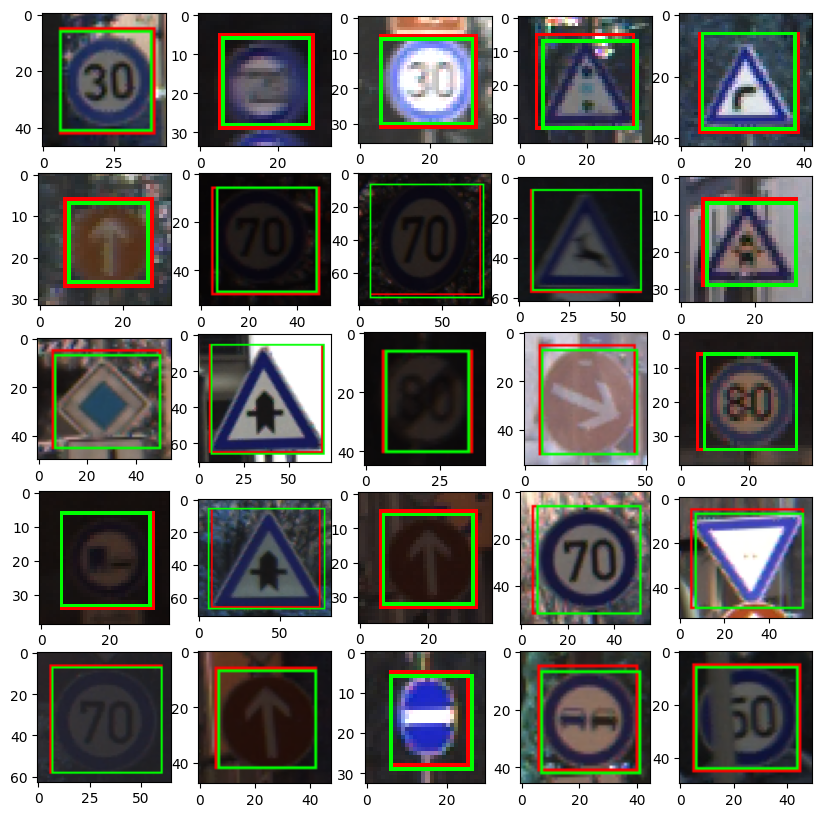

In [ ]:
# Plot training and validation loss across epochs.
# Plot training and validation accuracy across epochs.

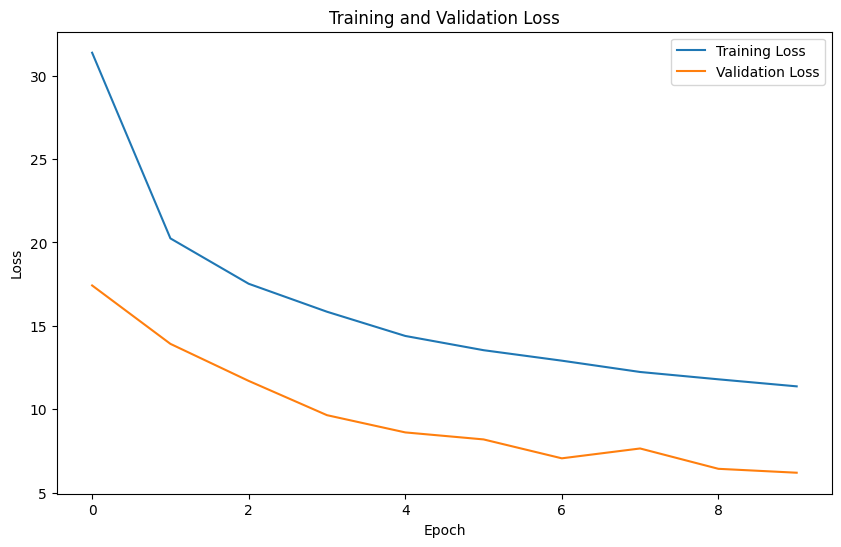

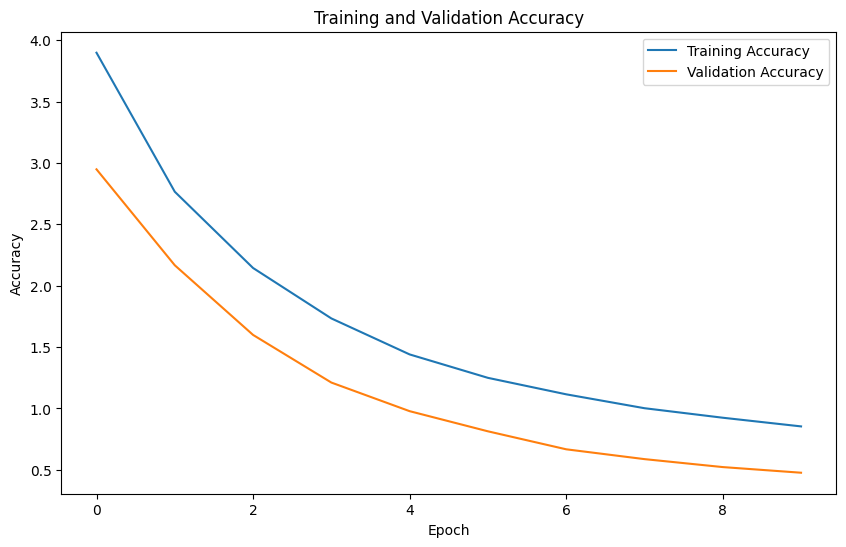